# Getting started with bayes-qnet

In this notebook, I'll walk through how to code works, by showing you how to define the structure of a queueing network, generate synthetic data from the network, and how to run the MCMC sampler described in Sutton and Jordon, 2011.

First, to specify a queueing model, I developed a simple syntax using YAML. This specifies the structure of the network and all of the parameters. We have to provide an initial value of the parameters in the model file, but later we'll able to modify the parameters by learning them from data.

In [1]:
import sys
sys.path.insert(0, '../src')

import qnet
import qnetu

## Specifying the Network

First we need to define the structure of the network. Here's an example YAML description that specifies a single M/M/1 queue:

In [2]:
mm1_text = """states:
  - name: INITIAL
    queues: [ INITIAL ]
    successors: [ TIER1 ]
    initial: TRUE 
  - name: TIER1
    queues: [ THE_Q ]
queues:
  - { name: INITIAL, service: [M, 10.0]  }
  - { name: THE_Q, service: [M, 3.0] }
"""

A few comments about this:

* Even though this a single queue and not a network, we still specify it as a network with two queues. The first queue simply represents the arrival distribution, i.e., all the jobs arrive at the INITIAL queue at time 0, and they depart the queue INITIAL at their "real" arrival time to the system. So the service distribution of the INITIAL queue is the interarrival distribution of the system.

* A bunch of different types of queues are supported. The implementation supports multiprocessor FCFS, processor sharing, and RSS queues. The allowed arrival times are exponential (denoted by "M" in the YAML), gamma ("G"), lognormal ("LN"). I think that I might have added code for mixtures of the above as well.

* The YAML independently specifies a set of states and a set of queues. The sequence of queues traversed by a job is assumed to be distributed as a hidden Markov chain, where the states are defined in the 'states:' block, and the observations are the identifiers of the queues. I found this to be useful for modelling multi-tier web applications.

* I've only run this code with open queueing networks. In principle, you could probably specify a closed network and run the code as usual and it would work. I don't think that there is anything in the code or the sampler that assumes the system is open. But I've never tried it.

* Usually I save the model description in a separate file, although I included it here as text so that we could look at it more easily. There are a few examples of other types of model descriptions in the `models/` subdirectory of this directory. You can load a model description from a file using `qnetu.qnet_from_file`.

Now let's try loading this description into a queueing network object.

In [3]:
net = qnetu.qnet_from_text(mm1_text)
print (net)
print (net.as_yaml())

states:
  - name: INITIAL
    queues: [ INITIAL ]
    successors: [ TIER1 ]
  - name: TIER1
    queues: [ THE_Q ]
queues:
  - { name: INITIAL, type: GGk, processors: 1, service: [ M, 10.0 ] }
  - { name: THE_Q, type: GGk, processors: 1, service: [ M, 3.0 ] }



## Generating Fantasy Data

Now let's sample 10 random tasks from the network. For each job, this will cause an arrival time, a path through the network, and service times for each queue in the path.

In [4]:
arrv0 = net.sample(10)
print (arrv0)

QUEUE INITIAL (0)
[EVT     0: 0.00000 .. 2.71207 S: 2.71207 TID:     0 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     1: 0.00000 .. 3.31501 S: 0.60294 TID:     1 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     2: 0.00000 .. 14.70460 S: 11.38959 TID:     2 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     3: 0.00000 .. 17.66551 S: 2.96091 TID:     3 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     4: 0.00000 .. 47.44329 S: 29.77778 TID:     4 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     5: 0.00000 .. 47.76753 S: 0.32424 TID:     5 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     6: 0.00000 .. 47.85507 S: 0.08754 TID:     6 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     7: 0.00000 .. 58.53945 S: 10.68438 TID:     7 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     8: 0.00000 .. 58.53957 S: 0.00012 TID:     8 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     9: 0.00000 .. 61.78298 S: 3.24341 TID:     9 Q: INITIAL ST: 0 PID: 0 OBS: 11]
QUEUE THE_Q (1)
[EVT    10: 2.71207 .. 4.11180 S: 1.39973 TID:     0 Q: THE_Q ST: 1 PID: 0 OBS: 11]
[EVT    11:

This has created an `Arrivals` object, which records the path of each task through the network. An `Arrivals` is a data structure that contains `Event` objects. An `Event` records the arrival, service, and departure time of a task at an individual queue. 

To access individual events, you can do things like this:

In [5]:
evt11 = arrv0.event(11)
print(evt11)
print("Arrival: %.4f Service: %.4f Departure: %.4f Waiting: %.4f" 
      % (evt11.a, evt11.s, evt11.d, evt11.wait()))

[EVT    11: 3.31501 .. 5.44286 S: 1.33106 TID:     1 Q: THE_Q ST: 1 PID: 0 OBS: 11]
Arrival: 3.3150 Service: 1.3311 Departure: 5.4429 Waiting: 0.7968


If you're interested in the stochastic process of the queue length, there is a special data structure that maps from time --> number in queue. This is called an `Ninq` object. You can get this using the `ninq_of_queue` method:

In [6]:
ninq = arrv0.ninq_of_queue(net.queue_by_name("THE_Q"))
n57 = ninq.N(57.5)
print(n57)

1


To run the Bayesian inference method, we'll want incomplete observations from the network. To simulate randomly choosing a subset of tasks to observe, we can do this:

In [7]:
observations0 = arrv0.subset_by_task(0.5)
print (observations0)

QUEUE INITIAL (0)
[EVT     0: 0.00000 .. 2.71207 S: 2.71207 TID:     0 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     1: 0.00000 .. 3.31501 S: 0.60294 TID:     1 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     2: 0.00000 .. 14.70460 S: 11.38959 TID:     2 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     3: 0.00000 .. 17.66551 S: 2.96091 TID:     3 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     4: 0.00000 .. 47.44329 S: 29.77778 TID:     4 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     5: 0.00000 .. 47.76753 S: 0.32424 TID:     5 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     6: 0.00000 .. 47.85507 S: 0.08754 TID:     6 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     7: 0.00000 .. 58.53945 S: 10.68438 TID:     7 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     8: 0.00000 .. 58.53957 S: 0.00012 TID:     8 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     9: 0.00000 .. 61.78298 S: 3.24341 TID:     9 Q: INITIAL ST: 0 PID: 0 OBS: 00]
QUEUE THE_Q (1)
[EVT    10: 2.71207 .. 4.11180 S: 1.39973 TID:     0 Q: THE_Q ST: 1 PID: 0 OBS: 00]
[EVT    11:

Now some of the evetns have "OBS: 00" marked, meaning that these are the tasks that are not observed.

## Running the MCMC sampler

The ``gibbs_resampler`` method runs the slice sampler from the Sutton and Jordan paper. A function ``gibbs_initialize`` sets the service times of the unobserved jobs to initial values. Here is an example:

In [8]:
initial0 = net.gibbs_initialize(observations0)
print (initial0)

gibbs_initialize: mini_params [6.178297730144496, 2.967376190171844]
gibbs_initialize: mini_params [5.9733566208770466, 3.1863450498914903]
QUEUE INITIAL (0)
[EVT     0: 0.00000 .. 0.92197 S: 0.92197 TID:     0 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     1: 0.00000 .. 1.47387 S: 0.55190 TID:     1 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     2: 0.00000 .. 14.70460 S: 13.23073 TID:     2 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     3: 0.00000 .. 17.66551 S: 2.96091 TID:     3 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     4: 0.00000 .. 47.44329 S: 29.77778 TID:     4 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     5: 0.00000 .. 47.76753 S: 0.32424 TID:     5 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     6: 0.00000 .. 49.64237 S: 1.87485 TID:     6 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     7: 0.00000 .. 51.58577 S: 1.94340 TID:     7 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     8: 0.00000 .. 58.53957 S: 6.95380 TID:     8 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     9: 0.00000 .. 59.33215 S: 0.79259 TID:     9 Q: IN

Now let's run the Gibbs sampler for 1000 iterations. The output of the method will be a list of arrival objects, one for each iteration.

In [9]:
arrvlist = net.gibbs_resample(initial0, 0, 1000)

SLICE 1 0 0.9219743885 1.6279439041 -5.3057808712 -6.9742453934 0.0000000000 6.8533112015 0.0000000000 6.8533112015 
SLICE 2 0 1.6279439041 6.6185797968 -4.1412991629 -7.0446359807 0.0000000000 6.8533112015 0.0000000000 6.8533112015 
SLICE 3 0 1.4738727097 11.1229635307 -6.6040415265 -7.6664779947 0.9219743885 17.6711992225 0.9219743885 17.6711992225 
SLICE 4 0 11.1229635307 11.6685005564 -6.4767495538 -8.0980392104 0.9219743885 17.6711992225 0.9219743885 17.6711992225 
SLICE 5 0 49.6423727634 51.5542782100 -4.8953005943 -4.7397750768 47.7675259731 60.4556109129 47.7675259731 60.4556109129 
SLICE 5 1 49.6423727634 47.9890982827 -4.5387826015 -4.7397750768 47.7675259731 51.5542782100 47.7675259731 60.4556109129 
SLICE 6 0 47.9890982827 52.4983295489 -4.9897057282 -6.4841195130 47.7675259731 60.4556109129 47.7675259731 60.4556109129 
SLICE 7 0 51.5857716153 53.4783685220 -3.8591367085 -3.9659676087 49.6423727634 60.6786301657 49.6423727634 60.6786301657 
SLICE 8 0 53.4783685220 53.597036

SLICE 77 0 60.6291760226 60.2458778490 -1.1867898998 -1.8879722013 59.9813450157 63.5735338140 59.9813450157 inf 
SLICE 78 0 60.2458778490 66.1659743739 -3.1601554081 -2.7883873919 59.9813450157 67.7433859989 59.9813450157 inf 
SLICE 78 1 60.2458778490 60.9404498468 -1.4183138990 -2.7883873919 59.9813450157 66.1659743739 59.9813450157 inf 
SLICE 79 0 65.0752290734 63.2520379115 -1.9121716160 -3.1379848062 60.8113599293 73.5134838321 60.8113599293 inf 
SLICE 80 0 63.2520379115 63.3975506652 -1.9606758673 -2.8955699747 60.8113599293 67.5155979043 60.8113599293 inf 
SLICE 81 0 6.2782518930 9.4230122247 -4.8186682676 -6.5462648105 0.0000000000 10.8485212151 0.0000000000 10.8485212151 
SLICE 82 0 9.4230122247 10.7549091197 -4.5078923254 -6.2998864185 0.0000000000 10.8485212151 0.0000000000 10.8485212151 
SLICE 83 0 12.7435770341 16.6091218959 -4.1519652941 -5.2955461453 10.7549091197 17.1051618003 10.7549091197 17.1051618003 
SLICE 84 0 16.6091218959 16.5583922673 -4.1638022074 -5.836598742

SLICE 147 0 56.5731387294 56.5382273894 -4.0780118665 -5.3229775968 50.0525945108 60.0660986067 50.0525945108 60.0660986067 
SLICE 148 0 56.5382273894 52.5667919210 -3.6808683197 -4.3009642191 50.0525945108 60.0660986067 50.0525945108 60.0660986067 
SLICE 149 0 60.2874222250 60.4711572184 -3.6503197249 -5.5908295693 58.5395671289 60.9792499323 58.5395671289 60.9792499323 
SLICE 150 0 60.4711572184 60.3612599466 -3.6393299978 -4.1882179704 58.5395671289 60.9792499323 58.5395671289 60.9792499323 
SLICE 151 0 13.0732784684 17.4180236277 -3.1496899886 -3.1310968337 11.2647905278 17.8870711387 11.2647905278 inf 
SLICE 151 1 13.0732784684 13.7706320535 -1.9338927972 -3.1310968337 11.2647905278 17.4180236277 11.2647905278 inf 
SLICE 152 0 13.7706320535 12.8604764984 -1.6305076122 -3.0227192776 11.2647905278 17.8527541718 11.2647905278 inf 
SLICE 153 0 17.1051618003 19.5484586007 -2.8207027688 -3.2348941214 14.3821871602 21.2243380020 14.3821871602 inf 
SLICE 154 0 19.5484586007 27.6837851134 

SLICE 667 0 58.0870674778 55.0934579698 -3.7561133239 -8.1537510062 52.7211762659 58.5663212836 52.7211762659 58.5663212836 
SLICE 668 0 55.0934579698 53.9128440491 -3.6380519318 -4.9204061722 52.7211762659 58.5663212836 52.7211762659 58.5663212836 
SLICE 669 0 64.4160720413 64.0667096792 -4.1096781822 -4.5511968171 58.5395671289 64.5340093156 58.5395671289 64.5340093156 
SLICE 670 0 64.0667096792 63.3993700115 -4.2653907713 -4.3266554123 58.5395671289 64.5340093156 58.5395671289 64.5340093156 
SLICE 671 0 7.5883837921 11.7395738782 -4.8011009523 -5.6858130676 0.6321078871 16.3447298092 0.6321078871 inf 
SLICE 672 0 11.7395738782 3.4505841224 -2.0381043671 -7.0420967256 0.6321078871 28.3822173191 0.6321078871 inf 
SLICE 673 0 12.0079095952 17.7531884783 -5.8661470740 -5.5359597980 4.2128928716 20.2128928716 3.4505841224 inf 
SLICE 673 1 12.0079095952 13.4122985651 -4.4191837696 -5.5359597980 4.2128928716 17.7531884783 3.4505841224 inf 
SLICE 674 0 13.4122985651 27.4078782164 -9.0843769

SLICE 729 0 65.0089688607 65.6865663010 -4.3816604071 -4.9831511645 58.5395671289 66.4838556257 58.5395671289 66.4838556257 
SLICE 730 0 65.6865663010 65.5168247321 -4.4212667732 -7.3545813418 58.5395671289 66.4838556257 58.5395671289 66.4838556257 
SLICE 731 0 2.3014221815 2.3757548434 -1.6688843153 -3.6751523734 0.6649387635 15.1970041730 0.6649387635 inf 
SLICE 732 0 2.3757548434 3.8516408957 -2.1608463327 -1.8009137009 0.6649387635 4.4273639108 0.6649387635 inf 
SLICE 732 1 2.3757548434 2.7547109388 -1.7952030138 -1.8009137009 0.6649387635 3.8516408957 0.6649387635 inf 
SLICE 733 0 5.7855410456 9.2458001764 -2.6516688999 -3.0004932870 4.5866303427 11.9029003450 4.5866303427 inf 
SLICE 734 0 9.2458001764 9.2788455854 -2.6626840362 -3.4204532422 4.5866303427 18.1973980679 4.5866303427 inf 
SLICE 735 0 58.5577720052 68.6058295917 -4.9307798372 -3.7714985695 57.1093269461 71.3343624441 57.1093269461 inf 
SLICE 735 1 58.5577720052 61.8460562057 -2.6775220419 -3.7714985695 57.1093269461 

SLICE 904 1 14.3461926373 16.5311238969 -5.1190097750 -6.4813003840 8.5174453176 18.7754956720 6.8342392142 18.7754956720 
SLICE 905 0 54.3436856062 53.7453713946 -4.2487979866 -4.4061557511 47.7675259731 57.8587751346 47.7675259731 57.8587751346 
SLICE 906 0 53.7453713946 53.3470111764 -4.2089619648 -4.4245105386 47.7675259731 57.8587751346 47.7675259731 57.8587751346 
SLICE 907 0 56.6866590429 54.8538126613 -3.8695905264 -4.8836724366 53.3470111764 58.8119141233 53.3470111764 58.8119141233 
SLICE 908 0 54.8538126613 55.1415667209 -3.8983659324 -4.5925975992 53.3470111764 58.8119141233 53.3470111764 58.8119141233 
SLICE 909 0 61.5933607794 60.5622435118 -4.1289463410 -8.9806421167 58.5395671289 62.3878038924 58.5395671289 62.3878038924 
SLICE 910 0 60.5622435118 59.2977609947 -4.0024980893 -5.2926232472 58.5395671289 62.3878038924 58.5395671289 62.3878038924 
SLICE 911 0 6.8706930706 7.3077085118 -1.2564353879 -2.2544845215 6.8342392142 10.4761110199 6.8342392142 inf 
SLICE 912 0 7.30

SLICE 986 2 47.8312237515 52.1184456634 -4.6405709059 -4.6990801562 47.7675259731 52.7073876050 47.7675259731 59.5221716118 
SLICE 987 0 56.9128475772 59.2226489871 -4.3463086459 -5.2373642367 52.1184456634 60.2262444075 52.1184456634 60.2262444075 
SLICE 988 0 59.2226489871 59.2963944825 -4.3536831955 -5.5565569273 52.1184456634 60.2262444075 52.1184456634 60.2262444075 
SLICE 989 0 64.4628206248 65.2489205509 -4.2789343527 -4.5888120191 58.5395671289 65.8693254372 58.5395671289 65.8693254372 
SLICE 990 0 65.2489205509 65.2614517872 -4.2760103975 -5.1114210260 58.5395671289 65.8693254372 58.5395671289 65.8693254372 
SLICE 991 0 10.7363541587 11.0852936826 -1.5852563800 -2.2381275806 9.6253614086 13.6125040217 9.6253614086 inf 
SLICE 992 0 11.0852936826 10.7704466506 -1.4803073693 -1.9467200374 9.6253614086 13.4187680243 9.6253614086 inf 
SLICE 993 0 21.4203942338 25.2134390133 -4.8308322680 -3.9607784602 14.0167790752 38.4146893437 14.0167790752 inf 
SLICE 993 1 21.4203942338 18.00446

SLICE 1079 1 64.8149597689 65.9666191355 -2.8170320241 -2.5347423146 60.8113599293 68.0471536025 60.8113599293 inf 
SLICE 1079 2 64.8149597689 61.8713993261 -1.4519587542 -2.5347423146 60.8113599293 65.9666191355 60.8113599293 inf 
SLICE 1080 0 61.8713993261 65.7190400761 -2.7345056709 -3.8384406686 60.8113599293 76.6335591230 60.8113599293 inf 
SLICE 1081 0 5.3390240946 4.1185326072 -5.1771106150 -5.9846664849 0.0000000000 8.2107125251 0.0000000000 8.2107125251 
SLICE 1082 0 4.1185326072 2.9218564463 -5.4563350526 -6.6804230058 0.0000000000 8.2107125251 0.0000000000 8.2107125251 
SLICE 1083 0 12.5805706116 5.8030504697 -6.2267890620 -7.1821508212 2.9218564463 15.8231293592 2.9218564463 15.8231293592 
SLICE 1084 0 5.8030504697 3.4566594168 -5.9921499567 -6.4125451169 2.9218564463 15.8231293592 2.9218564463 15.8231293592 
SLICE 1085 0 50.3594410645 56.5251502581 -4.7575325835 -5.3544040465 47.7675259731 58.5510452662 47.7675259731 58.5510452662 
SLICE 1086 0 56.5251502581 55.3043340348 

SLICE 1495 0 57.9148206292 60.3681381484 -2.1848826894 -1.7054524215 57.1093269461 60.8607815917 57.1093269461 inf 
SLICE 1495 1 57.9148206292 57.9296210733 -1.3720436644 -1.7054524215 57.1093269461 60.3681381484 57.1093269461 inf 
SLICE 1496 0 57.9296210733 68.2294331449 -4.8053143549 -4.7543229581 57.1093269461 72.1835353515 57.1093269461 inf 
SLICE 1496 1 57.9296210733 66.3215414656 -4.1693504618 -4.7543229581 57.1093269461 68.2294331449 57.1093269461 inf 
SLICE 1497 0 58.4443675909 61.7018119397 -2.3609427255 -2.1820162883 57.9148206292 61.7793244509 57.9148206292 inf 
SLICE 1497 1 58.4443675909 60.9072152389 -2.0960771586 -2.1820162883 57.9148206292 61.7018119397 57.9148206292 inf 
SLICE 1498 0 60.9072152389 58.7883322846 -1.3897828405 -3.4079985827 57.9148206292 65.1052626669 57.9148206292 inf 
SLICE 1499 0 75.1108105566 81.6281472589 -6.9607074311 -6.3267830435 64.0418618315 91.9592806856 64.0418618315 inf 
SLICE 1499 1 75.1108105566 77.9325707966 -5.7288486104 -6.3267830435 64.

SLICE 1734 1 16.9497278693 16.5172410199 -1.8913622413 -2.2071199631 14.1389911621 17.8003707534 14.1389911621 inf 
SLICE 1735 0 57.1549945320 57.4431889981 -1.2098996393 -1.2804145284 57.1093269461 57.9359119335 57.1093269461 inf 
SLICE 1736 0 57.4431889981 58.0771973136 -1.4212357445 -1.3949978915 57.1093269461 58.2769824494 57.1093269461 inf 
SLICE 1736 1 57.4431889981 57.8376203763 -1.3413767654 -1.3949978915 57.1093269461 58.0771973136 57.1093269461 inf 
SLICE 1737 0 59.3580402138 58.4388167977 -1.2990110958 -2.8211323596 57.8376203763 64.1551755266 57.8376203763 inf 
SLICE 1738 0 58.4388167977 58.7034910597 -1.3872358498 -2.2892615792 57.8376203763 65.2885398412 57.8376203763 inf 
SLICE 1739 0 64.7771338758 63.4282343849 -1.9709037739 -3.6521150800 60.8113599293 73.0078423494 60.8113599293 inf 
SLICE 1740 0 63.4282343849 60.8922782391 -1.1255850586 -2.4364796288 60.8113599293 68.0818338143 60.8113599293 inf 
SLICE 1741 0 0.7929772301 5.3377288789 -3.9442260540 -5.8509371522 0.000

SLICE 1833 0 19.2291894099 18.0243287296 -1.1951347118 -2.3252716458 17.7347614603 21.4246325881 17.7347614603 inf 
SLICE 1834 0 18.0243287296 18.0353564312 -1.1988106123 -1.2699376811 17.7347614603 18.9950536581 17.7347614603 inf 
SLICE 1835 0 57.8428016570 57.2033435857 -1.1299511685 -1.4882766963 57.1093269461 59.0679682796 57.1093269461 inf 
SLICE 1836 0 57.2033435857 57.3472189400 -1.1779096200 -2.1383650299 57.1093269461 61.0538786436 57.1093269461 inf 
SLICE 1837 0 58.3317845936 59.1741297878 -1.5423883323 -1.5173376158 57.8428016570 59.6926001078 57.8428016570 inf 
SLICE 1837 1 58.3317845936 59.1611328511 -1.5380560200 -1.5173376158 57.8428016570 59.1741297878 57.8428016570 inf 
SLICE 1837 2 58.3317845936 58.6638841832 -1.3723064641 -1.5173376158 57.8428016570 59.1611328511 57.8428016570 inf 
SLICE 1838 0 58.6638841832 60.2415351903 -1.8981901331 -1.7634560636 57.8428016570 60.8698485170 57.8428016570 inf 
SLICE 1838 1 58.6638841832 59.9803793436 -1.8111381842 -1.7634560636 57.

SLICE 2122 0 10.3376843195 4.8401461610 -7.0305720837 -10.6120139092 0.0000000000 14.2762264189 0.0000000000 14.2762264189 
SLICE 2123 0 10.5666854703 11.9389034603 -4.1169501824 -4.1475102285 4.8401461610 14.2938576313 4.8401461610 14.2938576313 
SLICE 2124 0 11.9389034603 11.1832585799 -4.0413856943 -4.6638188884 4.8401461610 14.2938576313 4.8401461610 14.2938576313 
SLICE 2125 0 49.5021277372 50.3131254893 -4.2770459586 -4.8279491685 47.7675259731 58.9731928221 47.7675259731 58.9731928221 
SLICE 2126 0 50.3131254893 49.8703326825 -4.2327666779 -4.8394273455 47.7675259731 58.9731928221 47.7675259731 58.9731928221 
SLICE 2127 0 53.7130352879 55.7166343079 -4.2994617841 -4.1723179087 49.8703326825 59.9140955417 49.8703326825 59.9140955417 
SLICE 2127 1 53.7130352879 50.4067825121 -3.7684766045 -4.1723179087 49.8703326825 55.7166343079 49.8703326825 59.9140955417 
SLICE 2128 0 50.4067825121 57.9789223945 -4.5256905927 -3.9063565425 49.8703326825 59.9140955417 49.8703326825 59.9140955417

SLICE 2364 0 18.8229478510 9.5976255872 -6.8348818983 -7.1989561797 8.6046661723 19.8985570694 8.6046661723 19.8985570694 
SLICE 2365 0 48.2752573929 50.8934589404 -4.5141674780 -5.1874435244 47.7675259731 59.5104573448 47.7675259731 59.5104573448 
SLICE 2366 0 50.8934589404 54.4350160948 -4.8683231934 -5.5536997052 47.7675259731 59.5104573448 47.7675259731 59.5104573448 
SLICE 2367 0 50.1028378836 53.4905766403 -4.3288144792 -4.0211532804 48.2752573929 60.7287128632 48.2752573929 60.7287128632 
SLICE 2367 1 50.1028378836 52.6080818244 -4.2405649976 -4.0211532804 48.2752573929 53.4905766403 48.2752573929 60.7287128632 
SLICE 2367 2 50.1028378836 49.9004715603 -3.9698039712 -4.0211532804 48.2752573929 52.6080818244 48.2752573929 60.7287128632 
SLICE 2368 0 49.9004715603 56.9172635257 -4.6714831678 -4.8212378445 48.2752573929 60.7287128632 48.2752573929 60.7287128632 
SLICE 2369 0 62.1574519361 59.7557988051 -5.0228549957 -5.4883861614 58.5395671289 65.3114632686 58.5395671289 65.3114632

SLICE 2847 1 51.4796802858 53.8898317633 -4.2501122413 -4.2307008070 47.8304743771 56.4943252028 47.8304743771 58.6766202200 
SLICE 2847 2 51.4796802858 48.8788581296 -3.7490148779 -4.2307008070 47.8304743771 53.8898317633 47.8304743771 58.6766202200 
SLICE 2848 0 48.8788581296 50.6769218435 -3.9288212493 -6.5358579496 47.8304743771 58.6766202200 47.8304743771 58.6766202200 
SLICE 2849 0 68.7388005322 69.8245749030 -7.4349894159 -8.1277834724 58.5395671289 78.5404486735 58.5395671289 78.5404486735 
SLICE 2850 0 69.8245749030 73.2870447380 -6.6270797877 -8.0446176355 58.5395671289 78.5404486735 58.5395671289 78.5404486735 
SLICE 2851 0 9.2620839560 9.4482409691 -1.1659807879 -1.6198350318 9.2461354714 12.5748174431 9.2461354714 inf 
SLICE 2852 0 9.4482409691 9.9961761571 -1.3486258506 -3.3981471178 9.2461354714 16.3857637488 9.2461354714 inf 
SLICE 2853 0 17.3521037638 17.8367072030 -2.4943022787 -2.4661310054 13.6496372328 18.1437249878 13.6496372328 inf 
SLICE 2853 1 17.3521037638 15.

SLICE 3162 0 0.1454502887 5.1212114792 -4.7544444432 -6.3324371522 0.0000000000 7.6445892201 0.0000000000 7.6445892201 
SLICE 3163 0 14.5702127578 17.3898933584 -5.2170098068 -10.0719600639 5.1212114792 19.1567260700 5.1212114792 19.1567260700 
SLICE 3164 0 17.3898933584 17.8761288797 -5.1035548518 -6.3273994804 5.1212114792 19.1567260700 5.1212114792 19.1567260700 
SLICE 3165 0 53.5381545858 52.5470538931 -4.3822923091 -4.7031522568 47.7675259731 58.6187533524 47.7675259731 58.6187533524 
SLICE 3166 0 52.5470538931 56.7114612968 -4.7987330494 -4.9627343790 47.7675259731 58.6187533524 47.7675259731 58.6187533524 
SLICE 3167 0 56.5699719784 53.8262375963 -3.8592062437 -4.2991685577 53.5381545858 59.9063550354 53.5381545858 59.9063550354 
SLICE 3168 0 53.8262375963 58.0046660961 -4.2770490937 -6.0233073185 53.5381545858 59.9063550354 53.5381545858 59.9063550354 
SLICE 3169 0 69.6302021725 69.3333230615 -4.6790428445 -5.8507056999 58.5395671289 69.9287326702 58.5395671289 69.9287326702 
S

SLICE 3661 0 1.8010204947 1.4783827049 -3.6730808333 -4.0874419550 0.0000000000 1.8505182483 0.0000000000 1.8505182483 
SLICE 3662 0 1.4783827049 0.6036090628 -3.8771946831 -5.2883488436 0.0000000000 1.8505182483 0.0000000000 1.8505182483 
SLICE 3663 0 12.0485946094 5.7002812618 -8.9300759106 -7.5173178561 0.6036090628 20.7579151890 0.6036090628 20.7579151890 
SLICE 3663 1 12.0485946094 14.5189033413 -6.8723974254 -7.5173178561 5.7002812618 20.7579151890 0.6036090628 20.7579151890 
SLICE 3664 0 14.5189033413 17.2763649135 -6.2289897252 -6.9518044250 0.6036090628 20.7579151890 0.6036090628 20.7579151890 
SLICE 3665 0 49.0861262255 52.5370567233 -4.0002928705 -8.5706169524 47.7675259731 57.4757541876 47.7675259731 57.4757541876 
SLICE 3666 0 52.5370567233 49.3972212806 -3.6863093263 -4.5006693326 47.7675259731 57.4757541876 47.7675259731 57.4757541876 
SLICE 3667 0 53.3378015677 54.3424407459 -4.6625050959 -5.2977675207 49.3972212806 59.7761114907 49.3972212806 59.7761114907 
SLICE 3668 

SLICE 3767 0 53.5415830179 58.4915500313 -4.4148199314 -3.9709648441 51.8689195067 60.4202951446 51.8689195067 60.4202951446 
SLICE 3767 1 53.5415830179 53.6394329462 -3.9296082229 -3.9709648441 51.8689195067 58.4915500313 51.8689195067 60.4202951446 
SLICE 3768 0 53.6394329462 58.4611355032 -4.4117784786 -6.2893970345 51.8689195067 60.4202951446 51.8689195067 60.4202951446 
SLICE 3769 0 71.3215071763 69.0738458248 -7.6869666851 -7.3847131479 58.5395671289 78.7708701264 58.5395671289 78.7708701264 
SLICE 3769 1 71.3215071763 75.7677765246 -6.1250495218 -7.3847131479 69.0738458248 78.7708701264 58.5395671289 78.7708701264 
SLICE 3770 0 75.7677765246 63.6769246289 -8.9462482975 -7.8274925875 58.5395671289 78.7708701264 58.5395671289 78.7708701264 
SLICE 3770 1 75.7677765246 78.3604052855 -5.5201028109 -7.8274925875 63.6769246289 78.7708701264 58.5395671289 78.7708701264 
SLICE 3771 0 4.2663567197 5.7936997330 -1.7790022279 -1.5625926463 3.7525299153 7.0086757614 3.7525299153 inf 
SLICE 3

SLICE 4632 0 7.0729865261 6.4142590423 -1.4090121670 -1.8139751647 5.4830594073 9.4673112813 5.4830594073 inf 
SLICE 4633 0 17.0071959486 24.6318110802 -4.8193553098 -3.0489233695 13.4695820167 25.8161576647 13.4695820167 inf 
SLICE 4633 1 17.0071959486 22.2531662962 -4.0264737152 -3.0489233695 13.4695820167 24.6318110802 13.4695820167 inf 
SLICE 4633 2 17.0071959486 13.9963336808 -1.2741961767 -3.0489233695 13.4695820167 22.2531662962 13.4695820167 inf 
SLICE 4634 0 13.9963336808 17.2012125137 -2.3424891210 -2.6405940019 13.4695820167 20.6100341249 13.4695820167 inf 
SLICE 4635 0 57.5237653334 60.2711527492 -2.1525542230 -2.6403735744 57.1093269461 65.0085783594 57.1093269461 inf 
SLICE 4636 0 60.2711527492 62.7192518784 -2.9685872661 -3.2442165939 57.1093269461 64.7389305921 57.1093269461 inf 
SLICE 4637 0 59.1420525344 67.6769698786 -4.2652899299 -5.9187546612 58.1769369550 73.9186308149 58.1769369550 inf 
SLICE 4638 0 67.6769698786 61.9677589595 -2.3622196235 -4.5302305702 58.17693

SLICE 5592 0 10.8437543949 10.2228290532 -1.3239115536 -3.2968700457 9.5469312584 23.7922727065 9.5469312584 inf 
SLICE 5593 0 21.8021900037 19.2748395628 -1.3611705776 -3.6150326286 18.4871646960 30.7175494417 18.4871646960 inf 
SLICE 5594 0 19.2748395628 21.7197089854 -2.1761270518 -2.6186426750 18.4871646960 26.2576751172 18.4871646960 inf 
SLICE 5595 0 58.8889160017 60.2165976182 -2.1343691794 -2.8495249921 57.1093269461 63.1471175534 57.1093269461 inf 
SLICE 5596 0 60.2165976182 57.9692263202 -1.3852454134 -2.4131248709 57.1093269461 64.8220781254 57.1093269461 inf 
SLICE 5597 0 59.4903939048 59.9048270607 -1.4372493083 -1.4459469472 58.8889160017 60.6707787849 58.8889160017 inf 
SLICE 5598 0 59.9048270607 59.0909358585 -1.1659522409 -2.5315177463 58.8889160017 66.1329167106 58.8889160017 inf 
SLICE 5599 0 74.2180701884 64.5776966631 -2.3540578666 -6.4133098293 60.8113599293 91.1813128170 60.8113599293 inf 
SLICE 5600 0 64.5776966631 65.8096389650 -2.7647053006 -2.8340170786 60.81

SLICE 6583 1 6.9507036084 6.3112634098 -4.4227491586 -4.8982998984 1.7499918745 7.7308887373 0.8278300656 7.7308887373 
SLICE 6584 0 6.3112634098 2.5515497330 -5.3000156831 -6.0926057789 0.8278300656 7.7308887373 0.8278300656 7.7308887373 
SLICE 6585 0 50.5799506451 51.7774984739 -4.5405336505 -6.6889590463 47.7675259731 59.3243440025 47.7675259731 59.3243440025 
SLICE 6586 0 51.7774984739 58.4016616015 -4.7721717448 -5.2442523753 47.7675259731 59.3243440025 47.7675259731 59.3243440025 
SLICE 6587 0 56.8038112483 53.2893570922 -4.1332944427 -5.4619767243 50.5799506451 60.7078132516 50.5799506451 60.7078132516 
SLICE 6588 0 53.2893570922 54.4633969111 -4.2506984246 -5.0469162043 50.5799506451 60.7078132516 50.5799506451 60.7078132516 
SLICE 6589 0 64.5509321500 62.4604212856 -6.2734093432 -9.1462057052 58.5395671289 69.9008009232 58.5395671289 69.9008009232 
SLICE 6590 0 62.4604212856 61.5966495967 -6.4749560706 -7.4290956843 58.5395671289 69.9008009232 58.5395671289 69.9008009232 
SLIC

SLICE 7279 0 64.4022826515 64.9679659951 -1.4037026510 -1.4310263572 64.0526949081 65.4955501825 64.0526949081 inf 
SLICE 7280 0 64.9679659951 64.7839665745 -1.3423695108 -1.6878090202 64.0526949081 67.1373010598 64.0526949081 inf 
SLICE 7281 0 7.8747065279 13.0724073281 -5.6915827382 -6.9700342189 0.0000000000 16.0218411993 0.0000000000 16.0218411993 
SLICE 7282 0 13.0724073281 12.3348210519 -5.8636862027 -7.9298730644 0.0000000000 16.0218411993 0.0000000000 16.0218411993 
SLICE 7283 0 14.5847680351 19.2630079386 -4.3909077028 -7.5896431229 12.3348210519 20.1536828361 12.3348210519 20.1536828361 
SLICE 7284 0 19.2630079386 13.1849059428 -4.8634864163 -9.8152562771 12.3348210519 20.1536828361 12.3348210519 20.1536828361 
SLICE 7285 0 50.0509644976 51.1557297592 -4.2711530372 -5.4465494918 47.7675259731 58.7027327770 47.7675259731 58.7027327770 
SLICE 7286 0 51.1557297592 56.6141209972 -4.8169921610 -5.3563190362 47.7675259731 58.7027327770 47.7675259731 58.7027327770 
SLICE 7287 0 50.5

SLICE 8207 0 58.4897691619 56.5840740111 -4.0848451700 -5.1228938830 52.3561835327 60.5132708704 52.3561835327 60.5132708704 
SLICE 8208 0 56.5840740111 54.5474737755 -3.8811851464 -4.2780973186 52.3561835327 60.5132708704 52.3561835327 60.5132708704 
SLICE 8209 0 65.1345933634 64.3887302685 -4.7949010148 -4.7317947220 58.5395671289 66.8150922260 58.5395671289 66.8150922260 
SLICE 8209 1 65.1345933634 65.9420357942 -4.4324630588 -4.7317947220 64.3887302685 66.8150922260 58.5395671289 66.8150922260 
SLICE 8210 0 65.9420357942 64.2794351624 -4.8204032062 -4.4557175473 58.5395671289 66.8150922260 58.5395671289 66.8150922260 
SLICE 8210 1 65.9420357942 65.9986696209 -4.4192484992 -4.4557175473 64.2794351624 66.8150922260 58.5395671289 66.8150922260 
SLICE 8211 0 1.1295136622 0.8564973349 -1.2080339542 -1.8684075207 0.5282323383 4.2022223549 0.5282323383 inf 
SLICE 8212 0 0.8564973349 3.0044425546 -1.9240156941 -2.8296833112 0.5282323383 7.6349889218 0.5282323383 inf 
SLICE 8213 0 9.8106254

SLICE 9229 2 72.4735847619 71.7454918794 -5.0994875097 -5.2777024149 70.3963501527 72.8785848384 58.5395671289 72.8785848384 
SLICE 9230 0 71.7454918794 68.2905580458 -5.9056387375 -5.7554598179 58.5395671289 72.8785848384 58.5395671289 72.8785848384 
SLICE 9230 1 71.7454918794 72.0207021548 -5.0352717788 -5.7554598179 68.2905580458 72.8785848384 58.5395671289 72.8785848384 
SLICE 9231 0 16.8053508059 23.2414628853 -5.1907900384 -5.7379890521 10.9649296362 25.2650784150 10.9649296362 inf 
SLICE 9232 0 23.2414628853 14.2417150339 -2.1908740879 -5.4887553480 10.9649296362 40.0304922744 10.9649296362 inf 
SLICE 9233 0 18.6446523990 21.9811903973 -2.8238921525 -2.5199240573 16.8053508059 23.3727707309 16.8053508059 inf 
SLICE 9233 1 18.6446523990 19.7857311405 -2.0920724002 -2.5199240573 16.8053508059 21.9811903973 16.8053508059 inf 
SLICE 9234 0 19.7857311405 17.8596126343 -1.4500328981 -2.7067944937 16.8053508059 24.5141601958 16.8053508059 inf 
SLICE 9235 0 58.0899929863 59.7986712047 -

SLICE 10252 1 5.5480129060 9.4711212742 -3.9777396807 -3.1763558824 0.8337390983 13.1208247195 0.8337390983 inf 
SLICE 10252 2 5.5480129060 1.2240550959 -1.2287176212 -3.1763558824 0.8337390983 9.4711212742 0.8337390983 inf 
SLICE 10253 0 10.0975202945 10.0400528161 -1.3134991125 -1.3818649305 9.3953923447 10.3485610494 9.3953923447 inf 
SLICE 10254 0 10.0400528161 15.0294241971 -2.9766229061 -3.8609418389 9.3953923447 25.2455165981 9.3953923447 inf 
SLICE 10255 0 57.2410894870 58.9367134005 -1.7077411068 -2.2900873476 57.1093269461 64.4726925719 57.1093269461 inf 
SLICE 10256 0 58.9367134005 58.8226557994 -1.6697219064 -2.9487310520 57.1093269461 63.6769746891 57.1093269461 inf 
SLICE 10257 0 58.9869697451 59.6942913936 -1.3891574867 -1.3047481536 58.8226557994 60.2711614898 58.8226557994 inf 
SLICE 10257 1 58.9869697451 59.1217356747 -1.1983055804 -1.3047481536 58.8226557994 59.6942913936 58.8226557994 inf 
SLICE 10258 0 59.1217356747 58.8440750785 -1.1057520484 -2.2007676309 58.8226

SLICE 11365 0 49.1622942936 50.3407939306 -3.8570248001 -4.7245862909 47.7675259731 57.7048288141 47.7675259731 57.7048288141 
SLICE 11366 0 50.3407939306 51.4581791571 -3.9687633227 -3.9395201065 47.7675259731 57.7048288141 47.7675259731 57.7048288141 
SLICE 11366 1 50.3407939306 48.2350097974 -3.6464463867 -3.9395201065 47.7675259731 51.4581791571 47.7675259731 57.7048288141 
SLICE 11367 0 58.1655182495 48.6693481228 -4.2839543753 -5.9126976999 48.2350097974 60.2227982973 48.2350097974 60.2227982973 
SLICE 11368 0 48.6693481228 54.5434391725 -4.8713634803 -5.3210450659 48.2350097974 60.2227982973 48.2350097974 60.2227982973 
SLICE 11369 0 66.9569301894 60.3575879024 -6.3075872791 -6.3521492664 58.5395671289 68.9851233897 58.5395671289 68.9851233897 
SLICE 11370 0 60.3575879024 59.5944237058 -6.2312708595 -8.2875263168 58.5395671289 68.9851233897 58.5395671289 68.9851233897 
SLICE 11371 0 11.8554038103 12.6193622934 -2.7511490897 -4.9296383377 7.6617518905 20.6866470786 7.6617518905 i

SLICE 12425 0 54.5966123385 48.5600125761 -3.6056210669 -4.3621701563 47.7675259731 57.4848520209 47.7675259731 57.4848520209 
SLICE 12426 0 48.5600125761 51.7130812842 -3.9209279377 -4.1449731877 47.7675259731 57.4848520209 47.7675259731 57.4848520209 
SLICE 12427 0 55.3264302823 52.4285530134 -3.4978321903 -3.8875206882 51.7130812842 57.5601149282 51.7130812842 57.5601149282 
SLICE 12428 0 52.4285530134 55.9830952328 -3.8532864123 -3.7653078140 51.7130812842 57.5601149282 51.7130812842 57.5601149282 
SLICE 12428 1 52.4285530134 55.3755114528 -3.7925280343 -3.7653078140 51.7130812842 55.9830952328 51.7130812842 57.5601149282 
SLICE 12428 2 52.4285530134 53.8452083785 -3.6394977269 -3.7653078140 51.7130812842 55.3755114528 51.7130812842 57.5601149282 
SLICE 12429 0 63.3538214190 66.6093569156 -4.5430665458 -6.2189544073 58.5395671289 67.6140274720 58.5395671289 67.6140274720 
SLICE 12430 0 66.6093569156 64.2046982086 -5.1041535774 -5.1257819448 58.5395671289 67.6140274720 58.5395671289

SLICE 13493 2 21.4120479197 24.2624253240 -2.6283471229 -2.7962021448 19.6732208213 24.8814118697 19.6732208213 inf 
SLICE 13494 0 24.2624253240 27.9501188926 -3.8575783124 -2.9568255914 19.6732208213 32.3625355954 19.6732208213 inf 
SLICE 13494 1 24.2624253240 22.8694518838 -2.1640226428 -2.9568255914 19.6732208213 27.9501188926 19.6732208213 inf 
SLICE 13495 0 57.5394234061 57.7935984680 -1.3267027960 -1.3458702130 57.1093269461 58.2743047283 57.1093269461 inf 
SLICE 13496 0 57.7935984680 57.1186950667 -1.1017349955 -1.3928615358 57.1093269461 58.3303825927 57.1093269461 inf 
SLICE 13497 0 58.5730828856 67.3285989965 -4.5019135986 -3.8599531106 57.1186950667 72.8418778999 57.1186950667 inf 
SLICE 13497 1 58.5730828856 59.4920621774 -1.8897346589 -3.8599531106 57.1186950667 67.3285989965 57.1186950667 inf 
SLICE 13498 0 59.4920621774 57.2518448831 -1.1429955608 -1.9273984386 57.1186950667 60.3627045958 57.1186950667 inf 
SLICE 13499 0 64.0851297445 69.6875799469 -3.0594410474 -2.27042

SLICE 14471 0 4.3642397020 9.0266425797 -3.4018491786 -3.7431934504 2.1169319099 16.4331988367 2.1169319099 inf 
SLICE 14472 0 9.0266425797 26.4944089114 -9.2244379558 -6.7444810326 2.1169319099 33.2828526692 2.1169319099 inf 
SLICE 14472 1 9.0266425797 21.0168510878 -7.3985853480 -6.7444810326 2.1169319099 26.4944089114 2.1169319099 inf 
SLICE 14472 2 9.0266425797 4.8377860840 -2.0055636800 -6.7444810326 2.1169319099 21.0168510878 2.1169319099 inf 
SLICE 14473 0 13.4533075856 11.8429960875 -1.4880539250 -2.3203456182 10.6746711785 18.0375719350 10.6746711785 inf 
SLICE 14474 0 11.8429960875 13.8009227403 -2.1406961426 -2.7772939392 10.6746711785 16.7353634782 10.6746711785 inf 
SLICE 14475 0 59.7632615488 61.2817088885 -2.4894062695 -3.0808344292 57.1093269461 63.8287750922 57.1093269461 inf 
SLICE 14476 0 61.2817088885 59.7187932515 -1.9684343905 -4.7013084450 57.1093269461 69.7607856180 57.1093269461 inf 
SLICE 14477 0 60.2293777853 60.4314511257 -1.3361649134 -1.3609449239 59.71879

SLICE 15526 0 60.3582060908 54.3782373734 -5.1478042682 -5.5419861607 47.7675259731 60.3659341855 47.7675259731 60.3659341855 
SLICE 15527 0 57.2821520191 56.6668890950 -3.6552488085 -5.1680818715 54.3782373734 60.4414929495 54.3782373734 60.4414929495 
SLICE 15528 0 56.6668890950 57.3751639249 -3.7260762915 -5.7470286181 54.3782373734 60.4414929495 54.3782373734 60.4414929495 
SLICE 15529 0 61.2396018945 61.4837582382 -4.3985838244 -4.4884772458 58.5395671289 63.5926602335 58.5395671289 63.5926602335 
SLICE 15530 0 61.4837582382 62.4732676678 -4.1676982908 -4.5062227710 58.5395671289 63.5926602335 58.5395671289 63.5926602335 
SLICE 15531 0 15.7202576805 9.6066009863 -2.3184951959 -6.2252256664 5.9469522645 31.7938644213 5.9469522645 inf 
SLICE 15532 0 9.6066009863 13.6005359955 -3.6498068657 -3.5567278772 5.9469522645 18.3734883055 5.9469522645 inf 
SLICE 15532 1 9.6066009863 12.2381409533 -3.1956751849 -3.5567278772 5.9469522645 13.6005359955 5.9469522645 inf 
SLICE 15533 0 18.695566

SLICE 16650 5 79.1653579767 79.2982009793 -5.6532217389 -6.5402744264 75.2331692427 79.8266838958 58.5395671289 79.8266838958 
SLICE 16651 0 2.5624698045 4.8003288078 -1.8633530854 -1.7418505457 2.5061064176 5.5624389197 2.5061064176 inf 
SLICE 16651 1 2.5624698045 3.8118927585 -1.5338744023 -1.7418505457 2.5061064176 4.8003288078 2.5061064176 inf 
SLICE 16652 0 3.8118927585 7.3469719592 -2.7122341359 -3.8021376160 2.5061064176 16.7642535970 2.5061064176 inf 
SLICE 16653 0 11.1529801556 21.2076755714 -4.8429934800 -4.2465691119 9.9745319973 25.7488064524 9.9745319973 inf 
SLICE 16653 1 11.1529801556 20.6302960209 -4.6505336299 -4.2465691119 9.9745319973 21.2076755714 9.9745319973 inf 
SLICE 16653 2 11.1529801556 10.8375122797 -1.3862723828 -4.2465691119 9.9745319973 20.6302960209 9.9745319973 inf 
SLICE 16654 0 10.8375122797 11.4969390798 -1.6060813161 -5.3375738228 9.9745319973 25.6530587606 9.9745319973 inf 
SLICE 16655 0 57.8274577349 57.1388275725 -1.1084458308 -1.7391503542 57.109

SLICE 17662 0 7.2727612905 6.0297972545 -4.6139694406 -4.5466511873 0.0000000000 7.8591742549 0.0000000000 7.8591742549 
SLICE 17662 1 7.2727612905 6.9220490816 -4.4057773476 -4.5466511873 6.0297972545 7.8591742549 0.0000000000 7.8591742549 
SLICE 17663 0 13.9558592667 7.4430852524 -6.0000641245 -7.3873021088 6.9220490816 15.4994636323 6.9220490816 15.4994636323 
SLICE 17664 0 7.4430852524 11.1177194557 -5.2813458113 -6.6550629418 6.9220490816 15.4994636323 6.9220490816 15.4994636323 
SLICE 17665 0 49.9008015451 53.9330382003 -4.5562527669 -6.5832010114 47.7675259731 58.7248394335 47.7675259731 58.7248394335 
SLICE 17666 0 53.9330382003 57.7441807680 -4.7257490830 -4.7320942301 47.7675259731 58.7248394335 47.7675259731 58.7248394335 
SLICE 17667 0 52.0856061860 53.9563498220 -3.9554371306 -5.6973199917 49.9008015451 59.1708941973 49.9008015451 59.1708941973 
SLICE 17668 0 53.9563498220 51.6688155436 -3.7266837028 -4.2474313538 49.9008015451 59.1708941973 49.9008015451 59.1708941973 
SL

SLICE 18764 1 12.0388019597 11.8957077403 -5.3554710435 -5.4775328820 5.9567627910 15.1386234951 3.1626903046 15.1386234951 
SLICE 18765 0 49.4931656660 52.4218781754 -4.3096944124 -4.6149251645 47.7675259731 58.4385123778 47.7675259731 58.4385123778 
SLICE 18766 0 52.4218781754 54.1804448801 -4.4855510829 -4.8992248403 47.7675259731 58.4385123778 47.7675259731 58.4385123778 
SLICE 18767 0 53.7898519864 50.4350221762 -3.6852335169 -4.5837117638 49.4931656660 59.0080638304 49.4931656660 59.0080638304 
SLICE 18768 0 50.4350221762 55.3301247160 -4.1747437709 -3.8202549023 49.4931656660 59.0080638304 49.4931656660 59.0080638304 
SLICE 18768 1 50.4350221762 52.4561081669 -3.8873421160 -3.8202549023 49.4931656660 55.3301247160 49.4931656660 59.0080638304 
SLICE 18768 2 50.4350221762 50.0915725538 -3.6508885547 -3.8202549023 49.4931656660 52.4561081669 49.4931656660 59.0080638304 
SLICE 18769 0 79.2702891330 59.3391465617 -10.0132065806 -6.1743862672 58.5395671289 80.4075136964 58.5395671289 

SLICE 19854 0 21.6431651860 28.2068826045 -6.1235791607 -6.1279328858 13.1319819885 38.3188901716 13.1319819885 inf 
SLICE 19855 0 57.9611449326 64.0135348077 -3.4000149092 -2.2197429460 57.1093269461 64.1409208084 57.1093269461 inf 
SLICE 19855 1 57.9611449326 57.9213236213 -1.3692778471 -2.2197429460 57.1093269461 64.0135348077 57.1093269461 inf 
SLICE 19856 0 57.9213236213 59.1845087599 -1.7903395599 -2.0042527200 57.1093269461 60.5822190198 57.1093269461 inf 
SLICE 19857 0 60.7206928507 61.7423447272 -1.9512242778 -2.1265227276 59.1845087599 65.4336280476 59.1845087599 inf 
SLICE 19858 0 61.7423447272 65.3149793539 -3.1421024867 -2.4281344357 59.1845087599 66.0362180816 59.1845087599 inf 
SLICE 19858 1 61.7423447272 60.2433119040 -1.4515466700 -2.4281344357 59.1845087599 65.3149793539 59.1845087599 inf 
SLICE 19859 0 85.0091925972 84.7734561133 -1.3022634497 -1.5071842648 84.1625026302 85.9756733109 84.1625026302 inf 
SLICE 19860 0 84.7734561133 85.3678739067 -1.5004027142 -1.82819

In [10]:
print(arrvlist[33])

QUEUE INITIAL (0)
[EVT     0: 0.00000 .. 0.63211 S: 0.63211 TID:     0 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     1: 0.00000 .. 2.74333 S: 2.11122 TID:     1 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     2: 0.00000 .. 14.70460 S: 11.96127 TID:     2 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     3: 0.00000 .. 17.66551 S: 2.96091 TID:     3 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     4: 0.00000 .. 47.44329 S: 29.77778 TID:     4 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     5: 0.00000 .. 47.76753 S: 0.32424 TID:     5 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     6: 0.00000 .. 52.72118 S: 4.95365 TID:     6 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     7: 0.00000 .. 53.91284 S: 1.19167 TID:     7 Q: INITIAL ST: 0 PID: 0 OBS: 00]
[EVT     8: 0.00000 .. 58.53957 S: 4.62672 TID:     8 Q: INITIAL ST: 0 PID: 0 OBS: 11]
[EVT     9: 0.00000 .. 63.39937 S: 4.85980 TID:     9 Q: INITIAL ST: 0 PID: 0 OBS: 00]
QUEUE THE_Q (1)
[EVT    25: 0.63211 .. 3.45058 S: 2.81848 TID:     0 Q: THE_Q ST: 1 PID: 0 OBS: 00]
[EVT    26: 

If you have pandas, we can try to present the results of the sampler directly as a data frame. It is also possible to export each individual Arrivals object as a csv file.

In [11]:
def service_times(arrv):
    events = arrv.events_of_qid(1)
    return [ evt.s for evt in events if (not evt.obs_a or not evt.obs_d)]

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.DataFrame([ service_times(arrv) for arrv in arrvlist ])

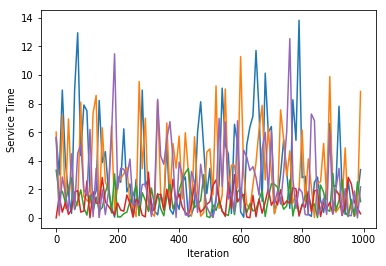

In [29]:
plt.plot(df.iloc[::10,:])
plt.xlabel("Iteration")
plt.ylabel("Service Time")
plt.show()

## Parameter Estimation

Parameter estimation is implemented using stochastic EM. The interface to this is fairly straightforward.

In [ ]:
import estimation

In [31]:
(mus, arrvlist) = estimation.sem(net, observations0, 500, 500, return_arrv=True)

SEM: Starting...
MEAN SERVICE (ALL)  [6.1782977301444957, 2.9673761901718438]
MEAN SERVICE (OBS)  [8.8905272017893395, 4.9427340688203678]
MU 0  6.17829773014  2.96737619017
SLICE 20001 0 2.7120683102 2.4217547123 -49.1850442177 -49.6471014309 0.0000000000 4.1117961754 0.0000000000 4.1117961754 
SLICE 20002 0 3.3150103006 3.4657332002 -49.1850442177 -49.4382713586 0.0000000000 5.4428572391 0.0000000000 5.4428572391 
SLICE 20003 0 47.8550653376 37.3622947789 -inf -50.4869894385 0.0000000000 58.2865977288 0.0000000000 58.2865977288 
SLICE 20003 1 47.8550653376 56.2068828023 -49.1850442177 -50.4869894385 37.3622947789 58.2865977288 0.0000000000 58.2865977288 
SLICE 20004 0 58.5394467925 33.2474323254 -inf -51.1529334857 0.0000000000 59.3804768022 0.0000000000 59.3804768022 
SLICE 20004 1 58.5394467925 58.4783708234 -49.2056267004 -51.1529334857 33.2474323254 59.3804768022 0.0000000000 59.3804768022 
SLICE 20005 0 61.7829773014 1.8866106833 -inf -49.3082366211 0.0000000000 61.9939791378 0.

SLICE 20021 0 2.9574714423 0.4324363361 -52.4932884261 -51.9755410282 0.0000000000 3.6882225598 0.0000000000 3.6882225598 
SLICE 20021 1 2.9574714423 3.6284834842 -51.6945646262 -51.9755410282 0.4324363361 3.6882225598 0.0000000000 3.6882225598 
SLICE 20022 0 5.6626364831 0.2909400522 -inf -54.6019429582 0.0000000000 8.6945979367 0.0000000000 8.6945979367 
SLICE 20022 1 5.6626364831 1.0274542647 -inf -54.6019429582 0.2909400522 8.6945979367 0.0000000000 8.6945979367 
SLICE 20022 2 5.6626364831 7.4875364852 -51.2385040625 -54.6019429582 1.0274542647 8.6945979367 0.0000000000 8.6945979367 
SLICE 20023 0 51.7891329875 14.1505184530 -inf -51.7575923862 0.0000000000 58.3728908938 0.0000000000 58.3728908938 
SLICE 20023 1 51.7891329875 21.8705422003 -inf -51.7575923862 14.1505184530 58.3728908938 0.0000000000 58.3728908938 
SLICE 20023 2 51.7891329875 34.3311945566 -inf -51.7575923862 21.8705422003 58.3728908938 0.0000000000 58.3728908938 
SLICE 20023 3 51.7891329875 42.2475390759 -inf -51.7

SLICE 20041 0 0.9546462736 5.5692718876 -inf -53.4262342737 0.0000000000 6.0399209450 0.0000000000 6.0399209450 
SLICE 20041 1 0.9546462736 0.5146666109 -52.9558499558 -53.4262342737 0.0000000000 5.5692718876 0.0000000000 6.0399209450 
SLICE 20042 0 2.9748645846 13.7884635366 -51.0952428403 -53.4297168632 0.0000000000 18.1406178216 0.0000000000 18.1406178216 
SLICE 20043 0 49.6929810515 21.0405333033 -inf -52.0775930515 0.0000000000 57.9405089584 0.0000000000 57.9405089584 
SLICE 20043 1 49.6929810515 35.3940705597 -inf -52.0775930515 21.0405333033 57.9405089584 0.0000000000 57.9405089584 
SLICE 20043 2 49.6929810515 52.8181189274 -51.0952428403 -52.0775930515 35.3940705597 57.9405089584 0.0000000000 57.9405089584 
SLICE 20044 0 57.5401586739 40.3008598336 -inf -51.2017955168 0.0000000000 60.6272811125 0.0000000000 60.6272811125 
SLICE 20044 1 57.5401586739 52.5542400521 -inf -51.2017955168 40.3008598336 60.6272811125 0.0000000000 60.6272811125 
SLICE 20044 2 57.5401586739 56.378925035

SLICE 20061 0 2.4771083779 3.3884792493 -49.7932822815 -51.0351106028 0.0000000000 3.5369568444 0.0000000000 3.5369568444 
SLICE 20062 0 14.6634315857 19.6004941378 -inf -50.0566066207 0.0000000000 20.1772537936 0.0000000000 20.1772537936 
SLICE 20062 1 14.6634315857 8.6931161370 -51.7231439573 -50.0566066207 0.0000000000 19.6004941378 0.0000000000 20.1772537936 
SLICE 20062 2 14.6634315857 15.2463716856 -inf -50.0566066207 8.6931161370 19.6004941378 0.0000000000 20.1772537936 
SLICE 20062 3 14.6634315857 14.3420932219 -49.8971526044 -50.0566066207 8.6931161370 15.2463716856 0.0000000000 20.1772537936 
SLICE 20063 0 55.8484479445 15.1897944084 -inf -52.1391595309 0.0000000000 58.2957107519 0.0000000000 58.2957107519 
SLICE 20063 1 55.8484479445 48.9921337676 -49.8971526044 -52.1391595309 15.1897944084 58.2957107519 0.0000000000 58.2957107519 
SLICE 20064 0 58.3657633455 49.1191025104 -49.9197966031 -52.9696860211 0.0000000000 59.7048112594 0.0000000000 59.7048112594 
SLICE 20065 0 65.4

SLICE 20081 0 0.4436549875 1.1203109676 -50.3306955089 -50.6492322753 0.0000000000 1.2701360824 0.0000000000 1.2701360824 
SLICE 20082 0 12.5607029044 0.0308503809 -inf -50.3369179443 0.0000000000 14.8199661348 0.0000000000 14.8199661348 
SLICE 20082 1 12.5607029044 0.6676789409 -inf -50.3369179443 0.0308503809 14.8199661348 0.0000000000 14.8199661348 
SLICE 20082 2 12.5607029044 1.8767472657 -53.7075412834 -50.3369179443 0.6676789409 14.8199661348 0.0000000000 14.8199661348 
SLICE 20082 3 12.5607029044 11.6370459551 -50.6226329871 -50.3369179443 1.8767472657 14.8199661348 0.0000000000 14.8199661348 
SLICE 20082 4 12.5607029044 12.9930583733 -50.1940422143 -50.3369179443 11.6370459551 14.8199661348 0.0000000000 14.8199661348 
SLICE 20083 0 48.4299945948 25.2211412086 -inf -52.8840511545 0.0000000000 58.3647589087 0.0000000000 58.3647589087 
SLICE 20083 1 48.4299945948 30.6249308638 -inf -52.8840511545 25.2211412086 58.3647589087 0.0000000000 58.3647589087 
SLICE 20083 2 48.4299945948 3

SLICE 20101 0 0.6713912631 1.4181177958 -50.2931696133 -50.6968649951 0.0000000000 3.7903929611 0.0000000000 3.7903929611 
SLICE 20102 0 14.5246462210 16.4506253507 -inf -52.2382645998 0.0000000000 17.3885701094 0.0000000000 17.3885701094 
SLICE 20102 1 14.5246462210 1.1793226734 -inf -52.2382645998 0.0000000000 16.4506253507 0.0000000000 17.3885701094 
SLICE 20102 2 14.5246462210 1.5032148825 -53.6568716717 -52.2382645998 1.1793226734 16.4506253507 0.0000000000 17.3885701094 
SLICE 20102 3 14.5246462210 8.2720603859 -52.2524894965 -52.2382645998 1.5032148825 16.4506253507 0.0000000000 17.3885701094 
SLICE 20102 4 14.5246462210 12.7856994595 -50.8380886365 -52.2382645998 8.2720603859 16.4506253507 0.0000000000 17.3885701094 
SLICE 20103 0 50.4858180806 21.8636025743 -inf -51.2911901459 0.0000000000 58.3465285881 0.0000000000 58.3465285881 
SLICE 20103 1 50.4858180806 52.1299192604 -50.8380886365 -51.2911901459 21.8636025743 58.3465285881 0.0000000000 58.3465285881 
SLICE 20104 0 53.175

SLICE 20127 0 14.0313167081 114.4426345000 -inf -51.8010227063 12.2448331016 137.0524249101 12.2448331016 137.0524249101 
SLICE 20127 1 14.0313167081 48.1544871781 -inf -51.8010227063 12.2448331016 114.4426345000 12.2448331016 137.0524249101 
SLICE 20127 2 14.0313167081 45.7689457525 -inf -51.8010227063 12.2448331016 48.1544871781 12.2448331016 137.0524249101 
SLICE 20127 3 14.0313167081 35.4411821942 -inf -51.8010227063 12.2448331016 45.7689457525 12.2448331016 137.0524249101 
SLICE 20127 4 14.0313167081 28.2325030466 -inf -51.8010227063 12.2448331016 35.4411821942 12.2448331016 137.0524249101 
SLICE 20127 5 14.0313167081 18.9640312436 -51.7467332243 -51.8010227063 12.2448331016 28.2325030466 12.2448331016 137.0524249101 
SLICE 20128 0 58.7404215442 84.9057446659 -inf -53.4371086547 48.9540777136 137.0524249101 48.9540777136 137.0524249101 
SLICE 20128 1 58.7404215442 58.6223203216 -51.7467332243 -53.4371086547 48.9540777136 84.9057446659 48.9540777136 137.0524249101 
SLICE 20129 0 59

SLICE 20151 0 2.8456059125 4.2584471969 -50.1074183894 -51.3197110228 0.0000000000 6.6407537090 0.0000000000 6.6407537090 
SLICE 20152 0 8.3784606617 8.3235209518 -50.1249772845 -51.3125199228 0.0000000000 8.3850878356 0.0000000000 8.3850878356 
SLICE 20153 0 47.8031326346 27.1281943389 -inf -51.2448289795 0.0000000000 58.1722465161 0.0000000000 58.1722465161 
SLICE 20153 1 47.8031326346 46.5341379124 -inf -51.2448289795 27.1281943389 58.1722465161 0.0000000000 58.1722465161 
SLICE 20153 2 47.8031326346 47.3856147628 -inf -51.2448289795 46.5341379124 58.1722465161 0.0000000000 58.1722465161 
SLICE 20153 3 47.8031326346 52.1614426328 -inf -51.2448289795 47.3856147628 58.1722465161 0.0000000000 58.1722465161 
SLICE 20153 4 47.8031326346 50.9784768015 -inf -51.2448289795 47.3856147628 52.1614426328 0.0000000000 58.1722465161 
SLICE 20153 5 47.8031326346 47.8113287931 -50.1249772845 -51.2448289795 47.3856147628 50.9784768015 0.0000000000 58.1722465161 
SLICE 20154 0 48.8204982694 22.300353

SLICE 20171 0 4.1388319642 1.2224337128 -52.4917920469 -55.4581395169 0.0000000000 4.9775574204 0.0000000000 4.9775574204 
SLICE 20172 0 8.8350566613 7.6840783852 -52.8087774221 -54.9076323667 0.0000000000 12.2298039139 0.0000000000 12.2298039139 
SLICE 20173 0 47.8216678881 48.6848371292 -inf -54.8181737256 0.0000000000 57.4570421233 0.0000000000 57.4570421233 
SLICE 20173 1 47.8216678881 33.3105089858 -inf -54.8181737256 0.0000000000 48.6848371292 0.0000000000 57.4570421233 
SLICE 20173 2 47.8216678881 35.9683847314 -inf -54.8181737256 33.3105089858 48.6848371292 0.0000000000 57.4570421233 
SLICE 20173 3 47.8216678881 47.1460933270 -inf -54.8181737256 35.9683847314 48.6848371292 0.0000000000 57.4570421233 
SLICE 20173 4 47.8216678881 47.8756607544 -52.8087774221 -54.8181737256 47.1460933270 48.6848371292 0.0000000000 57.4570421233 
SLICE 20174 0 48.2387504693 15.4174246292 -inf -53.0968498341 0.0000000000 60.5301514893 0.0000000000 60.5301514893 
SLICE 20174 1 48.2387504693 17.158756

SLICE 20190 0 71.5957830344 82.6023475593 -55.6162755271 -53.4433193086 67.8390080745 143.1915660688 67.8390080745 143.1915660688 
SLICE 20190 1 71.5957830344 73.7586163776 -53.4776140636 -53.4433193086 67.8390080745 82.6023475593 67.8390080745 143.1915660688 
SLICE 20190 2 71.5957830344 68.5000204110 -52.2059385327 -53.4433193086 67.8390080745 73.7586163776 67.8390080745 143.1915660688 
MU 19  6.78390080745  3.66583302343
SLICE 20191 0 2.7224948440 0.2559067748 -52.8089375951 -52.3547784769 0.0000000000 4.2493239977 0.0000000000 4.2493239977 
SLICE 20191 1 2.7224948440 0.2975987834 -52.7975644616 -52.3547784769 0.2559067748 4.2493239977 0.0000000000 4.2493239977 
SLICE 20191 2 2.7224948440 3.0681966022 -52.0417750404 -52.3547784769 0.2975987834 4.2493239977 0.0000000000 4.2493239977 
SLICE 20192 0 7.2189342039 1.7219401364 -inf -52.3719934177 0.0000000000 16.8122433653 0.0000000000 16.8122433653 
SLICE 20192 1 7.2189342039 3.9886643662 -52.8518529101 -52.3719934177 1.7219401364 16.812

SLICE 20208 0 57.8746121968 94.6788820719 -inf -52.0829206030 49.5293532930 129.0351548247 49.5293532930 129.0351548247 
SLICE 20208 1 57.8746121968 66.6253786689 -inf -52.0829206030 49.5293532930 94.6788820719 49.5293532930 129.0351548247 
SLICE 20208 2 57.8746121968 63.7821308611 -inf -52.0829206030 49.5293532930 66.6253786689 49.5293532930 129.0351548247 
SLICE 20208 3 57.8746121968 56.3618110900 -inf -52.0829206030 49.5293532930 63.7821308611 49.5293532930 129.0351548247 
SLICE 20208 4 57.8746121968 62.5025775077 -inf -52.0829206030 56.3618110900 63.7821308611 49.5293532930 129.0351548247 
SLICE 20208 5 57.8746121968 56.5683585538 -inf -52.0829206030 56.3618110900 62.5025775077 49.5293532930 129.0351548247 
SLICE 20208 6 57.8746121968 58.6261188181 -50.1261356874 -52.0829206030 56.5683585538 62.5025775077 49.5293532930 129.0351548247 
SLICE 20209 0 60.0268137238 58.0147783570 -inf -50.2673173393 49.8605960461 129.0351548247 49.8605960461 129.0351548247 
SLICE 20209 1 60.0268137238 

SLICE 20231 0 9.3915137219 1.1250366596 -52.4427150258 -49.6952189566 0.0000000000 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 1 9.3915137219 3.2592216321 -51.7094748683 -49.6952189566 1.1250366596 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 2 9.3915137219 5.2207394050 -51.0355578372 -49.6952189566 3.2592216321 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 3 9.3915137219 7.1791190335 -50.3627189756 -49.6952189566 5.2207394050 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 4 9.3915137219 7.7265736305 -50.1746304547 -49.6952189566 7.1791190335 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 5 9.3915137219 8.0229070120 -50.0728194411 -49.6952189566 7.7265736305 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 6 9.3915137219 8.2736500439 -49.9866718660 -49.6952189566 8.0229070120 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 7 9.3915137219 9.0332605084 -49.7256931299 -49.6952189566 8.2736500439 9.7818129003 0.0000000000 9.7818129003 
SLICE 20231 8 9.

SLICE 20251 0 7.4091524721 9.8364066694 -51.3649414244 -52.3202776961 0.0000000000 10.5143652948 0.0000000000 10.5143652948 
SLICE 20252 0 14.4476045004 6.5676376251 -inf -52.0566273944 0.0000000000 18.7918677550 0.0000000000 18.7918677550 
SLICE 20252 1 14.4476045004 14.1801631565 -51.4373756231 -52.0566273944 6.5676376251 18.7918677550 0.0000000000 18.7918677550 
SLICE 20253 0 51.7639087210 57.5307745771 -inf -52.5626915152 0.0000000000 58.6109036766 0.0000000000 58.6109036766 
SLICE 20253 1 51.7639087210 50.7886519112 -51.4373756231 -52.5626915152 0.0000000000 57.5307745771 0.0000000000 58.6109036766 
SLICE 20254 0 54.8910376679 23.4035381520 -inf -52.0002203871 0.0000000000 60.4640548512 0.0000000000 60.4640548512 
SLICE 20254 1 54.8910376679 51.8556908233 -51.4373756231 -52.0002203871 23.4035381520 60.4640548512 0.0000000000 60.4640548512 
SLICE 20255 0 66.5928768284 52.9490490602 -inf -51.7684758164 0.0000000000 73.1678172782 0.0000000000 73.1678172782 
SLICE 20255 1 66.592876828

MU 27  6.79259936966  3.16904365118
SLICE 20271 0 9.6868245169 10.4801829877 -50.4422891285 -51.1891754115 0.0000000000 10.7382086985 0.0000000000 10.7382086985 
SLICE 20272 0 14.3296097493 1.0407276118 -inf -52.4939618483 0.0000000000 20.7860089191 0.0000000000 20.7860089191 
SLICE 20272 1 14.3296097493 7.0698825935 -inf -52.4939618483 1.0407276118 20.7860089191 0.0000000000 20.7860089191 
SLICE 20272 2 14.3296097493 16.9650986069 -inf -52.4939618483 7.0698825935 20.7860089191 0.0000000000 20.7860089191 
SLICE 20272 3 14.3296097493 10.3893723728 -inf -52.4939618483 7.0698825935 16.9650986069 0.0000000000 20.7860089191 
SLICE 20272 4 14.3296097493 16.8395846962 -inf -52.4939618483 10.3893723728 16.9650986069 0.0000000000 20.7860089191 
SLICE 20272 5 14.3296097493 12.9922456702 -50.8642978561 -52.4939618483 10.3893723728 16.8395846962 0.0000000000 20.7860089191 
SLICE 20273 0 48.0709404535 26.8723235750 -inf -52.4756644341 0.0000000000 58.6440051235 0.0000000000 58.6440051235 
SLICE 202

MU 29  6.77517623693  3.34801469992
SLICE 20291 0 12.2408508303 0.3521313525 -54.7673051150 -51.6772198835 0.0000000000 17.4832545628 0.0000000000 17.4832545628 
SLICE 20291 1 12.2408508303 17.3032346602 -inf -51.6772198835 0.3521313525 17.4832545628 0.0000000000 17.4832545628 
SLICE 20291 2 12.2408508303 14.3124426119 -50.5975769296 -51.6772198835 0.3521313525 17.3032346602 0.0000000000 17.4832545628 
SLICE 20292 0 14.5057373925 8.7550818016 -inf -50.8383398500 0.0000000000 17.7164414287 0.0000000000 17.7164414287 
SLICE 20292 1 14.5057373925 13.4580525856 -inf -50.8383398500 8.7550818016 17.7164414287 0.0000000000 17.7164414287 
SLICE 20292 2 14.5057373925 17.3979846849 -inf -50.8383398500 13.4580525856 17.7164414287 0.0000000000 17.7164414287 
SLICE 20292 3 14.5057373925 15.1643141369 -inf -50.8383398500 13.4580525856 17.3979846849 0.0000000000 17.7164414287 
SLICE 20292 4 14.5057373925 13.8013538889 -inf -50.8383398500 13.4580525856 15.1643141369 0.0000000000 17.7164414287 
SLICE 2

SLICE 20310 1 73.0213264973 101.1553837179 -60.3645823803 -52.0778990410 62.8417584258 103.6014855767 62.8417584258 146.0426529945 
SLICE 20310 2 73.0213264973 69.7632055501 -50.5955589497 -52.0778990410 62.8417584258 101.1553837179 62.8417584258 146.0426529945 
MU 31  6.28417584258  3.37683388456
SLICE 20311 0 13.9601015824 13.6331885558 -50.6465430402 -50.5537825901 0.0000000000 15.5020795463 0.0000000000 15.5020795463 
SLICE 20311 1 13.9601015824 14.0342410357 -50.5277772099 -50.5537825901 13.6331885558 15.5020795463 0.0000000000 15.5020795463 
SLICE 20312 0 14.5210318945 15.1109756698 -inf -50.6414834860 0.0000000000 16.7557826767 0.0000000000 16.7557826767 
SLICE 20312 1 14.5210318945 11.0209106317 -inf -50.6414834860 0.0000000000 15.1109756698 0.0000000000 16.7557826767 
SLICE 20312 2 14.5210318945 14.0214505535 -inf -50.6414834860 11.0209106317 15.1109756698 0.0000000000 16.7557826767 
SLICE 20312 3 14.5210318945 14.7170948771 -inf -50.6414834860 14.0214505535 15.1109756698 0.00

SLICE 20331 0 12.1202498913 2.9688068921 -54.1429974495 -51.7844622047 0.0000000000 14.9397735540 0.0000000000 14.9397735540 
SLICE 20331 1 12.1202498913 12.7528804852 -51.3966035643 -51.7844622047 2.9688068921 14.9397735540 0.0000000000 14.9397735540 
SLICE 20332 0 14.3569888959 13.2793101712 -51.3966035643 -52.6256749155 0.0000000000 16.1234063417 0.0000000000 16.1234063417 
SLICE 20333 0 48.0655902069 46.5290936121 -inf -51.9001253018 0.0000000000 58.4031231161 0.0000000000 58.4031231161 
SLICE 20333 1 48.0655902069 57.2394384737 -inf -51.9001253018 46.5290936121 58.4031231161 0.0000000000 58.4031231161 
SLICE 20333 2 48.0655902069 49.2238643504 -51.3966035643 -51.9001253018 46.5290936121 57.2394384737 0.0000000000 58.4031231161 
SLICE 20334 0 50.0376908204 58.0687405552 -51.3966035643 -51.9569218066 0.0000000000 59.0490396243 0.0000000000 59.0490396243 
SLICE 20335 0 65.9921790247 10.0817797093 -inf -52.3651715466 0.0000000000 72.0481711919 0.0000000000 72.0481711919 
SLICE 20335 1

SLICE 20351 0 10.2705783959 4.5424508432 -52.2496852349 -50.5205422281 0.0000000000 13.4200155995 0.0000000000 13.4200155995 
SLICE 20351 1 10.2705783959 12.8471588646 -inf -50.5205422281 4.5424508432 13.4200155995 0.0000000000 13.4200155995 
SLICE 20351 2 10.2705783959 5.1859301717 -52.0457325790 -50.5205422281 4.5424508432 12.8471588646 0.0000000000 13.4200155995 
SLICE 20351 3 10.2705783959 8.7089725089 -50.9290940023 -50.5205422281 5.1859301717 12.8471588646 0.0000000000 13.4200155995 
SLICE 20351 4 10.2705783959 9.2442472795 -50.7594370976 -50.5205422281 8.7089725089 12.8471588646 0.0000000000 13.4200155995 
SLICE 20351 5 10.2705783959 10.2507720096 -50.4404161394 -50.5205422281 9.2442472795 12.8471588646 0.0000000000 13.4200155995 
SLICE 20352 0 12.7671950274 6.4709351009 -inf -51.7285256907 0.0000000000 13.9049210595 0.0000000000 13.9049210595 
SLICE 20352 1 12.7671950274 7.9038501987 -inf -51.7285256907 6.4709351009 13.9049210595 0.0000000000 13.9049210595 
SLICE 20352 2 12.767

SLICE 20371 0 11.4838176759 7.2013654843 -53.7475950799 -53.9895063384 0.0000000000 16.1467098857 0.0000000000 16.1467098857 
SLICE 20372 0 13.3743902549 7.7685317585 -53.7475950799 -54.4947329504 0.0000000000 21.5799973876 0.0000000000 21.5799973876 
SLICE 20373 0 48.0466113552 27.2383447708 -inf -54.0140282461 0.0000000000 58.4277037373 0.0000000000 58.4277037373 
SLICE 20373 1 48.0466113552 31.9786201283 -inf -54.0140282461 27.2383447708 58.4277037373 0.0000000000 58.4277037373 
SLICE 20373 2 48.0466113552 51.4102199614 -inf -54.0140282461 31.9786201283 58.4277037373 0.0000000000 58.4277037373 
SLICE 20373 3 48.0466113552 38.0436306506 -inf -54.0140282461 31.9786201283 51.4102199614 0.0000000000 58.4277037373 
SLICE 20373 4 48.0466113552 45.9713865524 -inf -54.0140282461 38.0436306506 51.4102199614 0.0000000000 58.4277037373 
SLICE 20373 5 48.0466113552 49.6468338471 -inf -54.0140282461 45.9713865524 51.4102199614 0.0000000000 58.4277037373 
SLICE 20373 6 48.0466113552 48.5845544819

SLICE 20394 1 53.7698557580 27.7185665454 -inf -53.6701939081 22.0569851222 59.1177147990 0.0000000000 59.1177147990 
SLICE 20394 2 53.7698557580 34.2994190122 -inf -53.6701939081 27.7185665454 59.1177147990 0.0000000000 59.1177147990 
SLICE 20394 3 53.7698557580 48.4585007349 -inf -53.6701939081 34.2994190122 59.1177147990 0.0000000000 59.1177147990 
SLICE 20394 4 53.7698557580 57.7078925906 -52.7690217561 -53.6701939081 48.4585007349 59.1177147990 0.0000000000 59.1177147990 
SLICE 20395 0 60.6408868562 41.9361025676 -inf -53.3066155991 0.0000000000 66.6411791606 0.0000000000 66.6411791606 
SLICE 20395 1 60.6408868562 44.4689977661 -inf -53.3066155991 41.9361025676 66.6411791606 0.0000000000 66.6411791606 
SLICE 20395 2 60.6408868562 65.8221481446 -52.4410225726 -53.3066155991 44.4689977661 66.6411791606 0.0000000000 66.6411791606 
SLICE 20396 0 7.5971142001 78.3605047119 -inf -53.8960465327 0.9833882729 133.2823583212 0.9833882729 133.2823583212 
SLICE 20396 1 7.5971142001 56.9948025

SLICE 20421 0 2.3098809583 0.8201676507 -54.8343435765 -55.3487837420 0.0000000000 15.9694398097 0.0000000000 15.9694398097 
SLICE 20422 0 6.8226491508 14.5128377186 -54.8343435765 -55.5873093853 0.0000000000 21.1635057054 0.0000000000 21.1635057054 
SLICE 20423 0 55.3338088713 35.3101444194 -inf -55.5568027795 0.0000000000 58.5887015045 0.0000000000 58.5887015045 
SLICE 20423 1 55.3338088713 48.9773341531 -54.8343435765 -55.5568027795 35.3101444194 58.5887015045 0.0000000000 58.5887015045 
SLICE 20424 0 56.5767967605 58.6653097797 -inf -55.1383725756 0.0000000000 59.4525942610 0.0000000000 59.4525942610 
SLICE 20424 1 56.5767967605 54.8841571697 -54.8343435765 -55.1383725756 0.0000000000 58.6653097797 0.0000000000 59.4525942610 
SLICE 20425 0 73.6049610705 11.9201788531 -inf -55.0477423248 0.0000000000 76.9610625168 0.0000000000 76.9610625168 
SLICE 20425 1 73.6049610705 32.8539784379 -inf -55.0477423248 11.9201788531 76.9610625168 0.0000000000 76.9610625168 
SLICE 20425 2 73.60496107

SLICE 20442 2 13.0785732960 16.2846908633 -inf -49.9176654979 11.2713613470 18.1083923415 0.0000000000 18.6359528613 
SLICE 20442 3 13.0785732960 11.4741803457 -inf -49.9176654979 11.2713613470 16.2846908633 0.0000000000 18.6359528613 
SLICE 20442 4 13.0785732960 16.1292861394 -inf -49.9176654979 11.4741803457 16.2846908633 0.0000000000 18.6359528613 
SLICE 20442 5 13.0785732960 11.9716652755 -inf -49.9176654979 11.4741803457 16.1292861394 0.0000000000 18.6359528613 
SLICE 20442 6 13.0785732960 14.8636679102 -inf -49.9176654979 11.9716652755 16.1292861394 0.0000000000 18.6359528613 
SLICE 20442 7 13.0785732960 13.1067576042 -49.7733157876 -49.9176654979 11.9716652755 14.8636679102 0.0000000000 18.6359528613 
SLICE 20443 0 49.4265554317 9.7098753544 -inf -50.0272463167 0.0000000000 58.9269026437 0.0000000000 58.9269026437 
SLICE 20443 1 49.4265554317 40.8398690471 -inf -50.0272463167 9.7098753544 58.9269026437 0.0000000000 58.9269026437 
SLICE 20443 2 49.4265554317 48.4562571510 -49.773

SLICE 20461 0 11.3237917471 7.1071599772 -51.3030249550 -50.2857519040 0.0000000000 14.5903225878 0.0000000000 14.5903225878 
SLICE 20461 1 11.3237917471 9.8961068715 -50.4852863926 -50.2857519040 7.1071599772 14.5903225878 0.0000000000 14.5903225878 
SLICE 20461 2 11.3237917471 11.3326062689 -50.0640948115 -50.2857519040 9.8961068715 14.5903225878 0.0000000000 14.5903225878 
SLICE 20462 0 13.4936798105 16.2494265980 -inf -50.2564753852 0.0000000000 17.0216152134 0.0000000000 17.0216152134 
SLICE 20462 1 13.4936798105 5.2755252964 -inf -50.2564753852 0.0000000000 16.2494265980 0.0000000000 17.0216152134 
SLICE 20462 2 13.4936798105 8.3639277458 -inf -50.2564753852 5.2755252964 16.2494265980 0.0000000000 17.0216152134 
SLICE 20462 3 13.4936798105 10.2328717779 -inf -50.2564753852 8.3639277458 16.2494265980 0.0000000000 17.0216152134 
SLICE 20462 4 13.4936798105 14.6784189916 -50.0382643352 -50.2564753852 10.2328717779 16.2494265980 0.0000000000 17.0216152134 
SLICE 20463 0 50.8941528273

SLICE 20481 0 6.0390785637 6.0399968992 -48.5309406537 -49.1603322872 0.0000000000 6.4958213193 0.0000000000 6.4958213193 
SLICE 20482 0 14.2075712511 6.9904867558 -51.0497068350 -50.4093110476 0.0000000000 14.9253954657 0.0000000000 14.9253954657 
SLICE 20482 1 14.2075712511 11.2304591639 -49.5699542953 -50.4093110476 6.9904867558 14.9253954657 0.0000000000 14.9253954657 
SLICE 20483 0 49.2996180581 42.5326264019 -inf -50.1327516462 0.0000000000 57.6908006636 0.0000000000 57.6908006636 
SLICE 20483 1 49.2996180581 51.9176603859 -inf -50.1327516462 42.5326264019 57.6908006636 0.0000000000 57.6908006636 
SLICE 20483 2 49.2996180581 51.1410475152 -inf -50.1327516462 42.5326264019 51.9176603859 0.0000000000 57.6908006636 
SLICE 20483 3 49.2996180581 45.8913896047 -inf -50.1327516462 42.5326264019 51.1410475152 0.0000000000 57.6908006636 
SLICE 20483 4 49.2996180581 48.3413952954 -49.5699542953 -50.1327516462 45.8913896047 51.1410475152 0.0000000000 57.6908006636 
SLICE 20484 0 49.98685864

SLICE 20499 4 58.8175003012 56.9978347101 -inf -50.5220131839 55.5499552931 65.0869136506 55.5481792711 124.1780362011 
SLICE 20499 5 58.8175003012 60.6466627868 -49.9219997483 -50.5220131839 56.9978347101 65.0869136506 55.5481792711 124.1780362011 
SLICE 20500 0 62.0890181005 102.1759495135 -62.9056613304 -50.4084365957 59.4422616287 124.1780362011 59.4422616287 124.1780362011 
SLICE 20500 1 62.0890181005 64.9717425184 -50.8556785547 -50.4084365957 59.4422616287 102.1759495135 59.4422616287 124.1780362011 
SLICE 20500 2 62.0890181005 63.5279824344 -50.3880625094 -50.4084365957 59.4422616287 64.9717425184 59.4422616287 124.1780362011 
MU 50  5.94422616287  3.48583737576
SLICE 20501 0 6.3812447803 4.8645755327 -50.7463811753 -50.6390201967 0.0000000000 8.3135001969 0.0000000000 8.3135001969 
SLICE 20501 1 6.3812447803 6.8332506415 -50.1816172760 -50.6390201967 4.8645755327 8.3135001969 0.0000000000 8.3135001969 
SLICE 20502 0 9.7995204458 5.7574726291 -inf -52.6967006085 0.0000000000 13

SLICE 20517 3 8.6700860216 13.5357941090 -50.7988071783 -49.4925043027 7.6581086076 41.4280637491 7.6581086076 128.0706124074 
SLICE 20517 4 8.6700860216 11.6979870503 -50.1761954117 -49.4925043027 7.6581086076 13.5357941090 7.6581086076 128.0706124074 
SLICE 20517 5 8.6700860216 7.9075881657 -inf -49.4925043027 7.6581086076 11.6979870503 7.6581086076 128.0706124074 
SLICE 20517 6 8.6700860216 9.0584216587 -49.2819641791 -49.4925043027 7.9075881657 11.6979870503 7.6581086076 128.0706124074 
SLICE 20518 0 58.8591697589 65.1232430884 -inf -49.8984315741 49.1938475442 128.0706124074 49.1938475442 128.0706124074 
SLICE 20518 1 58.8591697589 58.1139004028 -49.2819641791 -49.8984315741 49.1938475442 65.1232430884 49.1938475442 128.0706124074 
SLICE 20519 0 59.1295399543 62.8503946449 -inf -49.6477017441 56.7366783446 128.0706124074 56.7366783446 128.0706124074 
SLICE 20519 1 59.1295399543 59.2588667230 -49.2819641791 -49.6477017441 56.7366783446 62.8503946449 56.7366783446 128.0706124074 
SL

SLICE 20541 0 6.8654973760 2.8054782165 -51.0092587407 -49.7752809467 0.0000000000 7.1413306771 0.0000000000 7.1413306771 
SLICE 20541 1 6.8654973760 3.5464101261 -50.7815160200 -49.7752809467 2.8054782165 7.1413306771 0.0000000000 7.1413306771 
SLICE 20541 2 6.8654973760 5.3292227968 -50.2335269228 -49.7752809467 3.5464101261 7.1413306771 0.0000000000 7.1413306771 
SLICE 20541 3 6.8654973760 5.9533281357 -50.0416935761 -49.7752809467 5.3292227968 7.1413306771 0.0000000000 7.1413306771 
SLICE 20541 4 6.8654973760 6.5970098541 -49.8438429721 -49.7752809467 5.9533281357 7.1413306771 0.0000000000 7.1413306771 
SLICE 20541 5 6.8654973760 7.0117367305 -49.7163669841 -49.7752809467 6.5970098541 7.1413306771 0.0000000000 7.1413306771 
SLICE 20542 0 7.2067930764 5.6848667409 -inf -50.1376591061 0.0000000000 8.7073414695 0.0000000000 8.7073414695 
SLICE 20542 1 7.2067930764 6.4829112430 -inf -50.1376591061 5.6848667409 8.7073414695 0.0000000000 8.7073414695 
SLICE 20542 2 7.2067930764 8.0436101

SLICE 20559 0 58.9212013151 110.8163592210 -inf -51.7803527043 54.1686134275 124.0025037072 54.1686134275 124.0025037072 
SLICE 20559 1 58.9212013151 93.7934745502 -inf -51.7803527043 54.1686134275 110.8163592210 54.1686134275 124.0025037072 
SLICE 20559 2 58.9212013151 59.4009581767 -51.3764586073 -51.7803527043 54.1686134275 93.7934745502 54.1686134275 124.0025037072 
SLICE 20560 0 62.0012518536 100.8272060475 -63.9237538871 -52.6724306822 61.5079130605 124.0025037072 61.5079130605 124.0025037072 
SLICE 20560 1 62.0012518536 80.5415771340 -57.3680933451 -52.6724306822 61.5079130605 100.8272060475 61.5079130605 124.0025037072 
SLICE 20560 2 62.0012518536 71.2488058623 -54.3649695962 -52.6724306822 61.5079130605 80.5415771340 61.5079130605 124.0025037072 
SLICE 20560 3 62.0012518536 67.3920402425 -53.1185874258 -52.6724306822 61.5079130605 71.2488058623 61.5079130605 124.0025037072 
SLICE 20560 4 62.0012518536 62.6702068061 -51.5926432572 -52.6724306822 61.5079130605 67.3920402425 61.5

SLICE 20581 0 2.9424474477 0.3644885966 -50.7741965787 -50.3198128884 0.0000000000 8.2661656578 0.0000000000 8.2661656578 
SLICE 20581 1 2.9424474477 5.2919766361 -49.3323793688 -50.3198128884 0.3644885966 8.2661656578 0.0000000000 8.2661656578 
SLICE 20582 0 6.5784006385 3.6697055042 -inf -49.9902626810 0.0000000000 8.6483519360 0.0000000000 8.6483519360 
SLICE 20582 1 6.5784006385 3.7747480624 -inf -49.9902626810 3.6697055042 8.6483519360 0.0000000000 8.6483519360 
SLICE 20582 2 6.5784006385 7.5096782496 -49.3323793688 -49.9902626810 3.7747480624 8.6483519360 0.0000000000 8.6483519360 
SLICE 20583 0 48.5575341347 5.4186049304 -inf -52.6779908976 0.0000000000 58.0928939556 0.0000000000 58.0928939556 
SLICE 20583 1 48.5575341347 49.3460311697 -49.3323793688 -52.6779908976 5.4186049304 58.0928939556 0.0000000000 58.0928939556 
SLICE 20584 0 56.2507212555 41.6781522998 -inf -49.3379679211 0.0000000000 59.8936211084 0.0000000000 59.8936211084 
SLICE 20584 1 56.2507212555 45.3225630371 -in

SLICE 20599 0 59.3606033459 109.8916196036 -inf -50.8466426777 56.6277285104 127.3996461945 56.6277285104 127.3996461945 
SLICE 20599 1 59.3606033459 63.9496276146 -inf -50.8466426777 56.6277285104 109.8916196036 56.6277285104 127.3996461945 
SLICE 20599 2 59.3606033459 59.6767552257 -50.6391958377 -50.8466426777 56.6277285104 63.9496276146 56.6277285104 127.3996461945 
SLICE 20600 0 63.6998230972 70.3927589436 -52.7561617316 -53.7478091028 62.3547963427 127.3996461945 62.3547963427 127.3996461945 
MU 60  6.23547963427  4.0880949584
SLICE 20601 0 5.1010120749 5.0656637098 -52.3919924943 -56.5400396672 0.0000000000 7.4819226396 0.0000000000 7.4819226396 
SLICE 20602 0 7.3451600390 4.6650784739 -inf -54.1708078041 0.0000000000 10.9591788580 0.0000000000 10.9591788580 
SLICE 20602 1 7.3451600390 6.7223360644 -52.3919924943 -54.1708078041 4.6650784739 10.9591788580 0.0000000000 10.9591788580 
SLICE 20603 0 56.4667739027 15.9025272804 -inf -54.8816552817 0.0000000000 57.4250612327 0.0000000

MU 62  6.63197576397  3.07551618156
SLICE 20621 0 3.6604449903 2.0482427625 -50.6779605574 -51.2469711333 0.0000000000 4.0452122890 0.0000000000 4.0452122890 
SLICE 20622 0 4.5755297373 0.3566794093 -inf -51.6609706249 0.0000000000 5.4997207535 0.0000000000 5.4997207535 
SLICE 20622 1 4.5755297373 0.4355285584 -inf -51.6609706249 0.3566794093 5.4997207535 0.0000000000 5.4997207535 
SLICE 20622 2 4.5755297373 4.9864028873 -50.5443656986 -51.6609706249 0.4355285584 5.4997207535 0.0000000000 5.4997207535 
SLICE 20623 0 55.5658195797 14.6065458561 -inf -50.5631910290 0.0000000000 57.5832663471 0.0000000000 57.5832663471 
SLICE 20623 1 55.5658195797 56.8373008666 -50.5443656986 -50.5631910290 14.6065458561 57.5832663471 0.0000000000 57.5832663471 
SLICE 20624 0 57.8488426087 50.8892414395 -inf -50.7446924052 0.0000000000 58.0191488410 0.0000000000 58.0191488410 
SLICE 20624 1 57.8488426087 53.7216359496 -inf -50.7446924052 50.8892414395 58.0191488410 0.0000000000 58.0191488410 
SLICE 20624 

SLICE 20641 0 2.3306692729 0.5882149080 -49.4762084842 -49.1384677366 0.0000000000 2.4215930072 0.0000000000 2.4215930072 
SLICE 20641 1 2.3306692729 2.4031204320 -48.8848116406 -49.1384677366 0.5882149080 2.4215930072 0.0000000000 2.4215930072 
SLICE 20642 0 4.6044224971 5.9396520756 -48.4497198146 -49.4664044270 0.0000000000 6.0388114700 0.0000000000 6.0388114700 
SLICE 20643 0 47.9685029760 43.7119359133 -inf -48.8476385534 0.0000000000 57.4688895036 0.0000000000 57.4688895036 
SLICE 20643 1 47.9685029760 53.2478285515 -inf -48.8476385534 43.7119359133 57.4688895036 0.0000000000 57.4688895036 
SLICE 20643 2 47.9685029760 47.9322333041 -48.4497198146 -48.8476385534 43.7119359133 53.2478285515 0.0000000000 57.4688895036 
SLICE 20644 0 49.6739876867 56.7843460858 -48.4497198146 -48.9790072280 0.0000000000 59.2660521041 0.0000000000 59.2660521041 
SLICE 20645 0 58.6815692499 20.1103151940 -inf -49.1304092167 0.0000000000 62.9896817104 0.0000000000 62.9896817104 
SLICE 20645 1 58.6815692

SLICE 20671 0 0.6785699285 0.2849785376 -49.7471844934 -50.8802331538 0.0000000000 1.9139500428 0.0000000000 1.9139500428 
SLICE 20672 0 6.3183365912 0.3851059383 -51.2098139517 -49.9340627954 0.0000000000 7.6196759103 0.0000000000 7.6196759103 
SLICE 20672 1 6.3183365912 1.1830949998 -51.2098139517 -49.9340627954 0.3851059383 7.6196759103 0.0000000000 7.6196759103 
SLICE 20672 2 6.3183365912 3.8430489188 -50.5691896984 -49.9340627954 1.1830949998 7.6196759103 0.0000000000 7.6196759103 
SLICE 20672 3 6.3183365912 6.2915199147 -49.7560899018 -49.9340627954 3.8430489188 7.6196759103 0.0000000000 7.6196759103 
SLICE 20673 0 54.0465272942 12.3201088750 -inf -51.4073295902 0.0000000000 57.6996954091 0.0000000000 57.6996954091 
SLICE 20673 1 54.0465272942 17.8245743434 -inf -51.4073295902 12.3201088750 57.6996954091 0.0000000000 57.6996954091 
SLICE 20673 2 54.0465272942 41.3179430380 -inf -51.4073295902 17.8245743434 57.6996954091 0.0000000000 57.6996954091 
SLICE 20673 3 54.0465272942 48.7

SLICE 20691 0 1.6178129627 0.4654362500 -52.6060432159 -52.4963409906 0.0000000000 9.5107663491 0.0000000000 9.5107663491 
SLICE 20691 1 1.6178129627 6.1167500948 -51.1993373773 -52.4963409906 0.4654362500 9.5107663491 0.0000000000 9.5107663491 
SLICE 20692 0 12.5760136300 8.8935797448 -51.9623283145 -51.6935526189 0.0000000000 20.7976575727 0.0000000000 20.7976575727 
SLICE 20692 1 12.5760136300 12.7090268677 -51.1662281741 -51.6935526189 8.8935797448 20.7976575727 0.0000000000 20.7976575727 
SLICE 20693 0 49.3067090354 25.8671543899 -inf -52.3463378040 0.0000000000 59.2476092049 0.0000000000 59.2476092049 
SLICE 20693 1 49.3067090354 41.4969272497 -inf -52.3463378040 25.8671543899 59.2476092049 0.0000000000 59.2476092049 
SLICE 20693 2 49.3067090354 50.4848865552 -51.1662281741 -52.3463378040 41.4969272497 59.2476092049 0.0000000000 59.2476092049 
SLICE 20694 0 53.2391692562 31.0897634677 -inf -51.9661472723 0.0000000000 59.2605085987 0.0000000000 59.2605085987 
SLICE 20694 1 53.2391

SLICE 20711 0 10.0524900743 3.8581272363 -51.7274949308 -50.7685151676 0.0000000000 10.8605076539 0.0000000000 10.8605076539 
SLICE 20711 1 10.0524900743 4.9013064575 -51.3960230654 -50.7685151676 3.8581272363 10.8605076539 0.0000000000 10.8605076539 
SLICE 20711 2 10.0524900743 7.0322771661 -50.7189037158 -50.7685151676 4.9013064575 10.8605076539 0.0000000000 10.8605076539 
SLICE 20712 0 14.6402652707 8.2641438319 -51.9199277415 -50.7291635363 0.0000000000 18.5299031891 0.0000000000 18.5299031891 
SLICE 20712 1 14.6402652707 9.3273211973 -51.9199277415 -50.7291635363 8.2641438319 18.5299031891 0.0000000000 18.5299031891 
SLICE 20712 2 14.6402652707 12.1680530797 -51.5044530920 -50.7291635363 9.3273211973 18.5299031891 0.0000000000 18.5299031891 
SLICE 20712 3 14.6402652707 13.5930139792 -51.0516694880 -50.7291635363 12.1680530797 18.5299031891 0.0000000000 18.5299031891 
SLICE 20712 4 14.6402652707 18.0534217602 -inf -50.7291635363 13.5930139792 18.5299031891 0.0000000000 18.529903189

SLICE 20729 8 60.7508975094 60.0284539283 -50.0521167067 -50.5557641105 59.1664435485 61.4048337575 57.7450185233 132.0784849787 
SLICE 20730 0 66.0392424894 96.5047233500 -59.2357930936 -50.1726488065 65.0647669583 132.0784849787 65.0647669583 132.0784849787 
SLICE 20730 1 66.0392424894 76.1709242899 -53.1062646893 -50.1726488065 65.0647669583 96.5047233500 65.0647669583 132.0784849787 
SLICE 20730 2 66.0392424894 67.8325197517 -50.5926917308 -50.1726488065 65.0647669583 76.1709242899 65.0647669583 132.0784849787 
SLICE 20730 3 66.0392424894 67.7818125968 -50.5774062967 -50.1726488065 65.0647669583 67.8325197517 65.0647669583 132.0784849787 
SLICE 20730 4 66.0392424894 65.0900668660 -49.7659921647 -50.1726488065 65.0647669583 67.7818125968 65.0647669583 132.0784849787 
MU 73  6.50647669583  3.00096122807
SLICE 20731 0 9.3810947402 1.9136866997 -52.2056461491 -49.9321356384 0.0000000000 12.2725641177 0.0000000000 12.2725641177 
SLICE 20731 1 9.3810947402 4.1632066163 -51.4560463556 -49

SLICE 20750 2 66.5105882612 59.0989839685 -inf -52.6872398853 59.0613324369 76.1567462839 59.0613324369 133.0211765225 
SLICE 20750 3 66.5105882612 62.0523085172 -51.1385940425 -52.6872398853 59.0989839685 76.1567462839 59.0613324369 133.0211765225 
MU 75  5.90613324369  3.81090950049
SLICE 20751 0 4.8212765309 10.2105898317 -inf -52.5377957548 0.0000000000 15.0629999906 0.0000000000 15.0629999906 
SLICE 20751 1 4.8212765309 7.8317614590 -inf -52.5377957548 0.0000000000 10.2105898317 0.0000000000 15.0629999906 
SLICE 20751 2 4.8212765309 4.1893502993 -51.3044125046 -52.5377957548 0.0000000000 7.8317614590 0.0000000000 15.0629999906 
SLICE 20752 0 7.4116133489 6.2779982666 -51.3044125046 -51.9612253091 0.0000000000 20.5064361414 0.0000000000 20.5064361414 
SLICE 20753 0 48.6070675855 29.7396241798 -inf -52.5701803156 0.0000000000 57.4786105395 0.0000000000 57.4786105395 
SLICE 20753 1 48.6070675855 30.6457248620 -inf -52.5701803156 29.7396241798 57.4786105395 0.0000000000 57.4786105395 

SLICE 20771 0 1.0789935104 4.0798982309 -52.1911652292 -53.6505069355 0.0000000000 13.4292611685 0.0000000000 13.4292611685 
SLICE 20772 0 6.8307646730 9.3260440711 -52.1911652292 -54.4528970843 0.0000000000 18.0544495447 0.0000000000 18.0544495447 
SLICE 20773 0 50.8816311050 29.1871854070 -inf -54.1799209485 0.0000000000 57.7927379883 0.0000000000 57.7927379883 
SLICE 20773 1 50.8816311050 48.6111708445 -52.1911652292 -54.1799209485 29.1871854070 57.7927379883 0.0000000000 57.7927379883 
SLICE 20774 0 54.9350827147 31.4926107837 -inf -52.7890128819 0.0000000000 60.7107857870 0.0000000000 60.7107857870 
SLICE 20774 1 54.9350827147 53.5592485024 -52.1911652292 -52.7890128819 31.4926107837 60.7107857870 0.0000000000 60.7107857870 
SLICE 20775 0 59.4744184511 52.4807940557 -inf -52.9478570516 0.0000000000 65.1488498349 0.0000000000 65.1488498349 
SLICE 20775 1 59.4744184511 57.7306723950 -inf -52.9478570516 52.4807940557 65.1488498349 0.0000000000 65.1488498349 
SLICE 20775 2 59.47441845

SLICE 20789 7 60.4103348897 60.5014908806 -52.0779132254 -53.0289035374 59.7998339698 61.4927442506 56.1474699808 133.8174245461 
SLICE 20790 0 66.9087122730 96.3286403617 -59.1034580619 -53.7348889031 60.1754198143 133.8174245461 60.1754198143 133.8174245461 
SLICE 20790 1 66.9087122730 82.0184730647 -55.6861580039 -53.7348889031 60.1754198143 96.3286403617 60.1754198143 133.8174245461 
SLICE 20790 2 66.9087122730 77.8424452569 -54.6889131937 -53.7348889031 60.1754198143 82.0184730647 60.1754198143 133.8174245461 
SLICE 20790 3 66.9087122730 77.8181592006 -54.6831136290 -53.7348889031 60.1754198143 77.8424452569 60.1754198143 133.8174245461 
SLICE 20790 4 66.9087122730 60.7301934477 -inf -53.7348889031 60.1754198143 77.8181592006 60.1754198143 133.8174245461 
SLICE 20790 5 66.9087122730 75.4086752514 -54.1077234558 -53.7348889031 60.7301934477 77.8181592006 60.1754198143 133.8174245461 
SLICE 20790 6 66.9087122730 73.0518999264 -53.5449202204 -53.7348889031 60.7301934477 75.4086752514

SLICE 20811 0 9.1589076698 10.0758794006 -52.4891033927 -53.0893015133 0.0000000000 11.6287155774 0.0000000000 11.6287155774 
SLICE 20812 0 13.5834241501 12.6128004595 -52.7141837251 -52.4924779679 0.0000000000 20.0061085003 0.0000000000 20.0061085003 
SLICE 20812 1 13.5834241501 19.9224524610 -inf -52.4924779679 12.6128004595 20.0061085003 0.0000000000 20.0061085003 
SLICE 20812 2 13.5834241501 15.0200536547 -inf -52.4924779679 12.6128004595 19.9224524610 0.0000000000 20.0061085003 
SLICE 20812 3 13.5834241501 12.7512430053 -52.6820799401 -52.4924779679 12.6128004595 15.0200536547 0.0000000000 20.0061085003 
SLICE 20812 4 13.5834241501 14.7365092046 -inf -52.4924779679 12.7512430053 15.0200536547 0.0000000000 20.0061085003 
SLICE 20812 5 13.5834241501 13.8133948854 -52.4357749092 -52.4924779679 12.7512430053 14.7365092046 0.0000000000 20.0061085003 
SLICE 20813 0 55.5720406487 9.3781900022 -inf -54.8433330126 0.0000000000 59.2320306762 0.0000000000 59.2320306762 
SLICE 20813 1 55.5720

SLICE 20831 0 4.6242142581 2.1421637212 -52.8371434254 -52.1982689659 0.0000000000 10.9323970606 0.0000000000 10.9323970606 
SLICE 20831 1 4.6242142581 10.6571901466 -50.4251909122 -52.1982689659 2.1421637212 10.9323970606 0.0000000000 10.9323970606 
SLICE 20832 0 14.4549292772 2.5368566008 -inf -53.1691326937 0.0000000000 15.8213063926 0.0000000000 15.8213063926 
SLICE 20832 1 14.4549292772 9.2485993468 -inf -53.1691326937 2.5368566008 15.8213063926 0.0000000000 15.8213063926 
SLICE 20832 2 14.4549292772 13.6328058171 -50.6580642641 -53.1691326937 9.2485993468 15.8213063926 0.0000000000 15.8213063926 
SLICE 20833 0 48.3319121100 8.6847586215 -inf -51.1719169535 0.0000000000 60.0055063022 0.0000000000 60.0055063022 
SLICE 20833 1 48.3319121100 16.2252990648 -inf -51.1719169535 8.6847586215 60.0055063022 0.0000000000 60.0055063022 
SLICE 20833 2 48.3319121100 46.6159916257 -inf -51.1719169535 16.2252990648 60.0055063022 0.0000000000 60.0055063022 
SLICE 20833 3 48.3319121100 47.12620251

SLICE 20847 6 16.1813759862 15.6639285563 -51.6795526033 -54.7585933285 13.8814402600 22.5935507676 13.8752535886 144.1596107427 
SLICE 20848 0 59.2197182176 122.5521805743 -inf -51.9100308884 50.9054282465 144.1596107427 50.9054282465 144.1596107427 
SLICE 20848 1 59.2197182176 52.6807986233 -inf -51.9100308884 50.9054282465 122.5521805743 50.9054282465 144.1596107427 
SLICE 20848 2 59.2197182176 63.7492478448 -inf -51.9100308884 52.6807986233 122.5521805743 50.9054282465 144.1596107427 
SLICE 20848 3 59.2197182176 52.8737542239 -inf -51.9100308884 52.6807986233 63.7492478448 50.9054282465 144.1596107427 
SLICE 20848 4 59.2197182176 56.9252107971 -inf -51.9100308884 52.8737542239 63.7492478448 50.9054282465 144.1596107427 
SLICE 20848 5 59.2197182176 62.9249935687 -inf -51.9100308884 56.9252107971 63.7492478448 50.9054282465 144.1596107427 
SLICE 20848 6 59.2197182176 59.5314811465 -inf -51.9100308884 56.9252107971 62.9249935687 50.9054282465 144.1596107427 
SLICE 20848 7 59.219718217

SLICE 20871 0 12.0839743198 3.4292496608 -53.4765639260 -52.7823437881 0.0000000000 12.1522574626 0.0000000000 12.1522574626 
SLICE 20871 1 12.0839743198 7.7183880770 -52.0231274284 -52.7823437881 3.4292496608 12.1522574626 0.0000000000 12.1522574626 
SLICE 20872 0 14.1101860004 12.8890689336 -52.4369205823 -52.5304265682 0.0000000000 21.1388816541 0.0000000000 21.1388816541 
SLICE 20873 0 48.4331827883 38.0856359977 -inf -53.0377155164 0.0000000000 59.9976005589 0.0000000000 59.9976005589 
SLICE 20873 1 48.4331827883 45.6273037650 -inf -53.0377155164 38.0856359977 59.9976005589 0.0000000000 59.9976005589 
SLICE 20873 2 48.4331827883 51.9717872076 -52.4369205823 -53.0377155164 45.6273037650 59.9976005589 0.0000000000 59.9976005589 
SLICE 20874 0 53.0317174715 57.1507476767 -52.4369205823 -52.6184182868 0.0000000000 60.0481597386 0.0000000000 60.0481597386 
SLICE 20875 0 71.8663766199 65.2859877012 -53.7511381761 -56.5542773086 0.0000000000 73.7291820454 0.0000000000 73.7291820454 
SLIC

SLICE 20901 0 9.8381298509 8.7647757751 -51.5895934733 -51.9212563106 0.0000000000 17.9618036502 0.0000000000 17.9618036502 
SLICE 20902 0 11.2199699311 5.2500195323 -inf -51.8506164501 0.0000000000 21.5505027212 0.0000000000 21.5505027212 
SLICE 20902 1 11.2199699311 11.4992600707 -51.5895934733 -51.8506164501 5.2500195323 21.5505027212 0.0000000000 21.5505027212 
SLICE 20903 0 54.9016812073 3.4993653451 -inf -53.5601775117 0.0000000000 59.3489994031 0.0000000000 59.3489994031 
SLICE 20903 1 54.9016812073 16.3987782059 -inf -53.5601775117 3.4993653451 59.3489994031 0.0000000000 59.3489994031 
SLICE 20903 2 54.9016812073 49.2470045804 -51.5895934733 -53.5601775117 16.3987782059 59.3489994031 0.0000000000 59.3489994031 
SLICE 20904 0 55.1588292896 12.7626792900 -inf -55.0296023206 0.0000000000 60.3234758937 0.0000000000 60.3234758937 
SLICE 20904 1 55.1588292896 55.4382602954 -51.5895934733 -55.0296023206 12.7626792900 60.3234758937 0.0000000000 60.3234758937 
SLICE 20905 0 61.546191488

SLICE 20931 0 10.3637873419 7.5118727348 -52.5461045452 -53.2084817243 0.0000000000 11.2572906985 0.0000000000 11.2572906985 
SLICE 20932 0 11.9336720231 5.7346863389 -inf -52.9562897525 0.0000000000 14.4443469530 0.0000000000 14.4443469530 
SLICE 20932 1 11.9336720231 12.6167945912 -52.3598243246 -52.9562897525 5.7346863389 14.4443469530 0.0000000000 14.4443469530 
SLICE 20933 0 57.6042603653 41.3638442635 -inf -52.8070112455 0.0000000000 60.1035006404 0.0000000000 60.1035006404 
SLICE 20933 1 57.6042603653 47.6186611014 -inf -52.8070112455 41.3638442635 60.1035006404 0.0000000000 60.1035006404 
SLICE 20933 2 57.6042603653 53.6636651138 -52.4947873763 -52.8070112455 47.6186611014 60.1035006404 0.0000000000 60.1035006404 
SLICE 20934 0 57.9917117452 51.5807442909 -inf -53.1056180521 0.0000000000 60.5295758802 0.0000000000 60.5295758802 
SLICE 20934 1 57.9917117452 55.5586652793 -52.4947873763 -53.1056180521 51.5807442909 60.5295758802 0.0000000000 60.5295758802 
SLICE 20935 0 65.366159

SLICE 20951 0 6.2470671674 1.8675720770 -52.5558329198 -51.8501437520 0.0000000000 8.1746596643 0.0000000000 8.1746596643 
SLICE 20951 1 6.2470671674 5.4089959480 -51.5092806211 -51.8501437520 1.8675720770 8.1746596643 0.0000000000 8.1746596643 
SLICE 20952 0 13.1030812339 8.9513694469 -52.7361836049 -52.3178596659 0.0000000000 20.6933143655 0.0000000000 20.6933143655 
SLICE 20952 1 13.1030812339 16.3561496448 -inf -52.3178596659 8.9513694469 20.6933143655 0.0000000000 20.6933143655 
SLICE 20952 2 13.1030812339 11.1490025111 -52.0867448428 -52.3178596659 8.9513694469 16.3561496448 0.0000000000 20.6933143655 
SLICE 20953 0 55.0788193727 29.8670815418 -inf -53.0707868453 0.0000000000 57.3484725891 0.0000000000 57.3484725891 
SLICE 20953 1 55.0788193727 53.9735919927 -52.0867448428 -53.0707868453 29.8670815418 57.3484725891 0.0000000000 57.3484725891 
SLICE 20954 0 58.4670624902 27.9528991642 -inf -56.9507962979 0.0000000000 59.5191251468 0.0000000000 59.5191251468 
SLICE 20954 1 58.46706

SLICE 20991 0 5.2203191217 3.0849950950 -53.1283008490 -53.3980478863 0.0000000000 7.9463975603 0.0000000000 7.9463975603 
SLICE 20992 0 11.7679204426 2.5414189653 -inf -53.6451150278 0.0000000000 12.4708212030 0.0000000000 12.4708212030 
SLICE 20992 1 11.7679204426 10.3235495393 -53.4727901792 -53.6451150278 2.5414189653 12.4708212030 0.0000000000 12.4708212030 
SLICE 20993 0 52.4813693820 57.3534736295 -inf -54.3081021333 0.0000000000 59.4903956679 0.0000000000 59.4903956679 
SLICE 20993 1 52.4813693820 53.2526863728 -53.4727901792 -54.3081021333 0.0000000000 57.3534736295 0.0000000000 59.4903956679 
SLICE 20994 0 56.2047216523 8.7139132454 -inf -53.6477680016 0.0000000000 60.3707589208 0.0000000000 60.3707589208 
SLICE 20994 1 56.2047216523 53.4095666606 -53.4727901792 -53.6477680016 8.7139132454 60.3707589208 0.0000000000 60.3707589208 
SLICE 20995 0 62.2476421628 47.2933401949 -inf -55.1549967299 0.0000000000 73.7617277976 0.0000000000 73.7617277976 
SLICE 20995 1 62.2476421628 60

SLICE 21017 3 11.0065183128 29.4104179047 -inf -55.7410321376 6.7307907921 75.4074411500 6.7307907921 145.9662583289 
SLICE 21017 4 11.0065183128 23.7936956253 -inf -55.7410321376 6.7307907921 29.4104179047 6.7307907921 145.9662583289 
SLICE 21017 5 11.0065183128 16.3185830777 -52.6513444653 -55.7410321376 6.7307907921 23.7936956253 6.7307907921 145.9662583289 
SLICE 21018 0 58.4633509066 132.2831003972 -inf -55.3419709981 49.0161029981 145.9662583289 49.0161029981 145.9662583289 
SLICE 21018 1 58.4633509066 82.4841168870 -inf -55.3419709981 49.0161029981 132.2831003972 49.0161029981 145.9662583289 
SLICE 21018 2 58.4633509066 56.9862664393 -inf -55.3419709981 49.0161029981 82.4841168870 49.0161029981 145.9662583289 
SLICE 21018 3 58.4633509066 58.6155984601 -52.6513444653 -55.3419709981 56.9862664393 82.4841168870 49.0161029981 145.9662583289 
SLICE 21019 0 59.5187745573 117.0901839407 -inf -53.0067445293 53.2635893232 145.9662583289 53.2635893232 145.9662583289 
SLICE 21019 1 59.5187

SLICE 21038 3 58.2957873726 92.7801980645 -inf -52.3250777816 54.1140425642 101.2949958223 54.1140425642 150.9172470276 
SLICE 21038 4 58.2957873726 69.3209507549 -inf -52.3250777816 54.1140425642 92.7801980645 54.1140425642 150.9172470276 
SLICE 21038 5 58.2957873726 60.9603137825 -inf -52.3250777816 54.1140425642 69.3209507549 54.1140425642 150.9172470276 
SLICE 21038 6 58.2957873726 55.6873681295 -inf -52.3250777816 54.1140425642 60.9603137825 54.1140425642 150.9172470276 
SLICE 21038 7 58.2957873726 55.7418473237 -inf -52.3250777816 55.6873681295 60.9603137825 54.1140425642 150.9172470276 
SLICE 21038 8 58.2957873726 60.7827642647 -inf -52.3250777816 55.7418473237 60.9603137825 54.1140425642 150.9172470276 
SLICE 21038 9 58.2957873726 59.8328312237 -inf -52.3250777816 55.7418473237 60.7827642647 54.1140425642 150.9172470276 
SLICE 21038 10 58.2957873726 58.8613337076 -52.0375740896 -52.3250777816 55.7418473237 59.8328312237 54.1140425642 150.9172470276 
SLICE 21039 0 58.9342238466 

SLICE 21061 0 6.1127250562 6.3728157960 -53.2652343248 -54.7966487903 0.0000000000 7.3423564647 0.0000000000 7.3423564647 
SLICE 21062 0 6.7070089464 4.8347770719 -inf -54.4900128053 0.0000000000 10.7497728492 0.0000000000 10.7497728492 
SLICE 21062 1 6.7070089464 7.8060339432 -53.1248480004 -54.4900128053 4.8347770719 10.7497728492 0.0000000000 10.7497728492 
SLICE 21063 0 50.4185923610 28.7704935915 -inf -54.8455531906 0.0000000000 58.7623826758 0.0000000000 58.7623826758 
SLICE 21063 1 50.4185923610 55.3109737680 -inf -54.8455531906 28.7704935915 58.7623826758 0.0000000000 58.7623826758 
SLICE 21063 2 50.4185923610 35.3432491047 -inf -54.8455531906 28.7704935915 55.3109737680 0.0000000000 58.7623826758 
SLICE 21063 3 50.4185923610 46.7257098312 -inf -54.8455531906 35.3432491047 55.3109737680 0.0000000000 58.7623826758 
SLICE 21063 4 50.4185923610 51.1754769762 -53.1248480004 -54.8455531906 46.7257098312 55.3109737680 0.0000000000 58.7623826758 
SLICE 21064 0 53.2780972669 41.8909013

SLICE 21091 0 4.9719508826 0.9742564250 -55.1722391335 -54.2598009750 0.0000000000 9.4444877363 0.0000000000 9.4444877363 
SLICE 21091 1 4.9719508826 1.6568476179 -54.9879590984 -54.2598009750 0.9742564250 9.4444877363 0.0000000000 9.4444877363 
SLICE 21091 2 4.9719508826 5.3145621636 -54.0004811292 -54.2598009750 1.6568476179 9.4444877363 0.0000000000 9.4444877363 
SLICE 21092 0 10.6907663341 17.5867553613 -inf -54.4055399715 0.0000000000 18.1342336531 0.0000000000 18.1342336531 
SLICE 21092 1 10.6907663341 4.2533432731 -inf -54.4055399715 0.0000000000 17.5867553613 0.0000000000 18.1342336531 
SLICE 21092 2 10.6907663341 14.0403702298 -53.0961841943 -54.4055399715 4.2533432731 17.5867553613 0.0000000000 18.1342336531 
SLICE 21093 0 48.1938582206 9.7609399818 -inf -53.2774282056 0.0000000000 59.0481143849 0.0000000000 59.0481143849 
SLICE 21093 1 48.1938582206 44.9367301102 -inf -53.2774282056 9.7609399818 59.0481143849 0.0000000000 59.0481143849 
SLICE 21093 2 48.1938582206 58.5139888

SLICE 21111 0 8.9950368310 10.2059012177 -53.3610334987 -54.0322135315 0.0000000000 10.4028913039 0.0000000000 10.4028913039 
SLICE 21112 0 13.8083859380 4.7692570990 -inf -53.5620007664 0.0000000000 15.9616695169 0.0000000000 15.9616695169 
SLICE 21112 1 13.8083859380 11.7302360731 -53.9643878281 -53.5620007664 4.7692570990 15.9616695169 0.0000000000 15.9616695169 
SLICE 21112 2 13.8083859380 11.7920063325 -53.9464539177 -53.5620007664 11.7302360731 15.9616695169 0.0000000000 15.9616695169 
SLICE 21112 3 13.8083859380 15.0808207423 -inf -53.5620007664 11.7920063325 15.9616695169 0.0000000000 15.9616695169 
SLICE 21112 4 13.8083859380 12.9795413852 -53.6016739635 -53.5620007664 11.7920063325 15.0808207423 0.0000000000 15.9616695169 
SLICE 21112 5 13.8083859380 14.5097514742 -53.1574043285 -53.5620007664 12.9795413852 15.0808207423 0.0000000000 15.9616695169 
SLICE 21113 0 50.0818323831 50.2602284597 -53.1574043285 -53.4946647404 0.0000000000 58.0106644485 0.0000000000 58.0106644485 
SL

SLICE 21129 5 60.6992543186 61.6240831600 -inf -53.7261436832 58.2368297500 64.5550127035 58.2368297500 182.1519080380 
SLICE 21129 6 60.6992543186 58.7125976988 -inf -53.7261436832 58.2368297500 61.6240831600 58.2368297500 182.1519080380 
SLICE 21129 7 60.6992543186 59.5148627132 -53.6625694012 -53.7261436832 58.7125976988 61.6240831600 58.2368297500 182.1519080380 
SLICE 21130 0 91.0759540190 134.5457741751 -65.8070454738 -53.7311054402 89.2647914452 182.1519080380 89.2647914452 182.1519080380 
SLICE 21130 1 91.0759540190 111.2309655821 -59.2934198347 -53.7311054402 89.2647914452 134.5457741751 89.2647914452 182.1519080380 
SLICE 21130 2 91.0759540190 100.4527342926 -56.2822278967 -53.7311054402 89.2647914452 111.2309655821 89.2647914452 182.1519080380 
SLICE 21130 3 91.0759540190 93.7964324016 -54.4226089989 -53.7311054402 89.2647914452 100.4527342926 89.2647914452 182.1519080380 
SLICE 21130 4 91.0759540190 91.9704431324 -53.9124692535 -53.7311054402 89.2647914452 93.7964324016 89.

SLICE 21149 0 57.9769551864 161.1504252329 -inf -54.0975736923 52.0234236474 178.0372017732 52.0234236474 178.0372017732 
SLICE 21149 1 57.9769551864 105.1578977257 -inf -54.0975736923 52.0234236474 161.1504252329 52.0234236474 178.0372017732 
SLICE 21149 2 57.9769551864 55.3170136095 -inf -54.0975736923 52.0234236474 105.1578977257 52.0234236474 178.0372017732 
SLICE 21149 3 57.9769551864 84.6147131591 -inf -54.0975736923 55.3170136095 105.1578977257 52.0234236474 178.0372017732 
SLICE 21149 4 57.9769551864 80.1150972824 -inf -54.0975736923 55.3170136095 84.6147131591 52.0234236474 178.0372017732 
SLICE 21149 5 57.9769551864 58.3759595872 -53.3480633730 -54.0975736923 55.3170136095 80.1150972824 52.0234236474 178.0372017732 
SLICE 21150 0 89.0186008866 109.8432367951 -59.6037615037 -54.4561608876 85.0597209913 178.0372017732 85.0597209913 178.0372017732 
SLICE 21150 1 89.0186008866 109.4886895778 -59.4972559026 -54.4561608876 85.0597209913 109.8432367951 85.0597209913 178.0372017732 


SLICE 21169 1 60.2960270213 56.0441248982 -inf -53.7780228035 53.8178153410 81.0600685062 53.8178153410 179.4229169092 
SLICE 21169 2 60.2960270213 72.8325477707 -inf -53.7780228035 56.0441248982 81.0600685062 53.8178153410 179.4229169092 
SLICE 21169 3 60.2960270213 64.2410681027 -inf -53.7780228035 56.0441248982 72.8325477707 53.8178153410 179.4229169092 
SLICE 21169 4 60.2960270213 63.0644834455 -inf -53.7780228035 56.0441248982 64.2410681027 53.8178153410 179.4229169092 
SLICE 21169 5 60.2960270213 61.5107091356 -inf -53.7780228035 56.0441248982 63.0644834455 53.8178153410 179.4229169092 
SLICE 21169 6 60.2960270213 61.2928329124 -inf -53.7780228035 56.0441248982 61.5107091356 53.8178153410 179.4229169092 
SLICE 21169 7 60.2960270213 60.6652189822 -53.3660226566 -53.7780228035 56.0441248982 61.2928329124 53.8178153410 179.4229169092 
SLICE 21170 0 89.7114584546 147.4324149533 -72.5094690730 -57.5679707424 88.4378664741 179.4229169092 88.4378664741 179.4229169092 
SLICE 21170 1 89.7

SLICE 21191 0 2.1792926987 5.8789479847 -53.3549411003 -55.1685743436 0.0000000000 6.6987282492 0.0000000000 6.6987282492 
SLICE 21192 0 14.4642964403 1.4343023012 -inf -53.7064324712 0.0000000000 15.0867135661 0.0000000000 15.0867135661 
SLICE 21192 1 14.4642964403 4.7893057628 -inf -53.7064324712 1.4343023012 15.0867135661 0.0000000000 15.0867135661 
SLICE 21192 2 14.4642964403 5.5865282745 -inf -53.7064324712 4.7893057628 15.0867135661 0.0000000000 15.0867135661 
SLICE 21192 3 14.4642964403 14.4859457351 -53.3489310315 -53.7064324712 5.5865282745 15.0867135661 0.0000000000 15.0867135661 
SLICE 21193 0 51.7289122788 37.7980870467 -inf -53.9696487606 0.0000000000 59.5440253886 0.0000000000 59.5440253886 
SLICE 21193 1 51.7289122788 57.4722479405 -inf -53.9696487606 37.7980870467 59.5440253886 0.0000000000 59.5440253886 
SLICE 21193 2 51.7289122788 38.1796397068 -inf -53.9696487606 37.7980870467 57.4722479405 0.0000000000 59.5440253886 
SLICE 21193 3 51.7289122788 41.6655798229 -inf -5

SLICE 21211 0 2.5515113685 6.3162955351 -54.7945233414 -55.7371232486 0.0000000000 8.3868385882 0.0000000000 8.3868385882 
SLICE 21212 0 14.1899145585 0.1229707940 -inf -55.3040635457 0.0000000000 15.4912283674 0.0000000000 15.4912283674 
SLICE 21212 1 14.1899145585 1.5237522872 -inf -55.3040635457 0.1229707940 15.4912283674 0.0000000000 15.4912283674 
SLICE 21212 2 14.1899145585 14.1580705489 -54.8020868198 -55.3040635457 1.5237522872 15.4912283674 0.0000000000 15.4912283674 
SLICE 21213 0 48.4522559147 19.1314411627 -inf -57.1878988567 0.0000000000 59.8408393888 0.0000000000 59.8408393888 
SLICE 21213 1 48.4522559147 33.1784930696 -inf -57.1878988567 19.1314411627 59.8408393888 0.0000000000 59.8408393888 
SLICE 21213 2 48.4522559147 47.8006020488 -54.8020868198 -57.1878988567 33.1784930696 59.8408393888 0.0000000000 59.8408393888 
SLICE 21214 0 53.3836174325 7.7325552482 -inf -56.3820737416 0.0000000000 60.3164772774 0.0000000000 60.3164772774 
SLICE 21214 1 53.3836174325 48.50666004

SLICE 21226 3 10.8284450241 9.7327371046 -52.4963034595 -53.4956951116 9.3997580609 17.5244023522 9.3997580609 175.5157845286 
SLICE 21227 0 17.4177746289 149.6927300967 -inf -52.8928072749 14.2497235245 175.5157845286 14.2497235245 175.5157845286 
SLICE 21227 1 17.4177746289 18.5139974807 -52.4963034595 -52.8928072749 14.2497235245 149.6927300967 14.2497235245 175.5157845286 
SLICE 21228 0 58.9017762149 132.2252527304 -inf -53.4004909172 47.9189563878 175.5157845286 47.9189563878 175.5157845286 
SLICE 21228 1 58.9017762149 119.2803904473 -inf -53.4004909172 47.9189563878 132.2252527304 47.9189563878 175.5157845286 
SLICE 21228 2 58.9017762149 99.2608959025 -inf -53.4004909172 47.9189563878 119.2803904473 47.9189563878 175.5157845286 
SLICE 21228 3 58.9017762149 63.4362141553 -inf -53.4004909172 47.9189563878 99.2608959025 47.9189563878 175.5157845286 
SLICE 21228 4 58.9017762149 59.0984544006 -inf -53.4004909172 47.9189563878 63.4362141553 47.9189563878 175.5157845286 
SLICE 21228 5 5

SLICE 21247 2 18.5409628289 14.6109269571 -54.0904569045 -54.1691040613 12.4407440321 43.4879553266 12.4407440321 181.2979565370 
SLICE 21248 0 58.7475759806 147.3236615583 -inf -54.1323876747 49.2568928212 181.2979565370 49.2568928212 181.2979565370 
SLICE 21248 1 58.7475759806 80.8204464572 -inf -54.1323876747 49.2568928212 147.3236615583 49.2568928212 181.2979565370 
SLICE 21248 2 58.7475759806 65.1890280234 -inf -54.1323876747 49.2568928212 80.8204464572 49.2568928212 181.2979565370 
SLICE 21248 3 58.7475759806 50.2064325907 -inf -54.1323876747 49.2568928212 65.1890280234 49.2568928212 181.2979565370 
SLICE 21248 4 58.7475759806 51.9244777288 -inf -54.1323876747 50.2064325907 65.1890280234 49.2568928212 181.2979565370 
SLICE 21248 5 58.7475759806 57.7450284683 -54.0904569045 -54.1323876747 51.9244777288 65.1890280234 49.2568928212 181.2979565370 
SLICE 21249 0 60.5553299419 175.9333083091 -inf -56.7580514741 50.9131230399 181.2979565370 50.9131230399 181.2979565370 
SLICE 21249 1 6

SLICE 21262 1 12.1844640110 9.5161628983 -55.9615514405 -56.0259639597 0.0000000000 15.6167708982 0.0000000000 17.9934014005 
SLICE 21263 0 50.0219323820 51.2400486248 -55.9615514405 -56.3028882746 0.0000000000 57.7665140954 0.0000000000 57.7665140954 
SLICE 21264 0 57.2852171932 42.9677598489 -inf -56.9837541801 0.0000000000 58.4802185390 0.0000000000 58.4802185390 
SLICE 21264 1 57.2852171932 49.6406468490 -inf -56.9837541801 42.9677598489 58.4802185390 0.0000000000 58.4802185390 
SLICE 21264 2 57.2852171932 52.1878238862 -55.9615514405 -56.9837541801 49.6406468490 58.4802185390 0.0000000000 58.4802185390 
SLICE 21265 0 91.2530107098 26.6423899494 -inf -57.8123197948 0.0000000000 92.9176233644 0.0000000000 92.9176233644 
SLICE 21265 1 91.2530107098 68.1391796133 -60.6583487747 -57.8123197948 26.6423899494 92.9176233644 0.0000000000 92.9176233644 
SLICE 21265 2 91.2530107098 78.2895518737 -58.5957637720 -57.8123197948 68.1391796133 92.9176233644 0.0000000000 92.9176233644 
SLICE 21265

SLICE 21278 7 57.6912268584 58.5747625092 -53.5410173767 -56.0038042748 50.0359443109 65.9929011378 47.8715377421 176.5661599459 
SLICE 21279 0 60.2058492851 156.5334793074 -inf -54.2217650725 47.9396316291 176.5661599459 47.9396316291 176.5661599459 
SLICE 21279 1 60.2058492851 102.5204500074 -inf -54.2217650725 47.9396316291 156.5334793074 47.9396316291 176.5661599459 
SLICE 21279 2 60.2058492851 91.9054016676 -inf -54.2217650725 47.9396316291 102.5204500074 47.9396316291 176.5661599459 
SLICE 21279 3 60.2058492851 80.7458347129 -inf -54.2217650725 47.9396316291 91.9054016676 47.9396316291 176.5661599459 
SLICE 21279 4 60.2058492851 79.0650828831 -inf -54.2217650725 47.9396316291 80.7458347129 47.9396316291 176.5661599459 
SLICE 21279 5 60.2058492851 71.6291576839 -inf -54.2217650725 47.9396316291 79.0650828831 47.9396316291 176.5661599459 
SLICE 21279 6 60.2058492851 66.7582388309 -inf -54.2217650725 47.9396316291 71.6291576839 47.9396316291 176.5661599459 
SLICE 21279 7 60.20584928

SLICE 21296 3 4.3265228498 6.6544288453 -51.8362606287 -51.3069509579 3.9601128279 11.6189845710 3.9601128279 160.4229059877 
SLICE 21296 4 4.3265228498 4.9957911744 -51.3255223761 -51.3069509579 3.9601128279 6.6544288453 3.9601128279 160.4229059877 
SLICE 21296 5 4.3265228498 4.6747792718 -51.2266743509 -51.3069509579 3.9601128279 4.9957911744 3.9601128279 160.4229059877 
SLICE 21297 0 8.0244436594 101.5622118872 -inf -51.3920469451 7.1681688903 160.4229059877 7.1681688903 160.4229059877 
SLICE 21297 1 8.0244436594 40.2853832068 -inf -51.3920469451 7.1681688903 101.5622118872 7.1681688903 160.4229059877 
SLICE 21297 2 8.0244436594 38.0575550904 -inf -51.3920469451 7.1681688903 40.2853832068 7.1681688903 160.4229059877 
SLICE 21297 3 8.0244436594 13.6761791063 -52.9669926477 -51.3920469451 7.1681688903 38.0575550904 7.1681688903 160.4229059877 
SLICE 21297 4 8.0244436594 13.5998387076 -52.9434854270 -51.3920469451 7.1681688903 13.6761791063 7.1681688903 160.4229059877 
SLICE 21297 5 8.

SLICE 21311 0 4.4197878021 5.1831924852 -51.9919948037 -52.8280369254 0.0000000000 5.2112599506 0.0000000000 5.2112599506 
SLICE 21312 0 7.7885082491 1.3799105120 -inf -52.9633326605 0.0000000000 10.5745817019 0.0000000000 10.5745817019 
SLICE 21312 1 7.7885082491 5.6373225017 -52.6925232692 -52.9633326605 1.3799105120 10.5745817019 0.0000000000 10.5745817019 
SLICE 21313 0 51.0462786617 49.4505405319 -52.6925232692 -54.7863319598 0.0000000000 59.8254555085 0.0000000000 59.8254555085 
SLICE 21314 0 56.5174036464 54.9593926868 -52.6925232692 -52.8315694403 0.0000000000 60.7605775797 0.0000000000 60.7605775797 
SLICE 21315 0 81.8350130693 81.1299364051 -52.8359714767 -53.0779671397 0.0000000000 81.9806891738 0.0000000000 81.9806891738 
SLICE 21316 0 5.2112599506 157.2179046377 -inf -53.6516191683 5.1831924852 163.9613783476 5.1831924852 163.9613783476 
SLICE 21316 1 5.2112599506 135.4831270827 -inf -53.6516191683 5.1831924852 157.2179046377 5.1831924852 163.9613783476 
SLICE 21316 2 5.21

SLICE 21331 0 5.2029558939 6.6655225274 -inf -53.1143876951 0.0000000000 7.2761010629 0.0000000000 7.2761010629 
SLICE 21331 1 5.2029558939 5.2202564124 -52.4393791683 -53.1143876951 0.0000000000 6.6655225274 0.0000000000 7.2761010629 
SLICE 21332 0 5.4353747333 4.4260723371 -inf -52.7730788349 0.0000000000 8.6051410344 0.0000000000 8.6051410344 
SLICE 21332 1 5.4353747333 5.5687993361 -52.4393791683 -52.7730788349 4.4260723371 8.6051410344 0.0000000000 8.6051410344 
SLICE 21333 0 52.0676052691 51.0876972129 -52.4393791683 -52.5218026631 0.0000000000 57.8297710305 0.0000000000 57.8297710305 
SLICE 21334 0 56.9281918351 41.8598494838 -inf -56.0618756745 0.0000000000 59.0018917730 0.0000000000 59.0018917730 
SLICE 21334 1 56.9281918351 56.4739452620 -52.4393791683 -56.0618756745 41.8598494838 59.0018917730 0.0000000000 59.0018917730 
SLICE 21335 0 81.3884045773 5.3086886393 -inf -52.7274444148 0.0000000000 82.5151591425 0.0000000000 82.5151591425 
SLICE 21335 1 81.3884045773 75.717715034

SLICE 21351 0 5.3120570636 4.8942282639 -53.0917824048 -53.6365223155 0.0000000000 7.1336357043 0.0000000000 7.1336357043 
SLICE 21352 0 7.9296077018 1.0589482395 -inf -53.6704413691 0.0000000000 9.4982901542 0.0000000000 9.4982901542 
SLICE 21352 1 7.9296077018 3.6723781588 -inf -53.6704413691 1.0589482395 9.4982901542 0.0000000000 9.4982901542 
SLICE 21352 2 7.9296077018 5.8058780115 -53.3287745823 -53.6704413691 3.6723781588 9.4982901542 0.0000000000 9.4982901542 
SLICE 21353 0 53.8017897606 56.0225818471 -53.3287745823 -53.4985117510 0.0000000000 59.1257961437 0.0000000000 59.1257961437 
SLICE 21354 0 56.2652857249 59.0270996576 -inf -56.5489147444 0.0000000000 60.7829977480 0.0000000000 60.7829977480 
SLICE 21354 1 56.2652857249 4.4299323718 -inf -56.5489147444 0.0000000000 59.0270996576 0.0000000000 60.7829977480 
SLICE 21354 2 56.2652857249 54.5001591708 -inf -56.5489147444 4.4299323718 59.0270996576 0.0000000000 60.7829977480 
SLICE 21354 3 56.2652857249 56.5691115865 -53.32877

SLICE 21371 0 5.0756616915 2.8854239051 -54.2882714777 -55.1368413739 0.0000000000 5.7447452904 0.0000000000 5.7447452904 
SLICE 21372 0 5.8402245551 8.0716558407 -53.6213599924 -54.9263755266 0.0000000000 11.5546669687 0.0000000000 11.5546669687 
SLICE 21373 0 50.2808149390 6.6586680772 -inf -53.8866834598 0.0000000000 59.1632072995 0.0000000000 59.1632072995 
SLICE 21373 1 50.2808149390 57.2779681108 -inf -53.8866834598 6.6586680772 59.1632072995 0.0000000000 59.1632072995 
SLICE 21373 2 50.2808149390 54.4649412429 -53.6213599924 -53.8866834598 6.6586680772 57.2779681108 0.0000000000 59.1632072995 
SLICE 21374 0 56.5696519888 55.9039452351 -53.6213599924 -53.7453419422 0.0000000000 60.2127907198 0.0000000000 60.2127907198 
SLICE 21375 0 86.3329290051 51.3492214180 -inf -53.6690219621 0.0000000000 86.4237649323 0.0000000000 86.4237649323 
SLICE 21375 1 86.3329290051 62.4922939318 -57.9851727851 -53.6690219621 51.3492214180 86.4237649323 0.0000000000 86.4237649323 
SLICE 21375 2 86.332

SLICE 21391 0 2.9974628172 5.1470538259 -53.1295676083 -56.0387994183 0.0000000000 6.1342726840 0.0000000000 6.1342726840 
SLICE 21392 0 5.8597754965 9.5309029552 -52.1363338883 -53.1448083480 0.0000000000 9.7434539672 0.0000000000 9.7434539672 
SLICE 21393 0 49.7481840087 22.1982444947 -inf -52.5117095083 0.0000000000 57.6694653198 0.0000000000 57.6694653198 
SLICE 21393 1 49.7481840087 26.8046050111 -inf -52.5117095083 22.1982444947 57.6694653198 0.0000000000 57.6694653198 
SLICE 21393 2 49.7481840087 40.6574170829 -inf -52.5117095083 26.8046050111 57.6694653198 0.0000000000 57.6694653198 
SLICE 21393 3 49.7481840087 49.7705850117 -52.1363338883 -52.5117095083 40.6574170829 57.6694653198 0.0000000000 57.6694653198 
SLICE 21394 0 58.2061835769 9.0910968292 -inf -55.6009856890 0.0000000000 58.2999842220 0.0000000000 58.2999842220 
SLICE 21394 1 58.2061835769 26.1614449459 -inf -55.6009856890 9.0910968292 58.2999842220 0.0000000000 58.2999842220 
SLICE 21394 2 58.2061835769 56.237438073

SLICE 21411 0 8.6255256858 1.1638186722 -55.2136821824 -53.9609385153 0.0000000000 10.1073855132 0.0000000000 10.1073855132 
SLICE 21411 1 8.6255256858 6.2684029153 -53.7050710192 -53.9609385153 1.1638186722 10.1073855132 0.0000000000 10.1073855132 
SLICE 21412 0 9.9878781506 6.1014012705 -inf -54.1105149688 0.0000000000 11.1506133288 0.0000000000 11.1506133288 
SLICE 21412 1 9.9878781506 8.1681892692 -53.7050710192 -54.1105149688 6.1014012705 11.1506133288 0.0000000000 11.1506133288 
SLICE 21413 0 53.2305687376 38.6196677725 -inf -53.9349060969 0.0000000000 57.1317709158 0.0000000000 57.1317709158 
SLICE 21413 1 53.2305687376 49.3385405151 -53.7050710192 -53.9349060969 38.6196677725 57.1317709158 0.0000000000 57.1317709158 
SLICE 21414 0 57.6256181541 43.1426573355 -inf -56.2111614282 0.0000000000 58.7204017846 0.0000000000 58.7204017846 
SLICE 21414 1 57.6256181541 53.4619672963 -53.8510228580 -56.2111614282 43.1426573355 58.7204017846 0.0000000000 58.7204017846 
SLICE 21415 0 80.196

SLICE 21431 0 1.7335849713 0.6105389129 -54.3521740798 -55.7393867476 0.0000000000 10.1149709244 0.0000000000 10.1149709244 
SLICE 21432 0 4.3371003862 14.3626400852 -53.4867173184 -54.8056088000 0.0000000000 20.6040999648 0.0000000000 20.6040999648 
SLICE 21433 0 52.0397153430 42.5293724628 -inf -55.3634072640 0.0000000000 58.3882522264 0.0000000000 58.3882522264 
SLICE 21433 1 52.0397153430 42.7858092323 -inf -55.3634072640 42.5293724628 58.3882522264 0.0000000000 58.3882522264 
SLICE 21433 2 52.0397153430 43.2105611726 -inf -55.3634072640 42.7858092323 58.3882522264 0.0000000000 58.3882522264 
SLICE 21433 3 52.0397153430 46.4351055803 -inf -55.3634072640 43.2105611726 58.3882522264 0.0000000000 58.3882522264 
SLICE 21433 4 52.0397153430 55.2837303164 -53.4867173184 -55.3634072640 46.4351055803 58.3882522264 0.0000000000 58.3882522264 
SLICE 21434 0 55.7437919482 50.6613514411 -inf -54.3088978204 0.0000000000 58.9788468370 0.0000000000 58.9788468370 
SLICE 21434 1 55.7437919482 53.11

SLICE 21451 0 1.0940647069 0.0779561171 -52.2504446577 -53.3694994325 0.0000000000 2.1560276265 0.0000000000 2.1560276265 
SLICE 21452 0 13.9721281119 9.7772206098 -53.5368376340 -52.4022995051 0.0000000000 15.4350465062 0.0000000000 15.4350465062 
SLICE 21452 1 13.9721281119 11.5910329982 -52.9806214324 -52.4022995051 9.7772206098 15.4350465062 0.0000000000 15.4350465062 
SLICE 21452 2 13.9721281119 13.0583607825 -52.5306567658 -52.4022995051 11.5910329982 15.4350465062 0.0000000000 15.4350465062 
SLICE 21452 3 13.9721281119 14.1582583969 -52.1933667146 -52.4022995051 13.0583607825 15.4350465062 0.0000000000 15.4350465062 
SLICE 21453 0 48.4483268692 34.1033014316 -inf -52.6594079012 0.0000000000 58.0114650374 0.0000000000 58.0114650374 
SLICE 21453 1 48.4483268692 34.6877357905 -inf -52.6594079012 34.1033014316 58.0114650374 0.0000000000 58.0114650374 
SLICE 21453 2 48.4483268692 53.5000003071 -inf -52.6594079012 34.6877357905 58.0114650374 0.0000000000 58.0114650374 
SLICE 21453 3 4

SLICE 21471 0 0.1042884544 0.1897928089 -50.1294068086 -50.4333416278 0.0000000000 1.1116208663 0.0000000000 1.1116208663 
SLICE 21472 0 11.5847334707 11.2949674203 -50.2174471615 -50.2484344867 0.0000000000 16.1592695449 0.0000000000 16.1592695449 
SLICE 21473 0 47.7953313413 9.6942337507 -inf -52.0977282856 0.0000000000 59.3944550348 0.0000000000 59.3944550348 
SLICE 21473 1 47.7953313413 56.2667266252 -inf -52.0977282856 9.6942337507 59.3944550348 0.0000000000 59.3944550348 
SLICE 21473 2 47.7953313413 25.7297647722 -inf -52.0977282856 9.6942337507 56.2667266252 0.0000000000 59.3944550348 
SLICE 21473 3 47.7953313413 37.9130154063 -inf -52.0977282856 25.7297647722 56.2667266252 0.0000000000 59.3944550348 
SLICE 21473 4 47.7953313413 46.1533842707 -inf -52.0977282856 37.9130154063 56.2667266252 0.0000000000 59.3944550348 
SLICE 21473 5 47.7953313413 54.8457305794 -inf -52.0977282856 46.1533842707 56.2667266252 0.0000000000 59.3944550348 
SLICE 21473 6 47.7953313413 54.6238670832 -inf

SLICE 21487 0 20.5517244146 102.9557819226 -inf -50.0495118185 11.4608984909 127.3606192721 11.4608984909 127.3606192721 
SLICE 21487 1 20.5517244146 85.5236043140 -inf -50.0495118185 11.4608984909 102.9557819226 11.4608984909 127.3606192721 
SLICE 21487 2 20.5517244146 75.3328275379 -inf -50.0495118185 11.4608984909 85.5236043140 11.4608984909 127.3606192721 
SLICE 21487 3 20.5517244146 27.8376932905 -inf -50.0495118185 11.4608984909 75.3328275379 11.4608984909 127.3606192721 
SLICE 21487 4 20.5517244146 27.6974533659 -inf -50.0495118185 11.4608984909 27.8376932905 11.4608984909 127.3606192721 
SLICE 21487 5 20.5517244146 13.0935295221 -49.4116075003 -50.0495118185 11.4608984909 27.6974533659 11.4608984909 127.3606192721 
SLICE 21488 0 57.4687669175 62.1076835418 -inf -50.2578367911 49.0868609566 127.3606192721 49.0868609566 127.3606192721 
SLICE 21488 1 57.4687669175 58.0444419139 -inf -50.2578367911 49.0868609566 62.1076835418 49.0868609566 127.3606192721 
SLICE 21488 2 57.468766917

SLICE 21511 0 4.3891810807 3.1066059020 -53.1595836263 -55.0402948026 0.0000000000 6.5562217043 0.0000000000 6.5562217043 
SLICE 21512 0 6.7766749466 15.3030202663 -inf -53.9156732646 0.0000000000 15.8450859117 0.0000000000 15.8450859117 
SLICE 21512 1 6.7766749466 5.8538283441 -53.2088273169 -53.9156732646 0.0000000000 15.3030202663 0.0000000000 15.8450859117 
SLICE 21513 0 54.4648204167 22.0734054278 -inf -53.2932469873 0.0000000000 57.7543743945 0.0000000000 57.7543743945 
SLICE 21513 1 54.4648204167 42.9489177231 -inf -53.2932469873 22.0734054278 57.7543743945 0.0000000000 57.7543743945 
SLICE 21513 2 54.4648204167 43.5733906973 -inf -53.2932469873 42.9489177231 57.7543743945 0.0000000000 57.7543743945 
SLICE 21513 3 54.4648204167 45.5149720088 -inf -53.2932469873 43.5733906973 57.7543743945 0.0000000000 57.7543743945 
SLICE 21513 4 54.4648204167 46.6198100319 -inf -53.2932469873 45.5149720088 57.7543743945 0.0000000000 57.7543743945 
SLICE 21513 5 54.4648204167 55.2092011162 -53.2

SLICE 21531 0 5.3311533387 1.3077186363 -52.5420513343 -54.9731913051 0.0000000000 5.9860214053 0.0000000000 5.9860214053 
SLICE 21532 0 10.5136816516 7.1768997858 -53.4359993200 -53.4430056657 0.0000000000 14.3890208249 0.0000000000 14.3890208249 
SLICE 21533 0 52.4867961243 56.4718057777 -53.4359993200 -54.1008156746 0.0000000000 59.5179678229 0.0000000000 59.5179678229 
SLICE 21534 0 57.3579447370 36.2068059979 -inf -53.7794709728 0.0000000000 59.6891829777 0.0000000000 59.6891829777 
SLICE 21534 1 57.3579447370 54.7732456277 -inf -53.7794709728 36.2068059979 59.6891829777 0.0000000000 59.6891829777 
SLICE 21534 2 57.3579447370 57.0371271972 -53.4359993200 -53.7794709728 54.7732456277 59.6891829777 0.0000000000 59.6891829777 
SLICE 21535 0 62.2952379577 43.2196939671 -inf -54.0321166466 0.0000000000 68.1065641673 0.0000000000 68.1065641673 
SLICE 21535 1 62.2952379577 44.9396594551 -inf -54.0321166466 43.2196939671 68.1065641673 0.0000000000 68.1065641673 
SLICE 21535 2 62.295237957

SLICE 21561 0 0.0153353804 1.5779569539 -53.9829951232 -55.4077662948 0.0000000000 2.1641370184 0.0000000000 2.1641370184 
SLICE 21562 0 4.7152423807 6.5500205004 -53.5678348693 -55.1906567745 0.0000000000 8.8495169917 0.0000000000 8.8495169917 
SLICE 21563 0 54.2702045947 48.3827416206 -53.5678348693 -53.8419388577 0.0000000000 58.9816502959 0.0000000000 58.9816502959 
SLICE 21564 0 56.7611310438 39.6432942398 -inf -54.0073699033 0.0000000000 59.9843067498 0.0000000000 59.9843067498 
SLICE 21564 1 56.7611310438 47.8779069897 -inf -54.0073699033 39.6432942398 59.9843067498 0.0000000000 59.9843067498 
SLICE 21564 2 56.7611310438 51.6542935089 -53.5678348693 -54.0073699033 47.8779069897 59.9843067498 0.0000000000 59.9843067498 
SLICE 21565 0 70.1214145039 9.5274012329 -inf -54.9383475926 0.0000000000 81.0479731449 0.0000000000 81.0479731449 
SLICE 21565 1 70.1214145039 71.2153299743 -53.4763146819 -54.9383475926 9.5274012329 81.0479731449 0.0000000000 81.0479731449 
SLICE 21566 0 2.16413

SLICE 21581 0 2.3680429295 1.2372133600 -52.3461448682 -52.9421293377 0.0000000000 3.2638796564 0.0000000000 3.2638796564 
SLICE 21582 0 3.1249212211 5.9695135125 -51.6161696083 -52.4206521797 0.0000000000 7.3010283898 0.0000000000 7.3010283898 
SLICE 21583 0 49.3564008402 3.0306665831 -inf -52.1425418280 0.0000000000 57.8181210978 0.0000000000 57.8181210978 
SLICE 21583 1 49.3564008402 50.9046635682 -51.6161696083 -52.1425418280 3.0306665831 57.8181210978 0.0000000000 57.8181210978 
SLICE 21584 0 57.9998460543 14.6014766381 -inf -52.4702594602 0.0000000000 58.0591189169 0.0000000000 58.0591189169 
SLICE 21584 1 57.9998460543 28.1253816739 -inf -52.4702594602 14.6014766381 58.0591189169 0.0000000000 58.0591189169 
SLICE 21584 2 57.9998460543 57.2620357104 -51.6651986822 -52.4702594602 28.1253816739 58.0591189169 0.0000000000 58.0591189169 
SLICE 21585 0 66.4605905335 12.5770717704 -inf -52.0929335929 0.0000000000 72.2696916635 0.0000000000 72.2696916635 
SLICE 21585 1 66.4605905335 21.

SLICE 21601 0 2.1135907515 2.6308670593 -51.5476185828 -51.7622297025 0.0000000000 5.2235771654 0.0000000000 5.2235771654 
SLICE 21602 0 6.6593004628 9.1807268204 -50.7615513105 -52.3354950559 0.0000000000 9.4032386391 0.0000000000 9.4032386391 
SLICE 21603 0 56.8051071066 10.7906564693 -inf -53.3585061128 0.0000000000 57.4873348440 0.0000000000 57.4873348440 
SLICE 21603 1 56.8051071066 14.9304949768 -inf -53.3585061128 10.7906564693 57.4873348440 0.0000000000 57.4873348440 
SLICE 21603 2 56.8051071066 42.7809529717 -inf -53.3585061128 14.9304949768 57.4873348440 0.0000000000 57.4873348440 
SLICE 21603 3 56.8051071066 42.8417768694 -inf -53.3585061128 42.7809529717 57.4873348440 0.0000000000 57.4873348440 
SLICE 21603 4 56.8051071066 52.0973306534 -50.7615513105 -53.3585061128 42.8417768694 57.4873348440 0.0000000000 57.4873348440 
SLICE 21604 0 58.1720586002 33.2355449536 -inf -50.8845407468 0.0000000000 58.2625719994 0.0000000000 58.2625719994 
SLICE 21604 1 58.1720586002 46.1706464

SLICE 21641 0 4.2381693062 3.5291517935 -50.2487554499 -52.2294355936 0.0000000000 6.5726480015 0.0000000000 6.5726480015 
SLICE 21642 0 5.9115093804 1.8175838865 -inf -50.7748139719 0.0000000000 7.0191014335 0.0000000000 7.0191014335 
SLICE 21642 1 5.9115093804 3.8489352149 -50.2487554499 -50.7748139719 1.8175838865 7.0191014335 0.0000000000 7.0191014335 
SLICE 21643 0 55.2106556863 25.1625362089 -inf -51.4448090037 0.0000000000 59.3182066972 0.0000000000 59.3182066972 
SLICE 21643 1 55.2106556863 33.6646050703 -inf -51.4448090037 25.1625362089 59.3182066972 0.0000000000 59.3182066972 
SLICE 21643 2 55.2106556863 46.8977802800 -inf -51.4448090037 33.6646050703 59.3182066972 0.0000000000 59.3182066972 
SLICE 21643 3 55.2106556863 56.5323617446 -inf -51.4448090037 46.8977802800 59.3182066972 0.0000000000 59.3182066972 
SLICE 21643 4 55.2106556863 52.4921869501 -50.2487554499 -51.4448090037 46.8977802800 56.5323617446 0.0000000000 59.3182066972 
SLICE 21644 0 55.8196477266 35.3885696411 

SLICE 21658 3 57.5350067141 54.7665752055 -inf -51.4199770608 49.1732681283 98.1813399867 48.1703004277 135.0961108469 
SLICE 21658 4 57.5350067141 65.6211056494 -inf -51.4199770608 54.7665752055 98.1813399867 48.1703004277 135.0961108469 
SLICE 21658 5 57.5350067141 55.1356995606 -inf -51.4199770608 54.7665752055 65.6211056494 48.1703004277 135.0961108469 
SLICE 21658 6 57.5350067141 58.3519998736 -51.4634770888 -51.4199770608 55.1356995606 65.6211056494 48.1703004277 135.0961108469 
SLICE 21658 7 57.5350067141 56.4540224182 -inf -51.4199770608 55.1356995606 58.3519998736 48.1703004277 135.0961108469 
SLICE 21658 8 57.5350067141 58.1279576346 -51.4634770888 -51.4199770608 56.4540224182 58.3519998736 48.1703004277 135.0961108469 
SLICE 21658 9 57.5350067141 57.9127435935 -51.4265682610 -51.4199770608 56.4540224182 58.1279576346 48.1703004277 135.0961108469 
SLICE 21658 10 57.5350067141 57.6679047859 -51.3608106553 -51.4199770608 56.4540224182 57.9127435935 48.1703004277 135.0961108469 

SLICE 21677 6 7.3212195478 7.0241010031 -51.5971331864 -52.5418427225 5.1532551980 10.9250037865 2.3241001298 139.1914298478 
SLICE 21678 0 58.0467134280 124.8570647796 -inf -52.3235288106 49.6440326830 139.1914298478 49.6440326830 139.1914298478 
SLICE 21678 1 58.0467134280 110.0822344840 -inf -52.3235288106 49.6440326830 124.8570647796 49.6440326830 139.1914298478 
SLICE 21678 2 58.0467134280 60.1151081755 -inf -52.3235288106 49.6440326830 110.0822344840 49.6440326830 139.1914298478 
SLICE 21678 3 58.0467134280 57.8817030714 -51.5473133148 -52.3235288106 49.6440326830 60.1151081755 49.6440326830 139.1914298478 
SLICE 21679 0 59.9729829747 86.8636719715 -inf -51.6435709401 58.3139488261 139.1914298478 58.3139488261 139.1914298478 
SLICE 21679 1 59.9729829747 82.2410343070 -inf -51.6435709401 58.3139488261 86.8636719715 58.3139488261 139.1914298478 
SLICE 21679 2 59.9729829747 63.4004222994 -inf -51.6435709401 58.3139488261 82.2410343070 58.3139488261 139.1914298478 
SLICE 21679 3 59.9

MU 170  6.70678862452  3.82114193704
SLICE 21701 0 2.5098307311 5.6224141898 -inf -53.0672393102 0.0000000000 10.0534437036 0.0000000000 10.0534437036 
SLICE 21701 1 2.5098307311 1.0809227683 -52.8106434426 -53.0672393102 0.0000000000 5.6224141898 0.0000000000 10.0534437036 
SLICE 21702 0 3.3418315978 10.6085032615 -52.6653833170 -56.0718367061 0.0000000000 10.6873809392 0.0000000000 10.6873809392 
SLICE 21703 0 51.2226669162 52.8205722289 -inf -55.1981353599 0.0000000000 59.1238149090 0.0000000000 59.1238149090 
SLICE 21703 1 51.2226669162 26.0076727222 -inf -55.1981353599 0.0000000000 52.8205722289 0.0000000000 59.1238149090 
SLICE 21703 2 51.2226669162 52.2453938562 -inf -55.1981353599 26.0076727222 52.8205722289 0.0000000000 59.1238149090 
SLICE 21703 3 51.2226669162 26.5909779109 -inf -55.1981353599 26.0076727222 52.2453938562 0.0000000000 59.1238149090 
SLICE 21703 4 51.2226669162 31.8726489712 -inf -55.1981353599 26.5909779109 52.2453938562 0.0000000000 59.1238149090 
SLICE 2170

SLICE 21719 1 58.8278428364 85.2407786078 -inf -51.2087782727 55.7592318997 135.5011606643 55.7592318997 139.5640827847 
SLICE 21719 2 58.8278428364 61.8161139567 -inf -51.2087782727 55.7592318997 85.2407786078 55.7592318997 139.5640827847 
SLICE 21719 3 58.8278428364 57.1057076173 -inf -51.2087782727 55.7592318997 61.8161139567 55.7592318997 139.5640827847 
SLICE 21719 4 58.8278428364 60.6153088149 -50.2344372195 -51.2087782727 57.1057076173 61.8161139567 55.7592318997 139.5640827847 
SLICE 21720 0 69.7820413923 118.0952886188 -65.6088777162 -50.4434703414 67.6159345694 139.5640827847 67.6159345694 139.5640827847 
SLICE 21720 1 69.7820413923 111.3701831215 -63.4687869495 -50.4434703414 67.6159345694 118.0952886188 67.6159345694 139.5640827847 
SLICE 21720 2 69.7820413923 84.5693932682 -54.9401292310 -50.4434703414 67.6159345694 111.3701831215 67.6159345694 139.5640827847 
SLICE 21720 3 69.7820413923 73.4122930874 -51.3896708641 -50.4434703414 67.6159345694 84.5693932682 67.6159345694 

SLICE 21741 0 1.5471060519 1.6514255996 -51.7344125165 -52.0754368886 0.0000000000 2.1212249605 0.0000000000 2.1212249605 
SLICE 21742 0 5.3952322337 2.6950474823 -52.4451333131 -52.3183927091 0.0000000000 6.6030219827 0.0000000000 6.6030219827 
SLICE 21742 1 5.3952322337 6.0802441575 -51.5541092169 -52.3183927091 2.6950474823 6.6030219827 0.0000000000 6.6030219827 
SLICE 21743 0 53.7693323685 26.2065357272 -inf -52.1689616284 0.0000000000 58.8820150240 0.0000000000 58.8820150240 
SLICE 21743 1 53.7693323685 51.3582907764 -51.5541092169 -52.1689616284 26.2065357272 58.8820150240 0.0000000000 58.8820150240 
SLICE 21744 0 54.5169697159 3.7911452795 -inf -51.5541402421 0.0000000000 60.1692510113 0.0000000000 60.1692510113 
SLICE 21744 1 54.5169697159 48.4997845717 -inf -51.5541402421 3.7911452795 60.1692510113 0.0000000000 60.1692510113 
SLICE 21744 2 54.5169697159 50.4132100523 -inf -51.5541402421 48.4997845717 60.1692510113 0.0000000000 60.1692510113 
SLICE 21744 3 54.5169697159 57.0797

SLICE 21760 0 64.7711725407 119.0511834079 -66.0833041003 -50.3833051998 62.2495037061 129.5423450814 62.2495037061 129.5423450814 
SLICE 21760 1 64.7711725407 83.5266132170 -55.5626241194 -50.3833051998 62.2495037061 119.0511834079 62.2495037061 129.5423450814 
SLICE 21760 2 64.7711725407 76.8674370381 -53.5904943754 -50.3833051998 62.2495037061 83.5266132170 62.2495037061 129.5423450814 
SLICE 21760 3 64.7711725407 74.8580051233 -52.9953966725 -50.3833051998 62.2495037061 76.8674370381 62.2495037061 129.5423450814 
SLICE 21760 4 64.7711725407 64.2731260733 -49.8606613464 -50.3833051998 62.2495037061 74.8580051233 62.2495037061 129.5423450814 
MU 176  6.22495037061  3.17612566147
SLICE 21761 0 2.4973474281 2.5969147051 -49.8109271248 -49.8999786933 0.0000000000 3.6515737511 0.0000000000 3.6515737511 
SLICE 21762 0 5.9773410508 0.1776725880 -inf -53.5679119056 0.0000000000 7.5759287752 0.0000000000 7.5759287752 
SLICE 21762 1 5.9773410508 0.8920188127 -inf -53.5679119056 0.1776725880 7

SLICE 21781 0 2.6354996522 5.8584693449 -50.5677663839 -52.5038567148 0.0000000000 6.1170772468 0.0000000000 6.1170772468 
SLICE 21782 0 10.1049623732 6.9682753141 -51.4015744359 -50.5809550159 0.0000000000 18.4594217573 0.0000000000 18.4594217573 
SLICE 21782 1 10.1049623732 9.0354801164 -50.8520608960 -50.5809550159 6.9682753141 18.4594217573 0.0000000000 18.4594217573 
SLICE 21782 2 10.1049623732 13.5396332094 -49.6547469641 -50.5809550159 9.0354801164 18.4594217573 0.0000000000 18.4594217573 
SLICE 21783 0 53.9554223582 16.7156620816 -inf -51.5642230759 0.0000000000 57.8762663922 0.0000000000 57.8762663922 
SLICE 21783 1 53.9554223582 55.5732313289 -inf -51.5642230759 16.7156620816 57.8762663922 0.0000000000 57.8762663922 
SLICE 21783 2 53.9554223582 24.6362943382 -inf -51.5642230759 16.7156620816 55.5732313289 0.0000000000 57.8762663922 
SLICE 21783 3 53.9554223582 43.1285126437 -inf -51.5642230759 24.6362943382 55.5732313289 0.0000000000 57.8762663922 
SLICE 21783 4 53.9554223582

SLICE 21798 7 58.2160463423 58.9801692153 -inf -51.8562821557 55.0790814808 60.4282806846 53.4544613402 126.6789124111 
SLICE 21798 8 58.2160463423 55.8299836174 -inf -51.8562821557 55.0790814808 58.9801692153 53.4544613402 126.6789124111 
SLICE 21798 9 58.2160463423 56.7671355689 -inf -51.8562821557 55.8299836174 58.9801692153 53.4544613402 126.6789124111 
SLICE 21798 10 58.2160463423 58.0416758384 -50.8487981115 -51.8562821557 56.7671355689 58.9801692153 53.4544613402 126.6789124111 
SLICE 21799 0 58.4361490639 87.5698363446 -inf -51.5075810033 54.3873626296 126.6789124111 54.3873626296 126.6789124111 
SLICE 21799 1 58.4361490639 81.7463503069 -inf -51.5075810033 54.3873626296 87.5698363446 54.3873626296 126.6789124111 
SLICE 21799 2 58.4361490639 68.7904702177 -inf -51.5075810033 54.3873626296 81.7463503069 54.3873626296 126.6789124111 
SLICE 21799 3 58.4361490639 68.4928353309 -inf -51.5075810033 54.3873626296 68.7904702177 54.3873626296 126.6789124111 
SLICE 21799 4 58.4361490639 

SLICE 21818 2 58.6019812315 64.2137696064 -inf -49.4263211175 55.4375840911 65.2752256457 55.4375840911 127.7023531648 
SLICE 21818 3 58.6019812315 59.9226501014 -inf -49.4263211175 55.4375840911 64.2137696064 55.4375840911 127.7023531648 
SLICE 21818 4 58.6019812315 58.7934453785 -49.1909787163 -49.4263211175 55.4375840911 59.9226501014 55.4375840911 127.7023531648 
SLICE 21819 0 59.5413108780 121.9054685861 -inf -50.8512567689 56.2596834051 127.7023531648 56.2596834051 127.7023531648 
SLICE 21819 1 59.5413108780 85.3935881836 -inf -50.8512567689 56.2596834051 121.9054685861 56.2596834051 127.7023531648 
SLICE 21819 2 59.5413108780 65.2151303196 -inf -50.8512567689 56.2596834051 85.3935881836 56.2596834051 127.7023531648 
SLICE 21819 3 59.5413108780 61.1787025054 -inf -50.8512567689 56.2596834051 65.2151303196 56.2596834051 127.7023531648 
SLICE 21819 4 59.5413108780 56.7213105150 -inf -50.8512567689 56.2596834051 61.1787025054 56.2596834051 127.7023531648 
SLICE 21819 5 59.5413108780

SLICE 21841 0 0.8239147967 0.1929368888 -48.8253499205 -48.8146363971 0.0000000000 2.9172800614 0.0000000000 2.9172800614 
SLICE 21841 1 0.8239147967 2.6384685912 -47.9942125848 -48.8146363971 0.1929368888 2.9172800614 0.0000000000 2.9172800614 
SLICE 21842 0 13.9058224348 4.5274337758 -51.1815476561 -48.6386988147 0.0000000000 19.8312207738 0.0000000000 19.8312207738 
SLICE 21842 1 13.9058224348 10.4563344052 -49.1665540791 -48.6386988147 4.5274337758 19.8312207738 0.0000000000 19.8312207738 
SLICE 21842 2 13.9058224348 16.8063904172 -inf -48.6386988147 10.4563344052 19.8312207738 0.0000000000 19.8312207738 
SLICE 21842 3 13.9058224348 13.1687497947 -48.2447137702 -48.6386988147 10.4563344052 16.8063904172 0.0000000000 19.8312207738 
SLICE 21843 0 48.9409998230 54.2098615089 -inf -48.5592265947 0.0000000000 57.9285956872 0.0000000000 57.9285956872 
SLICE 21843 1 48.9409998230 5.9014478610 -inf -48.5592265947 0.0000000000 54.2098615089 0.0000000000 57.9285956872 
SLICE 21843 2 48.94099

SLICE 21861 0 1.9315179983 7.4586866449 -48.3941331618 -50.6335008757 0.0000000000 7.9972838347 0.0000000000 7.9972838347 
SLICE 21862 0 10.8901402918 8.6119068044 -49.0618543031 -48.4988761268 0.0000000000 11.0633865568 0.0000000000 11.0633865568 
SLICE 21862 1 10.8901402918 9.9880494793 -48.6585244590 -48.4988761268 8.6119068044 11.0633865568 0.0000000000 11.0633865568 
SLICE 21862 2 10.8901402918 10.0691527267 -48.6347541329 -48.4988761268 9.9880494793 11.0633865568 0.0000000000 11.0633865568 
SLICE 21862 3 10.8901402918 10.9640110122 -48.3724825970 -48.4988761268 10.0691527267 11.0633865568 0.0000000000 11.0633865568 
SLICE 21863 0 50.1706313884 55.3535485983 -inf -50.3161637827 0.0000000000 58.3074501770 0.0000000000 58.3074501770 
SLICE 21863 1 50.1706313884 52.7274301211 -inf -50.3161637827 0.0000000000 55.3535485983 0.0000000000 58.3074501770 
SLICE 21863 2 50.1706313884 0.0188055819 -inf -50.3161637827 0.0000000000 52.7274301211 0.0000000000 58.3074501770 
SLICE 21863 3 50.170

SLICE 21877 3 11.7199355491 12.8255830827 -50.0012335846 -50.2207833261 7.7395396224 23.8301595954 7.7395396224 123.0423442763 
SLICE 21878 0 58.0867694568 75.5165779174 -inf -50.9085580711 52.5586347968 123.0423442763 52.5586347968 123.0423442763 
SLICE 21878 1 58.0867694568 66.0503992314 -inf -50.9085580711 52.5586347968 75.5165779174 52.5586347968 123.0423442763 
SLICE 21878 2 58.0867694568 53.0251661177 -inf -50.9085580711 52.5586347968 66.0503992314 52.5586347968 123.0423442763 
SLICE 21878 3 58.0867694568 53.8274303798 -inf -50.9085580711 53.0251661177 66.0503992314 52.5586347968 123.0423442763 
SLICE 21878 4 58.0867694568 65.3954996533 -inf -50.9085580711 53.8274303798 66.0503992314 52.5586347968 123.0423442763 
SLICE 21878 5 58.0867694568 56.8559210327 -inf -50.9085580711 53.8274303798 65.3954996533 52.5586347968 123.0423442763 
SLICE 21878 6 58.0867694568 65.0672889759 -inf -50.9085580711 56.8559210327 65.3954996533 52.5586347968 123.0423442763 
SLICE 21878 7 58.0867694568 57.

SLICE 21901 0 8.6545466471 2.9382663122 -51.9609802209 -52.1911494878 0.0000000000 11.7803850347 0.0000000000 11.7803850347 
SLICE 21902 0 11.0021651968 8.4547187028 -51.9609802209 -52.6313775447 0.0000000000 16.2210638827 0.0000000000 16.2210638827 
SLICE 21903 0 51.7348167307 18.6765490574 -inf -52.8074648583 0.0000000000 58.9369173301 0.0000000000 58.9369173301 
SLICE 21903 1 51.7348167307 50.5370900177 -51.9609802209 -52.8074648583 18.6765490574 58.9369173301 0.0000000000 58.9369173301 
SLICE 21904 0 56.2085135578 1.5849340832 -inf -54.6187237928 0.0000000000 60.5002609204 0.0000000000 60.5002609204 
SLICE 21904 1 56.2085135578 28.1900887940 -inf -54.6187237928 1.5849340832 60.5002609204 0.0000000000 60.5002609204 
SLICE 21904 2 56.2085135578 38.1522815478 -inf -54.6187237928 28.1900887940 60.5002609204 0.0000000000 60.5002609204 
SLICE 21904 3 56.2085135578 40.9778935195 -inf -54.6187237928 38.1522815478 60.5002609204 0.0000000000 60.5002609204 
SLICE 21904 4 56.2085135578 50.5628

SLICE 21921 0 5.9579873653 12.2526819069 -inf -52.6027267447 0.0000000000 16.7743534739 0.0000000000 16.7743534739 
SLICE 21921 1 5.9579873653 1.8857508500 -52.7505442446 -52.6027267447 0.0000000000 12.2526819069 0.0000000000 16.7743534739 
SLICE 21921 2 5.9579873653 9.9451022158 -inf -52.6027267447 1.8857508500 12.2526819069 0.0000000000 16.7743534739 
SLICE 21921 3 5.9579873653 6.3564974395 -51.5860143755 -52.6027267447 1.8857508500 9.9451022158 0.0000000000 16.7743534739 
SLICE 21922 0 8.7649564752 15.0661140121 -inf -52.0445024840 0.0000000000 17.4378404980 0.0000000000 17.4378404980 
SLICE 21922 1 8.7649564752 5.8218381396 -inf -52.0445024840 0.0000000000 15.0661140121 0.0000000000 17.4378404980 
SLICE 21922 2 8.7649564752 12.6892616448 -51.5860143755 -52.0445024840 5.8218381396 15.0661140121 0.0000000000 17.4378404980 
SLICE 21923 0 50.1052154690 7.2214189117 -inf -52.7865764589 0.0000000000 59.8409905409 0.0000000000 59.8409905409 
SLICE 21923 1 50.1052154690 30.9460025410 -inf 

SLICE 21941 0 4.9528132796 6.0353218380 -49.3177189552 -51.7164189349 0.0000000000 6.2574563623 0.0000000000 6.2574563623 
SLICE 21942 0 14.1203637790 10.9399467173 -50.3795258468 -49.3349660565 0.0000000000 20.8569797911 0.0000000000 20.8569797911 
SLICE 21942 1 14.1203637790 13.0429253896 -49.6774301142 -49.3349660565 10.9399467173 20.8569797911 0.0000000000 20.8569797911 
SLICE 21942 2 14.1203637790 13.3346798970 -49.5800256101 -49.3349660565 13.0429253896 20.8569797911 0.0000000000 20.8569797911 
SLICE 21942 3 14.1203637790 18.4491122722 -inf -49.3349660565 13.3346798970 20.8569797911 0.0000000000 20.8569797911 
SLICE 21942 4 14.1203637790 15.1174555224 -inf -49.3349660565 13.3346798970 18.4491122722 0.0000000000 20.8569797911 
SLICE 21942 5 14.1203637790 14.7458820457 -inf -49.3349660565 13.3346798970 15.1174555224 0.0000000000 20.8569797911 
SLICE 21942 6 14.1203637790 13.8936450060 -49.3934107752 -49.3349660565 13.3346798970 14.7458820457 0.0000000000 20.8569797911 
SLICE 21942 

SLICE 21961 0 3.9534718159 1.7118537676 -50.5519326911 -49.8567534543 0.0000000000 6.0276997806 0.0000000000 6.0276997806 
SLICE 21961 1 3.9534718159 3.1941447213 -50.0649198574 -49.8567534543 1.7118537676 6.0276997806 0.0000000000 6.0276997806 
SLICE 21961 2 3.9534718159 5.0556986382 -49.4532986059 -49.8567534543 3.1941447213 6.0276997806 0.0000000000 6.0276997806 
SLICE 21962 0 14.4482698099 8.3677075403 -51.4510925302 -49.7378437621 0.0000000000 16.2046650900 0.0000000000 16.2046650900 
SLICE 21962 1 14.4482698099 8.8558784820 -51.2907019450 -49.7378437621 8.3677075403 16.2046650900 0.0000000000 16.2046650900 
SLICE 21962 2 14.4482698099 9.6576146466 -51.0272882066 -49.7378437621 8.8558784820 16.2046650900 0.0000000000 16.2046650900 
SLICE 21962 3 14.4482698099 10.2783518839 -50.8233424157 -49.7378437621 9.6576146466 16.2046650900 0.0000000000 16.2046650900 
SLICE 21962 4 14.4482698099 14.3388531572 -49.4892479005 -49.7378437621 10.2783518839 16.2046650900 0.0000000000 16.2046650900

SLICE 21981 0 5.6977427877 2.2239960763 -50.5545112886 -50.0783935342 0.0000000000 5.7943784279 0.0000000000 5.7943784279 
SLICE 21981 1 5.6977427877 3.0598588365 -50.2626783737 -50.0783935342 2.2239960763 5.7943784279 0.0000000000 5.7943784279 
SLICE 21981 2 5.6977427877 4.7526755702 -49.6716487633 -50.0783935342 3.0598588365 5.7943784279 0.0000000000 5.7943784279 
SLICE 21982 0 14.4411539725 14.2947111220 -49.7227777834 -51.2930405503 0.0000000000 15.2241363759 0.0000000000 15.2241363759 
SLICE 21983 0 51.2839954023 37.5660041183 -inf -49.7915009352 0.0000000000 58.5011869832 0.0000000000 58.5011869832 
SLICE 21983 1 51.2839954023 57.0779961879 -inf -49.7915009352 37.5660041183 58.5011869832 0.0000000000 58.5011869832 
SLICE 21983 2 51.2839954023 54.8607089975 -inf -49.7915009352 37.5660041183 57.0779961879 0.0000000000 58.5011869832 
SLICE 21983 3 51.2839954023 48.8072663420 -49.7227777834 -49.7915009352 37.5660041183 54.8607089975 0.0000000000 58.5011869832 
SLICE 21984 0 54.303753

MU 200  6.52161497642  2.99146712752
SLICE 22001 0 10.0795367775 6.0021455464 -51.0718670612 -50.1313894859 0.0000000000 10.7986955716 0.0000000000 10.7986955716 
SLICE 22001 1 10.0795367775 9.3856080332 -49.9408292318 -50.1313894859 6.0021455464 10.7986955716 0.0000000000 10.7986955716 
SLICE 22002 0 13.6293920901 0.1660873225 -inf -51.4839398980 0.0000000000 22.1991598659 0.0000000000 22.1991598659 
SLICE 22002 1 13.6293920901 15.6323542642 -inf -51.4839398980 0.1660873225 22.1991598659 0.0000000000 22.1991598659 
SLICE 22002 2 13.6293920901 14.9320450495 -inf -51.4839398980 0.1660873225 15.6323542642 0.0000000000 22.1991598659 
SLICE 22002 3 13.6293920901 14.0974165412 -49.7843760831 -51.4839398980 0.1660873225 14.9320450495 0.0000000000 22.1991598659 
SLICE 22003 0 51.7590059853 5.1832297464 -inf -50.3305162015 0.0000000000 59.8957144164 0.0000000000 59.8957144164 
SLICE 22003 1 51.7590059853 27.2210345945 -inf -50.3305162015 5.1832297464 59.8957144164 0.0000000000 59.8957144164 
S

SLICE 22019 1 60.4332745348 99.6407562530 -inf -54.9440873470 51.6185891691 104.1588379080 51.6185891691 146.3558886594 
SLICE 22019 2 60.4332745348 97.7478938278 -inf -54.9440873470 51.6185891691 99.6407562530 51.6185891691 146.3558886594 
SLICE 22019 3 60.4332745348 66.9078445280 -inf -54.9440873470 51.6185891691 97.7478938278 51.6185891691 146.3558886594 
SLICE 22019 4 60.4332745348 53.8598468002 -inf -54.9440873470 51.6185891691 66.9078445280 51.6185891691 146.3558886594 
SLICE 22019 5 60.4332745348 64.8751298938 -inf -54.9440873470 53.8598468002 66.9078445280 51.6185891691 146.3558886594 
SLICE 22019 6 60.4332745348 56.8242630594 -inf -54.9440873470 53.8598468002 64.8751298938 51.6185891691 146.3558886594 
SLICE 22019 7 60.4332745348 59.5728676380 -51.0054775098 -54.9440873470 56.8242630594 64.8751298938 51.6185891691 146.3558886594 
SLICE 22020 0 73.1779443297 135.9976838147 -67.4380073852 -51.1940813856 70.7518680209 146.3558886594 70.7518680209 146.3558886594 
SLICE 22020 1 73.

SLICE 22041 0 4.2806350862 1.4959902243 -50.4561406532 -50.7464052067 0.0000000000 4.3482946481 0.0000000000 4.3482946481 
SLICE 22042 0 13.7212813346 9.1975226577 -51.9537566752 -50.5020219985 0.0000000000 18.3625860776 0.0000000000 18.3625860776 
SLICE 22042 1 13.7212813346 13.9072781316 -50.3945653563 -50.5020219985 9.1975226577 18.3625860776 0.0000000000 18.3625860776 
SLICE 22043 0 48.7266720141 30.0297461054 -inf -52.9803921987 0.0000000000 57.2727200654 0.0000000000 57.2727200654 
SLICE 22043 1 48.7266720141 35.3942142286 -inf -52.9803921987 30.0297461054 57.2727200654 0.0000000000 57.2727200654 
SLICE 22043 2 48.7266720141 54.5564411092 -inf -52.9803921987 35.3942142286 57.2727200654 0.0000000000 57.2727200654 
SLICE 22043 3 48.7266720141 42.8339233925 -inf -52.9803921987 35.3942142286 54.5564411092 0.0000000000 57.2727200654 
SLICE 22043 4 48.7266720141 47.2989936589 -inf -52.9803921987 42.8339233925 54.5564411092 0.0000000000 57.2727200654 
SLICE 22043 5 48.7266720141 48.6912

SLICE 22061 0 0.7375178197 0.1081481414 -50.7255055907 -52.3260536547 0.0000000000 4.2341803491 0.0000000000 4.2341803491 
SLICE 22062 0 12.1260357612 0.1503775240 -53.0907609325 -52.0534474216 0.0000000000 15.7298072277 0.0000000000 15.7298072277 
SLICE 22062 1 12.1260357612 5.3321872826 -52.7616790336 -52.0534474216 0.1503775240 15.7298072277 0.0000000000 15.7298072277 
SLICE 22062 2 12.1260357612 10.1164595671 -51.3277924522 -52.0534474216 5.3321872826 15.7298072277 0.0000000000 15.7298072277 
SLICE 22063 0 51.1348422300 8.2550244204 -inf -52.7871986714 0.0000000000 59.3926100430 0.0000000000 59.3926100430 
SLICE 22063 1 51.1348422300 17.5243175499 -inf -52.7871986714 8.2550244204 59.3926100430 0.0000000000 59.3926100430 
SLICE 22063 2 51.1348422300 45.3748819451 -inf -52.7871986714 17.5243175499 59.3926100430 0.0000000000 59.3926100430 
SLICE 22063 3 51.1348422300 49.5110538635 -51.3277924522 -52.7871986714 45.3748819451 59.3926100430 0.0000000000 59.3926100430 
SLICE 22064 0 54.37

SLICE 22081 0 1.4348262005 0.4096956170 -54.3481562842 -54.7011665579 0.0000000000 1.6595824776 0.0000000000 1.6595824776 
SLICE 22082 0 8.9387569225 13.7547351913 -53.2029547385 -54.7986880974 0.0000000000 18.3989184508 0.0000000000 18.3989184508 
SLICE 22083 0 50.2310069669 49.3031948546 -53.2029547385 -56.3886342392 0.0000000000 58.5012776180 0.0000000000 58.5012776180 
SLICE 22084 0 55.9232765566 45.0356689592 -inf -53.9967558174 0.0000000000 58.7330695264 0.0000000000 58.7330695264 
SLICE 22084 1 55.9232765566 50.4914087166 -53.2029547385 -53.9967558174 45.0356689592 58.7330695264 0.0000000000 58.7330695264 
SLICE 22085 0 71.9999464415 15.8188409797 -inf -55.1225359205 0.0000000000 81.0780673487 0.0000000000 81.0780673487 
SLICE 22085 1 71.9999464415 46.5202770626 -inf -55.1225359205 15.8188409797 81.0780673487 0.0000000000 81.0780673487 
SLICE 22085 2 71.9999464415 57.5345582507 -inf -55.1225359205 46.5202770626 81.0780673487 0.0000000000 81.0780673487 
SLICE 22085 3 71.999946441

SLICE 22101 0 0.3658573912 1.2149575441 -53.2402436190 -54.2499567934 0.0000000000 4.5904728260 0.0000000000 4.5904728260 
SLICE 22102 0 12.9780855927 2.2089291460 -55.3552194028 -55.3116365223 0.0000000000 21.2203309872 0.0000000000 21.2203309872 
SLICE 22102 1 12.9780855927 4.7742718643 -55.3088736158 -55.3116365223 2.2089291460 21.2203309872 0.0000000000 21.2203309872 
SLICE 22103 0 48.4790256980 18.1899612424 -inf -55.4373376230 0.0000000000 58.3391999326 0.0000000000 58.3391999326 
SLICE 22103 1 48.4790256980 41.7913557932 -inf -55.4373376230 18.1899612424 58.3391999326 0.0000000000 58.3391999326 
SLICE 22103 2 48.4790256980 49.6129654836 -55.3088736158 -55.4373376230 41.7913557932 58.3391999326 0.0000000000 58.3391999326 
SLICE 22104 0 53.8231362930 29.0702893978 -inf -56.4598345225 0.0000000000 58.3967808329 0.0000000000 58.3967808329 
SLICE 22104 1 53.8231362930 31.8896115708 -inf -56.4598345225 29.0702893978 58.3967808329 0.0000000000 58.3967808329 
SLICE 22104 2 53.8231362930

MU 212  7.64051092516  4.28389011237
SLICE 22121 0 0.1859727694 3.1016582988 -54.2026434538 -55.5624255806 0.0000000000 6.0127403599 0.0000000000 6.0127403599 
SLICE 22122 0 3.5748475081 0.2449214753 -inf -56.3510115967 0.0000000000 15.0333760581 0.0000000000 15.0333760581 
SLICE 22122 1 3.5748475081 4.6688321214 -54.2026434538 -56.3510115967 0.2449214753 15.0333760581 0.0000000000 15.0333760581 
SLICE 22123 0 52.9987043785 10.5322467926 -inf -56.0099523555 0.0000000000 57.3178973371 0.0000000000 57.3178973371 
SLICE 22123 1 52.9987043785 54.7308392522 -inf -56.0099523555 10.5322467926 57.3178973371 0.0000000000 57.3178973371 
SLICE 22123 2 52.9987043785 22.5759369091 -inf -56.0099523555 10.5322467926 54.7308392522 0.0000000000 57.3178973371 
SLICE 22123 3 52.9987043785 29.8647322675 -inf -56.0099523555 22.5759369091 54.7308392522 0.0000000000 57.3178973371 
SLICE 22123 4 52.9987043785 30.9475565741 -inf -56.0099523555 29.8647322675 54.7308392522 0.0000000000 57.3178973371 
SLICE 22123

SLICE 22141 0 1.4952330345 7.4845219257 -inf -56.1402161275 0.0000000000 10.0679138328 0.0000000000 10.0679138328 
SLICE 22141 1 1.4952330345 4.6604538542 -inf -56.1402161275 0.0000000000 7.4845219257 0.0000000000 10.0679138328 
SLICE 22141 2 1.4952330345 2.8823752068 -inf -56.1402161275 0.0000000000 4.6604538542 0.0000000000 10.0679138328 
SLICE 22141 3 1.4952330345 2.4564776865 -inf -56.1402161275 0.0000000000 2.8823752068 0.0000000000 10.0679138328 
SLICE 22141 4 1.4952330345 2.2902784953 -inf -56.1402161275 0.0000000000 2.4564776865 0.0000000000 10.0679138328 
SLICE 22141 5 1.4952330345 1.0863548386 -54.6085514137 -56.1402161275 0.0000000000 2.2902784953 0.0000000000 10.0679138328 
SLICE 22142 0 1.8685554555 9.6519322241 -54.6085514137 -55.4145065516 0.0000000000 11.3380375293 0.0000000000 11.3380375293 
SLICE 22143 0 55.3728617569 33.3559561826 -inf -54.7797063650 0.0000000000 58.6371603505 0.0000000000 58.6371603505 
SLICE 22143 1 55.3728617569 41.5653910522 -inf -54.7797063650 3

SLICE 22158 6 59.7820324530 59.0645280427 -53.4715903911 -54.7101479980 54.8819943581 59.9758491532 52.5692683821 158.1737942310 
SLICE 22159 0 59.9678997056 60.0076602394 -53.4715903911 -54.8869941232 54.9245071421 158.1737942310 54.9245071421 158.1737942310 
SLICE 22160 0 79.0868971155 131.8447068342 -71.6190327221 -53.9483641389 75.7579529560 158.1737942310 75.7579529560 158.1737942310 
SLICE 22160 1 79.0868971155 129.0312839823 -70.6512816113 -53.9483641389 75.7579529560 131.8447068342 75.7579529560 158.1737942310 
SLICE 22160 2 79.0868971155 85.5228121419 -55.6853933790 -53.9483641389 75.7579529560 129.0312839823 75.7579529560 158.1737942310 
SLICE 22160 3 79.0868971155 84.6266214642 -55.3771249211 -53.9483641389 75.7579529560 85.5228121419 75.7579529560 158.1737942310 
SLICE 22160 4 79.0868971155 82.9305216162 -54.7937065733 -53.9483641389 75.7579529560 84.6266214642 75.7579529560 158.1737942310 
SLICE 22160 5 79.0868971155 81.7364489515 -54.3829737370 -53.9483641389 75.757952956

SLICE 22180 0 75.8023512435 130.9268501738 -68.7885673762 -51.3783205649 75.0023022317 151.6047024870 75.0023022317 151.6047024870 
SLICE 22180 1 75.8023512435 102.0880493718 -59.5579938984 -51.3783205649 75.0023022317 130.9268501738 75.0023022317 151.6047024870 
SLICE 22180 2 75.8023512435 79.6863807588 -52.3877842361 -51.3783205649 75.0023022317 102.0880493718 75.0023022317 151.6047024870 
SLICE 22180 3 75.8023512435 77.8235071683 -51.7915253391 -51.3783205649 75.0023022317 79.6863807588 75.0023022317 151.6047024870 
SLICE 22180 4 75.8023512435 77.6199916588 -51.7263851525 -51.3783205649 75.0023022317 77.8235071683 75.0023022317 151.6047024870 
SLICE 22180 5 75.8023512435 77.0188178609 -51.5339645677 -51.3783205649 75.0023022317 77.6199916588 75.0023022317 151.6047024870 
SLICE 22180 6 75.8023512435 76.2219716487 -51.2789141736 -51.3783205649 75.0023022317 77.0188178609 75.0023022317 151.6047024870 
MU 218  7.50023022317  3.0422775282
SLICE 22181 0 3.6349876810 0.4138816200 -52.33418

SLICE 22198 1 57.6155165112 116.1648146576 -inf -53.6677156895 51.6118690723 121.1292320870 51.6118690723 151.4241317688 
SLICE 22198 2 57.6155165112 97.5376759117 -inf -53.6677156895 51.6118690723 116.1648146576 51.6118690723 151.4241317688 
SLICE 22198 3 57.6155165112 93.9956568494 -inf -53.6677156895 51.6118690723 97.5376759117 51.6118690723 151.4241317688 
SLICE 22198 4 57.6155165112 63.6216309839 -inf -53.6677156895 51.6118690723 93.9956568494 51.6118690723 151.4241317688 
SLICE 22198 5 57.6155165112 52.1078766019 -inf -53.6677156895 51.6118690723 63.6216309839 51.6118690723 151.4241317688 
SLICE 22198 6 57.6155165112 56.9900885511 -inf -53.6677156895 52.1078766019 63.6216309839 51.6118690723 151.4241317688 
SLICE 22198 7 57.6155165112 57.8516616931 -51.7714556341 -53.6677156895 56.9900885511 63.6216309839 51.6118690723 151.4241317688 
SLICE 22199 0 60.0476587965 130.5259768000 -inf -53.8403333037 57.5907828487 151.4241317688 57.5907828487 151.4241317688 
SLICE 22199 1 60.04765879

SLICE 22221 0 9.7109739666 2.6909789007 -54.6969000229 -53.2036054895 0.0000000000 11.1914298032 0.0000000000 11.1914298032 
SLICE 22221 1 9.7109739666 4.8443364866 -54.0930047678 -53.2036054895 2.6909789007 11.1914298032 0.0000000000 11.1914298032 
SLICE 22221 2 9.7109739666 9.7211308176 -52.7253392319 -53.2036054895 4.8443364866 11.1914298032 0.0000000000 11.1914298032 
SLICE 22222 0 10.8408785991 9.4174174013 -inf -53.0065849297 0.0000000000 17.1033263676 0.0000000000 17.1033263676 
SLICE 22222 1 10.8408785991 9.7550169646 -52.7253392319 -53.0065849297 9.4174174013 17.1033263676 0.0000000000 17.1033263676 
SLICE 22223 0 55.7518042983 31.8653941171 -inf -53.0283443964 0.0000000000 59.1456260022 0.0000000000 59.1456260022 
SLICE 22223 1 55.7518042983 46.1813139545 -inf -53.0283443964 31.8653941171 59.1456260022 0.0000000000 59.1456260022 
SLICE 22223 2 55.7518042983 50.3601409961 -52.7253392319 -53.0283443964 46.1813139545 59.1456260022 0.0000000000 59.1456260022 
SLICE 22224 0 58.146

SLICE 22241 0 8.7505952286 8.1719976935 -52.8141061773 -53.0420071235 0.0000000000 9.5013682165 0.0000000000 9.5013682165 
SLICE 22242 0 10.8130544399 10.3200903720 -52.9424276100 -56.4295705039 0.0000000000 20.2537756001 0.0000000000 20.2537756001 
SLICE 22243 0 48.1064991422 24.7504738845 -inf -55.0717703697 0.0000000000 60.1771169810 0.0000000000 60.1771169810 
SLICE 22243 1 48.1064991422 26.1973975257 -inf -55.0717703697 24.7504738845 60.1771169810 0.0000000000 60.1771169810 
SLICE 22243 2 48.1064991422 50.2185885857 -52.9424276100 -55.0717703697 26.1973975257 60.1771169810 0.0000000000 60.1771169810 
SLICE 22244 0 57.6087061101 53.5076144966 -52.9424276100 -53.0410591955 0.0000000000 60.4968821020 0.0000000000 60.4968821020 
SLICE 22245 0 68.2403819633 43.9613924675 -inf -53.4402702745 0.0000000000 75.0295874103 0.0000000000 75.0295874103 
SLICE 22245 1 68.2403819633 62.4487941163 -53.6013079284 -53.4402702745 43.9613924675 75.0295874103 0.0000000000 75.0295874103 
SLICE 22245 2 6

SLICE 22261 0 7.2570819277 3.7892959719 -53.1121347285 -52.8037457119 0.0000000000 13.6528186579 0.0000000000 13.6528186579 
SLICE 22261 1 7.2570819277 13.2033750335 -inf -52.8037457119 3.7892959719 13.6528186579 0.0000000000 13.6528186579 
SLICE 22261 2 7.2570819277 12.8627298206 -inf -52.8037457119 3.7892959719 13.2033750335 0.0000000000 13.6528186579 
SLICE 22261 3 7.2570819277 8.5048318990 -inf -52.8037457119 3.7892959719 12.8627298206 0.0000000000 13.6528186579 
SLICE 22261 4 7.2570819277 4.7454327904 -52.8441566738 -52.8037457119 3.7892959719 8.5048318990 0.0000000000 13.6528186579 
SLICE 22261 5 7.2570819277 8.2783831460 -51.8539708081 -52.8037457119 4.7454327904 8.5048318990 0.0000000000 13.6528186579 
SLICE 22262 0 8.3829763193 7.6836618919 -inf -52.3280473730 0.0000000000 15.4770177087 0.0000000000 15.4770177087 
SLICE 22262 1 8.3829763193 8.0493320361 -inf -52.3280473730 7.6836618919 15.4770177087 0.0000000000 15.4770177087 
SLICE 22262 2 8.3829763193 11.8098132910 -51.85397

SLICE 22281 0 8.2730917124 2.5591907530 -52.4905121686 -51.7376211856 0.0000000000 10.3236302036 0.0000000000 10.3236302036 
SLICE 22281 1 8.2730917124 4.6544181528 -51.8250691560 -51.7376211856 2.5591907530 10.3236302036 0.0000000000 10.3236302036 
SLICE 22281 2 8.2730917124 8.4629531190 -50.6154806495 -51.7376211856 4.6544181528 10.3236302036 0.0000000000 10.3236302036 
SLICE 22282 0 12.1514459787 0.4051385409 -inf -51.0474493144 0.0000000000 12.9215792598 0.0000000000 12.9215792598 
SLICE 22282 1 12.1514459787 1.2892839688 -inf -51.0474493144 0.4051385409 12.9215792598 0.0000000000 12.9215792598 
SLICE 22282 2 12.1514459787 11.0476849645 -50.9660345104 -51.0474493144 1.2892839688 12.9215792598 0.0000000000 12.9215792598 
SLICE 22283 0 55.8415045596 45.7413760320 -inf -51.2113788841 0.0000000000 59.0324536197 0.0000000000 59.0324536197 
SLICE 22283 1 55.8415045596 50.7619983366 -50.9660345104 -51.2113788841 45.7413760320 59.0324536197 0.0000000000 59.0324536197 
SLICE 22284 0 56.2652

SLICE 22301 0 6.9800999559 2.7956816083 -51.1172173163 -55.3497767133 0.0000000000 8.1069243431 0.0000000000 8.1069243431 
SLICE 22302 0 13.5524367725 1.2073981681 -inf -51.2186276745 0.0000000000 15.2516297771 0.0000000000 15.2516297771 
SLICE 22302 1 13.5524367725 1.7433966652 -inf -51.2186276745 1.2073981681 15.2516297771 0.0000000000 15.2516297771 
SLICE 22302 2 13.5524367725 11.0267720769 -51.9626470727 -51.2186276745 1.7433966652 15.2516297771 0.0000000000 15.2516297771 
SLICE 22302 3 13.5524367725 14.7445864455 -inf -51.2186276745 11.0267720769 15.2516297771 0.0000000000 15.2516297771 
SLICE 22302 4 13.5524367725 12.7992570788 -51.3693333340 -51.2186276745 11.0267720769 14.7445864455 0.0000000000 15.2516297771 
SLICE 22302 5 13.5524367725 13.7651466520 -51.0460157582 -51.2186276745 12.7992570788 14.7445864455 0.0000000000 15.2516297771 
SLICE 22303 0 48.5355856819 27.4031508470 -inf -51.9496788054 0.0000000000 57.8522511669 0.0000000000 57.8522511669 
SLICE 22303 1 48.5355856819

SLICE 22321 0 10.2471271940 4.8526559872 -53.3722589785 -51.8629361173 0.0000000000 13.6519269656 0.0000000000 13.6519269656 
SLICE 22321 1 10.2471271940 9.2341434358 -52.0959314658 -51.8629361173 4.8526559872 13.6519269656 0.0000000000 13.6519269656 
SLICE 22321 2 10.2471271940 13.6051402911 -inf -51.8629361173 9.2341434358 13.6519269656 0.0000000000 13.6519269656 
SLICE 22321 3 10.2471271940 10.2571046191 -51.7979428220 -51.8629361173 9.2341434358 13.6051402911 0.0000000000 13.6519269656 
SLICE 22322 0 11.7318377072 6.5786273417 -inf -51.9559843563 0.0000000000 15.8199967911 0.0000000000 15.8199967911 
SLICE 22322 1 11.7318377072 15.8053100034 -inf -51.9559843563 6.5786273417 15.8199967911 0.0000000000 15.8199967911 
SLICE 22322 2 11.7318377072 7.0970012598 -inf -51.9559843563 6.5786273417 15.8053100034 0.0000000000 15.8199967911 
SLICE 22322 3 11.7318377072 9.1944605553 -inf -51.9559843563 7.0970012598 15.8053100034 0.0000000000 15.8199967911 
SLICE 22322 4 11.7318377072 9.471130143

SLICE 22341 0 7.9617377311 0.8758746280 -53.2611522151 -52.6442721851 0.0000000000 10.9999287057 0.0000000000 10.9999287057 
SLICE 22341 1 7.9617377311 4.3347614725 -52.3234390962 -52.6442721851 0.8758746280 10.9999287057 0.0000000000 10.9999287057 
SLICE 22342 0 12.7365970984 0.8208141211 -inf -53.0783390134 0.0000000000 14.6588882869 0.0000000000 14.6588882869 
SLICE 22342 1 12.7365970984 10.5496594344 -52.7942543637 -53.0783390134 0.8208141211 14.6588882869 0.0000000000 14.6588882869 
SLICE 22343 0 52.7790039564 48.0479464851 -52.7942543637 -53.1723593057 0.0000000000 58.5737260453 0.0000000000 58.5737260453 
SLICE 22344 0 55.0842172548 55.8002936104 -52.7942543637 -53.0923703248 0.0000000000 59.4073559788 0.0000000000 59.4073559788 
SLICE 22345 0 62.2614657561 64.2314573101 -52.5765908153 -53.2282895995 0.0000000000 67.2025711322 0.0000000000 67.2025711322 
SLICE 22346 0 10.9999287057 133.6966283540 -inf -53.6840260481 4.3347614725 134.4051422643 4.3347614725 134.4051422643 
SLICE 

SLICE 22361 0 7.7535057840 0.1700946591 -52.5743287715 -51.1821732765 0.0000000000 9.1441283156 0.0000000000 9.1441283156 
SLICE 22361 1 7.7535057840 3.7684029674 -51.3994154105 -51.1821732765 0.1700946591 9.1441283156 0.0000000000 9.1441283156 
SLICE 22361 2 7.7535057840 6.6878621236 -50.4461586922 -51.1821732765 3.7684029674 9.1441283156 0.0000000000 9.1441283156 
SLICE 22362 0 14.6555938075 13.6607978430 -50.7709777377 -51.2564762901 0.0000000000 15.4744741154 0.0000000000 15.4744741154 
SLICE 22363 0 49.8748529605 38.6266316606 -inf -50.8697868922 0.0000000000 58.0219762445 0.0000000000 58.0219762445 
SLICE 22363 1 49.8748529605 52.4729110348 -50.7709777377 -50.8697868922 38.6266316606 58.0219762445 0.0000000000 58.0219762445 
SLICE 22364 0 54.4539505905 28.9129652870 -inf -51.1060951918 0.0000000000 59.7857386436 0.0000000000 59.7857386436 
SLICE 22364 1 54.4539505905 32.2385141692 -inf -51.1060951918 28.9129652870 59.7857386436 0.0000000000 59.7857386436 
SLICE 22364 2 54.4539505

SLICE 22381 0 6.6172744699 5.9132844009 -49.4309898870 -50.0447709984 0.0000000000 6.7838890062 0.0000000000 6.7838890062 
SLICE 22382 0 11.5761955762 10.8426686590 -49.6644791720 -49.9903874475 0.0000000000 19.8487574731 0.0000000000 19.8487574731 
SLICE 22383 0 52.8889249995 5.2460125364 -inf -49.9030332950 0.0000000000 59.2132548427 0.0000000000 59.2132548427 
SLICE 22383 1 52.8889249995 17.5237446033 -inf -49.9030332950 5.2460125364 59.2132548427 0.0000000000 59.2132548427 
SLICE 22383 2 52.8889249995 58.5619385098 -inf -49.9030332950 17.5237446033 59.2132548427 0.0000000000 59.2132548427 
SLICE 22383 3 52.8889249995 41.6227946169 -inf -49.9030332950 17.5237446033 58.5619385098 0.0000000000 59.2132548427 
SLICE 22383 4 52.8889249995 51.3898301633 -49.6644791720 -49.9030332950 41.6227946169 58.5619385098 0.0000000000 59.2132548427 
SLICE 22384 0 58.3097762942 28.0736070754 -inf -49.9933643222 0.0000000000 59.8534202513 0.0000000000 59.8534202513 
SLICE 22384 1 58.3097762942 41.06253

SLICE 22401 0 6.3602879676 2.2701604997 -49.7639718523 -49.1327685590 0.0000000000 6.9877536293 0.0000000000 6.9877536293 
SLICE 22401 1 6.3602879676 2.8483010622 -49.5613000991 -49.1327685590 2.2701604997 6.9877536293 0.0000000000 6.9877536293 
SLICE 22401 2 6.3602879676 5.1905771900 -48.7401966512 -49.1327685590 2.8483010622 6.9877536293 0.0000000000 6.9877536293 
SLICE 22402 0 14.0911795930 0.2616656390 -inf -48.9381415992 0.0000000000 16.8287827148 0.0000000000 16.8287827148 
SLICE 22402 1 14.0911795930 13.2252578095 -49.0437523906 -48.9381415992 0.2616656390 16.8287827148 0.0000000000 16.8287827148 
SLICE 22402 2 14.0911795930 15.3192817509 -inf -48.9381415992 13.2252578095 16.8287827148 0.0000000000 16.8287827148 
SLICE 22402 3 14.0911795930 13.3821863142 -48.9887398604 -48.9381415992 13.2252578095 15.3192817509 0.0000000000 16.8287827148 
SLICE 22402 4 14.0911795930 13.9489096601 -48.7900705029 -48.9381415992 13.3821863142 15.3192817509 0.0000000000 16.8287827148 
SLICE 22403 0 

SLICE 22417 2 22.0048429415 48.0631315006 -inf -50.2695691700 13.7978852727 62.8189321120 13.7978852727 124.1633225319 
SLICE 22417 3 22.0048429415 41.1725703683 -inf -50.2695691700 13.7978852727 48.0631315006 13.7978852727 124.1633225319 
SLICE 22417 4 22.0048429415 21.5323358062 -49.3681134278 -50.2695691700 13.7978852727 41.1725703683 13.7978852727 124.1633225319 
SLICE 22418 0 58.1891399034 62.6305523393 -inf -51.6369130250 49.2622423919 124.1633225319 49.2622423919 124.1633225319 
SLICE 22418 1 58.1891399034 54.4609253234 -inf -51.6369130250 49.2622423919 62.6305523393 49.2622423919 124.1633225319 
SLICE 22418 2 58.1891399034 56.6786953203 -inf -51.6369130250 54.4609253234 62.6305523393 49.2622423919 124.1633225319 
SLICE 22418 3 58.1891399034 60.5019588386 -inf -51.6369130250 56.6786953203 62.6305523393 49.2622423919 124.1633225319 
SLICE 22418 4 58.1891399034 57.7258030670 -49.3681134278 -51.6369130250 56.6786953203 60.5019588386 49.2622423919 124.1633225319 
SLICE 22419 0 60.04

SLICE 22441 0 4.9746984744 2.0440217736 -51.0839987492 -51.5293287583 0.0000000000 7.1674268846 0.0000000000 7.1674268846 
SLICE 22442 0 14.3776686030 3.9293239370 -53.2209967249 -51.3113532974 0.0000000000 15.4031527799 0.0000000000 15.4031527799 
SLICE 22442 1 14.3776686030 4.1923087395 -53.2209967249 -51.3113532974 3.9293239370 15.4031527799 0.0000000000 15.4031527799 
SLICE 22442 2 14.3776686030 10.0369475067 -52.3705176425 -51.3113532974 4.1923087395 15.4031527799 0.0000000000 15.4031527799 
SLICE 22442 3 14.3776686030 14.8182297480 -inf -51.3113532974 10.0369475067 15.4031527799 0.0000000000 15.4031527799 
SLICE 22442 4 14.3776686030 10.3981393400 -52.2634662777 -51.3113532974 10.0369475067 14.8182297480 0.0000000000 15.4031527799 
SLICE 22442 5 14.3776686030 10.7058556700 -52.1722641793 -51.3113532974 10.3981393400 14.8182297480 0.0000000000 15.4031527799 
SLICE 22442 6 14.3776686030 13.9358035907 -51.2149603277 -51.3113532974 10.7058556700 14.8182297480 0.0000000000 15.40315277

SLICE 22461 0 2.8972995539 0.2663796751 -52.6589193402 -52.2849709086 0.0000000000 10.0775973381 0.0000000000 10.0775973381 
SLICE 22461 1 2.8972995539 6.1330442022 -51.1829316636 -52.2849709086 0.2663796751 10.0775973381 0.0000000000 10.0775973381 
SLICE 22462 0 10.7361320218 1.8726556087 -inf -51.3047537066 0.0000000000 18.0909688357 0.0000000000 18.0909688357 
SLICE 22462 1 10.7361320218 9.8137892338 -51.3486116804 -51.3047537066 1.8726556087 18.0909688357 0.0000000000 18.0909688357 
SLICE 22462 2 10.7361320218 17.5000141066 -inf -51.3047537066 9.8137892338 18.0909688357 0.0000000000 18.0909688357 
SLICE 22462 3 10.7361320218 14.0634169975 -50.3458236956 -51.3047537066 9.8137892338 17.5000141066 0.0000000000 18.0909688357 
SLICE 22463 0 48.1673973039 50.8020956381 -50.3458236956 -50.6002242310 0.0000000000 60.6809707784 0.0000000000 60.6809707784 
SLICE 22464 0 54.5537121074 44.5247322654 -inf -50.4367624047 0.0000000000 60.7480516418 0.0000000000 60.7480516418 
SLICE 22464 1 54.553

SLICE 22481 0 4.3328692074 4.7421419982 -48.9579741402 -49.9383871193 0.0000000000 6.7654975558 0.0000000000 6.7654975558 
SLICE 22482 0 13.9218518367 7.2066980747 -51.1899934012 -51.0124137557 0.0000000000 14.5529533592 0.0000000000 14.5529533592 
SLICE 22482 1 13.9218518367 14.0939976403 -48.9007553835 -51.0124137557 7.2066980747 14.5529533592 0.0000000000 14.5529533592 
SLICE 22483 0 49.4295689312 33.1913365518 -inf -50.1472694439 0.0000000000 59.5899985340 0.0000000000 59.5899985340 
SLICE 22483 1 49.4295689312 43.9517151208 -inf -50.1472694439 33.1913365518 59.5899985340 0.0000000000 59.5899985340 
SLICE 22483 2 49.4295689312 52.3594439604 -48.9007553835 -50.1472694439 43.9517151208 59.5899985340 0.0000000000 59.5899985340 
SLICE 22484 0 58.3936169311 53.6161234583 -48.9007553835 -49.1798066734 0.0000000000 59.8070926271 0.0000000000 59.8070926271 
SLICE 22485 0 60.9787891102 34.6718367494 -inf -49.5959585290 0.0000000000 61.0157937614 0.0000000000 61.0157937614 
SLICE 22485 1 60.

MU 250  6.09994003767  3.80501649427
SLICE 22501 0 4.6305087408 12.8717727794 -49.2800982424 -53.2983604568 0.0000000000 14.0270192634 0.0000000000 14.0270192634 
SLICE 22502 0 12.9464430661 12.3732182577 -inf -50.0134751667 0.0000000000 19.4138311445 0.0000000000 19.4138311445 
SLICE 22502 1 12.9464430661 16.7521173782 -inf -50.0134751667 12.3732182577 19.4138311445 0.0000000000 19.4138311445 
SLICE 22502 2 12.9464430661 14.9002840471 -inf -50.0134751667 12.3732182577 16.7521173782 0.0000000000 19.4138311445 
SLICE 22502 3 12.9464430661 12.8176052486 -inf -50.0134751667 12.3732182577 14.9002840471 0.0000000000 19.4138311445 
SLICE 22502 4 12.9464430661 12.9091801776 -49.2800982424 -50.0134751667 12.8176052486 14.9002840471 0.0000000000 19.4138311445 
SLICE 22503 0 52.1117850815 13.9076896589 -inf -49.8321492057 0.0000000000 58.3021395278 0.0000000000 58.3021395278 
SLICE 22503 1 52.1117850815 18.5653683038 -inf -49.8321492057 13.9076896589 58.3021395278 0.0000000000 58.3021395278 
SLI

SLICE 22521 0 10.1072861481 10.9314368749 -49.5620152738 -50.2754756504 0.0000000000 11.3622661202 0.0000000000 11.3622661202 
SLICE 22522 0 13.0966640212 0.3581992389 -inf -49.8182838474 0.0000000000 18.5373751776 0.0000000000 18.5373751776 
SLICE 22522 1 13.0966640212 17.5656858322 -inf -49.8182838474 0.3581992389 18.5373751776 0.0000000000 18.5373751776 
SLICE 22522 2 13.0966640212 12.3745585101 -49.7838022840 -49.8182838474 0.3581992389 17.5656858322 0.0000000000 18.5373751776 
SLICE 22523 0 48.0111124351 7.5076266169 -inf -49.8341145299 0.0000000000 58.7222362361 0.0000000000 58.7222362361 
SLICE 22523 1 48.0111124351 15.3876375193 -inf -49.8341145299 7.5076266169 58.7222362361 0.0000000000 58.7222362361 
SLICE 22523 2 48.0111124351 33.7114653277 -inf -49.8341145299 15.3876375193 58.7222362361 0.0000000000 58.7222362361 
SLICE 22523 3 48.0111124351 54.4012498597 -49.7838022840 -49.8341145299 33.7114653277 58.7222362361 0.0000000000 58.7222362361 
SLICE 22524 0 55.4341693991 35.989

SLICE 22541 0 10.8199003997 7.3698263657 -52.1327662970 -53.1126583527 0.0000000000 11.4929751013 0.0000000000 11.4929751013 
SLICE 22542 0 12.3281401561 6.9593561096 -inf -53.4128054779 0.0000000000 21.5064019265 0.0000000000 21.5064019265 
SLICE 22542 1 12.3281401561 8.9762452607 -52.3642289905 -53.4128054779 6.9593561096 21.5064019265 0.0000000000 21.5064019265 
SLICE 22543 0 47.8201944981 13.5506143241 -inf -55.4761969390 0.0000000000 58.8817985716 0.0000000000 58.8817985716 
SLICE 22543 1 47.8201944981 33.2323410887 -inf -55.4761969390 13.5506143241 58.8817985716 0.0000000000 58.8817985716 
SLICE 22543 2 47.8201944981 49.5059510864 -52.3642289905 -55.4761969390 33.2323410887 58.8817985716 0.0000000000 58.8817985716 
SLICE 22544 0 57.3115931347 33.2998647601 -inf -53.1532175502 0.0000000000 60.6155543809 0.0000000000 60.6155543809 
SLICE 22544 1 57.3115931347 42.8154334753 -inf -53.1532175502 33.2998647601 60.6155543809 0.0000000000 60.6155543809 
SLICE 22544 2 57.3115931347 46.740

SLICE 22561 0 8.0497929237 19.4329379490 -inf -51.2170678124 0.0000000000 19.5055951263 0.0000000000 19.5055951263 
SLICE 22561 1 8.0497929237 2.5127518659 -52.3418570964 -51.2170678124 0.0000000000 19.4329379490 0.0000000000 19.5055951263 
SLICE 22561 2 8.0497929237 5.2027585726 -51.6134281008 -51.2170678124 2.5127518659 19.4329379490 0.0000000000 19.5055951263 
SLICE 22561 3 8.0497929237 10.8758369120 -inf -51.2170678124 5.2027585726 19.4329379490 0.0000000000 19.5055951263 
SLICE 22561 4 8.0497929237 7.6528672235 -50.9499612852 -51.2170678124 5.2027585726 10.8758369120 0.0000000000 19.5055951263 
SLICE 22562 0 8.1512224053 17.5364947435 -inf -52.5212858194 0.0000000000 21.3517144144 0.0000000000 21.3517144144 
SLICE 22562 1 8.1512224053 8.5688362477 -50.9499612852 -52.5212858194 0.0000000000 17.5364947435 0.0000000000 21.3517144144 
SLICE 22563 0 49.6323758300 32.6603198668 -inf -51.2157798649 0.0000000000 60.3241326012 0.0000000000 60.3241326012 
SLICE 22563 1 49.6323758300 49.4907

SLICE 22577 0 19.5063109085 63.3557912274 -inf -51.8666303779 9.9401346290 137.2573917280 9.9401346290 137.2573917280 
SLICE 22577 1 19.5063109085 63.1987752550 -inf -51.8666303779 9.9401346290 63.3557912274 9.9401346290 137.2573917280 
SLICE 22577 2 19.5063109085 42.6838362803 -inf -51.8666303779 9.9401346290 63.1987752550 9.9401346290 137.2573917280 
SLICE 22577 3 19.5063109085 35.6105190633 -inf -51.8666303779 9.9401346290 42.6838362803 9.9401346290 137.2573917280 
SLICE 22577 4 19.5063109085 13.5427454461 -inf -51.8666303779 9.9401346290 35.6105190633 9.9401346290 137.2573917280 
SLICE 22577 5 19.5063109085 30.2622461061 -inf -51.8666303779 13.5427454461 35.6105190633 9.9401346290 137.2573917280 
SLICE 22577 6 19.5063109085 21.1807725627 -51.8056110783 -51.8666303779 13.5427454461 30.2622461061 9.9401346290 137.2573917280 
SLICE 22578 0 59.2967633059 112.8772179149 -inf -55.2203935919 55.3415407268 137.2573917280 55.3415407268 137.2573917280 
SLICE 22578 1 59.2967633059 103.3208638

SLICE 22591 0 9.4161826577 10.5048782647 -50.3638350412 -51.1778247373 0.0000000000 13.1640151790 0.0000000000 13.1640151790 
SLICE 22592 0 13.0899224997 16.6538655261 -inf -50.6842489442 0.0000000000 22.1730391687 0.0000000000 22.1730391687 
SLICE 22592 1 13.0899224997 6.1141732847 -inf -50.6842489442 0.0000000000 16.6538655261 0.0000000000 22.1730391687 
SLICE 22592 2 13.0899224997 15.0928983312 -inf -50.6842489442 6.1141732847 16.6538655261 0.0000000000 22.1730391687 
SLICE 22592 3 13.0899224997 6.1625307301 -inf -50.6842489442 6.1141732847 15.0928983312 0.0000000000 22.1730391687 
SLICE 22592 4 13.0899224997 11.8855559958 -50.3638350412 -50.6842489442 6.1625307301 15.0928983312 0.0000000000 22.1730391687 
SLICE 22593 0 49.0372727799 19.9752674549 -inf -50.7644455232 0.0000000000 59.1827246452 0.0000000000 59.1827246452 
SLICE 22593 1 49.0372727799 29.8991480048 -inf -50.7644455232 19.9752674549 59.1827246452 0.0000000000 59.1827246452 
SLICE 22593 2 49.0372727799 57.8111967878 -inf

SLICE 22611 0 10.3770780725 8.4059440005 -51.3995374540 -52.4580821630 0.0000000000 15.9721214359 0.0000000000 15.9721214359 
SLICE 22612 0 11.3079629119 4.8416963795 -inf -54.6090657153 0.0000000000 18.5055198828 0.0000000000 18.5055198828 
SLICE 22612 1 11.3079629119 12.6324767889 -51.3995374540 -54.6090657153 4.8416963795 18.5055198828 0.0000000000 18.5055198828 
SLICE 22613 0 51.9066745920 41.5688997764 -inf -52.0460381484 0.0000000000 59.2965774896 0.0000000000 59.2965774896 
SLICE 22613 1 51.9066745920 46.4139497762 -inf -52.0460381484 41.5688997764 59.2965774896 0.0000000000 59.2965774896 
SLICE 22613 2 51.9066745920 55.6462757930 -51.3995374540 -52.0460381484 46.4139497762 59.2965774896 0.0000000000 59.2965774896 
SLICE 22614 0 56.0204337004 29.4488611170 -inf -51.7505884666 0.0000000000 60.7903204032 0.0000000000 60.7903204032 
SLICE 22614 1 56.0204337004 39.6022567195 -inf -51.7505884666 29.4488611170 60.7903204032 0.0000000000 60.7903204032 
SLICE 22614 2 56.0204337004 51.56

SLICE 22631 6 10.2970605542 10.5351523859 -53.9280642226 -54.0818218400 9.1157440310 12.3120036037 0.0000000000 15.3252757889 
SLICE 22632 0 11.9206017097 1.6646604101 -inf -54.1303338246 0.0000000000 18.1011066638 0.0000000000 18.1011066638 
SLICE 22632 1 11.9206017097 16.3711113887 -inf -54.1303338246 1.6646604101 18.1011066638 0.0000000000 18.1011066638 
SLICE 22632 2 11.9206017097 12.8727979938 -53.9280642226 -54.1303338246 1.6646604101 16.3711113887 0.0000000000 18.1011066638 
SLICE 22633 0 52.8857548984 43.5881509281 -inf -54.7102853156 0.0000000000 59.0447029565 0.0000000000 59.0447029565 
SLICE 22633 1 52.8857548984 45.7514443329 -inf -54.7102853156 43.5881509281 59.0447029565 0.0000000000 59.0447029565 
SLICE 22633 2 52.8857548984 47.6022469328 -inf -54.7102853156 45.7514443329 59.0447029565 0.0000000000 59.0447029565 
SLICE 22633 3 52.8857548984 55.0881620907 -inf -54.7102853156 47.6022469328 59.0447029565 0.0000000000 59.0447029565 
SLICE 22633 4 52.8857548984 52.3842057630 

SLICE 22651 0 10.7407408862 11.1795147252 -54.2544157494 -55.1940129994 0.0000000000 12.6008088733 0.0000000000 12.6008088733 
SLICE 22652 0 12.6984076328 12.9480839453 -54.1929992093 -54.3182966488 0.0000000000 18.3921410146 0.0000000000 18.3921410146 
SLICE 22653 0 50.9642159123 13.8205073158 -inf -54.5061102147 0.0000000000 58.3489017569 0.0000000000 58.3489017569 
SLICE 22653 1 50.9642159123 23.1816474267 -inf -54.5061102147 13.8205073158 58.3489017569 0.0000000000 58.3489017569 
SLICE 22653 2 50.9642159123 43.8279907938 -inf -54.5061102147 23.1816474267 58.3489017569 0.0000000000 58.3489017569 
SLICE 22653 3 50.9642159123 52.6808743110 -54.1929992093 -54.5061102147 43.8279907938 58.3489017569 0.0000000000 58.3489017569 
SLICE 22654 0 54.7743994318 3.2872239653 -inf -54.4707843960 0.0000000000 60.6686956411 0.0000000000 60.6686956411 
SLICE 22654 1 54.7743994318 50.6786259912 -inf -54.4707843960 3.2872239653 60.6686956411 0.0000000000 60.6686956411 
SLICE 22654 2 54.7743994318 59.8

SLICE 22671 0 11.8559707895 0.6727921098 -55.0173664430 -51.8825309757 0.0000000000 12.1802109472 0.0000000000 12.1802109472 
SLICE 22671 1 11.8559707895 6.3950153797 -53.0974874226 -51.8825309757 0.6727921098 12.1802109472 0.0000000000 12.1802109472 
SLICE 22671 2 11.8559707895 7.7674395614 -52.6370215741 -51.8825309757 6.3950153797 12.1802109472 0.0000000000 12.1802109472 
SLICE 22671 3 11.8559707895 11.2891397088 -51.4554461776 -51.8825309757 7.7674395614 12.1802109472 0.0000000000 12.1802109472 
SLICE 22672 0 13.9592578675 10.0762659704 -inf -51.4969753306 0.0000000000 18.4091192003 0.0000000000 18.4091192003 
SLICE 22672 1 13.9592578675 10.8980526699 -inf -51.4969753306 10.0762659704 18.4091192003 0.0000000000 18.4091192003 
SLICE 22672 2 13.9592578675 13.8012626095 -51.5084556053 -51.4969753306 10.8980526699 18.4091192003 0.0000000000 18.4091192003 
SLICE 22672 3 13.9592578675 17.9159251809 -inf -51.4969753306 13.8012626095 18.4091192003 0.0000000000 18.4091192003 
SLICE 22672 4 

SLICE 22688 7 57.2420710555 58.5926442286 -inf -51.8853078744 56.8297933778 59.0602036226 54.4727386980 160.4334706621 
SLICE 22688 8 57.2420710555 57.9835967545 -inf -51.8853078744 56.8297933778 58.5926442286 54.4727386980 160.4334706621 
SLICE 22688 9 57.2420710555 57.6889908902 -inf -51.8853078744 56.8297933778 57.9835967545 54.4727386980 160.4334706621 
SLICE 22688 10 57.2420710555 56.9482513799 -inf -51.8853078744 56.8297933778 57.6889908902 54.4727386980 160.4334706621 
SLICE 22688 11 57.2420710555 57.5464791792 -inf -51.8853078744 56.9482513799 57.6889908902 54.4727386980 160.4334706621 
SLICE 22688 12 57.2420710555 57.0213556541 -inf -51.8853078744 56.9482513799 57.5464791792 54.4727386980 160.4334706621 
SLICE 22688 13 57.2420710555 57.5200492903 -inf -51.8853078744 57.0213556541 57.5464791792 54.4727386980 160.4334706621 
SLICE 22688 14 57.2420710555 57.4303940742 -inf -51.8853078744 57.0213556541 57.5200492903 54.4727386980 160.4334706621 
SLICE 22688 15 57.2420710555 57.131

MU 270  7.15716242691  3.01142641891
SLICE 22701 0 13.3422661252 3.1574535009 -54.0873304771 -51.2074301140 0.0000000000 19.7387634595 0.0000000000 19.7387634595 
SLICE 22701 1 13.3422661252 16.2683726436 -inf -51.2074301140 3.1574535009 19.7387634595 0.0000000000 19.7387634595 
SLICE 22701 2 13.3422661252 3.5430604803 -53.9592825271 -51.2074301140 3.1574535009 16.2683726436 0.0000000000 19.7387634595 
SLICE 22701 3 13.3422661252 12.4104749914 -51.0146930610 -51.2074301140 3.5430604803 16.2683726436 0.0000000000 19.7387634595 
SLICE 22702 0 13.9251262561 16.0724477678 -inf -51.0788015299 0.0000000000 21.3107515022 0.0000000000 21.3107515022 
SLICE 22702 1 13.9251262561 0.9085400152 -inf -51.0788015299 0.0000000000 16.0724477678 0.0000000000 21.3107515022 
SLICE 22702 2 13.9251262561 15.6213494713 -inf -51.0788015299 0.9085400152 16.0724477678 0.0000000000 21.3107515022 
SLICE 22702 3 13.9251262561 11.1234223433 -inf -51.0788015299 0.9085400152 15.6213494713 0.0000000000 21.3107515022 


SLICE 22721 0 12.4540209589 5.8816780053 -55.2957743925 -54.0993232583 0.0000000000 18.6891723693 0.0000000000 18.6891723693 
SLICE 22721 1 12.4540209589 16.1181863742 -inf -54.0993232583 5.8816780053 18.6891723693 0.0000000000 18.6891723693 
SLICE 22721 2 12.4540209589 9.5880697709 -54.3851731135 -54.0993232583 5.8816780053 16.1181863742 0.0000000000 18.6891723693 
SLICE 22721 3 12.4540209589 13.1927424645 -53.4995625865 -54.0993232583 9.5880697709 16.1181863742 0.0000000000 18.6891723693 
SLICE 22722 0 13.2437654410 10.6301348724 -inf -54.1983351202 0.0000000000 18.7297584161 0.0000000000 18.7297584161 
SLICE 22722 1 13.2437654410 18.0962286418 -inf -54.1983351202 10.6301348724 18.7297584161 0.0000000000 18.7297584161 
SLICE 22722 2 13.2437654410 14.3636880016 -53.4995625865 -54.1983351202 10.6301348724 18.0962286418 0.0000000000 18.7297584161 
SLICE 22723 0 51.2850437008 3.2164543705 -inf -53.7735793248 0.0000000000 57.6262965799 0.0000000000 57.6262965799 
SLICE 22723 1 51.28504370

SLICE 22739 2 59.8202623188 57.8196450615 -inf -51.5588324455 53.8564803035 84.8303664869 53.8564803035 133.0632725591 
SLICE 22739 3 59.8202623188 64.2499092280 -inf -51.5588324455 57.8196450615 84.8303664869 53.8564803035 133.0632725591 
SLICE 22739 4 59.8202623188 63.1561969437 -inf -51.5588324455 57.8196450615 64.2499092280 53.8564803035 133.0632725591 
SLICE 22739 5 59.8202623188 61.6091981898 -inf -51.5588324455 57.8196450615 63.1561969437 53.8564803035 133.0632725591 
SLICE 22739 6 59.8202623188 59.4314377578 -49.6351197640 -51.5588324455 57.8196450615 61.6091981898 53.8564803035 133.0632725591 
SLICE 22740 0 66.5316362795 125.0371963876 -68.1514761867 -50.8668803865 64.7689146116 133.0632725591 64.7689146116 133.0632725591 
SLICE 22740 1 66.5316362795 99.0387654223 -59.9232631195 -50.8668803865 64.7689146116 125.0371963876 64.7689146116 133.0632725591 
SLICE 22740 2 66.5316362795 73.9885925270 -51.9951631419 -50.8668803865 64.7689146116 99.0387654223 64.7689146116 133.063272559

SLICE 22761 0 13.7317823013 1.2523309867 -53.0408338936 -50.9733469707 0.0000000000 16.7317525375 0.0000000000 16.7317525375 
SLICE 22761 1 13.7317823013 2.7122871077 -52.5675110198 -50.9733469707 1.2523309867 16.7317525375 0.0000000000 16.7317525375 
SLICE 22761 2 13.7317823013 10.9553535951 -49.8950800732 -50.9733469707 2.7122871077 16.7317525375 0.0000000000 16.7317525375 
SLICE 22762 0 13.8403303695 14.1881362726 -49.8950800732 -49.9966619992 0.0000000000 16.8074487378 0.0000000000 16.8074487378 
SLICE 22763 0 53.3738925085 43.1084754637 -inf -50.1991177073 0.0000000000 58.3927998744 0.0000000000 58.3927998744 
SLICE 22763 1 53.3738925085 53.8915726420 -49.8950800732 -50.1991177073 43.1084754637 58.3927998744 0.0000000000 58.3927998744 
SLICE 22764 0 56.1603595824 38.5003695273 -inf -50.9046238476 0.0000000000 58.5388093949 0.0000000000 58.5388093949 
SLICE 22764 1 56.1603595824 47.5572233138 -inf -50.9046238476 38.5003695273 58.5388093949 0.0000000000 58.5388093949 
SLICE 22764 2 

SLICE 22781 0 13.2423124028 11.8486573559 -51.7743814057 -51.6668665531 0.0000000000 15.9983082158 0.0000000000 15.9983082158 
SLICE 22781 1 13.2423124028 13.5674821235 -51.2625756138 -51.6668665531 11.8486573559 15.9983082158 0.0000000000 15.9983082158 
SLICE 22782 0 14.5765428941 16.6758246281 -inf -54.1695611514 0.0000000000 19.8229175207 0.0000000000 19.8229175207 
SLICE 22782 1 14.5765428941 0.5836673523 -inf -54.1695611514 0.0000000000 16.6758246281 0.0000000000 19.8229175207 
SLICE 22782 2 14.5765428941 13.7219825729 -51.2625756138 -54.1695611514 0.5836673523 16.6758246281 0.0000000000 19.8229175207 
SLICE 22783 0 53.0891799614 37.2780607798 -inf -52.2546048027 0.0000000000 58.7904892212 0.0000000000 58.7904892212 
SLICE 22783 1 53.0891799614 50.9787205870 -51.2625756138 -52.2546048027 37.2780607798 58.7904892212 0.0000000000 58.7904892212 
SLICE 22784 0 57.6268894369 59.6065586183 -inf -51.7446727276 0.0000000000 60.6493303309 0.0000000000 60.6493303309 
SLICE 22784 1 57.626889

SLICE 22801 0 12.7676915266 13.2897795053 -inf -52.1905325589 0.0000000000 16.2734517028 0.0000000000 16.2734517028 
SLICE 22801 1 12.7676915266 8.5116925478 -52.5912453754 -52.1905325589 0.0000000000 13.2897795053 0.0000000000 16.2734517028 
SLICE 22801 2 12.7676915266 9.4095324885 -52.3528388557 -52.1905325589 8.5116925478 13.2897795053 0.0000000000 16.2734517028 
SLICE 22801 3 12.7676915266 9.4642353359 -52.3383134210 -52.1905325589 9.4095324885 13.2897795053 0.0000000000 16.2734517028 
SLICE 22801 4 12.7676915266 12.6170893216 -51.5011252858 -52.1905325589 9.4642353359 13.2897795053 0.0000000000 16.2734517028 
SLICE 22802 0 12.9564497475 13.6355536946 -51.5011252858 -52.7223061436 0.0000000000 20.5782619548 0.0000000000 20.5782619548 
SLICE 22803 0 54.3209172138 11.1027605378 -inf -51.6140783586 0.0000000000 57.4887486316 0.0000000000 57.4887486316 
SLICE 22803 1 54.3209172138 35.2280741901 -inf -51.6140783586 11.1027605378 57.4887486316 0.0000000000 57.4887486316 
SLICE 22803 2 54

SLICE 22821 0 12.1419240103 1.7057723227 -54.1546937185 -50.9149693071 0.0000000000 19.0355921618 0.0000000000 19.0355921618 
SLICE 22821 1 12.1419240103 11.0485223890 -51.2268426439 -50.9149693071 1.7057723227 19.0355921618 0.0000000000 19.0355921618 
SLICE 22821 2 12.1419240103 18.1980167817 -inf -50.9149693071 11.0485223890 19.0355921618 0.0000000000 19.0355921618 
SLICE 22821 3 12.1419240103 15.4015663020 -inf -50.9149693071 11.0485223890 18.1980167817 0.0000000000 19.0355921618 
SLICE 22821 4 12.1419240103 15.1600517830 -inf -50.9149693071 11.0485223890 15.4015663020 0.0000000000 19.0355921618 
SLICE 22821 5 12.1419240103 14.5637662476 -inf -50.9149693071 11.0485223890 15.1600517830 0.0000000000 19.0355921618 
SLICE 22821 6 12.1419240103 11.0790971603 -51.2172610564 -50.9149693071 11.0485223890 14.5637662476 0.0000000000 19.0355921618 
SLICE 22821 7 12.1419240103 11.1747833089 -51.1872747257 -50.9149693071 11.0790971603 14.5637662476 0.0000000000 19.0355921618 
SLICE 22821 8 12.14

SLICE 22838 2 59.6094817449 85.7325901555 -inf -50.9525483635 51.4518708981 88.0050755789 51.4518708981 142.6599367024 
SLICE 22838 3 59.6094817449 66.0739234071 -inf -50.9525483635 51.4518708981 85.7325901555 51.4518708981 142.6599367024 
SLICE 22838 4 59.6094817449 59.3982372000 -50.8867614761 -50.9525483635 51.4518708981 66.0739234071 51.4518708981 142.6599367024 
SLICE 22839 0 60.2436538466 61.6332220921 -inf -52.3287403029 54.2516687762 142.6599367024 54.2516687762 142.6599367024 
SLICE 22839 1 60.2436538466 54.6588774932 -inf -52.3287403029 54.2516687762 61.6332220921 54.2516687762 142.6599367024 
SLICE 22839 2 60.2436538466 55.2977390108 -inf -52.3287403029 54.6588774932 61.6332220921 54.2516687762 142.6599367024 
SLICE 22839 3 60.2436538466 55.4549787272 -inf -52.3287403029 55.2977390108 61.6332220921 54.2516687762 142.6599367024 
SLICE 22839 4 60.2436538466 55.7653058257 -inf -52.3287403029 55.4549787272 61.6332220921 54.2516687762 142.6599367024 
SLICE 22839 5 60.2436538466 5

SLICE 22861 0 9.3280999361 5.5237018666 -53.0441195151 -52.3293504813 0.0000000000 11.5570540198 0.0000000000 11.5570540198 
SLICE 22861 1 9.3280999361 7.9817025392 -52.4463415369 -52.3293504813 5.5237018666 11.5570540198 0.0000000000 11.5570540198 
SLICE 22861 2 9.3280999361 10.1152717190 -51.9274642702 -52.3293504813 7.9817025392 11.5570540198 0.0000000000 11.5570540198 
SLICE 22862 0 10.8574412361 11.5540214921 -51.9274642702 -57.6353867631 0.0000000000 12.0993597094 0.0000000000 12.0993597094 
SLICE 22863 0 48.1576127608 35.1729633547 -inf -52.9936028861 0.0000000000 58.4405242252 0.0000000000 58.4405242252 
SLICE 22863 1 48.1576127608 45.2904947770 -inf -52.9936028861 35.1729633547 58.4405242252 0.0000000000 58.4405242252 
SLICE 22863 2 48.1576127608 46.2623225129 -inf -52.9936028861 45.2904947770 58.4405242252 0.0000000000 58.4405242252 
SLICE 22863 3 48.1576127608 53.9321556317 -inf -52.9936028861 46.2623225129 58.4405242252 0.0000000000 58.4405242252 
SLICE 22863 4 48.157612760

MU 289  6.34632296915  3.60610650362
SLICE 22891 0 8.0815404536 2.5071633569 -52.8508584372 -51.5721769982 0.0000000000 9.4234302135 0.0000000000 9.4234302135 
SLICE 22891 1 8.0815404536 5.4869690999 -52.0245362694 -51.5721769982 2.5071633569 9.4234302135 0.0000000000 9.4234302135 
SLICE 22891 2 8.0815404536 8.6524852460 -51.1467152337 -51.5721769982 5.4869690999 9.4234302135 0.0000000000 9.4234302135 
SLICE 22892 0 11.0236390196 16.4293422702 -inf -51.6146182394 0.0000000000 21.9935334165 0.0000000000 21.9935334165 
SLICE 22892 1 11.0236390196 8.8417677298 -51.5904649689 -51.6146182394 0.0000000000 16.4293422702 0.0000000000 21.9935334165 
SLICE 22893 0 57.5935404117 5.4219865029 -inf -52.5801728893 0.0000000000 58.4168376722 0.0000000000 58.4168376722 
SLICE 22893 1 57.5935404117 56.0075295747 -51.7247409436 -52.5801728893 5.4219865029 58.4168376722 0.0000000000 58.4168376722 
SLICE 22894 0 57.6212196833 1.3259741094 -inf -52.9683911924 0.0000000000 60.0945872518 0.0000000000 60.0945

SLICE 22911 0 7.2397614282 5.4377631046 -50.8181509490 -52.4214737891 0.0000000000 14.8923415344 0.0000000000 14.8923415344 
SLICE 22912 0 11.7822115207 1.5208806084 -inf -53.4239608841 0.0000000000 18.2994343685 0.0000000000 18.2994343685 
SLICE 22912 1 11.7822115207 13.4694096648 -50.8181509490 -53.4239608841 1.5208806084 18.2994343685 0.0000000000 18.2994343685 
SLICE 22913 0 56.6166837654 17.4879961520 -inf -51.8669445682 0.0000000000 57.7688967870 0.0000000000 57.7688967870 
SLICE 22913 1 56.6166837654 42.8963606931 -inf -51.8669445682 17.4879961520 57.7688967870 0.0000000000 57.7688967870 
SLICE 22913 2 56.6166837654 51.7417692324 -50.8181509490 -51.8669445682 42.8963606931 57.7688967870 0.0000000000 57.7688967870 
SLICE 22914 0 58.4845232877 18.1668527261 -inf -51.4216352156 0.0000000000 60.7818482489 0.0000000000 60.7818482489 
SLICE 22914 1 58.4845232877 52.4518867826 -51.0251878071 -51.4216352156 18.1668527261 60.7818482489 0.0000000000 60.7818482489 
SLICE 22915 0 59.8598076

SLICE 22931 0 3.9196741574 4.8049530935 -50.4503491191 -51.0603953160 0.0000000000 8.3441500121 0.0000000000 8.3441500121 
SLICE 22932 0 13.3335807190 18.9511221696 -inf -51.0010294270 0.0000000000 20.5706375938 0.0000000000 20.5706375938 
SLICE 22932 1 13.3335807190 14.7910830286 -inf -51.0010294270 0.0000000000 18.9511221696 0.0000000000 20.5706375938 
SLICE 22932 2 13.3335807190 11.4509490913 -50.9847779200 -51.0010294270 0.0000000000 14.7910830286 0.0000000000 20.5706375938 
SLICE 22933 0 52.2670989494 46.4827248695 -inf -50.9879806227 0.0000000000 57.8719604442 0.0000000000 57.8719604442 
SLICE 22933 1 52.2670989494 55.3818567188 -50.9847779200 -50.9879806227 46.4827248695 57.8719604442 0.0000000000 57.8719604442 
SLICE 22934 0 57.9401386242 3.8541198282 -inf -51.3098529894 0.0000000000 58.4917392584 0.0000000000 58.4917392584 
SLICE 22934 1 57.9401386242 39.9886665929 -inf -51.3098529894 3.8541198282 58.4917392584 0.0000000000 58.4917392584 
SLICE 22934 2 57.9401386242 53.8542301

SLICE 22951 0 2.8048580250 2.9619949100 -54.5228642629 -54.9163086674 0.0000000000 13.7101517938 0.0000000000 13.7101517938 
SLICE 22952 0 13.6680843027 9.3552379198 -54.5228642629 -56.5676847681 0.0000000000 14.7583159131 0.0000000000 14.7583159131 
SLICE 22953 0 48.2459957055 3.4860025927 -inf -54.6903495538 0.0000000000 60.3191909224 0.0000000000 60.3191909224 
SLICE 22953 1 48.2459957055 21.6470554366 -inf -54.6903495538 3.4860025927 60.3191909224 0.0000000000 60.3191909224 
SLICE 22953 2 48.2459957055 44.7857621500 -inf -54.6903495538 21.6470554366 60.3191909224 0.0000000000 60.3191909224 
SLICE 22953 3 48.2459957055 54.8413002393 -54.5228642629 -54.6903495538 44.7857621500 60.3191909224 0.0000000000 60.3191909224 
SLICE 22954 0 56.7528575876 20.8485896712 -inf -55.0180804483 0.0000000000 60.5406503963 0.0000000000 60.5406503963 
SLICE 22954 1 56.7528575876 43.5809841141 -inf -55.0180804483 20.8485896712 60.5406503963 0.0000000000 60.5406503963 
SLICE 22954 2 56.7528575876 54.4000

SLICE 22971 0 2.2150982237 2.6439199872 -51.0560633160 -51.7443530562 0.0000000000 3.8395711344 0.0000000000 3.8395711344 
SLICE 22972 0 13.3190929160 4.9034049021 -53.5927332130 -52.4475884782 0.0000000000 13.7589906600 0.0000000000 13.7589906600 
SLICE 22972 1 13.3190929160 11.4680778565 -51.6139991820 -52.4475884782 4.9034049021 13.7589906600 0.0000000000 13.7589906600 
SLICE 22973 0 55.7319997076 46.6660824156 -inf -52.2763451835 0.0000000000 58.3004463953 0.0000000000 58.3004463953 
SLICE 22973 1 55.7319997076 48.5090044593 -51.6139991820 -52.2763451835 46.6660824156 58.3004463953 0.0000000000 58.3004463953 
SLICE 22974 0 58.3572861346 55.6568882471 -51.6311319055 -54.1597927602 0.0000000000 58.9314118998 0.0000000000 58.9314118998 
SLICE 22975 0 68.1609356350 37.7383002033 -inf -52.1210882910 0.0000000000 72.3447105259 0.0000000000 72.3447105259 
SLICE 22975 1 68.1609356350 37.8460100357 -inf -52.1210882910 37.7383002033 72.3447105259 0.0000000000 72.3447105259 
SLICE 22975 2 68.

SLICE 22999 4 57.7734220424 54.8781187326 -inf -54.4454219126 51.7188854557 62.4054425496 51.7188854557 145.4573100908 
SLICE 22999 5 57.7734220424 60.1035045825 -52.8314596633 -54.4454219126 54.8781187326 62.4054425496 51.7188854557 145.4573100908 
SLICE 23000 0 72.7286550454 81.4906396674 -55.1208280807 -52.8384183987 71.5581355535 145.4573100908 71.5581355535 145.4573100908 
SLICE 23000 1 72.7286550454 75.1913408874 -53.4749206407 -52.8384183987 71.5581355535 81.4906396674 71.5581355535 145.4573100908 
SLICE 23000 2 72.7286550454 74.2091930205 -53.2183008901 -52.8384183987 71.5581355535 75.1913408874 71.5581355535 145.4573100908 
SLICE 23000 3 72.7286550454 72.8473184487 -52.8624645394 -52.8384183987 71.5581355535 74.2091930205 71.5581355535 145.4573100908 
SLICE 23000 4 72.7286550454 72.2273295514 -52.7004712169 -52.8384183987 71.5581355535 72.8473184487 71.5581355535 145.4573100908 
MU 300  7.15581355535  3.67394886565
SLICE 23001 0 5.6191282894 0.7274536715 -54.0233705461 -55.309

SLICE 23021 0 2.1124750902 8.2418973186 -52.1820625282 -54.0798386031 0.0000000000 10.5594026723 0.0000000000 10.5594026723 
SLICE 23022 0 12.0736770824 12.5057549707 -52.0868797497 -53.0108180785 0.0000000000 13.2627152656 0.0000000000 13.2627152656 
SLICE 23023 0 49.8337192081 54.8144949542 -52.0868797497 -52.3654223561 0.0000000000 59.4900163328 0.0000000000 59.4900163328 
SLICE 23024 0 55.8503176467 1.4671256614 -inf -52.7047357071 0.0000000000 60.0591642502 0.0000000000 60.0591642502 
SLICE 23024 1 55.8503176467 25.1561247419 -inf -52.7047357071 1.4671256614 60.0591642502 0.0000000000 60.0591642502 
SLICE 23024 2 55.8503176467 59.2136224064 -inf -52.7047357071 25.1561247419 60.0591642502 0.0000000000 60.0591642502 
SLICE 23024 3 55.8503176467 55.0880116312 -52.0868797497 -52.7047357071 25.1561247419 59.2136224064 0.0000000000 60.0591642502 
SLICE 23025 0 62.9921445908 40.6162151734 -inf -54.3122127842 0.0000000000 71.7659032115 0.0000000000 71.7659032115 
SLICE 23025 1 62.99214459

SLICE 23041 0 6.5289810520 1.3009106700 -51.7277049083 -51.2658005176 0.0000000000 9.3204524236 0.0000000000 9.3204524236 
SLICE 23041 1 6.5289810520 7.2599363049 -49.9354617819 -51.2658005176 1.3009106700 9.3204524236 0.0000000000 9.3204524236 
SLICE 23042 0 13.5078148662 13.3973039898 -49.9686991550 -49.9998615143 0.0000000000 15.7465450613 0.0000000000 15.7465450613 
SLICE 23043 0 53.8185547718 5.4381906491 -inf -50.2369833802 0.0000000000 58.7486326742 0.0000000000 58.7486326742 
SLICE 23043 1 53.8185547718 39.9867842095 -inf -50.2369833802 5.4381906491 58.7486326742 0.0000000000 58.7486326742 
SLICE 23043 2 53.8185547718 58.1895938882 -inf -50.2369833802 39.9867842095 58.7486326742 0.0000000000 58.7486326742 
SLICE 23043 3 53.8185547718 52.8432866841 -49.9686991550 -50.2369833802 39.9867842095 58.1895938882 0.0000000000 58.7486326742 
SLICE 23044 0 56.1418013077 26.1355463373 -inf -52.5368010629 0.0000000000 60.1328484637 0.0000000000 60.1328484637 
SLICE 23044 1 56.1418013077 30.

MU 306  5.89446615798  3.20444378038
SLICE 23061 0 7.4572548251 4.6574102641 -50.2592630745 -52.2835917505 0.0000000000 8.6232977154 0.0000000000 8.6232977154 
SLICE 23062 0 13.9107203544 4.8644626180 -51.9092912858 -50.4192157362 0.0000000000 14.0903597127 0.0000000000 14.0903597127 
SLICE 23062 1 13.9107203544 10.3878531870 -51.3586323906 -50.4192157362 4.8644626180 14.0903597127 0.0000000000 14.0903597127 
SLICE 23062 2 13.9107203544 13.0328034804 -50.5332316426 -50.4192157362 10.3878531870 14.0903597127 0.0000000000 14.0903597127 
SLICE 23062 3 13.9107203544 13.6292771504 -50.3470921092 -50.4192157362 13.0328034804 14.0903597127 0.0000000000 14.0903597127 
SLICE 23063 0 47.8603070542 20.6661669492 -inf -51.4817614496 0.0000000000 57.1433915595 0.0000000000 57.1433915595 
SLICE 23063 1 47.8603070542 47.3910000975 -inf -51.4817614496 20.6661669492 57.1433915595 0.0000000000 57.1433915595 
SLICE 23063 2 47.8603070542 56.7582829239 -inf -51.4817614496 47.3910000975 57.1433915595 0.0000

SLICE 23081 0 3.5014390712 1.0546065589 -50.2111390702 -49.9150258153 0.0000000000 4.1832259532 0.0000000000 4.1832259532 
SLICE 23081 1 3.5014390712 2.3354249096 -49.8076112836 -49.9150258153 1.0546065589 4.1832259532 0.0000000000 4.1832259532 
SLICE 23082 0 13.1642434135 12.0984247478 -50.1434024181 -53.7752814806 0.0000000000 18.6523107419 0.0000000000 18.6523107419 
SLICE 23083 0 49.3768852080 56.6689976997 -inf -50.3638573780 0.0000000000 60.1631909619 0.0000000000 60.1631909619 
SLICE 23083 1 49.3768852080 42.5450815507 -inf -50.3638573780 0.0000000000 56.6689976997 0.0000000000 60.1631909619 
SLICE 23083 2 49.3768852080 52.9782771997 -inf -50.3638573780 42.5450815507 56.6689976997 0.0000000000 60.1631909619 
SLICE 23083 3 49.3768852080 50.0251912704 -50.1434024181 -50.3638573780 42.5450815507 52.9782771997 0.0000000000 60.1631909619 
SLICE 23084 0 50.4769227812 14.9110573719 -inf -50.1869923070 0.0000000000 60.4645872375 0.0000000000 60.4645872375 
SLICE 23084 1 50.4769227812 57

SLICE 23101 0 5.0148306795 4.4974130407 -51.7140439760 -52.5355736870 0.0000000000 6.3059915756 0.0000000000 6.3059915756 
SLICE 23102 0 12.8617974375 5.9218186856 -53.3631263932 -52.2019895671 0.0000000000 17.7139065128 0.0000000000 17.7139065128 
SLICE 23102 1 12.8617974375 6.3127540202 -53.3614253318 -52.2019895671 5.9218186856 17.7139065128 0.0000000000 17.7139065128 
SLICE 23102 2 12.8617974375 16.2021649265 -inf -52.2019895671 6.3127540202 17.7139065128 0.0000000000 17.7139065128 
SLICE 23102 3 12.8617974375 13.0586266615 -51.6645325019 -52.2019895671 6.3127540202 16.2021649265 0.0000000000 17.7139065128 
SLICE 23103 0 51.4539390102 56.7200267037 -inf -51.9668480008 0.0000000000 57.1791495098 0.0000000000 57.1791495098 
SLICE 23103 1 51.4539390102 1.0976364293 -inf -51.9668480008 0.0000000000 56.7200267037 0.0000000000 57.1791495098 
SLICE 23103 2 51.4539390102 3.0175327556 -inf -51.9668480008 1.0976364293 56.7200267037 0.0000000000 57.1791495098 
SLICE 23103 3 51.4539390102 19.1

SLICE 23121 0 3.8062280720 6.0087582659 -51.5976821255 -53.1579698752 0.0000000000 10.0810170025 0.0000000000 10.0810170025 
SLICE 23122 0 13.3105239229 16.2867569500 -inf -52.1006180451 0.0000000000 20.6519912934 0.0000000000 20.6519912934 
SLICE 23122 1 13.3105239229 4.7699210742 -inf -52.1006180451 0.0000000000 16.2867569500 0.0000000000 20.6519912934 
SLICE 23122 2 13.3105239229 8.1167176101 -52.5477060090 -52.1006180451 4.7699210742 16.2867569500 0.0000000000 20.6519912934 
SLICE 23122 3 13.3105239229 15.5838563468 -inf -52.1006180451 8.1167176101 16.2867569500 0.0000000000 20.6519912934 
SLICE 23122 4 13.3105239229 9.2069884497 -52.5477060090 -52.1006180451 8.1167176101 15.5838563468 0.0000000000 20.6519912934 
SLICE 23122 5 13.3105239229 9.5502191611 -52.5477060090 -52.1006180451 9.2069884497 15.5838563468 0.0000000000 20.6519912934 
SLICE 23122 6 13.3105239229 13.5144506051 -51.5376930239 -52.1006180451 9.5502191611 15.5838563468 0.0000000000 20.6519912934 
SLICE 23123 0 50.677

SLICE 23138 1 57.3340274264 64.9294054788 -inf -52.5196218654 54.3859921998 101.6402479502 54.3859921998 146.9697192754 
SLICE 23138 2 57.3340274264 57.8442753667 -52.3177982116 -52.5196218654 54.3859921998 64.9294054788 54.3859921998 146.9697192754 
SLICE 23139 0 60.0335157128 123.9199686146 -inf -52.6030156154 58.3750746981 146.9697192754 58.3750746981 146.9697192754 
SLICE 23139 1 60.0335157128 76.6004253957 -inf -52.6030156154 58.3750746981 123.9199686146 58.3750746981 146.9697192754 
SLICE 23139 2 60.0335157128 72.8977117917 -inf -52.6030156154 58.3750746981 76.6004253957 58.3750746981 146.9697192754 
SLICE 23139 3 60.0335157128 59.4124898300 -52.3177982116 -52.6030156154 58.3750746981 72.8977117917 58.3750746981 146.9697192754 
SLICE 23140 0 73.4848596377 124.6136655551 -65.1502500816 -53.6746411774 66.5055236847 146.9697192754 66.5055236847 146.9697192754 
SLICE 23140 1 73.4848596377 110.6453575293 -61.6444447487 -53.6746411774 66.5055236847 124.6136655551 66.5055236847 146.9697

SLICE 23161 0 0.1054021631 0.1385919787 -54.7245780501 -55.7517753712 0.0000000000 2.6755223102 0.0000000000 2.6755223102 
SLICE 23162 0 2.5220472744 3.3780525862 -54.5808904446 -55.2526224636 0.0000000000 4.7884006829 0.0000000000 4.7884006829 
SLICE 23163 0 50.4259515775 40.8926231117 -inf -56.8099567798 0.0000000000 57.6803261107 0.0000000000 57.6803261107 
SLICE 23163 1 50.4259515775 49.5157458939 -54.5808904446 -56.8099567798 40.8926231117 57.6803261107 0.0000000000 57.6803261107 
SLICE 23164 0 53.9674844618 54.8364438884 -54.5808904446 -54.8156323771 0.0000000000 58.6400239205 0.0000000000 58.6400239205 
SLICE 23165 0 65.9353531230 9.7322298702 -inf -55.8610145260 0.0000000000 83.1604276781 0.0000000000 83.1604276781 
SLICE 23165 1 65.9353531230 71.6547804689 -54.2785329397 -55.8610145260 9.7322298702 83.1604276781 0.0000000000 83.1604276781 
SLICE 23166 0 2.6755223102 8.3000105374 -inf -54.4239425604 0.1385919787 166.3208553562 0.1385919787 166.3208553562 
SLICE 23166 1 2.675522

SLICE 23181 0 0.8720072628 0.4187437746 -56.8710563720 -58.3838367312 0.0000000000 1.5835849633 0.0000000000 1.5835849633 
SLICE 23182 0 3.5437170688 4.4414246583 -56.7105335905 -58.8994033672 0.0000000000 7.8578295552 0.0000000000 7.8578295552 
SLICE 23183 0 53.5760763406 45.6135253994 -inf -57.8588511535 0.0000000000 57.5633141780 0.0000000000 57.5633141780 
SLICE 23183 1 53.5760763406 53.5166251266 -56.7105335905 -57.8588511535 45.6135253994 57.5633141780 0.0000000000 57.5633141780 
SLICE 23184 0 53.5951336095 1.4910250808 -inf -57.5061965916 0.0000000000 60.5261492750 0.0000000000 60.5261492750 
SLICE 23184 1 53.5951336095 40.8545422973 -inf -57.5061965916 1.4910250808 60.5261492750 0.0000000000 60.5261492750 
SLICE 23184 2 53.5951336095 44.9303940824 -inf -57.5061965916 40.8545422973 60.5261492750 0.0000000000 60.5261492750 
SLICE 23184 3 53.5951336095 48.3227031061 -inf -57.5061965916 44.9303940824 60.5261492750 0.0000000000 60.5261492750 
SLICE 23184 4 53.5951336095 54.574017478

SLICE 23201 0 0.7696775655 0.2828971404 -54.1822022606 -54.7663255543 0.0000000000 4.1196032549 0.0000000000 4.1196032549 
SLICE 23202 0 5.1026345376 7.9437324016 -53.4466604703 -57.4962420620 0.0000000000 8.2415633261 0.0000000000 8.2415633261 
SLICE 23203 0 49.5999970531 37.3928910804 -inf -53.6934689897 0.0000000000 58.4542216514 0.0000000000 58.4542216514 
SLICE 23203 1 49.5999970531 46.9175008611 -inf -53.6934689897 37.3928910804 58.4542216514 0.0000000000 58.4542216514 
SLICE 23203 2 49.5999970531 58.3038655942 -inf -53.6934689897 46.9175008611 58.4542216514 0.0000000000 58.4542216514 
SLICE 23203 3 49.5999970531 49.0018053292 -53.4466604703 -53.6934689897 46.9175008611 58.3038655942 0.0000000000 58.4542216514 
SLICE 23204 0 50.7946612624 21.8867077072 -inf -53.9735276268 0.0000000000 60.0511998099 0.0000000000 60.0511998099 
SLICE 23204 1 50.7946612624 27.5439702112 -inf -53.9735276268 21.8867077072 60.0511998099 0.0000000000 60.0511998099 
SLICE 23204 2 50.7946612624 48.3088768

SLICE 23220 1 75.9765295030 88.8327760324 -56.4513221524 -54.2334344067 66.8744964164 93.1571291472 66.8744964164 151.9530590060 
SLICE 23220 2 75.9765295030 80.6846981595 -54.0795128046 -54.2334344067 66.8744964164 88.8327760324 66.8744964164 151.9530590060 
MU 322  6.68744964164  4.36354989504
SLICE 23221 0 3.0767598098 3.1882286353 -53.7096395963 -54.3433534307 0.0000000000 3.5383122331 0.0000000000 3.5383122331 
SLICE 23222 0 6.0400160121 6.0181599071 -53.7146483862 -54.5581819646 0.0000000000 8.4189405958 0.0000000000 8.4189405958 
SLICE 23223 0 49.2800215370 22.8890256422 -inf -54.0376062821 0.0000000000 59.7129668693 0.0000000000 59.7129668693 
SLICE 23223 1 49.2800215370 51.7604893760 -53.7146483862 -54.0376062821 22.8890256422 59.7129668693 0.0000000000 59.7129668693 
SLICE 23224 0 57.1347025650 32.2907296736 -inf -53.7297800250 0.0000000000 60.6767979502 0.0000000000 60.6767979502 
SLICE 23224 1 57.1347025650 44.6475583650 -inf -53.7297800250 32.2907296736 60.6767979502 0.000

SLICE 23241 0 4.7066540621 1.1297724777 -51.3180220685 -50.6873819311 0.0000000000 6.7959739927 0.0000000000 6.7959739927 
SLICE 23241 1 4.7066540621 2.1068196484 -51.0228468739 -50.6873819311 1.1297724777 6.7959739927 0.0000000000 6.7959739927 
SLICE 23241 2 4.7066540621 4.9539201280 -50.1627108810 -50.6873819311 2.1068196484 6.7959739927 0.0000000000 6.7959739927 
SLICE 23242 0 6.0946900305 7.2721338104 -50.0188584948 -51.3998092718 0.0000000000 8.1421259024 0.0000000000 8.1421259024 
SLICE 23243 0 50.0850227763 1.2881738098 -inf -51.9815254744 0.0000000000 59.0990966219 0.0000000000 59.0990966219 
SLICE 23243 1 50.0850227763 1.6929960517 -inf -51.9815254744 1.2881738098 59.0990966219 0.0000000000 59.0990966219 
SLICE 23243 2 50.0850227763 21.6574285152 -inf -51.9815254744 1.6929960517 59.0990966219 0.0000000000 59.0990966219 
SLICE 23243 3 50.0850227763 31.5609930209 -inf -51.9815254744 21.6574285152 59.0990966219 0.0000000000 59.0990966219 
SLICE 23243 4 50.0850227763 32.9712183711

SLICE 23261 0 3.5240155565 3.5921791877 -50.0201001625 -50.3377997273 0.0000000000 4.0400883168 0.0000000000 4.0400883168 
SLICE 23262 0 7.0264183521 6.1227233940 -50.2872706086 -50.5651954245 0.0000000000 9.2804582754 0.0000000000 9.2804582754 
SLICE 23263 0 54.3690795180 16.8172255852 -inf -52.8664726539 0.0000000000 58.5867146270 0.0000000000 58.5867146270 
SLICE 23263 1 54.3690795180 17.2034180993 -inf -52.8664726539 16.8172255852 58.5867146270 0.0000000000 58.5867146270 
SLICE 23263 2 54.3690795180 18.6559099597 -inf -52.8664726539 17.2034180993 58.5867146270 0.0000000000 58.5867146270 
SLICE 23263 3 54.3690795180 21.8213129631 -inf -52.8664726539 18.6559099597 58.5867146270 0.0000000000 58.5867146270 
SLICE 23263 4 54.3690795180 56.4483583806 -inf -52.8664726539 21.8213129631 58.5867146270 0.0000000000 58.5867146270 
SLICE 23263 5 54.3690795180 55.5576020560 -50.2872706086 -52.8664726539 21.8213129631 56.4483583806 0.0000000000 58.5867146270 
SLICE 23264 0 55.6581133365 31.195024

SLICE 23281 0 3.4582824856 1.4159720853 -50.5281427167 -51.2214933312 0.0000000000 3.7371934112 0.0000000000 3.7371934112 
SLICE 23282 0 7.4911613474 3.3605366713 -51.7204777769 -52.5714409497 0.0000000000 9.8132016519 0.0000000000 9.8132016519 
SLICE 23283 0 54.0823264346 19.3637473708 -inf -52.3443157820 0.0000000000 58.1220494649 0.0000000000 58.1220494649 
SLICE 23283 1 54.0823264346 50.7477911214 -51.7204777769 -52.3443157820 19.3637473708 58.1220494649 0.0000000000 58.1220494649 
SLICE 23284 0 56.8415693404 44.7805195746 -inf -51.8798424811 0.0000000000 58.6244040060 0.0000000000 58.6244040060 
SLICE 23284 1 56.8415693404 45.7100906859 -inf -51.8798424811 44.7805195746 58.6244040060 0.0000000000 58.6244040060 
SLICE 23284 2 56.8415693404 47.1243191495 -inf -51.8798424811 45.7100906859 58.6244040060 0.0000000000 58.6244040060 
SLICE 23284 3 56.8415693404 51.4881318291 -51.7204777769 -51.8798424811 47.1243191495 58.6244040060 0.0000000000 58.6244040060 
SLICE 23285 0 63.0313194868 

SLICE 23301 0 2.0319789015 0.8953528284 -50.5890141062 -50.3604361357 0.0000000000 2.6796709534 0.0000000000 2.6796709534 
SLICE 23301 1 2.0319789015 2.5655152484 -50.1137758801 -50.3604361357 0.8953528284 2.6796709534 0.0000000000 2.6796709534 
SLICE 23302 0 5.0290261552 6.9639598900 -49.5631980052 -50.2934586925 0.0000000000 6.9851802514 0.0000000000 6.9851802514 
SLICE 23303 0 49.3083630851 51.5716233910 -49.5631980052 -50.3890961954 0.0000000000 58.3298299055 0.0000000000 58.3298299055 
SLICE 23304 0 52.5542452918 32.6953412354 -inf -50.4811696580 0.0000000000 58.4007721698 0.0000000000 58.4007721698 
SLICE 23304 1 52.5542452918 46.1736090567 -inf -50.4811696580 32.6953412354 58.4007721698 0.0000000000 58.4007721698 
SLICE 23304 2 52.5542452918 54.0128698041 -49.5631980052 -50.4811696580 46.1736090567 58.4007721698 0.0000000000 58.4007721698 
SLICE 23305 0 58.6908771146 41.6990012590 -inf -51.2376006574 0.0000000000 66.5051770745 0.0000000000 66.5051770745 
SLICE 23305 1 58.6908771

SLICE 23326 2 1.8625847941 5.9851067591 -52.5868559097 -53.0212119618 0.6305751469 22.9405163571 0.6305751469 123.1257320952 
SLICE 23327 0 21.3552438051 102.5334850078 -inf -52.9972197023 4.0810391547 123.1257320952 4.0810391547 123.1257320952 
SLICE 23327 1 21.3552438051 97.7197018963 -inf -52.9972197023 4.0810391547 102.5334850078 4.0810391547 123.1257320952 
SLICE 23327 2 21.3552438051 36.4563192078 -inf -52.9972197023 4.0810391547 97.7197018963 4.0810391547 123.1257320952 
SLICE 23327 3 21.3552438051 27.8810517942 -inf -52.9972197023 4.0810391547 36.4563192078 4.0810391547 123.1257320952 
SLICE 23327 4 21.3552438051 21.6573607955 -52.5868559097 -52.9972197023 4.0810391547 27.8810517942 4.0810391547 123.1257320952 
SLICE 23328 0 58.4062655974 110.4491508563 -inf -54.8512076941 49.1661153688 123.1257320952 49.1661153688 123.1257320952 
SLICE 23328 1 58.4062655974 72.7859433067 -inf -54.8512076941 49.1661153688 110.4491508563 49.1661153688 123.1257320952 
SLICE 23328 2 58.4062655974 

SLICE 23346 7 4.8962121297 4.7259569408 -49.8914170503 -50.3450725118 2.1687838315 7.3895125029 2.1687838315 129.8553897230 
SLICE 23347 0 5.3325828899 61.9288699522 -inf -49.9335360192 3.8221612507 129.8553897230 3.8221612507 129.8553897230 
SLICE 23347 1 5.3325828899 52.1163344659 -inf -49.9335360192 3.8221612507 61.9288699522 3.8221612507 129.8553897230 
SLICE 23347 2 5.3325828899 27.7816670298 -inf -49.9335360192 3.8221612507 52.1163344659 3.8221612507 129.8553897230 
SLICE 23347 3 5.3325828899 24.8359143690 -inf -49.9335360192 3.8221612507 27.7816670298 3.8221612507 129.8553897230 
SLICE 23347 4 5.3325828899 10.3121503910 -51.4308865011 -49.9335360192 3.8221612507 24.8359143690 3.8221612507 129.8553897230 
SLICE 23347 5 5.3325828899 10.3081117474 -51.4296379251 -49.9335360192 3.8221612507 10.3121503910 3.8221612507 129.8553897230 
SLICE 23347 6 5.3325828899 9.8378768608 -51.2842613954 -49.9335360192 3.8221612507 10.3081117474 3.8221612507 129.8553897230 
SLICE 23347 7 5.3325828899

SLICE 23365 7 58.5679496871 58.6963100011 -50.6063473693 -50.6092314635 58.3758384582 58.8980317857 0.0000000000 63.1706713636 
SLICE 23366 0 2.9549700933 88.6034770014 -inf -50.6683096450 1.5636402526 126.3413427272 1.5636402526 126.3413427272 
SLICE 23366 1 2.9549700933 84.4246409182 -inf -50.6683096450 1.5636402526 88.6034770014 1.5636402526 126.3413427272 
SLICE 23366 2 2.9549700933 54.0877030261 -inf -50.6683096450 1.5636402526 84.4246409182 1.5636402526 126.3413427272 
SLICE 23366 3 2.9549700933 4.1149276288 -50.9184584982 -50.6683096450 1.5636402526 54.0877030261 1.5636402526 126.3413427272 
SLICE 23366 4 2.9549700933 3.9587242405 -50.8764286700 -50.6683096450 1.5636402526 4.1149276288 1.5636402526 126.3413427272 
SLICE 23366 5 2.9549700933 1.7790208029 -50.2899333203 -50.6683096450 1.5636402526 3.9587242405 1.5636402526 126.3413427272 
SLICE 23367 0 11.4401206243 80.2654801367 -inf -51.7060486372 5.8260465156 126.3413427272 5.8260465156 126.3413427272 
SLICE 23367 1 11.44012062

SLICE 23381 0 1.1678328602 12.4835924207 -inf -52.9038907468 0.0000000000 18.6922647031 0.0000000000 18.6922647031 
SLICE 23381 1 1.1678328602 8.6058968592 -inf -52.9038907468 0.0000000000 12.4835924207 0.0000000000 18.6922647031 
SLICE 23381 2 1.1678328602 5.0006485695 -50.9322898769 -52.9038907468 0.0000000000 8.6058968592 0.0000000000 18.6922647031 
SLICE 23382 0 7.1963462530 5.1908078344 -50.9322898769 -52.9052151038 0.0000000000 18.9433945511 0.0000000000 18.9433945511 
SLICE 23383 0 49.5799030079 32.2889323721 -inf -51.9265866538 0.0000000000 57.9170444037 0.0000000000 57.9170444037 
SLICE 23383 1 49.5799030079 43.4432749719 -inf -51.9265866538 32.2889323721 57.9170444037 0.0000000000 57.9170444037 
SLICE 23383 2 49.5799030079 46.0560764880 -inf -51.9265866538 43.4432749719 57.9170444037 0.0000000000 57.9170444037 
SLICE 23383 3 49.5799030079 57.0298487726 -50.9322898769 -51.9265866538 46.0560764880 57.9170444037 0.0000000000 57.9170444037 
SLICE 23384 0 57.3735226047 16.75613275

SLICE 23401 0 4.2333853417 2.3858473127 -50.2380798629 -50.3551374500 0.0000000000 4.4280221748 0.0000000000 4.4280221748 
SLICE 23402 0 8.2465219854 20.9649285379 -inf -50.4093247980 0.0000000000 21.8295066845 0.0000000000 21.8295066845 
SLICE 23402 1 8.2465219854 9.1257118824 -49.9709522817 -50.4093247980 0.0000000000 20.9649285379 0.0000000000 21.8295066845 
SLICE 23403 0 51.6914900854 21.5806226250 -inf -50.5677888977 0.0000000000 57.1793930137 0.0000000000 57.1793930137 
SLICE 23403 1 51.6914900854 28.6383203318 -inf -50.5677888977 21.5806226250 57.1793930137 0.0000000000 57.1793930137 
SLICE 23403 2 51.6914900854 37.1065987224 -inf -50.5677888977 28.6383203318 57.1793930137 0.0000000000 57.1793930137 
SLICE 23403 3 51.6914900854 38.4218572276 -inf -50.5677888977 37.1065987224 57.1793930137 0.0000000000 57.1793930137 
SLICE 23403 4 51.6914900854 39.6122308730 -inf -50.5677888977 38.4218572276 57.1793930137 0.0000000000 57.1793930137 
SLICE 23403 5 51.6914900854 56.9516999700 -inf 

SLICE 23421 0 2.6153914831 1.7553648691 -50.9622730645 -52.7349501031 0.0000000000 2.8418624026 0.0000000000 2.8418624026 
SLICE 23422 0 7.9495452170 7.4621175361 -51.1010968030 -52.1676703298 0.0000000000 17.1578155202 0.0000000000 17.1578155202 
SLICE 23423 0 50.6508632531 48.9587666776 -51.1010968030 -51.5214501412 0.0000000000 57.2996520917 0.0000000000 57.2996520917 
SLICE 23424 0 57.2662271400 55.0586190945 -51.1010968030 -52.8764557395 0.0000000000 57.4759813679 0.0000000000 57.4759813679 
SLICE 23425 0 61.4596710361 50.9975051232 -inf -52.1478436230 0.0000000000 63.6681712592 0.0000000000 63.6681712592 
SLICE 23425 1 61.4596710361 53.4699769335 -inf -52.1478436230 50.9975051232 63.6681712592 0.0000000000 63.6681712592 
SLICE 23425 2 61.4596710361 58.4015948546 -inf -52.1478436230 53.4699769335 63.6681712592 0.0000000000 63.6681712592 
SLICE 23425 3 61.4596710361 59.7967583002 -51.0151718296 -52.1478436230 58.4015948546 63.6681712592 0.0000000000 63.6681712592 
SLICE 23426 0 2.8

SLICE 23441 0 0.9297266313 1.6054555269 -49.2317384174 -49.7763961993 0.0000000000 2.4174033337 0.0000000000 2.4174033337 
SLICE 23442 0 6.6657328602 4.4920046598 -49.9185128570 -50.8140615940 0.0000000000 10.0720284973 0.0000000000 10.0720284973 
SLICE 23443 0 53.9494225767 3.5519419486 -inf -51.2327618367 0.0000000000 57.2721357988 0.0000000000 57.2721357988 
SLICE 23443 1 53.9494225767 48.0204681052 -49.9185128570 -51.2327618367 3.5519419486 57.2721357988 0.0000000000 57.2721357988 
SLICE 23444 0 57.1061127921 32.4886364973 -inf -50.0054417016 0.0000000000 57.5998580054 0.0000000000 57.5998580054 
SLICE 23444 1 57.1061127921 48.0441972313 -49.9185128570 -50.0054417016 32.4886364973 57.5998580054 0.0000000000 57.5998580054 
SLICE 23445 0 60.0342359044 20.2149158697 -inf -50.2727027561 0.0000000000 61.5235447496 0.0000000000 61.5235447496 
SLICE 23445 1 60.0342359044 43.8225068828 -inf -50.2727027561 20.2149158697 61.5235447496 0.0000000000 61.5235447496 
SLICE 23445 2 60.0342359044 4

SLICE 23461 0 0.9265917378 0.6536260543 -50.7186540817 -51.2785311287 0.0000000000 2.7511451370 0.0000000000 2.7511451370 
SLICE 23462 0 2.1076609173 0.4226850909 -inf -52.9698346989 0.0000000000 4.4213839689 0.0000000000 4.4213839689 
SLICE 23462 1 2.1076609173 3.9719168611 -50.3678793559 -52.9698346989 0.4226850909 4.4213839689 0.0000000000 4.4213839689 
SLICE 23463 0 47.7900468813 23.6052031247 -inf -51.4262458330 0.0000000000 58.4336457797 0.0000000000 58.4336457797 
SLICE 23463 1 47.7900468813 51.3809438285 -50.3678793559 -51.4262458330 23.6052031247 58.4336457797 0.0000000000 58.4336457797 
SLICE 23464 0 54.9857188870 32.7025116441 -inf -51.0063932311 0.0000000000 59.4419808955 0.0000000000 59.4419808955 
SLICE 23464 1 54.9857188870 42.1019354534 -inf -51.0063932311 32.7025116441 59.4419808955 0.0000000000 59.4419808955 
SLICE 23464 2 54.9857188870 45.4534580642 -inf -51.0063932311 42.1019354534 59.4419808955 0.0000000000 59.4419808955 
SLICE 23464 3 54.9857188870 58.5603062908 -

SLICE 23481 0 0.5543240662 2.1835751394 -49.1644240514 -50.0880913828 0.0000000000 2.8425987942 0.0000000000 2.8425987942 
SLICE 23482 0 8.4631815558 3.1433944673 -50.8656113275 -50.3088710210 0.0000000000 9.5073994371 0.0000000000 9.5073994371 
SLICE 23482 1 8.4631815558 7.9675687573 -49.3229135121 -50.3088710210 3.1433944673 9.5073994371 0.0000000000 9.5073994371 
SLICE 23483 0 50.8277393909 46.0576659284 -inf -49.9734328780 0.0000000000 59.7314063272 0.0000000000 59.7314063272 
SLICE 23483 1 50.8277393909 51.0689235862 -49.3229135121 -49.9734328780 46.0576659284 59.7314063272 0.0000000000 59.7314063272 
SLICE 23484 0 52.0315864069 8.4120272960 -inf -52.0832359186 0.0000000000 60.2942383269 0.0000000000 60.2942383269 
SLICE 23484 1 52.0315864069 26.3546369075 -inf -52.0832359186 8.4120272960 60.2942383269 0.0000000000 60.2942383269 
SLICE 23484 2 52.0315864069 57.6880161490 -49.3229135121 -52.0832359186 26.3546369075 60.2942383269 0.0000000000 60.2942383269 
SLICE 23485 0 62.24147643

SLICE 23501 0 2.0696934337 1.9666134543 -49.5259514647 -50.1343055490 0.0000000000 2.9353455021 0.0000000000 2.9353455021 
SLICE 23502 0 4.6977023114 2.9663164249 -50.0634378841 -49.5874749172 0.0000000000 8.2360926261 0.0000000000 8.2360926261 
SLICE 23502 1 4.6977023114 5.0511383863 -49.4162317934 -49.5874749172 2.9663164249 8.2360926261 0.0000000000 8.2360926261 
SLICE 23503 0 53.3567275350 51.8355873847 -49.4162317934 -49.5926458345 0.0000000000 59.0585180279 0.0000000000 59.0585180279 
SLICE 23504 0 54.9740202784 13.4716824501 -inf -50.1115443475 0.0000000000 59.7703101470 0.0000000000 59.7703101470 
SLICE 23504 1 54.9740202784 22.7143717527 -inf -50.1115443475 13.4716824501 59.7703101470 0.0000000000 59.7703101470 
SLICE 23504 2 54.9740202784 47.3877228441 -inf -50.1115443475 22.7143717527 59.7703101470 0.0000000000 59.7703101470 
SLICE 23504 3 54.9740202784 58.8473292258 -inf -50.1115443475 47.3877228441 59.7703101470 0.0000000000 59.7703101470 
SLICE 23504 4 54.9740202784 55.93

SLICE 23521 0 2.0627896309 2.2599957142 -49.5955277052 -50.2630285310 0.0000000000 3.2258337890 0.0000000000 3.2258337890 
SLICE 23522 0 4.3022128413 2.6111418880 -49.9256836720 -50.4431396672 0.0000000000 4.9168176075 0.0000000000 4.9168176075 
SLICE 23523 0 51.0084414883 36.4015670994 -inf -49.9739314567 0.0000000000 58.3961914870 0.0000000000 58.3961914870 
SLICE 23523 1 51.0084414883 36.6408273378 -inf -49.9739314567 36.4015670994 58.3961914870 0.0000000000 58.3961914870 
SLICE 23523 2 51.0084414883 42.3950379068 -inf -49.9739314567 36.6408273378 58.3961914870 0.0000000000 58.3961914870 
SLICE 23523 3 51.0084414883 48.5642449619 -49.9256836720 -49.9739314567 42.3950379068 58.3961914870 0.0000000000 58.3961914870 
SLICE 23524 0 56.6700388473 11.8981115174 -inf -50.2117912628 0.0000000000 59.9237701256 0.0000000000 59.9237701256 
SLICE 23524 1 56.6700388473 39.2911373528 -inf -50.2117912628 11.8981115174 59.9237701256 0.0000000000 59.9237701256 
SLICE 23524 2 56.6700388473 52.9091450

SLICE 23541 0 1.0820308543 6.0179572183 -inf -54.2571442333 0.0000000000 6.6520582625 0.0000000000 6.6520582625 
SLICE 23541 1 1.0820308543 0.1216124244 -53.5783997425 -54.2571442333 0.0000000000 6.0179572183 0.0000000000 6.6520582625 
SLICE 23542 0 3.6588839282 2.9023578364 -53.5783997425 -53.7373153647 0.0000000000 17.3509223111 0.0000000000 17.3509223111 
SLICE 23543 0 50.2393965029 23.4373443642 -inf -53.8733034808 0.0000000000 57.8644552016 0.0000000000 57.8644552016 
SLICE 23543 1 50.2393965029 28.3415860320 -inf -53.8733034808 23.4373443642 57.8644552016 0.0000000000 57.8644552016 
SLICE 23543 2 50.2393965029 40.0636001637 -inf -53.8733034808 28.3415860320 57.8644552016 0.0000000000 57.8644552016 
SLICE 23543 3 50.2393965029 46.6701300977 -inf -53.8733034808 40.0636001637 57.8644552016 0.0000000000 57.8644552016 
SLICE 23543 4 50.2393965029 55.7642703096 -53.5783997425 -53.8733034808 46.6701300977 57.8644552016 0.0000000000 57.8644552016 
SLICE 23544 0 56.4287800293 57.648875359

SLICE 23561 0 0.6104542312 6.3200078534 -53.0239608421 -54.6018713372 0.0000000000 13.0898203443 0.0000000000 13.0898203443 
SLICE 23562 0 6.5891438379 19.0949344563 -inf -53.1808521954 0.0000000000 21.1358047737 0.0000000000 21.1358047737 
SLICE 23562 1 6.5891438379 5.4817373228 -inf -53.1808521954 0.0000000000 19.0949344563 0.0000000000 21.1358047737 
SLICE 23562 2 6.5891438379 12.6486139461 -53.0239608421 -53.1808521954 5.4817373228 19.0949344563 0.0000000000 21.1358047737 
SLICE 23563 0 49.2330861623 27.3332225544 -inf -53.2878537926 0.0000000000 57.4139047506 0.0000000000 57.4139047506 
SLICE 23563 1 49.2330861623 44.3331804440 -inf -53.2878537926 27.3332225544 57.4139047506 0.0000000000 57.4139047506 
SLICE 23563 2 49.2330861623 47.6511370714 -inf -53.2878537926 44.3331804440 57.4139047506 0.0000000000 57.4139047506 
SLICE 23563 3 49.2330861623 49.1382684664 -53.0239608421 -53.2878537926 47.6511370714 57.4139047506 0.0000000000 57.4139047506 
SLICE 23564 0 53.2041666381 8.2295007

SLICE 23581 0 6.2733028122 9.7428087533 -50.5225169349 -52.3035504135 0.0000000000 11.2885236238 0.0000000000 11.2885236238 
SLICE 23582 0 13.8154984025 15.0202169053 -inf -51.5882544631 0.0000000000 16.4520458889 0.0000000000 16.4520458889 
SLICE 23582 1 13.8154984025 1.5715588180 -inf -51.5882544631 0.0000000000 15.0202169053 0.0000000000 16.4520458889 
SLICE 23582 2 13.8154984025 10.9914335444 -51.2270842423 -51.5882544631 1.5715588180 15.0202169053 0.0000000000 16.4520458889 
SLICE 23583 0 53.9837316176 42.3909561337 -inf -51.5354672028 0.0000000000 58.6981078465 0.0000000000 58.6981078465 
SLICE 23583 1 53.9837316176 50.2736053660 -51.2270842423 -51.5354672028 42.3909561337 58.6981078465 0.0000000000 58.6981078465 
SLICE 23584 0 55.9869389660 9.1849153305 -inf -53.7841052537 0.0000000000 59.0371114764 0.0000000000 59.0371114764 
SLICE 23584 1 55.9869389660 47.3988870321 -inf -53.7841052537 9.1849153305 59.0371114764 0.0000000000 59.0371114764 
SLICE 23584 2 55.9869389660 55.540600

SLICE 23607 5 19.7602987462 21.6458612419 -51.0487380122 -53.0584405351 10.6515165275 26.8015522281 10.6515165275 132.6819610317 
SLICE 23608 0 57.5656555162 70.0380865489 -inf -51.5359806980 55.0358448995 132.6819610317 55.0358448995 132.6819610317 
SLICE 23608 1 57.5656555162 56.8347589730 -inf -51.5359806980 55.0358448995 70.0380865489 55.0358448995 132.6819610317 
SLICE 23608 2 57.5656555162 63.0004323153 -inf -51.5359806980 56.8347589730 70.0380865489 55.0358448995 132.6819610317 
SLICE 23608 3 57.5656555162 62.4698413211 -inf -51.5359806980 56.8347589730 63.0004323153 55.0358448995 132.6819610317 
SLICE 23608 4 57.5656555162 59.7253966366 -51.0487380122 -51.5359806980 56.8347589730 62.4698413211 55.0358448995 132.6819610317 
SLICE 23609 0 60.0894093655 79.2472148239 -inf -52.1172410006 55.7891606292 132.6819610317 55.7891606292 132.6819610317 
SLICE 23609 1 60.0894093655 63.8233469534 -inf -52.1172410006 55.7891606292 79.2472148239 55.7891606292 132.6819610317 
SLICE 23609 2 60.0

SLICE 23631 0 8.2412023100 0.8155657969 -53.3170596074 -52.7409546705 0.0000000000 13.0531569080 0.0000000000 13.0531569080 
SLICE 23631 1 8.2412023100 8.4733584698 -51.1353101784 -52.7409546705 0.8155657969 13.0531569080 0.0000000000 13.0531569080 
SLICE 23632 0 9.3318963752 8.5761155982 -51.1353101784 -57.9188031267 0.0000000000 16.9906196525 0.0000000000 16.9906196525 
SLICE 23633 0 52.3145601320 14.7970519961 -inf -55.4327347258 0.0000000000 57.2632477843 0.0000000000 57.2632477843 
SLICE 23633 1 52.3145601320 30.9607718871 -inf -55.4327347258 14.7970519961 57.2632477843 0.0000000000 57.2632477843 
SLICE 23633 2 52.3145601320 45.9981295286 -inf -55.4327347258 30.9607718871 57.2632477843 0.0000000000 57.2632477843 
SLICE 23633 3 52.3145601320 56.1322509541 -inf -55.4327347258 45.9981295286 57.2632477843 0.0000000000 57.2632477843 
SLICE 23633 4 52.3145601320 56.1289247552 -inf -55.4327347258 45.9981295286 56.1322509541 0.0000000000 57.2632477843 
SLICE 23633 5 52.3145601320 46.68652

SLICE 23651 0 7.3865382829 12.9996823551 -inf -51.5073712728 0.0000000000 17.9372298619 0.0000000000 17.9372298619 
SLICE 23651 1 7.3865382829 0.2542862837 -52.9643453336 -51.5073712728 0.0000000000 12.9996823551 0.0000000000 17.9372298619 
SLICE 23651 2 7.3865382829 7.1361958716 -51.0421228351 -51.5073712728 0.2542862837 12.9996823551 0.0000000000 17.9372298619 
SLICE 23652 0 7.7554141563 9.7350118622 -51.0421228351 -52.7263703542 0.0000000000 21.8812374392 0.0000000000 21.8812374392 
SLICE 23653 0 52.7227062323 53.4697322596 -51.0421228351 -52.8328764167 0.0000000000 57.7541492121 0.0000000000 57.7541492121 
SLICE 23654 0 58.0301248542 59.3870697458 -inf -51.6028558139 0.0000000000 59.6655674861 0.0000000000 59.6655674861 
SLICE 23654 1 58.0301248542 27.6080584524 -inf -51.6028558139 0.0000000000 59.3870697458 0.0000000000 59.6655674861 
SLICE 23654 2 58.0301248542 30.5600759648 -inf -51.6028558139 27.6080584524 59.3870697458 0.0000000000 59.6655674861 
SLICE 23654 3 58.0301248542 53

SLICE 23689 5 59.2153355797 59.9841313392 -52.0263378826 -52.9478273220 57.6126408796 62.1422129177 54.0508702744 140.5686893067 
SLICE 23690 0 70.2843446534 125.8700481477 -65.3686866727 -53.1827450287 62.9470563799 140.5686893067 62.9470563799 140.5686893067 
SLICE 23690 1 70.2843446534 121.5147032183 -64.3232644239 -53.1827450287 62.9470563799 125.8700481477 62.9470563799 140.5686893067 
SLICE 23690 2 70.2843446534 118.9647431843 -63.7111923615 -53.1827450287 62.9470563799 121.5147032183 62.9470563799 140.5686893067 
SLICE 23690 3 70.2843446534 89.9030019124 -56.7354438485 -53.1827450287 62.9470563799 118.9647431843 62.9470563799 140.5686893067 
SLICE 23690 4 70.2843446534 73.8803839927 -52.8895024755 -53.1827450287 62.9470563799 89.9030019124 62.9470563799 140.5686893067 
MU 369  6.29470563799  4.25802849521
SLICE 23691 0 10.0424656086 11.6733588240 -52.5021355970 -53.5057187999 0.0000000000 15.8596585927 0.0000000000 15.8596585927 
SLICE 23692 0 14.2904531176 7.2267160051 -inf -53

SLICE 23711 0 7.1301916614 15.6551013216 -inf -50.4758800312 0.0000000000 19.2201257599 0.0000000000 19.2201257599 
SLICE 23711 1 7.1301916614 6.4087018838 -50.2332538901 -50.4758800312 0.0000000000 15.6551013216 0.0000000000 19.2201257599 
SLICE 23712 0 13.1078118558 9.4981024593 -50.2332538901 -50.7765490101 0.0000000000 21.8115155437 0.0000000000 21.8115155437 
SLICE 23713 0 55.8009768981 52.3217309400 -50.2332538901 -51.4497278836 0.0000000000 57.1406360044 0.0000000000 57.1406360044 
SLICE 23714 0 58.3888310729 55.0594615154 -50.6020208996 -50.3657278049 0.0000000000 59.2558548158 0.0000000000 59.2558548158 
SLICE 23714 1 58.3888310729 55.0854543240 -50.6020208996 -50.3657278049 55.0594615154 59.2558548158 0.0000000000 59.2558548158 
SLICE 23714 2 58.3888310729 58.6026087880 -inf -50.3657278049 55.0854543240 59.2558548158 0.0000000000 59.2558548158 
SLICE 23714 3 58.3888310729 55.8009894730 -50.6020208996 -50.3657278049 55.0854543240 58.6026087880 0.0000000000 59.2558548158 
SLICE

SLICE 23726 0 17.9144465224 84.1310226760 -inf -50.4603226203 7.3706121213 121.8936895979 7.3706121213 121.8936895979 
SLICE 23726 1 17.9144465224 9.2635148324 -49.8625706574 -50.4603226203 7.3706121213 84.1310226760 7.3706121213 121.8936895979 
SLICE 23727 0 21.0012452320 65.1003180176 -inf -50.1000617851 10.0920819616 121.8936895979 10.0920819616 121.8936895979 
SLICE 23727 1 21.0012452320 59.4166475838 -inf -50.1000617851 10.0920819616 65.1003180176 10.0920819616 121.8936895979 
SLICE 23727 2 21.0012452320 38.1590324312 -inf -50.1000617851 10.0920819616 59.4166475838 10.0920819616 121.8936895979 
SLICE 23727 3 21.0012452320 25.9047287137 -inf -50.1000617851 10.0920819616 38.1590324312 10.0920819616 121.8936895979 
SLICE 23727 4 21.0012452320 22.9468102720 -inf -50.1000617851 10.0920819616 25.9047287137 10.0920819616 121.8936895979 
SLICE 23727 5 21.0012452320 13.0327448089 -49.3905105101 -50.1000617851 10.0920819616 22.9468102720 10.0920819616 121.8936895979 
SLICE 23728 0 58.383507

SLICE 23751 0 6.4516500119 4.1688170279 -49.5185523857 -49.2451132800 0.0000000000 6.8936890462 0.0000000000 6.8936890462 
SLICE 23751 1 6.4516500119 6.2720286177 -48.7735534477 -49.2451132800 4.1688170279 6.8936890462 0.0000000000 6.8936890462 
SLICE 23752 0 8.0465800770 7.4019283519 -49.0019017760 -50.0592609372 0.0000000000 8.7384230837 0.0000000000 8.7384230837 
SLICE 23753 0 56.6469011650 58.3018649143 -inf -50.8563294810 0.0000000000 59.1922533006 0.0000000000 59.1922533006 
SLICE 23753 1 56.6469011650 52.6982392650 -49.0019017760 -50.8563294810 0.0000000000 58.3018649143 0.0000000000 59.1922533006 
SLICE 23754 0 57.8080698733 16.0561237909 -inf -49.2218767214 0.0000000000 59.3056933276 0.0000000000 59.3056933276 
SLICE 23754 1 57.8080698733 24.6433624072 -inf -49.2218767214 16.0561237909 59.3056933276 0.0000000000 59.3056933276 
SLICE 23754 2 57.8080698733 40.0742546979 -inf -49.2218767214 24.6433624072 59.3056933276 0.0000000000 59.3056933276 
SLICE 23754 3 57.8080698733 47.259

MU 377  5.96518392042  3.29274109856
SLICE 23771 0 7.1068741233 2.4428239939 -51.1930669428 -50.5823544463 0.0000000000 7.4119136440 0.0000000000 7.4119136440 
SLICE 23771 1 7.1068741233 6.1056985837 -50.0806580165 -50.5823544463 2.4428239939 7.4119136440 0.0000000000 7.4119136440 
SLICE 23772 0 7.2626413248 2.7596150111 -inf -50.2172324255 0.0000000000 7.6965464905 0.0000000000 7.6965464905 
SLICE 23772 1 7.2626413248 5.6637846542 -inf -50.2172324255 2.7596150111 7.6965464905 0.0000000000 7.6965464905 
SLICE 23772 2 7.2626413248 7.6923523904 -49.9954892353 -50.2172324255 5.6637846542 7.6965464905 0.0000000000 7.6965464905 
SLICE 23773 0 48.5187603730 34.4016167910 -inf -50.4176507453 0.0000000000 59.5667962821 0.0000000000 59.5667962821 
SLICE 23773 1 48.5187603730 42.7489081319 -inf -50.4176507453 34.4016167910 59.5667962821 0.0000000000 59.5667962821 
SLICE 23773 2 48.5187603730 58.1519986567 -inf -50.4176507453 42.7489081319 59.5667962821 0.0000000000 59.5667962821 
SLICE 23773 3 4

SLICE 23789 4 60.4172095471 66.6131179921 -inf -52.3925842343 57.6931609784 77.4355440090 56.3205567772 148.1097177854 
SLICE 23789 5 60.4172095471 60.1429983832 -51.8044811148 -52.3925842343 57.6931609784 66.6131179921 56.3205567772 148.1097177854 
SLICE 23790 0 74.0548588927 89.7587590921 -55.5220026049 -51.8718026139 72.8707065423 148.1097177854 72.8707065423 148.1097177854 
SLICE 23790 1 74.0548588927 82.8640419683 -53.8898437940 -51.8718026139 72.8707065423 89.7587590921 72.8707065423 148.1097177854 
SLICE 23790 2 74.0548588927 81.8681406553 -53.6540880591 -51.8718026139 72.8707065423 82.8640419683 72.8707065423 148.1097177854 
SLICE 23790 3 74.0548588927 81.3432435361 -53.5298312632 -51.8718026139 72.8707065423 81.8681406553 72.8707065423 148.1097177854 
SLICE 23790 4 74.0548588927 73.8009968729 -51.7443853741 -51.8718026139 72.8707065423 81.3432435361 72.8707065423 148.1097177854 
MU 379  7.28707065423  3.05846149378
SLICE 23791 0 5.8100460519 0.7765553911 -52.6858954858 -51.777

SLICE 23809 2 60.6403229464 72.1845101009 -inf -51.7595588514 57.5923137315 111.4093756265 57.5923137315 150.4441098466 
SLICE 23809 3 60.6403229464 64.6630537967 -inf -51.7595588514 57.5923137315 72.1845101009 57.5923137315 150.4441098466 
SLICE 23809 4 60.6403229464 58.6849706665 -inf -51.7595588514 57.5923137315 64.6630537967 57.5923137315 150.4441098466 
SLICE 23809 5 60.6403229464 60.7962250676 -51.6918233535 -51.7595588514 58.6849706665 64.6630537967 57.5923137315 150.4441098466 
SLICE 23810 0 75.2220549233 86.3481835505 -55.2388064365 -53.2530864110 71.1432050840 150.4441098466 71.1432050840 150.4441098466 
SLICE 23810 1 75.2220549233 79.3386878243 -53.0041960348 -53.2530864110 71.1432050840 86.3481835505 71.1432050840 150.4441098466 
MU 381  7.1143205084  3.74701135241
SLICE 23811 0 7.4361247412 5.0106296974 -53.4779973228 -53.2016794186 0.0000000000 9.1893393141 0.0000000000 9.1893393141 
SLICE 23811 1 7.4361247412 5.8429257733 -53.2558746769 -53.2016794186 5.0106296974 9.1893

SLICE 23830 1 78.0814934180 80.4717023147 -53.7603424505 -54.8778790805 72.9453754528 117.2616815472 72.9453754528 156.1629868361 
MU 383  7.29453754528  3.8525995184
SLICE 23831 0 6.1764366299 0.4839942709 -54.8362978760 -57.2112785285 0.0000000000 7.4689543911 0.0000000000 7.4689543911 
SLICE 23832 0 7.0941795579 9.4235384899 -54.3289562513 -56.9570026550 0.0000000000 10.1912847518 0.0000000000 10.1912847518 
SLICE 23833 0 53.1190644373 58.3747137264 -inf -54.5683263328 0.0000000000 58.8278008330 0.0000000000 58.8278008330 
SLICE 23833 1 53.1190644373 19.5627710037 -inf -54.5683263328 0.0000000000 58.3747137264 0.0000000000 58.8278008330 
SLICE 23833 2 53.1190644373 32.6085628952 -inf -54.5683263328 19.5627710037 58.3747137264 0.0000000000 58.8278008330 
SLICE 23833 3 53.1190644373 35.0137604243 -inf -54.5683263328 32.6085628952 58.3747137264 0.0000000000 58.8278008330 
SLICE 23833 4 53.1190644373 39.2943311362 -inf -54.5683263328 35.0137604243 58.3747137264 0.0000000000 58.827800833

SLICE 23851 0 4.1638157935 4.6798598646 -53.2617490222 -53.5647411635 0.0000000000 12.4476895943 0.0000000000 12.4476895943 
SLICE 23852 0 5.9326087666 5.3059353532 -53.2617490222 -53.9056451485 0.0000000000 16.8950119771 0.0000000000 16.8950119771 
SLICE 23853 0 51.0633578187 32.1137194553 -inf -53.8985594064 0.0000000000 57.7169265334 0.0000000000 57.7169265334 
SLICE 23853 1 51.0633578187 52.3447056576 -53.2617490222 -53.8985594064 32.1137194553 57.7169265334 0.0000000000 57.7169265334 
SLICE 23854 0 55.6600969696 47.4356974166 -inf -55.4796720115 0.0000000000 60.0515744697 0.0000000000 60.0515744697 
SLICE 23854 1 55.6600969696 59.9110899363 -inf -55.4796720115 47.4356974166 60.0515744697 0.0000000000 60.0515744697 
SLICE 23854 2 55.6600969696 53.7569490681 -53.2617490222 -55.4796720115 47.4356974166 59.9110899363 0.0000000000 60.0515744697 
SLICE 23855 0 72.6842133572 53.8633225673 -inf -57.9508942246 0.0000000000 73.9624635491 0.0000000000 73.9624635491 
SLICE 23855 1 72.68421335

SLICE 23881 0 0.2032387257 2.8179811491 -53.5889594658 -55.6255561853 0.0000000000 4.1679585674 0.0000000000 4.1679585674 
SLICE 23882 0 6.2095251425 1.4144328269 -inf -53.7512143454 0.0000000000 16.5720960404 0.0000000000 16.5720960404 
SLICE 23882 1 6.2095251425 5.0993563528 -53.8551426650 -53.7512143454 1.4144328269 16.5720960404 0.0000000000 16.5720960404 
SLICE 23882 2 6.2095251425 13.9139009045 -51.7416949719 -53.7512143454 5.0993563528 16.5720960404 0.0000000000 16.5720960404 
SLICE 23883 0 48.3525019586 46.4912338239 -inf -52.3830697465 0.0000000000 57.4268508795 0.0000000000 57.4268508795 
SLICE 23883 1 48.3525019586 50.5352727566 -51.7416949719 -52.3830697465 46.4912338239 57.4268508795 0.0000000000 57.4268508795 
SLICE 23884 0 57.9774279798 40.1151230561 -inf -51.8584698590 0.0000000000 58.5301448289 0.0000000000 58.5301448289 
SLICE 23884 1 57.9774279798 40.4992030499 -inf -51.8584698590 40.1151230561 58.5301448289 0.0000000000 58.5301448289 
SLICE 23884 2 57.9774279798 54.

SLICE 23898 2 58.3380880665 77.9443548584 -inf -53.4368626319 57.4302514957 108.2578964721 57.4302514957 151.1632691809 
SLICE 23898 3 58.3380880665 74.7100611322 -inf -53.4368626319 57.4302514957 77.9443548584 57.4302514957 151.1632691809 
SLICE 23898 4 58.3380880665 72.6703818449 -inf -53.4368626319 57.4302514957 74.7100611322 57.4302514957 151.1632691809 
SLICE 23898 5 58.3380880665 65.6502625827 -inf -53.4368626319 57.4302514957 72.6703818449 57.4302514957 151.1632691809 
SLICE 23898 6 58.3380880665 61.6631311917 -inf -53.4368626319 57.4302514957 65.6502625827 57.4302514957 151.1632691809 
SLICE 23898 7 58.3380880665 59.9653138772 -inf -53.4368626319 57.4302514957 61.6631311917 57.4302514957 151.1632691809 
SLICE 23898 8 58.3380880665 59.0384198660 -inf -53.4368626319 57.4302514957 59.9653138772 57.4302514957 151.1632691809 
SLICE 23898 9 58.3380880665 58.0957606042 -52.8575835806 -53.4368626319 57.4302514957 59.0384198660 57.4302514957 151.1632691809 
SLICE 23899 0 58.7688627248 7

SLICE 23919 0 60.3705031562 152.8905686572 -inf -52.3932486173 57.2610590603 154.1606185366 57.2610590603 154.1606185366 
SLICE 23919 1 60.3705031562 60.1091110555 -52.3402723267 -52.3932486173 57.2610590603 152.8905686572 57.2610590603 154.1606185366 
SLICE 23920 0 77.0803092683 83.2215771594 -53.8546359516 -53.1966365868 69.6246213143 154.1606185366 69.6246213143 154.1606185366 
SLICE 23920 1 77.0803092683 81.6895754487 -53.4768625496 -53.1966365868 69.6246213143 83.2215771594 69.6246213143 154.1606185366 
SLICE 23920 2 77.0803092683 71.8137007961 -51.0415893122 -53.1966365868 69.6246213143 81.6895754487 69.6246213143 154.1606185366 
MU 392  6.96246213143  3.08811441353
SLICE 23921 0 3.1560699585 2.8479813498 -50.7807044187 -52.1818118925 0.0000000000 3.3124938896 0.0000000000 3.3124938896 
SLICE 23922 0 4.3089279503 0.3912247650 -inf -52.2598192126 0.0000000000 5.8597484726 0.0000000000 5.8597484726 
SLICE 23922 1 4.3089279503 2.4206346880 -inf -52.2598192126 0.3912247650 5.85974847

SLICE 23941 0 2.5073451714 0.9379100353 -51.8244862297 -52.5334578800 0.0000000000 5.6805447410 0.0000000000 5.6805447410 
SLICE 23942 0 4.7531059071 3.0904278350 -51.8244862297 -52.4568267372 0.0000000000 5.8220734753 0.0000000000 5.8220734753 
SLICE 23943 0 52.9145039206 22.2689336320 -inf -52.2210167589 0.0000000000 57.7516255715 0.0000000000 57.7516255715 
SLICE 23943 1 52.9145039206 33.2140311819 -inf -52.2210167589 22.2689336320 57.7516255715 0.0000000000 57.7516255715 
SLICE 23943 2 52.9145039206 44.2285573262 -inf -52.2210167589 33.2140311819 57.7516255715 0.0000000000 57.7516255715 
SLICE 23943 3 52.9145039206 53.0358271886 -51.8244862297 -52.2210167589 44.2285573262 57.7516255715 0.0000000000 57.7516255715 
SLICE 23944 0 54.4875565588 47.6994477239 -inf -52.0388168159 0.0000000000 60.2135183801 0.0000000000 60.2135183801 
SLICE 23944 1 54.4875565588 52.3103895293 -inf -52.0388168159 47.6994477239 60.2135183801 0.0000000000 60.2135183801 
SLICE 23944 2 54.4875565588 59.3756558

SLICE 23971 0 5.4532319131 6.9797841845 -inf -55.1217064804 0.0000000000 9.2290340273 0.0000000000 9.2290340273 
SLICE 23971 1 5.4532319131 2.0733240760 -53.8239442755 -55.1217064804 0.0000000000 6.9797841845 0.0000000000 9.2290340273 
SLICE 23972 0 6.0168390703 6.7447490059 -53.8239442755 -55.4771877782 0.0000000000 17.4449969046 0.0000000000 17.4449969046 
SLICE 23973 0 50.8658136625 3.1709154606 -inf -55.5066952031 0.0000000000 57.3052583963 0.0000000000 57.3052583963 
SLICE 23973 1 50.8658136625 24.1720562593 -inf -55.5066952031 3.1709154606 57.3052583963 0.0000000000 57.3052583963 
SLICE 23973 2 50.8658136625 31.5076874846 -inf -55.5066952031 24.1720562593 57.3052583963 0.0000000000 57.3052583963 
SLICE 23973 3 50.8658136625 48.6809514427 -53.8239442755 -55.5066952031 31.5076874846 57.3052583963 0.0000000000 57.3052583963 
SLICE 23974 0 57.9945574719 57.8601698793 -53.8544151928 -54.4404636339 0.0000000000 59.6811138905 0.0000000000 59.6811138905 
SLICE 23975 0 61.8299821856 41.42

MU 399  5.91094623992  4.10167234745
SLICE 23991 0 1.0215432593 12.6997643139 -inf -51.8869572554 0.0000000000 13.4730418071 0.0000000000 13.4730418071 
SLICE 23991 1 1.0215432593 7.6764673308 -inf -51.8869572554 0.0000000000 12.6997643139 0.0000000000 13.4730418071 
SLICE 23991 2 1.0215432593 6.6848910181 -inf -51.8869572554 0.0000000000 7.6764673308 0.0000000000 13.4730418071 
SLICE 23991 3 1.0215432593 3.8223108785 -51.1991715385 -51.8869572554 0.0000000000 6.6848910181 0.0000000000 13.4730418071 
SLICE 23992 0 5.4245996718 12.8336512463 -51.1991715385 -51.8624232051 0.0000000000 14.1653979014 0.0000000000 14.1653979014 
SLICE 23993 0 55.1193899082 14.5478780172 -inf -51.4810651054 0.0000000000 57.6259446415 0.0000000000 57.6259446415 
SLICE 23993 1 55.1193899082 44.9072494333 -inf -51.4810651054 14.5478780172 57.6259446415 0.0000000000 57.6259446415 
SLICE 23993 2 55.1193899082 45.3933475104 -inf -51.4810651054 44.9072494333 57.6259446415 0.0000000000 57.6259446415 
SLICE 23993 3 5

SLICE 24008 1 57.4832214723 69.1162099504 -inf -51.9610458169 53.6675660907 85.9676534127 53.6675660907 130.8210672285 
SLICE 24008 2 57.4832214723 56.3484819610 -inf -51.9610458169 53.6675660907 69.1162099504 53.6675660907 130.8210672285 
SLICE 24008 3 57.4832214723 66.2879059595 -inf -51.9610458169 56.3484819610 69.1162099504 53.6675660907 130.8210672285 
SLICE 24008 4 57.4832214723 65.0598057929 -inf -51.9610458169 56.3484819610 66.2879059595 53.6675660907 130.8210672285 
SLICE 24008 5 57.4832214723 64.2586741611 -inf -51.9610458169 56.3484819610 65.0598057929 53.6675660907 130.8210672285 
SLICE 24008 6 57.4832214723 56.5281107958 -inf -51.9610458169 56.3484819610 64.2586741611 53.6675660907 130.8210672285 
SLICE 24008 7 57.4832214723 57.4849037754 -49.9616865239 -51.9610458169 56.5281107958 64.2586741611 53.6675660907 130.8210672285 
SLICE 24009 0 59.1904647321 115.8736653425 -inf -50.3484206407 57.0932967619 130.8210672285 57.0932967619 130.8210672285 
SLICE 24009 1 59.1904647321 

SLICE 24031 0 0.7671786060 0.3512933361 -50.7884274374 -51.2164236154 0.0000000000 5.9338695094 0.0000000000 5.9338695094 
SLICE 24032 0 13.9696813538 6.8014452971 -52.8752663234 -51.7459568512 0.0000000000 15.0934515004 0.0000000000 15.0934515004 
SLICE 24032 1 13.9696813538 14.9144363311 -inf -51.7459568512 6.8014452971 15.0934515004 0.0000000000 15.0934515004 
SLICE 24032 2 13.9696813538 13.9283200156 -50.8004686771 -51.7459568512 6.8014452971 14.9144363311 0.0000000000 15.0934515004 
SLICE 24033 0 49.5623634676 37.1414806892 -inf -51.5480655886 0.0000000000 58.6678306603 0.0000000000 58.6678306603 
SLICE 24033 1 49.5623634676 48.0910395357 -50.8004686771 -51.5480655886 37.1414806892 58.6678306603 0.0000000000 58.6678306603 
SLICE 24034 0 51.1226065763 6.5121681824 -inf -51.1591472146 0.0000000000 60.1349000962 0.0000000000 60.1349000962 
SLICE 24034 1 51.1226065763 13.1787165262 -inf -51.1591472146 6.5121681824 60.1349000962 0.0000000000 60.1349000962 
SLICE 24034 2 51.1226065763 1

SLICE 24051 0 0.0239795682 0.6296152018 -51.5897015762 -51.9206077258 0.0000000000 5.2341531031 0.0000000000 5.2341531031 
SLICE 24052 0 13.5876116032 0.4703508117 -inf -51.8439843646 0.0000000000 21.5498181428 0.0000000000 21.5498181428 
SLICE 24052 1 13.5876116032 0.9186015077 -53.6676043589 -51.8439843646 0.4703508117 21.5498181428 0.0000000000 21.5498181428 
SLICE 24052 2 13.5876116032 18.6590842102 -inf -51.8439843646 0.9186015077 21.5498181428 0.0000000000 21.5498181428 
SLICE 24052 3 13.5876116032 14.1783132456 -51.4427659583 -51.8439843646 0.9186015077 18.6590842102 0.0000000000 21.5498181428 
SLICE 24053 0 48.5495993391 42.8490095582 -inf -51.9189188379 0.0000000000 58.8800466950 0.0000000000 58.8800466950 
SLICE 24053 1 48.5495993391 56.3365490100 -51.4427659583 -51.9189188379 42.8490095582 58.8800466950 0.0000000000 58.8800466950 
SLICE 24054 0 57.2895791721 49.0693567815 -inf -52.2003915612 0.0000000000 59.2391762021 0.0000000000 59.2391762021 
SLICE 24054 1 57.2895791721 5

SLICE 24071 0 1.8861693077 2.9645807801 -50.0375570884 -50.5964560131 0.0000000000 3.1693046620 0.0000000000 3.1693046620 
SLICE 24072 0 12.9741765282 11.6754502051 -50.4357218867 -51.0885192976 0.0000000000 18.5331094067 0.0000000000 18.5331094067 
SLICE 24073 0 52.7904454809 33.5337485423 -inf -51.4571901690 0.0000000000 57.3441101577 0.0000000000 57.3441101577 
SLICE 24073 1 52.7904454809 45.3407796596 -inf -51.4571901690 33.5337485423 57.3441101577 0.0000000000 57.3441101577 
SLICE 24073 2 52.7904454809 54.2841445533 -50.4357218867 -51.4571901690 45.3407796596 57.3441101577 0.0000000000 57.3441101577 
SLICE 24074 0 57.8743570622 2.2282843473 -inf -51.7040176453 0.0000000000 59.9380795902 0.0000000000 59.9380795902 
SLICE 24074 1 57.8743570622 19.0805972987 -inf -51.7040176453 2.2282843473 59.9380795902 0.0000000000 59.9380795902 
SLICE 24074 2 57.8743570622 52.1928883793 -inf -51.7040176453 19.0805972987 59.9380795902 0.0000000000 59.9380795902 
SLICE 24074 3 57.8743570622 54.60826

SLICE 24091 0 1.0037787112 0.4235934032 -49.9100986203 -50.7304593723 0.0000000000 1.2464457201 0.0000000000 1.2464457201 
SLICE 24092 0 12.6423023800 1.3423758527 -53.5895075954 -50.0804495662 0.0000000000 13.0972054822 0.0000000000 13.0972054822 
SLICE 24092 1 12.6423023800 2.5924059481 -53.1824808823 -50.0804495662 1.3423758527 13.0972054822 0.0000000000 13.0972054822 
SLICE 24092 2 12.6423023800 2.6086865077 -53.1771797118 -50.0804495662 2.5924059481 13.0972054822 0.0000000000 13.0972054822 
SLICE 24092 3 12.6423023800 4.8042251999 -52.4622826061 -50.0804495662 2.6086865077 13.0972054822 0.0000000000 13.0972054822 
SLICE 24092 4 12.6423023800 7.3304236618 -51.6397182052 -50.0804495662 4.8042251999 13.0972054822 0.0000000000 13.0972054822 
SLICE 24092 5 12.6423023800 9.7623208787 -50.8478595657 -50.0804495662 7.3304236618 13.0972054822 0.0000000000 13.0972054822 
SLICE 24092 6 12.6423023800 11.2279097466 -50.3706439997 -50.0804495662 9.7623208787 13.0972054822 0.0000000000 13.097205

SLICE 24111 0 0.0545411146 3.5485250011 -49.5516989154 -51.2221800382 0.0000000000 5.0562387197 0.0000000000 5.0562387197 
SLICE 24112 0 12.4046663705 9.3322279435 -50.4252620475 -49.6782818707 0.0000000000 18.6086531272 0.0000000000 18.6086531272 
SLICE 24112 1 12.4046663705 18.0780900069 -inf -49.6782818707 9.3322279435 18.6086531272 0.0000000000 18.6086531272 
SLICE 24112 2 12.4046663705 15.3842377357 -inf -49.6782818707 9.3322279435 18.0780900069 0.0000000000 18.6086531272 
SLICE 24112 3 12.4046663705 10.2835100917 -50.1547912040 -49.6782818707 9.3322279435 15.3842377357 0.0000000000 18.6086531272 
SLICE 24112 4 12.4046663705 14.4731425235 -48.9635847677 -49.6782818707 10.2835100917 15.3842377357 0.0000000000 18.6086531272 
SLICE 24113 0 52.0235136945 58.8704793716 -inf -51.6515544376 0.0000000000 59.1905436913 0.0000000000 59.1905436913 
SLICE 24113 1 52.0235136945 16.2939941896 -inf -51.6515544376 0.0000000000 58.8704793716 0.0000000000 59.1905436913 
SLICE 24113 2 52.0235136945 

SLICE 24131 0 3.3371003607 0.7321547376 -52.8201631182 -54.2250140213 0.0000000000 6.8748711651 0.0000000000 6.8748711651 
SLICE 24132 0 11.4815241003 7.8576872415 -53.7152132276 -53.5344947128 0.0000000000 20.8352835557 0.0000000000 20.8352835557 
SLICE 24132 1 11.4815241003 12.8548224010 -52.4809726850 -53.5344947128 7.8576872415 20.8352835557 0.0000000000 20.8352835557 
SLICE 24133 0 48.4164712506 56.4693817292 -inf -55.5272633627 0.0000000000 58.4669524773 0.0000000000 58.4669524773 
SLICE 24133 1 48.4164712506 14.5446541217 -inf -55.5272633627 0.0000000000 56.4693817292 0.0000000000 58.4669524773 
SLICE 24133 2 48.4164712506 33.7280868917 -inf -55.5272633627 14.5446541217 56.4693817292 0.0000000000 58.4669524773 
SLICE 24133 3 48.4164712506 42.7634333938 -inf -55.5272633627 33.7280868917 56.4693817292 0.0000000000 58.4669524773 
SLICE 24133 4 48.4164712506 54.6170710544 -inf -55.5272633627 42.7634333938 56.4693817292 0.0000000000 58.4669524773 
SLICE 24133 5 48.4164712506 49.51102

SLICE 24151 0 2.5714888579 6.0863289519 -55.0753134535 -57.5915717846 0.0000000000 14.5885573794 0.0000000000 14.5885573794 
SLICE 24152 0 12.0262048973 15.0443560304 -inf -55.3359440191 0.0000000000 21.5290976424 0.0000000000 21.5290976424 
SLICE 24152 1 12.0262048973 0.9764773230 -inf -55.3359440191 0.0000000000 15.0443560304 0.0000000000 21.5290976424 
SLICE 24152 2 12.0262048973 3.3386915502 -inf -55.3359440191 0.9764773230 15.0443560304 0.0000000000 21.5290976424 
SLICE 24152 3 12.0262048973 7.3317290348 -55.0753134535 -55.3359440191 3.3386915502 15.0443560304 0.0000000000 21.5290976424 
SLICE 24153 0 48.8928374635 36.5537811682 -inf -59.5114538081 0.0000000000 57.8096790578 0.0000000000 57.8096790578 
SLICE 24153 1 48.8928374635 39.1020151474 -inf -59.5114538081 36.5537811682 57.8096790578 0.0000000000 57.8096790578 
SLICE 24153 2 48.8928374635 42.8732532269 -inf -59.5114538081 39.1020151474 57.8096790578 0.0000000000 57.8096790578 
SLICE 24153 3 48.8928374635 57.4372124573 -inf 

SLICE 24171 0 6.7244487507 2.0429730713 -52.7084056643 -51.6802870540 0.0000000000 16.2487530098 0.0000000000 16.2487530098 
SLICE 24171 1 6.7244487507 2.8563864755 -52.4853708319 -51.6802870540 2.0429730713 16.2487530098 0.0000000000 16.2487530098 
SLICE 24171 2 6.7244487507 4.2359282053 -52.1071057862 -51.6802870540 2.8563864755 16.2487530098 0.0000000000 16.2487530098 
SLICE 24171 3 6.7244487507 16.1742841087 -inf -51.6802870540 4.2359282053 16.2487530098 0.0000000000 16.2487530098 
SLICE 24171 4 6.7244487507 12.2726486190 -inf -51.6802870540 4.2359282053 16.1742841087 0.0000000000 16.2487530098 
SLICE 24171 5 6.7244487507 12.1980024625 -inf -51.6802870540 4.2359282053 12.2726486190 0.0000000000 16.2487530098 
SLICE 24171 6 6.7244487507 11.8293504294 -inf -51.6802870540 4.2359282053 12.1980024625 0.0000000000 16.2487530098 
SLICE 24171 7 6.7244487507 9.1664551119 -inf -51.6802870540 4.2359282053 11.8293504294 0.0000000000 16.2487530098 
SLICE 24171 8 6.7244487507 5.5291388940 -51.75

SLICE 24191 0 7.4932023508 7.4598217754 -49.7233368699 -51.0896860521 0.0000000000 12.4911565658 0.0000000000 12.4911565658 
SLICE 24192 0 11.4852363173 9.2230059232 -49.7233368699 -51.1288352243 0.0000000000 13.1482519116 0.0000000000 13.1482519116 
SLICE 24193 0 54.0027874944 27.4480578518 -inf -49.7766901662 0.0000000000 57.2270224928 0.0000000000 57.2270224928 
SLICE 24193 1 54.0027874944 55.6438440287 -inf -49.7766901662 27.4480578518 57.2270224928 0.0000000000 57.2270224928 
SLICE 24193 2 54.0027874944 53.4720949846 -49.7233368699 -49.7766901662 27.4480578518 55.6438440287 0.0000000000 57.2270224928 
SLICE 24194 0 55.2290851597 3.0504067724 -inf -49.9351611644 0.0000000000 58.4483604625 0.0000000000 58.4483604625 
SLICE 24194 1 55.2290851597 35.3930468823 -inf -49.9351611644 3.0504067724 58.4483604625 0.0000000000 58.4483604625 
SLICE 24194 2 55.2290851597 52.5598482149 -inf -49.9351611644 35.3930468823 58.4483604625 0.0000000000 58.4483604625 
SLICE 24194 3 55.2290851597 56.2272

SLICE 24210 1 61.1240755197 101.0371879535 -60.8779769873 -48.2872362639 59.1359150302 110.0445467492 59.1359150302 122.2481510395 
SLICE 24210 2 61.1240755197 70.4432992246 -51.1691627286 -48.2872362639 59.1359150302 101.0371879535 59.1359150302 122.2481510395 
SLICE 24210 3 61.1240755197 61.0772599202 -48.1968980141 -48.2872362639 59.1359150302 70.4432992246 59.1359150302 122.2481510395 
MU 421  5.91359150302  2.81780274045
SLICE 24211 0 7.2082938112 3.4234846725 -49.4752850375 -48.8851682796 0.0000000000 8.3369948176 0.0000000000 8.3369948176 
SLICE 24211 1 7.2082938112 6.6607897431 -48.3264093464 -48.8851682796 3.4234846725 8.3369948176 0.0000000000 8.3369948176 
SLICE 24212 0 12.7784697048 0.7438133646 -inf -49.1116766813 0.0000000000 13.4223175158 0.0000000000 13.4223175158 
SLICE 24212 1 12.7784697048 7.8753062128 -49.9026285840 -49.1116766813 0.7438133646 13.4223175158 0.0000000000 13.4223175158 
SLICE 24212 2 12.7784697048 10.5590242091 -49.1140604704 -49.1116766813 7.87530621

SLICE 24229 10 58.2503355472 58.2231353926 -49.8445017166 -50.7854559544 56.4729590067 63.0187481171 50.4987182610 130.2431785954 
SLICE 24230 0 65.1215892977 63.0422113780 -49.2699600692 -50.9511050275 58.6063832783 130.2431785954 58.6063832783 130.2431785954 
MU 423  5.86063832783  3.1574823001
SLICE 24231 0 8.9719368759 8.9920248374 -49.1739729501 -54.1338746482 0.0000000000 9.9143129050 0.0000000000 9.9143129050 
SLICE 24232 0 9.3343254522 4.5868024204 -inf -49.3069769369 0.0000000000 11.6475199643 0.0000000000 11.6475199643 
SLICE 24232 1 9.3343254522 5.0905855219 -inf -49.3069769369 4.5868024204 11.6475199643 0.0000000000 11.6475199643 
SLICE 24232 2 9.3343254522 11.1149149576 -48.7937326388 -49.3069769369 5.0905855219 11.6475199643 0.0000000000 11.6475199643 
SLICE 24233 0 49.9245791850 6.8528558821 -inf -48.8107848651 0.0000000000 58.1866195767 0.0000000000 58.1866195767 
SLICE 24233 1 49.9245791850 10.6915524967 -inf -48.8107848651 6.8528558821 58.1866195767 0.0000000000 58.18

SLICE 24247 0 11.8501545312 123.9021155822 -inf -48.7367283333 11.8329891703 125.5508473073 11.8329891703 125.5508473073 
SLICE 24247 1 11.8501545312 15.2499529145 -49.6834178250 -48.7367283333 11.8329891703 123.9021155822 11.8329891703 125.5508473073 
SLICE 24247 2 11.8501545312 12.5025348731 -48.9335178718 -48.7367283333 11.8329891703 15.2499529145 11.8329891703 125.5508473073 
SLICE 24247 3 11.8501545312 12.1121819257 -48.8005857036 -48.7367283333 11.8329891703 12.5025348731 11.8329891703 125.5508473073 
SLICE 24247 4 11.8501545312 11.9569534646 -48.7477236565 -48.7367283333 11.8329891703 12.1121819257 11.8329891703 125.5508473073 
SLICE 24247 5 11.8501545312 11.9180572816 -48.7344778133 -48.7367283333 11.8329891703 11.9569534646 11.8329891703 125.5508473073 
SLICE 24248 0 57.6379271893 103.1603032428 -inf -49.0840995544 55.5581418156 125.5508473073 55.5581418156 125.5508473073 
SLICE 24248 1 57.6379271893 56.3564830721 -inf -49.0840995544 55.5581418156 103.1603032428 55.5581418156 

SLICE 24268 3 57.8902483466 63.5769226653 -inf -50.8627574706 54.1049898259 84.8024085234 51.7051548556 137.8337693365 
SLICE 24268 4 57.8902483466 61.3465668656 -inf -50.8627574706 54.1049898259 63.5769226653 51.7051548556 137.8337693365 
SLICE 24268 5 57.8902483466 59.8641406504 -inf -50.8627574706 54.1049898259 61.3465668656 51.7051548556 137.8337693365 
SLICE 24268 6 57.8902483466 58.9308520407 -inf -50.8627574706 54.1049898259 59.8641406504 51.7051548556 137.8337693365 
SLICE 24268 7 57.8902483466 55.4067869999 -inf -50.8627574706 54.1049898259 58.9308520407 51.7051548556 137.8337693365 
SLICE 24268 8 57.8902483466 58.0639016374 -50.4401382135 -50.8627574706 55.4067869999 58.9308520407 51.7051548556 137.8337693365 
SLICE 24269 0 58.3832018999 134.6200539313 -inf -51.4855499923 58.3401001654 137.8337693365 58.3401001654 137.8337693365 
SLICE 24269 1 58.3832018999 78.9238433180 -inf -51.4855499923 58.3401001654 134.6200539313 58.3401001654 137.8337693365 
SLICE 24269 2 58.3832018999

SLICE 24289 1 60.6638089597 85.7052633436 -inf -50.1169217947 55.6451150563 126.8611519618 55.6451150563 131.5241812846 
SLICE 24289 2 60.6638089597 63.5010082702 -inf -50.1169217947 55.6451150563 85.7052633436 55.6451150563 131.5241812846 
SLICE 24289 3 60.6638089597 62.1995064601 -inf -50.1169217947 55.6451150563 63.5010082702 55.6451150563 131.5241812846 
SLICE 24289 4 60.6638089597 61.7294050568 -inf -50.1169217947 55.6451150563 62.1995064601 55.6451150563 131.5241812846 
SLICE 24289 5 60.6638089597 57.2303182137 -inf -50.1169217947 55.6451150563 61.7294050568 55.6451150563 131.5241812846 
SLICE 24289 6 60.6638089597 60.9738236988 -inf -50.1169217947 57.2303182137 61.7294050568 55.6451150563 131.5241812846 
SLICE 24289 7 60.6638089597 58.9741155905 -49.8003722667 -50.1169217947 57.2303182137 60.9738236988 55.6451150563 131.5241812846 
SLICE 24290 0 65.7620906423 113.4853684430 -64.4686451440 -50.6058415830 61.7599554517 131.5241812846 61.7599554517 131.5241812846 
SLICE 24290 1 65.

SLICE 24311 0 3.5588840944 3.8235371134 -48.7243684518 -49.1977280400 0.0000000000 4.5397725133 0.0000000000 4.5397725133 
SLICE 24312 0 13.2740222215 7.3104045442 -50.6825979974 -48.7648339604 0.0000000000 15.1091210820 0.0000000000 15.1091210820 
SLICE 24312 1 13.2740222215 12.5942120437 -48.9475927508 -48.7648339604 7.3104045442 15.1091210820 0.0000000000 15.1091210820 
SLICE 24312 2 13.2740222215 13.8104335224 -48.5482309939 -48.7648339604 12.5942120437 15.1091210820 0.0000000000 15.1091210820 
SLICE 24313 0 55.0136414520 52.2825700094 -48.5482309939 -50.6239038397 0.0000000000 57.5784356626 0.0000000000 57.5784356626 
SLICE 24314 0 55.2740937831 20.6262852871 -inf -48.6673839678 0.0000000000 57.5856932742 0.0000000000 57.5856932742 
SLICE 24314 1 55.2740937831 38.7027027268 -inf -48.6673839678 20.6262852871 57.5856932742 0.0000000000 57.5856932742 
SLICE 24314 2 55.2740937831 46.1352590536 -inf -48.6673839678 38.7027027268 57.5856932742 0.0000000000 57.5856932742 
SLICE 24314 3 55

SLICE 24331 0 4.4082498559 7.7507949692 -49.9322494487 -51.0374725080 0.0000000000 9.8745550385 0.0000000000 9.8745550385 
SLICE 24332 0 14.0375784469 14.5844340357 -49.7834160417 -51.4893817854 0.0000000000 22.1559513892 0.0000000000 22.1559513892 
SLICE 24333 0 53.8516847553 48.0884060026 -49.7834160417 -50.0205353755 0.0000000000 57.8821453728 0.0000000000 57.8821453728 
SLICE 24334 0 56.7314898624 49.8045993310 -49.7834160417 -50.1173698159 0.0000000000 59.9087842413 0.0000000000 59.9087842413 
SLICE 24335 0 59.4671653600 41.7901480303 -inf -50.0031463083 0.0000000000 64.4360087878 0.0000000000 64.4360087878 
SLICE 24335 1 59.4671653600 45.5817486884 -inf -50.0031463083 41.7901480303 64.4360087878 0.0000000000 64.4360087878 
SLICE 24335 2 59.4671653600 63.0406015522 -49.7776099096 -50.0031463083 45.5817486884 64.4360087878 0.0000000000 64.4360087878 
SLICE 24336 0 9.8745550385 32.1913143482 -inf -49.7948311641 7.7507949692 128.8720175756 7.7507949692 128.8720175756 
SLICE 24336 1 9

SLICE 24349 4 60.1202951946 66.0520650554 -inf -49.8619230566 51.1420924250 76.2399403066 51.1420924250 134.4521787825 
SLICE 24349 5 60.1202951946 65.8992093685 -inf -49.8619230566 51.1420924250 66.0520650554 51.1420924250 134.4521787825 
SLICE 24349 6 60.1202951946 51.5233067497 -inf -49.8619230566 51.1420924250 65.8992093685 51.1420924250 134.4521787825 
SLICE 24349 7 60.1202951946 57.9658482543 -49.4287991797 -49.8619230566 51.5233067497 65.8992093685 51.1420924250 134.4521787825 
SLICE 24350 0 67.2260893913 115.0794069306 -64.3299587592 -50.0410515480 65.8245556454 134.4521787825 65.8245556454 134.4521787825 
SLICE 24350 1 67.2260893913 70.0992250842 -50.3234718097 -50.0410515480 65.8245556454 115.0794069306 65.8245556454 134.4521787825 
SLICE 24350 2 67.2260893913 66.2873078330 -49.1364697336 -50.0410515480 65.8245556454 70.0992250842 65.8245556454 134.4521787825 
MU 435  6.58245556454  2.76689594045
SLICE 24351 0 7.9003374137 0.9151016137 -51.5459143581 -49.5355942221 0.00000000

SLICE 24371 0 6.9529506619 0.3118159364 -51.9583124370 -50.4215063537 0.0000000000 8.0485445656 0.0000000000 8.0485445656 
SLICE 24371 1 6.9529506619 5.0434561844 -50.4583775634 -50.4215063537 0.3118159364 8.0485445656 0.0000000000 8.0485445656 
SLICE 24371 2 6.9529506619 5.5811810798 -50.2879182130 -50.4215063537 5.0434561844 8.0485445656 0.0000000000 8.0485445656 
SLICE 24372 0 13.8028710980 1.1197376136 -inf -50.8757044673 0.0000000000 14.0122598982 0.0000000000 14.0122598982 
SLICE 24372 1 13.8028710980 7.7696307245 -52.1120457011 -50.8757044673 1.1197376136 14.0122598982 0.0000000000 14.0122598982 
SLICE 24372 2 13.8028710980 9.2868675464 -51.7194960299 -50.8757044673 7.7696307245 14.0122598982 0.0000000000 14.0122598982 
SLICE 24372 3 13.8028710980 9.6899873796 -51.5917066240 -50.8757044673 9.2868675464 14.0122598982 0.0000000000 14.0122598982 
SLICE 24372 4 13.8028710980 9.8528044237 -51.5400934519 -50.8757044673 9.6899873796 14.0122598982 0.0000000000 14.0122598982 
SLICE 24372

SLICE 24391 0 5.8370237566 5.7658158040 -49.3539412824 -49.3328686553 0.0000000000 6.2303705607 0.0000000000 6.2303705607 
SLICE 24391 1 5.8370237566 6.2242893690 -49.1991411226 -49.3328686553 5.7658158040 6.2303705607 0.0000000000 6.2303705607 
SLICE 24392 0 13.2441897011 16.8745653831 -inf -50.0461413132 0.0000000000 17.7762990305 0.0000000000 17.7762990305 
SLICE 24392 1 13.2441897011 6.1403383669 -inf -50.0461413132 0.0000000000 16.8745653831 0.0000000000 17.7762990305 
SLICE 24392 2 13.2441897011 12.6689044425 -49.3933818744 -50.0461413132 6.1403383669 16.8745653831 0.0000000000 17.7762990305 
SLICE 24393 0 50.6044071952 29.1540253654 -inf -49.7982705290 0.0000000000 57.6267710065 0.0000000000 57.6267710065 
SLICE 24393 1 50.6044071952 41.9667659218 -inf -49.7982705290 29.1540253654 57.6267710065 0.0000000000 57.6267710065 
SLICE 24393 2 50.6044071952 44.0624503977 -inf -49.7982705290 41.9667659218 57.6267710065 0.0000000000 57.6267710065 
SLICE 24393 3 50.6044071952 46.9760697063

MU 441  6.12339737876  3.70772331562
SLICE 24411 0 6.4797559493 5.9495750383 -51.3683446200 -54.6965109655 0.0000000000 11.5619006743 0.0000000000 11.5619006743 
SLICE 24412 0 7.7167185349 13.4223541063 -50.8665667705 -52.5436333398 0.0000000000 13.4329440988 0.0000000000 13.4329440988 
SLICE 24413 0 51.0130627332 56.9373843543 -inf -52.3816614514 0.0000000000 57.4508948441 0.0000000000 57.4508948441 
SLICE 24413 1 51.0130627332 56.5421780505 -inf -52.3816614514 0.0000000000 56.9373843543 0.0000000000 57.4508948441 
SLICE 24413 2 51.0130627332 44.8372096517 -inf -52.3816614514 0.0000000000 56.5421780505 0.0000000000 57.4508948441 
SLICE 24413 3 51.0130627332 54.9482271049 -inf -52.3816614514 44.8372096517 56.5421780505 0.0000000000 57.4508948441 
SLICE 24413 4 51.0130627332 48.3861410805 -50.8665667705 -52.3816614514 44.8372096517 54.9482271049 0.0000000000 57.4508948441 
SLICE 24414 0 53.2471331963 23.5555967789 -inf -51.0878555403 0.0000000000 59.3878880499 0.0000000000 59.3878880499

SLICE 24431 0 9.1672256047 4.6855954207 -51.6501990003 -50.9840262191 0.0000000000 9.2259346133 0.0000000000 9.2259346133 
SLICE 24431 1 9.1672256047 7.1777776969 -50.8782386978 -50.9840262191 4.6855954207 9.2259346133 0.0000000000 9.2259346133 
SLICE 24432 0 12.8985355402 13.8625154651 -50.5796432694 -51.2111097585 0.0000000000 15.4141493888 0.0000000000 15.4141493888 
SLICE 24433 0 50.9990234338 26.6028769335 -inf -51.0770324382 0.0000000000 58.7244451761 0.0000000000 58.7244451761 
SLICE 24433 1 50.9990234338 31.3483943319 -inf -51.0770324382 26.6028769335 58.7244451761 0.0000000000 58.7244451761 
SLICE 24433 2 50.9990234338 53.3709831518 -inf -51.0770324382 31.3483943319 58.7244451761 0.0000000000 58.7244451761 
SLICE 24433 3 50.9990234338 36.7129359692 -inf -51.0770324382 31.3483943319 53.3709831518 0.0000000000 58.7244451761 
SLICE 24433 4 50.9990234338 46.7367319584 -inf -51.0770324382 36.7129359692 53.3709831518 0.0000000000 58.7244451761 
SLICE 24433 5 50.9990234338 47.4338187

SLICE 24451 0 11.4433623564 2.4871360950 -52.9158299864 -51.1581065554 0.0000000000 14.9666930201 0.0000000000 14.9666930201 
SLICE 24451 1 11.4433623564 8.3409190166 -51.0931699985 -51.1581065554 2.4871360950 14.9666930201 0.0000000000 14.9666930201 
SLICE 24452 0 12.9507286810 6.2043653163 -inf -51.3626929905 0.0000000000 17.1843698637 0.0000000000 17.1843698637 
SLICE 24452 1 12.9507286810 11.2625210698 -51.0931699985 -51.3626929905 6.2043653163 17.1843698637 0.0000000000 17.1843698637 
SLICE 24453 0 54.4368552889 53.2941833837 -51.0931699985 -51.2500365206 0.0000000000 58.6247536385 0.0000000000 58.6247536385 
SLICE 24454 0 57.3709528505 31.1153181046 -inf -51.6813694878 0.0000000000 60.4014167278 0.0000000000 60.4014167278 
SLICE 24454 1 57.3709528505 43.1759680242 -inf -51.6813694878 31.1153181046 60.4014167278 0.0000000000 60.4014167278 
SLICE 24454 2 57.3709528505 56.4033976691 -51.0931699985 -51.6813694878 43.1759680242 60.4014167278 0.0000000000 60.4014167278 
SLICE 24455 0 6

SLICE 24476 0 15.7897267516 33.6096188698 -inf -51.8653552739 3.8667922559 122.6441715327 3.8667922559 122.6441715327 
SLICE 24476 1 15.7897267516 11.0270749535 -51.5917042674 -51.8653552739 3.8667922559 33.6096188698 3.8667922559 122.6441715327 
SLICE 24477 0 17.4122550395 88.0733205809 -inf -52.5248184095 4.3540325898 122.6441715327 4.3540325898 122.6441715327 
SLICE 24477 1 17.4122550395 55.1570290480 -inf -52.5248184095 4.3540325898 88.0733205809 4.3540325898 122.6441715327 
SLICE 24477 2 17.4122550395 14.5336047241 -51.5402542515 -52.5248184095 4.3540325898 55.1570290480 4.3540325898 122.6441715327 
SLICE 24478 0 58.5637562786 96.4217770214 -inf -52.3921774158 48.2026214937 122.6441715327 48.2026214937 122.6441715327 
SLICE 24478 1 58.5637562786 92.7199779637 -inf -52.3921774158 48.2026214937 96.4217770214 48.2026214937 122.6441715327 
SLICE 24478 2 58.5637562786 54.3069528443 -inf -52.3921774158 48.2026214937 92.7199779637 48.2026214937 122.6441715327 
SLICE 24478 3 58.5637562786

SLICE 24501 0 2.7160074006 3.1381950980 -50.0535333331 -51.6138552773 0.0000000000 7.2919880455 0.0000000000 7.2919880455 
SLICE 24502 0 7.8565416406 5.4573400353 -50.2176369375 -51.6298117631 0.0000000000 10.4003518381 0.0000000000 10.4003518381 
SLICE 24503 0 54.9901237659 41.1290931209 -inf -50.7210230061 0.0000000000 57.7157060246 0.0000000000 57.7157060246 
SLICE 24503 1 54.9901237659 53.0018601585 -50.2176369375 -50.7210230061 41.1290931209 57.7157060246 0.0000000000 57.7157060246 
SLICE 24504 0 56.7114952225 55.1293072812 -50.2176369375 -51.3710708897 0.0000000000 58.2657330578 0.0000000000 58.2657330578 
SLICE 24505 0 59.4225127553 33.7651459455 -inf -51.6875290485 0.0000000000 61.3828495561 0.0000000000 61.3828495561 
SLICE 24505 1 59.4225127553 61.3528635236 -50.3850852304 -51.6875290485 33.7651459455 61.3828495561 0.0000000000 61.3828495561 
SLICE 24506 0 7.2919880455 121.7092095964 -inf -52.8167277597 3.1381950980 122.7656991121 3.1381950980 122.7656991121 
SLICE 24506 1 7.

SLICE 24521 0 2.4280640104 2.5371481636 -50.4318664242 -54.1700059472 0.0000000000 4.7317933231 0.0000000000 4.7317933231 
SLICE 24522 0 8.0457899217 4.8918697291 -51.3506926749 -51.7373912270 0.0000000000 9.7334724137 0.0000000000 9.7334724137 
SLICE 24523 0 48.3439166609 12.5349650258 -inf -51.5720887558 0.0000000000 57.7567274905 0.0000000000 57.7567274905 
SLICE 24523 1 48.3439166609 24.1962585349 -inf -51.5720887558 12.5349650258 57.7567274905 0.0000000000 57.7567274905 
SLICE 24523 2 48.3439166609 44.0696447313 -inf -51.5720887558 24.1962585349 57.7567274905 0.0000000000 57.7567274905 
SLICE 24523 3 48.3439166609 56.5700263055 -inf -51.5720887558 44.0696447313 57.7567274905 0.0000000000 57.7567274905 
SLICE 24523 4 48.3439166609 54.4066441431 -inf -51.5720887558 44.0696447313 56.5700263055 0.0000000000 57.7567274905 
SLICE 24523 5 48.3439166609 53.9553633284 -inf -51.5720887558 44.0696447313 54.4066441431 0.0000000000 57.7567274905 
SLICE 24523 6 48.3439166609 50.0497223221 -inf 

SLICE 24540 0 61.9421922143 110.1831554720 -63.8761529646 -50.5791792046 60.0706254269 123.8843844286 60.0706254269 123.8843844286 
SLICE 24540 1 61.9421922143 71.9682875214 -52.8286196365 -50.5791792046 60.0706254269 110.1831554720 60.0706254269 123.8843844286 
SLICE 24540 2 61.9421922143 67.9432836094 -51.6650315555 -50.5791792046 60.0706254269 71.9682875214 60.0706254269 123.8843844286 
SLICE 24540 3 61.9421922143 67.0731286408 -51.4134785205 -50.5791792046 60.0706254269 67.9432836094 60.0706254269 123.8843844286 
SLICE 24540 4 61.9421922143 62.1321210455 -49.9850830030 -50.5791792046 60.0706254269 67.0731286408 60.0706254269 123.8843844286 
MU 454  6.00706254269  3.33644153551
SLICE 24541 0 0.1475420730 2.6512412351 -49.2279969587 -50.7273406095 0.0000000000 4.2704402864 0.0000000000 4.2704402864 
SLICE 24542 0 4.7175904666 3.6282479426 -49.3620170444 -51.3811203059 0.0000000000 5.6535262920 0.0000000000 5.6535262920 
SLICE 24543 0 48.7598506723 35.5322904789 -inf -52.1986658103 0.

SLICE 24561 0 1.3114667730 2.8744092633 -inf -54.0203827441 0.0000000000 4.4017944474 0.0000000000 4.4017944474 
SLICE 24561 1 1.3114667730 0.1009022863 -50.8922558801 -54.0203827441 0.0000000000 2.8744092633 0.0000000000 4.4017944474 
SLICE 24562 0 2.8123754888 0.0318858350 -inf -52.6639408370 0.0000000000 7.4433332993 0.0000000000 7.4433332993 
SLICE 24562 1 2.8123754888 2.3637794482 -50.8922558801 -52.6639408370 0.0318858350 7.4433332993 0.0000000000 7.4433332993 
SLICE 24563 0 52.2470654740 6.3702033677 -inf -51.8932550820 0.0000000000 57.8337086502 0.0000000000 57.8337086502 
SLICE 24563 1 52.2470654740 24.8366318141 -inf -51.8932550820 6.3702033677 57.8337086502 0.0000000000 57.8337086502 
SLICE 24563 2 52.2470654740 53.0490345574 -inf -51.8932550820 24.8366318141 57.8337086502 0.0000000000 57.8337086502 
SLICE 24563 3 52.2470654740 45.0477490192 -inf -51.8932550820 24.8366318141 53.0490345574 0.0000000000 57.8337086502 
SLICE 24563 4 52.2470654740 51.7820890755 -50.8922558801 -5

SLICE 24581 0 2.0539526198 0.4852590914 -52.1158843948 -53.9752210891 0.0000000000 4.6180364468 0.0000000000 4.6180364468 
SLICE 24582 0 7.2954237419 5.3682307284 -52.6542150111 -54.5919067215 0.0000000000 8.8486087099 0.0000000000 8.8486087099 
SLICE 24583 0 52.1333232783 35.2540420007 -inf -54.5493256833 0.0000000000 58.1829445231 0.0000000000 58.1829445231 
SLICE 24583 1 52.1333232783 38.4524192404 -inf -54.5493256833 35.2540420007 58.1829445231 0.0000000000 58.1829445231 
SLICE 24583 2 52.1333232783 51.6346497681 -52.6542150111 -54.5493256833 38.4524192404 58.1829445231 0.0000000000 58.1829445231 
SLICE 24584 0 52.6624753198 56.6388071339 -52.6542150111 -53.4133622309 0.0000000000 60.2581993898 0.0000000000 60.2581993898 
SLICE 24585 0 66.3542395647 51.0085145356 -inf -53.4376206530 0.0000000000 71.0515822765 0.0000000000 71.0515822765 
SLICE 24585 1 66.3542395647 62.8197419825 -53.1088495611 -53.4376206530 51.0085145356 71.0515822765 0.0000000000 71.0515822765 
SLICE 24586 0 4.618

SLICE 24606 2 9.5104763898 42.8406359461 -inf -53.0184828908 4.8328374606 45.0502994224 4.8328374606 140.0527790643 
SLICE 24606 3 9.5104763898 38.5920594481 -inf -53.0184828908 4.8328374606 42.8406359461 4.8328374606 140.0527790643 
SLICE 24606 4 9.5104763898 21.8343511864 -inf -53.0184828908 4.8328374606 38.5920594481 4.8328374606 140.0527790643 
SLICE 24606 5 9.5104763898 12.8273686017 -52.8113468400 -53.0184828908 4.8328374606 21.8343511864 4.8328374606 140.0527790643 
SLICE 24607 0 14.0840585583 34.1700686866 -inf -53.3917931862 6.7330091877 140.0527790643 6.7330091877 140.0527790643 
SLICE 24607 1 14.0840585583 15.0019838612 -52.9715534584 -53.3917931862 6.7330091877 34.1700686866 6.7330091877 140.0527790643 
SLICE 24608 0 58.4857556750 96.3513021280 -inf -53.5771041255 52.0638467608 140.0527790643 52.0638467608 140.0527790643 
SLICE 24608 1 58.4857556750 93.4384616617 -inf -53.5771041255 52.0638467608 96.3513021280 52.0638467608 140.0527790643 
SLICE 24608 2 58.4857556750 71.812

SLICE 24626 0 6.9021818971 103.8352057668 -inf -51.6826234251 2.8493197533 132.4956098958 2.8493197533 132.4956098958 
SLICE 24626 1 6.9021818971 12.2392889098 -52.3563244716 -51.6826234251 2.8493197533 103.8352057668 2.8493197533 132.4956098958 
SLICE 24626 2 6.9021818971 9.6964709629 -51.6786849045 -51.6826234251 2.8493197533 12.2392889098 2.8493197533 132.4956098958 
SLICE 24627 0 18.1329205144 66.6535959587 -inf -52.9056264297 14.2309899917 132.4956098958 14.2309899917 132.4956098958 
SLICE 24627 1 18.1329205144 28.5958372043 -inf -52.9056264297 14.2309899917 66.6535959587 14.2309899917 132.4956098958 
SLICE 24627 2 18.1329205144 24.9451806130 -inf -52.9056264297 14.2309899917 28.5958372043 14.2309899917 132.4956098958 
SLICE 24627 3 18.1329205144 21.2707161636 -51.6786849045 -52.9056264297 14.2309899917 24.9451806130 14.2309899917 132.4956098958 
SLICE 24628 0 57.3274227521 54.6098384422 -inf -53.4086182741 52.6431357622 132.4956098958 52.6431357622 132.4956098958 
SLICE 24628 1 5

SLICE 24644 6 53.7930360623 57.7614696438 -51.5979472204 -52.9315972540 51.1298024072 60.4643149846 0.0000000000 60.4643149846 
SLICE 24645 0 62.2435115038 40.0219366470 -inf -52.8377956417 0.0000000000 65.9637030826 0.0000000000 65.9637030826 
SLICE 24645 1 62.2435115038 57.4907191468 -inf -52.8377956417 40.0219366470 65.9637030826 0.0000000000 65.9637030826 
SLICE 24645 2 62.2435115038 62.3541349649 -51.5894418913 -52.8377956417 57.4907191468 65.9637030826 0.0000000000 65.9637030826 
SLICE 24646 0 9.3213694754 44.1662526672 -inf -52.7950035696 7.2332711543 131.9274061652 7.2332711543 131.9274061652 
SLICE 24646 1 9.3213694754 39.8052538310 -inf -52.7950035696 7.2332711543 44.1662526672 7.2332711543 131.9274061652 
SLICE 24646 2 9.3213694754 27.9292693309 -inf -52.7950035696 7.2332711543 39.8052538310 7.2332711543 131.9274061652 
SLICE 24646 3 9.3213694754 24.9108085766 -inf -52.7950035696 7.2332711543 27.9292693309 7.2332711543 131.9274061652 
SLICE 24646 4 9.3213694754 24.0579628166

SLICE 24664 0 55.4921423892 45.3518499663 -inf -53.6421368453 0.0000000000 60.6984591550 0.0000000000 60.6984591550 
SLICE 24664 1 55.4921423892 56.5110916269 -53.2752842334 -53.6421368453 45.3518499663 60.6984591550 0.0000000000 60.6984591550 
SLICE 24665 0 62.3890581462 52.7435572121 -inf -55.7598531021 0.0000000000 74.1650446462 0.0000000000 74.1650446462 
SLICE 24665 1 62.3890581462 56.9695234498 -inf -55.7598531021 52.7435572121 74.1650446462 0.0000000000 74.1650446462 
SLICE 24665 2 62.3890581462 66.5393826011 -53.1075428699 -55.7598531021 56.9695234498 74.1650446462 0.0000000000 74.1650446462 
SLICE 24666 0 6.7645668999 61.0681603429 -inf -53.7295213422 4.4123242429 148.3300892925 4.4123242429 148.3300892925 
SLICE 24666 1 6.7645668999 8.7955753857 -53.5151682268 -53.7295213422 4.4123242429 61.0681603429 4.4123242429 148.3300892925 
SLICE 24667 0 15.4440458789 23.2574919127 -inf -55.0543470012 11.4339895792 148.3300892925 11.4339895792 148.3300892925 
SLICE 24667 1 15.4440458789

SLICE 24689 0 58.4920552725 152.6079647622 -inf -55.4041933002 57.5304970492 154.0694276123 57.5304970492 154.0694276123 
SLICE 24689 1 58.4920552725 58.4900549581 -54.6741958262 -55.4041933002 57.5304970492 152.6079647622 57.5304970492 154.0694276123 
SLICE 24690 0 77.0347138062 145.7004852168 -68.9733448381 -55.0830239474 68.9497877221 154.0694276123 68.9497877221 154.0694276123 
SLICE 24690 1 77.0347138062 74.9798943043 -54.2462945641 -55.0830239474 68.9497877221 145.7004852168 68.9497877221 154.0694276123 
MU 469  6.89497877221  4.43937002177
SLICE 24691 0 2.5578055042 2.7978700706 -54.1589828503 -55.3440441172 0.0000000000 7.6258743669 0.0000000000 7.6258743669 
SLICE 24692 0 8.3443860044 15.4556726304 -inf -56.1097992847 0.0000000000 16.4471935173 0.0000000000 16.4471935173 
SLICE 24692 1 8.3443860044 8.6908937413 -54.0809294925 -56.1097992847 0.0000000000 15.4556726304 0.0000000000 16.4471935173 
SLICE 24693 0 49.5979901081 56.2430650251 -54.0809294925 -54.7534144898 0.000000000

SLICE 24711 0 8.5874404462 10.3407396774 -50.6124932918 -51.7446075526 0.0000000000 10.4083334498 0.0000000000 10.4083334498 
SLICE 24712 0 13.5591822887 13.7834927969 -50.5500301713 -50.6598743205 0.0000000000 20.2924054806 0.0000000000 20.2924054806 
SLICE 24713 0 54.8656983427 40.0231061863 -inf -50.7883930784 0.0000000000 59.7954486112 0.0000000000 59.7954486112 
SLICE 24713 1 54.8656983427 54.9900235859 -50.5500301713 -50.7883930784 40.0231061863 59.7954486112 0.0000000000 59.7954486112 
SLICE 24714 0 55.6402458372 34.2117195455 -inf -52.3560985663 0.0000000000 60.3125750301 0.0000000000 60.3125750301 
SLICE 24714 1 55.6402458372 58.1421818965 -50.5500301713 -52.3560985663 34.2117195455 60.3125750301 0.0000000000 60.3125750301 
SLICE 24715 0 62.4398115418 33.8552497806 -inf -52.2780096915 0.0000000000 68.3995491862 0.0000000000 68.3995491862 
SLICE 24715 1 62.4398115418 40.7627521699 -inf -52.2780096915 33.8552497806 68.3995491862 0.0000000000 68.3995491862 
SLICE 24715 2 62.43981

SLICE 24731 0 9.4818660130 8.1675591345 -52.3442844838 -55.7779709166 0.0000000000 13.5759860920 0.0000000000 13.5759860920 
SLICE 24732 0 9.9239256323 15.4494825034 -inf -53.8184230341 0.0000000000 16.3041976432 0.0000000000 16.3041976432 
SLICE 24732 1 9.9239256323 3.1590684624 -inf -53.8184230341 0.0000000000 15.4494825034 0.0000000000 16.3041976432 
SLICE 24732 2 9.9239256323 4.1600835072 -inf -53.8184230341 3.1590684624 15.4494825034 0.0000000000 16.3041976432 
SLICE 24732 3 9.9239256323 10.1557553144 -52.3442844838 -53.8184230341 4.1600835072 15.4494825034 0.0000000000 16.3041976432 
SLICE 24733 0 54.6504790967 24.4359140589 -inf -52.9590522943 0.0000000000 57.7437018335 0.0000000000 57.7437018335 
SLICE 24733 1 54.6504790967 42.0031367996 -inf -52.9590522943 24.4359140589 57.7437018335 0.0000000000 57.7437018335 
SLICE 24733 2 54.6504790967 55.4226503270 -52.3442844838 -52.9590522943 42.0031367996 57.7437018335 0.0000000000 57.7437018335 
SLICE 24734 0 57.9452248346 15.561723071

SLICE 24756 3 7.9831857102 7.9829027291 -50.3905155597 -50.5743575780 7.6123053450 10.2418714745 7.6123053450 130.2013968299 
SLICE 24757 0 21.3365694155 67.7941033012 -inf -51.0656217785 11.2246964308 130.2013968299 11.2246964308 130.2013968299 
SLICE 24757 1 21.3365694155 60.3708798828 -inf -51.0656217785 11.2246964308 67.7941033012 11.2246964308 130.2013968299 
SLICE 24757 2 21.3365694155 29.1011415726 -inf -51.0656217785 11.2246964308 60.3708798828 11.2246964308 130.2013968299 
SLICE 24757 3 21.3365694155 27.5544398227 -inf -51.0656217785 11.2246964308 29.1011415726 11.2246964308 130.2013968299 
SLICE 24757 4 21.3365694155 20.4225411530 -50.3905155597 -51.0656217785 11.2246964308 27.5544398227 11.2246964308 130.2013968299 
SLICE 24758 0 57.5824831584 122.2046407739 -inf -50.5160455445 54.3394212785 130.2013968299 54.3394212785 130.2013968299 
SLICE 24758 1 57.5824831584 97.4321354361 -inf -50.5160455445 54.3394212785 122.2046407739 54.3394212785 130.2013968299 
SLICE 24758 2 57.582

MU 478  5.99313461025  3.25600971246
SLICE 24781 0 10.6690123397 4.6836099916 -51.5494331865 -51.4095564295 0.0000000000 16.9259490977 0.0000000000 16.9259490977 
SLICE 24781 1 10.6690123397 9.1917963239 -50.1648592047 -51.4095564295 4.6836099916 16.9259490977 0.0000000000 16.9259490977 
SLICE 24782 0 13.4912114373 6.9329778897 -inf -53.1623591337 0.0000000000 17.8724258481 0.0000000000 17.8724258481 
SLICE 24782 1 13.4912114373 14.2782503345 -50.1648592047 -53.1623591337 6.9329778897 17.8724258481 0.0000000000 17.8724258481 
SLICE 24783 0 48.6251041688 43.3778114255 -inf -50.2872661406 0.0000000000 58.1576796834 0.0000000000 58.1576796834 
SLICE 24783 1 48.6251041688 47.4701197641 -inf -50.2872661406 43.3778114255 58.1576796834 0.0000000000 58.1576796834 
SLICE 24783 2 48.6251041688 50.3941191268 -inf -50.2872661406 47.4701197641 58.1576796834 0.0000000000 58.1576796834 
SLICE 24783 3 48.6251041688 49.9603816778 -inf -50.2872661406 47.4701197641 50.3941191268 0.0000000000 58.157679683

SLICE 24801 0 3.1988473464 5.3448980150 -52.1886281029 -54.2467167417 0.0000000000 11.9458896166 0.0000000000 11.9458896166 
SLICE 24802 0 10.9522829205 5.2573039411 -inf -52.7006955371 0.0000000000 17.2243717480 0.0000000000 17.2243717480 
SLICE 24802 1 10.9522829205 9.3875784037 -52.1886281029 -52.7006955371 5.2573039411 17.2243717480 0.0000000000 17.2243717480 
SLICE 24803 0 48.1398085372 35.6371033730 -inf -53.4505977549 0.0000000000 58.2911408155 0.0000000000 58.2911408155 
SLICE 24803 1 48.1398085372 50.5299260030 -52.1886281029 -53.4505977549 35.6371033730 58.2911408155 0.0000000000 58.2911408155 
SLICE 24804 0 52.7055010014 12.6183466172 -inf -52.3735364032 0.0000000000 59.1379752770 0.0000000000 59.1379752770 
SLICE 24804 1 52.7055010014 44.9307619964 -inf -52.3735364032 12.6183466172 59.1379752770 0.0000000000 59.1379752770 
SLICE 24804 2 52.7055010014 56.4009216264 -52.1886281029 -52.3735364032 44.9307619964 59.1379752770 0.0000000000 59.1379752770 
SLICE 24805 0 60.73847287

SLICE 24819 1 59.7217646171 75.0519057900 -inf -53.4751452536 55.0137807441 107.7213043460 55.0137807441 129.4022787913 
SLICE 24819 2 59.7217646171 65.3951734457 -inf -53.4751452536 55.0137807441 75.0519057900 55.0137807441 129.4022787913 
SLICE 24819 3 59.7217646171 60.7485247129 -51.5413846957 -53.4751452536 55.0137807441 65.3951734457 55.0137807441 129.4022787913 
SLICE 24820 0 64.7011393957 90.0585623870 -58.1620545775 -52.3406246251 61.5404912860 129.4022787913 61.5404912860 129.4022787913 
SLICE 24820 1 64.7011393957 66.9913994159 -52.1393577446 -52.3406246251 61.5404912860 90.0585623870 61.5404912860 129.4022787913 
MU 482  6.1540491286  4.03595641034
SLICE 24821 0 6.7807669745 14.1168486786 -inf -52.1401303737 0.0000000000 14.3288893206 0.0000000000 14.3288893206 
SLICE 24821 1 6.7807669745 4.1441245350 -52.7768237586 -52.1401303737 0.0000000000 14.1168486786 0.0000000000 14.3288893206 
SLICE 24821 2 6.7807669745 5.2880288690 -52.4933954414 -52.1401303737 4.1441245350 14.11684

SLICE 24835 1 60.0228409568 8.3223360487 -inf -55.0334054899 6.4372693299 75.1334061774 0.0000000000 75.1334061774 
SLICE 24835 2 60.0228409568 61.4234391201 -53.8314877556 -55.0334054899 8.3223360487 75.1334061774 0.0000000000 75.1334061774 
SLICE 24836 0 14.9730537648 89.0786665144 -inf -54.2344839535 7.4588887912 150.2668123548 7.4588887912 150.2668123548 
SLICE 24836 1 14.9730537648 47.0882692124 -inf -54.2344839535 7.4588887912 89.0786665144 7.4588887912 150.2668123548 
SLICE 24836 2 14.9730537648 38.1293219593 -inf -54.2344839535 7.4588887912 47.0882692124 7.4588887912 150.2668123548 
SLICE 24836 3 14.9730537648 8.3616939703 -52.4987386629 -54.2344839535 7.4588887912 38.1293219593 7.4588887912 150.2668123548 
SLICE 24837 0 19.6150598433 46.4995738464 -inf -52.6629681756 14.5973099734 150.2668123548 14.5973099734 150.2668123548 
SLICE 24837 1 19.6150598433 22.5617198625 -inf -52.6629681756 14.5973099734 46.4995738464 14.5973099734 150.2668123548 
SLICE 24837 2 19.6150598433 16.663

SLICE 24851 0 7.5850929383 2.3036406970 -51.4485991144 -50.9637981409 0.0000000000 8.3171551720 0.0000000000 8.3171551720 
SLICE 24851 1 7.5850929383 4.3387280858 -50.8062467827 -50.9637981409 2.3036406970 8.3171551720 0.0000000000 8.3171551720 
SLICE 24852 0 13.1432690776 17.3692702144 -inf -51.0844232548 0.0000000000 18.9123356558 0.0000000000 18.9123356558 
SLICE 24852 1 13.1432690776 4.3911683875 -52.3295550874 -51.0844232548 0.0000000000 17.3692702144 0.0000000000 18.9123356558 
SLICE 24852 2 13.1432690776 10.0156174883 -51.7934546550 -51.0844232548 4.3911683875 17.3692702144 0.0000000000 18.9123356558 
SLICE 24852 3 13.1432690776 15.5952372356 -inf -51.0844232548 10.0156174883 17.3692702144 0.0000000000 18.9123356558 
SLICE 24852 4 13.1432690776 14.1534096091 -50.4874073415 -51.0844232548 10.0156174883 15.5952372356 0.0000000000 18.9123356558 
SLICE 24853 0 49.6547649032 50.1709053866 -50.4874073415 -50.7183031690 0.0000000000 58.0116048299 0.0000000000 58.0116048299 
SLICE 24854

SLICE 24871 0 2.5496922374 3.6299292824 -51.5837026825 -52.7526636084 0.0000000000 7.6023701427 0.0000000000 7.6023701427 
SLICE 24872 0 9.2844848801 3.8803155182 -52.0216083387 -52.3676720884 0.0000000000 12.1594669645 0.0000000000 12.1594669645 
SLICE 24873 0 54.8673336458 9.7607189780 -inf -52.4928784682 0.0000000000 59.7176294396 0.0000000000 59.7176294396 
SLICE 24873 1 54.8673336458 32.9447721185 -inf -52.4928784682 9.7607189780 59.7176294396 0.0000000000 59.7176294396 
SLICE 24873 2 54.8673336458 52.5254939501 -52.0216083387 -52.4928784682 32.9447721185 59.7176294396 0.0000000000 59.7176294396 
SLICE 24874 0 57.9580186124 34.4024610846 -inf -52.1124258267 0.0000000000 60.4137361853 0.0000000000 60.4137361853 
SLICE 24874 1 57.9580186124 48.9662340104 -inf -52.1124258267 34.4024610846 60.4137361853 0.0000000000 60.4137361853 
SLICE 24874 2 57.9580186124 55.8095596075 -52.0216083387 -52.1124258267 48.9662340104 60.4137361853 0.0000000000 60.4137361853 
SLICE 24875 0 63.0087531824 

SLICE 24891 0 1.2264138729 3.5235078787 -inf -55.4982763620 0.0000000000 5.0114552652 0.0000000000 5.0114552652 
SLICE 24891 1 1.2264138729 3.4567978270 -inf -55.4982763620 0.0000000000 3.5235078787 0.0000000000 5.0114552652 
SLICE 24891 2 1.2264138729 0.4987094736 -53.2432914901 -55.4982763620 0.0000000000 3.4567978270 0.0000000000 5.0114552652 
SLICE 24892 0 1.7536402665 2.2000926300 -53.2432914901 -55.2025736324 0.0000000000 8.0899204437 0.0000000000 8.0899204437 
SLICE 24893 0 52.7691149499 11.3281418183 -inf -54.0493992875 0.0000000000 57.5644624391 0.0000000000 57.5644624391 
SLICE 24893 1 52.7691149499 37.4169489234 -inf -54.0493992875 11.3281418183 57.5644624391 0.0000000000 57.5644624391 
SLICE 24893 2 52.7691149499 46.8101741595 -inf -54.0493992875 37.4169489234 57.5644624391 0.0000000000 57.5644624391 
SLICE 24893 3 52.7691149499 52.7013755952 -53.2432914901 -54.0493992875 46.8101741595 57.5644624391 0.0000000000 57.5644624391 
SLICE 24894 0 58.4985906373 31.0474585984 -inf 

SLICE 24911 0 1.4712437718 0.0220857661 -52.3221007157 -52.7614175471 0.0000000000 2.5830980737 0.0000000000 2.5830980737 
SLICE 24912 0 4.0434943424 3.2763954205 -52.5277926001 -53.3482970974 0.0000000000 9.5247075990 0.0000000000 9.5247075990 
SLICE 24913 0 49.1136095597 1.3428069749 -inf -55.6950189194 0.0000000000 57.3870947558 0.0000000000 57.3870947558 
SLICE 24913 1 49.1136095597 7.9323175213 -inf -55.6950189194 1.3428069749 57.3870947558 0.0000000000 57.3870947558 
SLICE 24913 2 49.1136095597 31.7282974041 -inf -55.6950189194 7.9323175213 57.3870947558 0.0000000000 57.3870947558 
SLICE 24913 3 49.1136095597 43.3410253868 -inf -55.6950189194 31.7282974041 57.3870947558 0.0000000000 57.3870947558 
SLICE 24913 4 49.1136095597 44.2839424783 -inf -55.6950189194 43.3410253868 57.3870947558 0.0000000000 57.3870947558 
SLICE 24913 5 49.1136095597 45.2592489524 -inf -55.6950189194 44.2839424783 57.3870947558 0.0000000000 57.3870947558 
SLICE 24913 6 49.1136095597 47.0419742562 -inf -55.

SLICE 24931 0 1.6085279353 1.3222576514 -52.4259299924 -52.9327770511 0.0000000000 1.9281435967 0.0000000000 1.9281435967 
SLICE 24932 0 2.6209223497 8.3048665952 -51.0486720196 -53.5812941315 0.0000000000 19.0365993105 0.0000000000 19.0365993105 
SLICE 24933 0 51.1062695408 7.8767817528 -inf -54.7798325461 0.0000000000 57.1141896046 0.0000000000 57.1141896046 
SLICE 24933 1 51.1062695408 55.8324829267 -51.0486720196 -54.7798325461 7.8767817528 57.1141896046 0.0000000000 57.1141896046 
SLICE 24934 0 56.0580139571 33.1115656549 -inf -51.5950255480 0.0000000000 59.0361595539 0.0000000000 59.0361595539 
SLICE 24934 1 56.0580139571 47.7997152567 -inf -51.5950255480 33.1115656549 59.0361595539 0.0000000000 59.0361595539 
SLICE 24934 2 56.0580139571 50.2128082949 -inf -51.5950255480 47.7997152567 59.0361595539 0.0000000000 59.0361595539 
SLICE 24934 3 56.0580139571 53.8922157025 -inf -51.5950255480 50.2128082949 59.0361595539 0.0000000000 59.0361595539 
SLICE 24934 4 56.0580139571 54.9875474

SLICE 24951 0 2.3283014618 0.4869103191 -51.4155481697 -52.3979439500 0.0000000000 2.3911616053 0.0000000000 2.3911616053 
SLICE 24952 0 9.4108246248 4.2582176708 -52.8027181659 -53.0628245540 0.0000000000 17.2553606912 0.0000000000 17.2553606912 
SLICE 24953 0 52.2543047423 9.1138758502 -inf -53.8405469353 0.0000000000 58.7272458627 0.0000000000 58.7272458627 
SLICE 24953 1 52.2543047423 44.4961977434 -inf -53.8405469353 9.1138758502 58.7272458627 0.0000000000 58.7272458627 
SLICE 24953 2 52.2543047423 50.6469993621 -52.8027181659 -53.8405469353 44.4961977434 58.7272458627 0.0000000000 58.7272458627 
SLICE 24954 0 55.3872926696 56.9482986453 -52.8027181659 -53.8900621090 0.0000000000 60.5696670183 0.0000000000 60.5696670183 
SLICE 24955 0 59.2834047696 19.1058845607 -inf -53.4418846358 0.0000000000 65.6146419655 0.0000000000 65.6146419655 
SLICE 24955 1 59.2834047696 35.2217147297 -inf -53.4418846358 19.1058845607 65.6146419655 0.0000000000 65.6146419655 
SLICE 24955 2 59.2834047696 6

SLICE 24974 0 51.1732203392 50.6653605010 -51.8594001378 -53.6285741875 0.0000000000 60.1247265724 0.0000000000 60.1247265724 
SLICE 24975 0 59.0144028423 9.3163577327 -inf -52.5165623808 0.0000000000 62.3569838623 0.0000000000 62.3569838623 
SLICE 24975 1 59.0144028423 31.4439923910 -inf -52.5165623808 9.3163577327 62.3569838623 0.0000000000 62.3569838623 
SLICE 24975 2 59.0144028423 41.2020078401 -inf -52.5165623808 31.4439923910 62.3569838623 0.0000000000 62.3569838623 
SLICE 24975 3 59.0144028423 61.4797467210 -52.1167372779 -52.5165623808 41.2020078401 62.3569838623 0.0000000000 62.3569838623 
SLICE 24976 0 13.2423479532 115.9913788955 -inf -53.5982860808 2.2505668227 124.7139677246 2.2505668227 124.7139677246 
SLICE 24976 1 13.2423479532 104.7095613224 -inf -53.5982860808 2.2505668227 115.9913788955 2.2505668227 124.7139677246 
SLICE 24976 2 13.2423479532 69.8139992803 -inf -53.5982860808 2.2505668227 104.7095613224 2.2505668227 124.7139677246 
SLICE 24976 3 13.2423479532 55.0346

SLICE 24991 0 7.5157307820 1.3091743493 -52.5397327202 -52.5150864369 0.0000000000 11.9289306647 0.0000000000 11.9289306647 
SLICE 24991 1 7.5157307820 2.3519775118 -52.2404599148 -52.5150864369 1.3091743493 11.9289306647 0.0000000000 11.9289306647 
SLICE 24992 0 13.7271197067 8.1138865962 -52.7565199908 -52.2792441109 0.0000000000 16.0513163855 0.0000000000 16.0513163855 
SLICE 24992 1 13.7271197067 15.2537270057 -inf -52.2792441109 8.1138865962 16.0513163855 0.0000000000 16.0513163855 
SLICE 24992 2 13.7271197067 10.8436976721 -52.7565199908 -52.2792441109 8.1138865962 15.2537270057 0.0000000000 16.0513163855 
SLICE 24992 3 13.7271197067 12.2831758165 -52.6548556076 -52.2792441109 10.8436976721 15.2537270057 0.0000000000 16.0513163855 
SLICE 24992 4 13.7271197067 14.2220550332 -52.0984190301 -52.2792441109 12.2831758165 15.2537270057 0.0000000000 16.0513163855 
SLICE 24993 0 49.8244389152 46.6603514130 -inf -52.5331651888 0.0000000000 57.5413695909 0.0000000000 57.5413695909 
SLICE 2

SLICE 25010 3 61.2757260101 73.8742535823 -52.1250309196 -48.4380070329 58.9213360764 74.9019452428 58.9213360764 122.5514520203 
SLICE 25010 4 61.2757260101 66.6120714560 -49.7635904670 -48.4380070329 58.9213360764 73.8742535823 58.9213360764 122.5514520203 
SLICE 25010 5 61.2757260101 60.3367925518 -inf -48.4380070329 58.9213360764 66.6120714560 58.9213360764 122.5514520203 
SLICE 25010 6 61.2757260101 63.1925907477 -48.6516794833 -48.4380070329 60.3367925518 66.6120714560 58.9213360764 122.5514520203 
SLICE 25010 7 61.2757260101 63.1232988319 -48.6291478626 -48.4380070329 60.3367925518 63.1925907477 58.9213360764 122.5514520203 
SLICE 25010 8 61.2757260101 60.9079863684 -47.9087957184 -48.4380070329 60.3367925518 63.1232988319 58.9213360764 122.5514520203 
MU 501  5.89213360764  2.74886776647
SLICE 25011 0 4.6064678524 4.6478243317 -47.8330278866 -49.5714226122 0.0000000000 4.7669858904 0.0000000000 4.7669858904 
SLICE 25012 0 14.4361694541 5.8146220077 -50.9694273714 -47.9369777447

SLICE 25031 0 4.0889705553 1.2886851581 -52.8029127461 -53.1666244400 0.0000000000 8.9842810323 0.0000000000 8.9842810323 
SLICE 25032 0 14.4980165723 14.6885763630 -52.7566071740 -54.0420418088 0.0000000000 15.0391811754 0.0000000000 15.0391811754 
SLICE 25033 0 49.5881355412 28.2863607797 -inf -53.8886616203 0.0000000000 57.6550214205 0.0000000000 57.6550214205 
SLICE 25033 1 49.5881355412 48.3517627677 -52.7566071740 -53.8886616203 28.2863607797 57.6550214205 0.0000000000 57.6550214205 
SLICE 25034 0 51.1498941871 51.1289219322 -52.7566071740 -52.9262970085 0.0000000000 59.6939172874 0.0000000000 59.6939172874 
SLICE 25035 0 60.3479150246 33.1248324873 -inf -54.8543110382 0.0000000000 69.8773126059 0.0000000000 69.8773126059 
SLICE 25035 1 60.3479150246 44.1616850865 -inf -54.8543110382 33.1248324873 69.8773126059 0.0000000000 69.8773126059 
SLICE 25035 2 60.3479150246 55.7206410626 -inf -54.8543110382 44.1616850865 69.8773126059 0.0000000000 69.8773126059 
SLICE 25035 3 60.34791502

SLICE 25051 0 2.0244038184 1.1885595483 -52.6240794905 -53.5449604533 0.0000000000 9.1687100425 0.0000000000 9.1687100425 
SLICE 25052 0 13.4080337917 3.6754747785 -53.6813448045 -52.6263160743 0.0000000000 21.3910242585 0.0000000000 21.3910242585 
SLICE 25052 1 13.4080337917 3.9031492484 -53.6813448045 -52.6263160743 3.6754747785 21.3910242585 0.0000000000 21.3910242585 
SLICE 25052 2 13.4080337917 18.7625641764 -inf -52.6263160743 3.9031492484 21.3910242585 0.0000000000 21.3910242585 
SLICE 25052 3 13.4080337917 8.2214384966 -53.6813448045 -52.6263160743 3.9031492484 18.7625641764 0.0000000000 21.3910242585 
SLICE 25052 4 13.4080337917 10.9112046340 -53.2467757080 -52.6263160743 8.2214384966 18.7625641764 0.0000000000 21.3910242585 
SLICE 25052 5 13.4080337917 17.1188173067 -inf -52.6263160743 10.9112046340 18.7625641764 0.0000000000 21.3910242585 
SLICE 25052 6 13.4080337917 17.0675030416 -inf -52.6263160743 10.9112046340 17.1188173067 0.0000000000 21.3910242585 
SLICE 25052 7 13.40

SLICE 25071 0 1.5327756103 0.8472993723 -51.1887997312 -51.0987955485 0.0000000000 1.6755013893 0.0000000000 1.6755013893 
SLICE 25071 1 1.5327756103 1.3903289194 -51.0189035922 -51.0987955485 0.8472993723 1.6755013893 0.0000000000 1.6755013893 
SLICE 25072 0 9.0079453962 10.1482047375 -50.6621538340 -51.1299016424 0.0000000000 10.9757018672 0.0000000000 10.9757018672 
SLICE 25073 0 48.7840165692 17.1664018137 -inf -54.7038612858 0.0000000000 57.3346511281 0.0000000000 57.3346511281 
SLICE 25073 1 48.7840165692 40.6431579585 -inf -54.7038612858 17.1664018137 57.3346511281 0.0000000000 57.3346511281 
SLICE 25073 2 48.7840165692 44.8718355293 -inf -54.7038612858 40.6431579585 57.3346511281 0.0000000000 57.3346511281 
SLICE 25073 3 48.7840165692 52.5951811456 -inf -54.7038612858 44.8718355293 57.3346511281 0.0000000000 57.3346511281 
SLICE 25073 4 48.7840165692 47.0277168232 -inf -54.7038612858 44.8718355293 52.5951811456 0.0000000000 57.3346511281 
SLICE 25073 5 48.7840165692 49.66174358

SLICE 25091 0 1.8830252741 0.8579905787 -52.9987688558 -54.2118954654 0.0000000000 3.0550206739 0.0000000000 3.0550206739 
SLICE 25092 0 12.3631326819 6.5528809913 -54.5262003943 -56.0077098578 0.0000000000 13.7963551916 0.0000000000 13.7963551916 
SLICE 25093 0 48.2657163304 3.4275869561 -inf -57.1953473374 0.0000000000 57.4037257393 0.0000000000 57.4037257393 
SLICE 25093 1 48.2657163304 49.1608872119 -54.5262003943 -57.1953473374 3.4275869561 57.4037257393 0.0000000000 57.4037257393 
SLICE 25094 0 52.6401613763 25.7933732595 -inf -56.2728570939 0.0000000000 60.1009753367 0.0000000000 60.1009753367 
SLICE 25094 1 52.6401613763 43.3224935919 -inf -56.2728570939 25.7933732595 60.1009753367 0.0000000000 60.1009753367 
SLICE 25094 2 52.6401613763 49.0997908256 -inf -56.2728570939 43.3224935919 60.1009753367 0.0000000000 60.1009753367 
SLICE 25094 3 52.6401613763 55.4638587137 -54.5262003943 -56.2728570939 49.0997908256 60.1009753367 0.0000000000 60.1009753367 
SLICE 25095 0 69.3716993104

SLICE 25111 0 2.3990057501 8.1872885997 -53.1109347093 -55.8890970708 0.0000000000 11.3027569124 0.0000000000 11.3027569124 
SLICE 25112 0 8.3099717591 7.1970048262 -inf -53.8182247839 0.0000000000 15.9579127442 0.0000000000 15.9579127442 
SLICE 25112 1 8.3099717591 12.0799541165 -52.9174582048 -53.8182247839 7.1970048262 15.9579127442 0.0000000000 15.9579127442 
SLICE 25113 0 51.9427733027 31.0154617465 -inf -53.0242387199 0.0000000000 57.5487946878 0.0000000000 57.5487946878 
SLICE 25113 1 51.9427733027 41.3121923091 -inf -53.0242387199 31.0154617465 57.5487946878 0.0000000000 57.5487946878 
SLICE 25113 2 51.9427733027 57.4568919402 -52.8309349134 -53.0242387199 41.3121923091 57.5487946878 0.0000000000 57.5487946878 
SLICE 25114 0 57.9393564389 49.3982132391 -inf -53.2281412303 0.0000000000 59.8164461383 0.0000000000 59.8164461383 
SLICE 25114 1 57.9393564389 50.4081817081 -inf -53.2281412303 49.3982132391 59.8164461383 0.0000000000 59.8164461383 
SLICE 25114 2 57.9393564389 57.77958

SLICE 25131 0 3.6728437036 3.1343019384 -53.0436677991 -54.4210452865 0.0000000000 4.4206968710 0.0000000000 4.4206968710 
SLICE 25132 0 14.0796073857 10.2137317227 -54.2331794480 -53.5390245920 0.0000000000 20.4840419281 0.0000000000 20.4840419281 
SLICE 25132 1 14.0796073857 10.6847971973 -54.0882348304 -53.5390245920 10.2137317227 20.4840419281 0.0000000000 20.4840419281 
SLICE 25132 2 14.0796073857 19.7042470591 -inf -53.5390245920 10.6847971973 20.4840419281 0.0000000000 20.4840419281 
SLICE 25132 3 14.0796073857 18.6423198216 -inf -53.5390245920 10.6847971973 19.7042470591 0.0000000000 20.4840419281 
SLICE 25132 4 14.0796073857 12.2105585545 -53.6187652804 -53.5390245920 10.6847971973 18.6423198216 0.0000000000 20.4840419281 
SLICE 25132 5 14.0796073857 17.9097523556 -inf -53.5390245920 12.2105585545 18.6423198216 0.0000000000 20.4840419281 
SLICE 25132 6 14.0796073857 12.8087249973 -53.4347122964 -53.5390245920 12.2105585545 17.9097523556 0.0000000000 20.4840419281 
SLICE 25133 

SLICE 25150 0 82.1616706555 151.9847872334 -75.7242257325 -55.0085076144 81.6564831888 164.3233413109 81.6564831888 164.3233413109 
SLICE 25150 1 82.1616706555 102.0004230103 -59.7881983699 -55.0085076144 81.6564831888 151.9847872334 81.6564831888 164.3233413109 
SLICE 25150 2 82.1616706555 92.0711089773 -56.6225320144 -55.0085076144 81.6564831888 102.0004230103 81.6564831888 164.3233413109 
SLICE 25150 3 82.1616706555 87.0445581216 -55.0199658276 -55.0085076144 81.6564831888 92.0711089773 81.6564831888 164.3233413109 
SLICE 25150 4 82.1616706555 83.3021905573 -53.8268232752 -55.0085076144 81.6564831888 87.0445581216 81.6564831888 164.3233413109 
MU 515  8.16564831888  3.57448364028
SLICE 25151 0 2.3314558548 0.7507246905 -54.1797949859 -56.2805818897 0.0000000000 6.0795331621 0.0000000000 6.0795331621 
SLICE 25152 0 11.3383712210 12.2969077676 -53.9116341428 -55.0711620334 0.0000000000 21.7113937883 0.0000000000 21.7113937883 
SLICE 25153 0 50.1151806198 37.1469249585 -inf -54.7422467

SLICE 25169 0 60.3956679708 114.9313789591 -inf -51.9848025104 49.1795511187 166.1316090498 49.1795511187 166.1316090498 
SLICE 25169 1 60.3956679708 49.8614075610 -inf -51.9848025104 49.1795511187 114.9313789591 49.1795511187 166.1316090498 
SLICE 25169 2 60.3956679708 99.5869324881 -inf -51.9848025104 49.8614075610 114.9313789591 49.1795511187 166.1316090498 
SLICE 25169 3 60.3956679708 84.1562795629 -inf -51.9848025104 49.8614075610 99.5869324881 49.1795511187 166.1316090498 
SLICE 25169 4 60.3956679708 66.8360536400 -inf -51.9848025104 49.8614075610 84.1562795629 49.1795511187 166.1316090498 
SLICE 25169 5 60.3956679708 58.0619428831 -inf -51.9848025104 49.8614075610 66.8360536400 49.1795511187 166.1316090498 
SLICE 25169 6 60.3956679708 59.8468578303 -51.8164741376 -51.9848025104 58.0619428831 66.8360536400 49.1795511187 166.1316090498 
SLICE 25170 0 83.0658045249 164.3237889744 -75.5123133142 -52.0763993438 82.9300501614 166.1316090498 82.9300501614 166.1316090498 
SLICE 25170 1 

SLICE 25190 3 85.4376554324 90.3765036740 -53.4964513702 -54.3065572830 84.2622329674 111.9029345195 84.2622329674 170.8753108648 
MU 519  8.42622329674  3.37634588195
SLICE 25191 0 2.1257260992 0.5948887710 -53.9348275115 -53.5263404851 0.0000000000 2.6840361438 0.0000000000 2.6840361438 
SLICE 25191 1 2.1257260992 1.3876212772 -53.7000374355 -53.5263404851 0.5948887710 2.6840361438 0.0000000000 2.6840361438 
SLICE 25191 2 2.1257260992 2.1818118126 -53.4648155231 -53.5263404851 1.3876212772 2.6840361438 0.0000000000 2.6840361438 
SLICE 25192 0 14.5985448796 1.9386060406 -inf -55.2035608479 0.0000000000 20.8967333236 0.0000000000 20.8967333236 
SLICE 25192 1 14.5985448796 11.6921945643 -54.3256130885 -55.2035608479 1.9386060406 20.8967333236 0.0000000000 20.8967333236 
SLICE 25193 0 48.9822992657 50.2680744416 -54.3256130885 -57.3958489950 0.0000000000 57.9001701506 0.0000000000 57.9001701506 
SLICE 25194 0 53.3615713345 37.4108659321 -inf -54.9611041099 0.0000000000 58.9976734708 0.00

SLICE 25211 0 0.0285045208 1.3395668610 -55.0352224095 -55.5177672398 0.0000000000 9.0737573319 0.0000000000 9.0737573319 
SLICE 25212 0 11.7117042620 11.7494213997 -55.0255141782 -56.1916670161 0.0000000000 19.5147717934 0.0000000000 19.5147717934 
SLICE 25213 0 51.0818620745 6.9251024782 -inf -55.6567074250 0.0000000000 57.5371585072 0.0000000000 57.5371585072 
SLICE 25213 1 51.0818620745 54.4786966736 -inf -55.6567074250 6.9251024782 57.5371585072 0.0000000000 57.5371585072 
SLICE 25213 2 51.0818620745 48.7932666460 -55.0255141782 -55.6567074250 6.9251024782 54.4786966736 0.0000000000 57.5371585072 
SLICE 25214 0 51.8705109672 11.8406906712 -inf -55.6768421451 0.0000000000 58.2524715796 0.0000000000 58.2524715796 
SLICE 25214 1 51.8705109672 50.4714994004 -55.0255141782 -55.6768421451 11.8406906712 58.2524715796 0.0000000000 58.2524715796 
SLICE 25215 0 88.4743840400 59.3563277759 -58.8547308262 -55.5824696303 0.0000000000 88.5891869850 0.0000000000 88.5891869850 
SLICE 25215 1 88.4

SLICE 25231 0 3.8595777277 0.6128538652 -57.0258214045 -56.5208097469 0.0000000000 4.7387783999 0.0000000000 4.7387783999 
SLICE 25231 1 3.8595777277 3.4588037444 -56.4080034700 -56.5208097469 0.6128538652 4.7387783999 0.0000000000 4.7387783999 
SLICE 25232 0 5.6281415264 13.2783967492 -54.7472346297 -57.2090523601 0.0000000000 19.3211275107 0.0000000000 19.3211275107 
SLICE 25233 0 50.4048890791 11.2527421845 -inf -55.2810893823 0.0000000000 57.3496454800 0.0000000000 57.3496454800 
SLICE 25233 1 50.4048890791 24.4715594060 -inf -55.2810893823 11.2527421845 57.3496454800 0.0000000000 57.3496454800 
SLICE 25233 2 50.4048890791 45.3976045716 -inf -55.2810893823 24.4715594060 57.3496454800 0.0000000000 57.3496454800 
SLICE 25233 3 50.4048890791 48.6204895090 -54.7472346297 -55.2810893823 45.3976045716 57.3496454800 0.0000000000 57.3496454800 
SLICE 25234 0 50.7071195028 25.6543963403 -inf -57.2608378048 0.0000000000 59.9708447261 0.0000000000 59.9708447261 
SLICE 25234 1 50.7071195028 36

MU 525  5.94583944763  4.62276616357
SLICE 25251 0 0.4103901084 0.1634567379 -53.1902666498 -54.3828830673 0.0000000000 4.9444277334 0.0000000000 4.9444277334 
SLICE 25252 0 12.5579738387 9.2023276438 -53.9161623746 -53.3832732044 0.0000000000 12.8600748476 0.0000000000 12.8600748476 
SLICE 25252 1 12.5579738387 10.7001647785 -53.5921492012 -53.3832732044 9.2023276438 12.8600748476 0.0000000000 12.8600748476 
SLICE 25252 2 12.5579738387 11.8357351125 -53.3465018347 -53.3832732044 10.7001647785 12.8600748476 0.0000000000 12.8600748476 
SLICE 25253 0 53.4546162117 35.6381115680 -inf -55.8734849223 0.0000000000 59.5000539237 0.0000000000 59.5000539237 
SLICE 25253 1 53.4546162117 58.8456383610 -inf -55.8734849223 35.6381115680 59.5000539237 0.0000000000 59.5000539237 
SLICE 25253 2 53.4546162117 37.1864368864 -inf -55.8734849223 35.6381115680 58.8456383610 0.0000000000 59.5000539237 
SLICE 25253 3 53.4546162117 43.3174991948 -inf -55.8734849223 37.1864368864 58.8456383610 0.0000000000 59.

SLICE 25269 1 60.5984496140 101.6945181930 -inf -53.5609165672 53.9758833600 119.7645950597 53.9758833600 159.1981260570 
SLICE 25269 2 60.5984496140 96.3682822592 -inf -53.5609165672 53.9758833600 101.6945181930 53.9758833600 159.1981260570 
SLICE 25269 3 60.5984496140 92.1568622517 -inf -53.5609165672 53.9758833600 96.3682822592 53.9758833600 159.1981260570 
SLICE 25269 4 60.5984496140 82.7007635376 -inf -53.5609165672 53.9758833600 92.1568622517 53.9758833600 159.1981260570 
SLICE 25269 5 60.5984496140 76.8053491860 -inf -53.5609165672 53.9758833600 82.7007635376 53.9758833600 159.1981260570 
SLICE 25269 6 60.5984496140 73.8306912247 -inf -53.5609165672 53.9758833600 76.8053491860 53.9758833600 159.1981260570 
SLICE 25269 7 60.5984496140 57.1726528147 -inf -53.5609165672 53.9758833600 73.8306912247 53.9758833600 159.1981260570 
SLICE 25269 8 60.5984496140 71.4218985540 -inf -53.5609165672 57.1726528147 73.8306912247 53.9758833600 159.1981260570 
SLICE 25269 9 60.5984496140 70.387516

SLICE 25288 0 57.1435215746 124.4362830499 -inf -52.0296406613 48.0360389249 154.6188032992 48.0360389249 154.6188032992 
SLICE 25288 1 57.1435215746 112.9516337552 -inf -52.0296406613 48.0360389249 124.4362830499 48.0360389249 154.6188032992 
SLICE 25288 2 57.1435215746 86.3580046778 -inf -52.0296406613 48.0360389249 112.9516337552 48.0360389249 154.6188032992 
SLICE 25288 3 57.1435215746 48.4134654611 -inf -52.0296406613 48.0360389249 86.3580046778 48.0360389249 154.6188032992 
SLICE 25288 4 57.1435215746 85.8238104286 -inf -52.0296406613 48.4134654611 86.3580046778 48.0360389249 154.6188032992 
SLICE 25288 5 57.1435215746 78.1421817064 -inf -52.0296406613 48.4134654611 85.8238104286 48.0360389249 154.6188032992 
SLICE 25288 6 57.1435215746 63.2683825025 -inf -52.0296406613 48.4134654611 78.1421817064 48.0360389249 154.6188032992 
SLICE 25288 7 57.1435215746 58.2850526153 -51.4060244057 -52.0296406613 48.4134654611 63.2683825025 48.0360389249 154.6188032992 
SLICE 25289 0 58.69037030

MU 531  7.60891499503  3.06259147891
SLICE 25311 0 2.3136972577 1.2911723285 -51.8196960339 -54.2667947484 0.0000000000 2.5595383640 0.0000000000 2.5595383640 
SLICE 25312 0 13.6870040245 16.2862484172 -inf -55.1067250762 0.0000000000 18.5051362891 0.0000000000 18.5051362891 
SLICE 25312 1 13.6870040245 7.1582965234 -53.9514552144 -55.1067250762 0.0000000000 16.2862484172 0.0000000000 18.5051362891 
SLICE 25313 0 48.9334771276 9.3226730741 -inf -54.4122462283 0.0000000000 58.2849228804 0.0000000000 58.2849228804 
SLICE 25313 1 48.9334771276 25.4010179323 -inf -54.4122462283 9.3226730741 58.2849228804 0.0000000000 58.2849228804 
SLICE 25313 2 48.9334771276 26.1163968513 -inf -54.4122462283 25.4010179323 58.2849228804 0.0000000000 58.2849228804 
SLICE 25313 3 48.9334771276 47.3907127106 -inf -54.4122462283 26.1163968513 58.2849228804 0.0000000000 58.2849228804 
SLICE 25313 4 48.9334771276 51.7356647841 -53.9514552144 -54.4122462283 47.3907127106 58.2849228804 0.0000000000 58.2849228804 


SLICE 25331 0 0.8392817010 4.6544617517 -inf -56.2779909964 0.0000000000 11.6977341635 0.0000000000 11.6977341635 
SLICE 25331 1 0.8392817010 0.7071713317 -54.8414573924 -56.2779909964 0.0000000000 4.6544617517 0.0000000000 11.6977341635 
SLICE 25332 0 3.1543719589 0.8257838023 -54.8414573924 -56.4743726289 0.0000000000 17.8591613739 0.0000000000 17.8591613739 
SLICE 25333 0 48.5421924696 43.5500149070 -inf -54.9500139431 0.0000000000 58.4880178154 0.0000000000 58.4880178154 
SLICE 25333 1 48.5421924696 54.6189378808 -54.8414573924 -54.9500139431 43.5500149070 58.4880178154 0.0000000000 58.4880178154 
SLICE 25334 0 55.7502774045 47.6877630693 -inf -56.2810644057 0.0000000000 58.6398463362 0.0000000000 58.6398463362 
SLICE 25334 1 55.7502774045 52.2399912616 -inf -56.2810644057 47.6877630693 58.6398463362 0.0000000000 58.6398463362 
SLICE 25334 2 55.7502774045 54.6811401753 -54.8414573924 -56.2810644057 52.2399912616 58.6398463362 0.0000000000 58.6398463362 
SLICE 25335 0 76.5560921470 

SLICE 25357 2 15.8203799620 31.9019008861 -inf -55.7831551430 7.9124539568 32.5280024398 7.9124539568 166.3302652518 
SLICE 25357 3 15.8203799620 31.5364354313 -inf -55.7831551430 7.9124539568 31.9019008861 7.9124539568 166.3302652518 
SLICE 25357 4 15.8203799620 9.3361763954 -inf -55.7831551430 7.9124539568 31.5364354313 7.9124539568 166.3302652518 
SLICE 25357 5 15.8203799620 20.0478231866 -55.6239043070 -55.7831551430 9.3361763954 31.5364354313 7.9124539568 166.3302652518 
SLICE 25358 0 57.4185527443 152.6635854918 -inf -55.6675014640 52.0022768851 166.3302652518 52.0022768851 166.3302652518 
SLICE 25358 1 57.4185527443 113.9733053134 -inf -55.6675014640 52.0022768851 152.6635854918 52.0022768851 166.3302652518 
SLICE 25358 2 57.4185527443 102.3466504847 -inf -55.6675014640 52.0022768851 113.9733053134 52.0022768851 166.3302652518 
SLICE 25358 3 57.4185527443 57.8602395256 -55.6964234274 -55.6675014640 52.0022768851 102.3466504847 52.0022768851 166.3302652518 
SLICE 25358 4 57.41855

SLICE 25371 2 4.4298983350 13.0738398443 -51.9543352503 -54.3802523237 0.0517216192 17.3071059173 0.0000000000 19.1192607328 
SLICE 25372 0 14.2803842337 19.7996648216 -inf -52.4753554617 0.0000000000 21.8721980160 0.0000000000 21.8721980160 
SLICE 25372 1 14.2803842337 10.7208893857 -inf -52.4753554617 0.0000000000 19.7996648216 0.0000000000 21.8721980160 
SLICE 25372 2 14.2803842337 14.4339819057 -51.9543352503 -52.4753554617 10.7208893857 19.7996648216 0.0000000000 21.8721980160 
SLICE 25373 0 55.8436779778 39.8441080345 -inf -53.6962932984 0.0000000000 58.8079375292 0.0000000000 58.8079375292 
SLICE 25373 1 55.8436779778 57.8330635450 -inf -53.6962932984 39.8441080345 58.8079375292 0.0000000000 58.8079375292 
SLICE 25373 2 55.8436779778 43.7921505660 -inf -53.6962932984 39.8441080345 57.8330635450 0.0000000000 58.8079375292 
SLICE 25373 3 55.8436779778 56.1059168164 -51.9543352503 -53.6962932984 43.7921505660 57.8330635450 0.0000000000 58.8079375292 
SLICE 25374 0 56.7793609551 10.

SLICE 25391 0 13.1373816821 10.2858900652 -53.2370125179 -52.3902827240 0.0000000000 19.0707778038 0.0000000000 19.0707778038 
SLICE 25391 1 13.1373816821 15.3506977388 -inf -52.3902827240 10.2858900652 19.0707778038 0.0000000000 19.0707778038 
SLICE 25391 2 13.1373816821 10.4665390070 -53.1811664871 -52.3902827240 10.2858900652 15.3506977388 0.0000000000 19.0707778038 
SLICE 25391 3 13.1373816821 11.4575385966 -52.8748076840 -52.3902827240 10.4665390070 15.3506977388 0.0000000000 19.0707778038 
SLICE 25391 4 13.1373816821 14.2056101706 -inf -52.3902827240 11.4575385966 15.3506977388 0.0000000000 19.0707778038 
SLICE 25391 5 13.1373816821 13.2667860783 -inf -52.3902827240 11.4575385966 14.2056101706 0.0000000000 19.0707778038 
SLICE 25391 6 13.1373816821 12.4969248845 -52.5534905588 -52.3902827240 11.4575385966 13.2667860783 0.0000000000 19.0707778038 
SLICE 25391 7 13.1373816821 12.7158274106 -52.4858187690 -52.3902827240 12.4969248845 13.2667860783 0.0000000000 19.0707778038 
SLICE 2

SLICE 25411 0 12.3972971790 10.8553990682 -53.0863534390 -52.9200069073 0.0000000000 18.8935988612 0.0000000000 18.8935988612 
SLICE 25411 1 12.3972971790 12.1576044292 -52.6835278566 -52.9200069073 10.8553990682 18.8935988612 0.0000000000 18.8935988612 
SLICE 25412 0 14.0782029308 6.5223132378 -inf -54.6047964749 0.0000000000 19.9072688053 0.0000000000 19.9072688053 
SLICE 25412 1 14.0782029308 8.9655376474 -inf -54.6047964749 6.5223132378 19.9072688053 0.0000000000 19.9072688053 
SLICE 25412 2 14.0782029308 9.1767154828 -inf -54.6047964749 8.9655376474 19.9072688053 0.0000000000 19.9072688053 
SLICE 25412 3 14.0782029308 11.1960566955 -inf -54.6047964749 9.1767154828 19.9072688053 0.0000000000 19.9072688053 
SLICE 25412 4 14.0782029308 19.3103624274 -inf -54.6047964749 11.1960566955 19.9072688053 0.0000000000 19.9072688053 
SLICE 25412 5 14.0782029308 12.4829451052 -52.6835278566 -54.6047964749 11.1960566955 19.3103624274 0.0000000000 19.9072688053 
SLICE 25413 0 54.0544195666 34.293

SLICE 25431 0 11.6579009704 13.9361400666 -50.6194942515 -51.6803578458 0.0000000000 14.6791638836 0.0000000000 14.6791638836 
SLICE 25432 0 14.0355849767 11.0195550938 -inf -52.3745751355 0.0000000000 21.4348158744 0.0000000000 21.4348158744 
SLICE 25432 1 14.0355849767 11.3173273721 -inf -52.3745751355 11.0195550938 21.4348158744 0.0000000000 21.4348158744 
SLICE 25432 2 14.0355849767 20.7720130355 -inf -52.3745751355 11.3173273721 21.4348158744 0.0000000000 21.4348158744 
SLICE 25432 3 14.0355849767 16.8881533022 -inf -52.3745751355 11.3173273721 20.7720130355 0.0000000000 21.4348158744 
SLICE 25432 4 14.0355849767 12.6216119053 -inf -52.3745751355 11.3173273721 16.8881533022 0.0000000000 21.4348158744 
SLICE 25432 5 14.0355849767 13.6841024080 -inf -52.3745751355 12.6216119053 16.8881533022 0.0000000000 21.4348158744 
SLICE 25432 6 14.0355849767 13.9707069195 -50.6194942515 -52.3745751355 13.6841024080 16.8881533022 0.0000000000 21.4348158744 
SLICE 25433 0 52.9306018356 11.3614777

MU 545  7.55497938703  3.25092565776
SLICE 25451 0 13.3182989486 2.5665956827 -55.3187408279 -53.8969310466 0.0000000000 18.0987143464 0.0000000000 18.0987143464 
SLICE 25451 1 13.3182989486 5.4822798052 -54.4218626986 -53.8969310466 2.5665956827 18.0987143464 0.0000000000 18.0987143464 
SLICE 25451 2 13.3182989486 14.1759051302 -51.7476627198 -53.8969310466 5.4822798052 18.0987143464 0.0000000000 18.0987143464 
SLICE 25452 0 14.3875761659 5.9191346736 -inf -52.2451184133 0.0000000000 20.2901532131 0.0000000000 20.2901532131 
SLICE 25452 1 14.3875761659 18.5219750466 -inf -52.2451184133 5.9191346736 20.2901532131 0.0000000000 20.2901532131 
SLICE 25452 2 14.3875761659 12.5437396045 -inf -52.2451184133 5.9191346736 18.5219750466 0.0000000000 20.2901532131 
SLICE 25452 3 14.3875761659 18.0224603833 -inf -52.2451184133 12.5437396045 18.5219750466 0.0000000000 20.2901532131 
SLICE 25452 4 14.3875761659 14.0154414815 -inf -52.2451184133 12.5437396045 18.0224603833 0.0000000000 20.2901532131

SLICE 25463 1 52.9954564535 41.0625043031 -inf -51.1049638716 1.7529334927 59.4296569695 0.0000000000 59.4296569695 
SLICE 25463 2 52.9954564535 50.5488698056 -50.9645030352 -51.1049638716 41.0625043031 59.4296569695 0.0000000000 59.4296569695 
SLICE 25464 0 57.0952871920 31.8258252529 -inf -51.3725459419 0.0000000000 59.5914116379 0.0000000000 59.5914116379 
SLICE 25464 1 57.0952871920 35.9838442310 -inf -51.3725459419 31.8258252529 59.5914116379 0.0000000000 59.5914116379 
SLICE 25464 2 57.0952871920 49.3994915673 -inf -51.3725459419 35.9838442310 59.5914116379 0.0000000000 59.5914116379 
SLICE 25464 3 57.0952871920 54.8413854152 -50.9645030352 -51.3725459419 49.3994915673 59.5914116379 0.0000000000 59.5914116379 
SLICE 25465 0 76.7508456843 19.5483767490 -inf -52.0298149008 0.0000000000 78.0224973264 0.0000000000 78.0224973264 
SLICE 25465 1 76.7508456843 23.1038279850 -inf -52.0298149008 19.5483767490 78.0224973264 0.0000000000 78.0224973264 
SLICE 25465 2 76.7508456843 74.97663586

SLICE 25479 5 57.8453545327 63.4124180857 -inf -53.4352765471 56.3155646407 63.9996396614 56.3155646407 169.4662997349 
SLICE 25479 6 57.8453545327 60.4129503808 -53.1426323389 -53.4352765471 56.3155646407 63.4124180857 56.3155646407 169.4662997349 
SLICE 25480 0 84.7331498674 142.3622153140 -68.7969602324 -53.5578971516 79.2907643502 169.4662997349 79.2907643502 169.4662997349 
SLICE 25480 1 84.7331498674 116.9299217875 -61.8885458956 -53.5578971516 79.2907643502 142.3622153140 79.2907643502 169.4662997349 
SLICE 25480 2 84.7331498674 101.6340261389 -57.7335771476 -53.5578971516 79.2907643502 116.9299217875 79.2907643502 169.4662997349 
SLICE 25480 3 84.7331498674 92.2157749697 -55.1752085389 -53.5578971516 79.2907643502 101.6340261389 79.2907643502 169.4662997349 
SLICE 25480 4 84.7331498674 80.5022437459 -51.9933513086 -53.5578971516 79.2907643502 92.2157749697 79.2907643502 169.4662997349 
MU 548  7.92907643502  3.03315443325
SLICE 25481 0 12.5693580111 13.0069246207 -51.6571358557

SLICE 25497 3 21.6890604349 15.4773013515 -53.1716046915 -53.3371640042 14.3127517653 25.7152019956 11.7241382533 165.6711099243 
SLICE 25498 0 58.2060851389 68.2174821645 -inf -53.2165894630 48.5274027759 165.6711099243 48.5274027759 165.6711099243 
SLICE 25498 1 58.2060851389 51.5575220752 -inf -53.2165894630 48.5274027759 68.2174821645 48.5274027759 165.6711099243 
SLICE 25498 2 58.2060851389 57.5444671926 -53.1716046915 -53.2165894630 51.5575220752 68.2174821645 48.5274027759 165.6711099243 
SLICE 25499 0 60.7943566370 81.1200245684 -inf -54.1742279294 53.4675008921 165.6711099243 53.4675008921 165.6711099243 
SLICE 25499 1 60.7943566370 75.4016080736 -inf -54.1742279294 53.4675008921 81.1200245684 53.4675008921 165.6711099243 
SLICE 25499 2 60.7943566370 73.6775800476 -inf -54.1742279294 53.4675008921 75.4016080736 53.4675008921 165.6711099243 
SLICE 25499 3 60.7943566370 61.0745379268 -inf -54.1742279294 53.4675008921 73.6775800476 53.4675008921 165.6711099243 
SLICE 25499 4 60.7

SLICE 25521 0 6.8393344308 6.7630457509 -52.0700201635 -52.1213987652 0.0000000000 7.3464585727 0.0000000000 7.3464585727 
SLICE 25522 0 14.1672643330 7.4517515075 -54.3648484725 -53.5752194572 0.0000000000 14.2584165491 0.0000000000 14.2584165491 
SLICE 25522 1 14.1672643330 11.5655940250 -52.9590642065 -53.5752194572 7.4517515075 14.2584165491 0.0000000000 14.2584165491 
SLICE 25523 0 49.6890064897 12.7376029929 -inf -53.3866958775 0.0000000000 57.8821155935 0.0000000000 57.8821155935 
SLICE 25523 1 49.6890064897 35.4951036606 -inf -53.3866958775 12.7376029929 57.8821155935 0.0000000000 57.8821155935 
SLICE 25523 2 49.6890064897 53.6912023110 -52.9590642065 -53.3866958775 35.4951036606 57.8821155935 0.0000000000 57.8821155935 
SLICE 25524 0 56.1729137925 24.7139561840 -inf -57.4403755893 0.0000000000 60.7989472328 0.0000000000 60.7989472328 
SLICE 25524 1 56.1729137925 28.9419887412 -inf -57.4403755893 24.7139561840 60.7989472328 0.0000000000 60.7989472328 
SLICE 25524 2 56.172913792

SLICE 25541 0 6.1152533972 7.9711499269 -52.8217402008 -53.6198806607 0.0000000000 9.4236057492 0.0000000000 9.4236057492 
SLICE 25542 0 11.4804522750 8.5809594592 -53.4381506818 -53.2622550384 0.0000000000 12.9694814179 0.0000000000 12.9694814179 
SLICE 25542 1 11.4804522750 9.7248618799 -53.3478680894 -53.2622550384 8.5809594592 12.9694814179 0.0000000000 12.9694814179 
SLICE 25542 2 11.4804522750 10.7536626939 -53.0395497017 -53.2622550384 9.7248618799 12.9694814179 0.0000000000 12.9694814179 
SLICE 25543 0 51.8854708304 1.2746799820 -inf -53.3562284197 0.0000000000 59.8708343722 0.0000000000 59.8708343722 
SLICE 25543 1 51.8854708304 11.3728588825 -inf -53.3562284197 1.2746799820 59.8708343722 0.0000000000 59.8708343722 
SLICE 25543 2 51.8854708304 57.5640463719 -inf -53.3562284197 11.3728588825 59.8708343722 0.0000000000 59.8708343722 
SLICE 25543 3 51.8854708304 19.9737242240 -inf -53.3562284197 11.3728588825 57.5640463719 0.0000000000 59.8708343722 
SLICE 25543 4 51.8854708304 2

SLICE 25561 0 1.7840123852 0.9361535907 -53.1740577767 -54.3562702844 0.0000000000 2.4442622870 0.0000000000 2.4442622870 
SLICE 25562 0 5.0202566562 0.1885488928 -inf -55.9256142077 0.0000000000 5.7245019593 0.0000000000 5.7245019593 
SLICE 25562 1 5.0202566562 4.1471443260 -53.4256599987 -55.9256142077 0.1885488928 5.7245019593 0.0000000000 5.7245019593 
SLICE 25563 0 48.8206615158 12.7878240025 -inf -56.0847446205 0.0000000000 57.2752230883 0.0000000000 57.2752230883 
SLICE 25563 1 48.8206615158 20.7618017451 -inf -56.0847446205 12.7878240025 57.2752230883 0.0000000000 57.2752230883 
SLICE 25563 2 48.8206615158 49.5022160077 -53.4256599987 -56.0847446205 20.7618017451 57.2752230883 0.0000000000 57.2752230883 
SLICE 25564 0 51.4205710457 9.9297262708 -inf -53.6040557341 0.0000000000 58.5752143026 0.0000000000 58.5752143026 
SLICE 25564 1 51.4205710457 30.9434651876 -inf -53.6040557341 9.9297262708 58.5752143026 0.0000000000 58.5752143026 
SLICE 25564 2 51.4205710457 41.7293871514 -in

SLICE 25581 0 0.1903181224 0.7771119382 -52.1644171341 -52.6289138830 0.0000000000 1.6097479981 0.0000000000 1.6097479981 
SLICE 25582 0 5.5779310418 0.6809410921 -inf -53.5222836203 0.0000000000 7.4150984163 0.0000000000 7.4150984163 
SLICE 25582 1 5.5779310418 6.4974254524 -51.8738369152 -53.5222836203 0.6809410921 7.4150984163 0.0000000000 7.4150984163 
SLICE 25583 0 52.4290923434 12.3515976537 -inf -52.7786892721 0.0000000000 57.1246702984 0.0000000000 57.1246702984 
SLICE 25583 1 52.4290923434 19.5686593641 -inf -52.7786892721 12.3515976537 57.1246702984 0.0000000000 57.1246702984 
SLICE 25583 2 52.4290923434 31.9696140067 -inf -52.7786892721 19.5686593641 57.1246702984 0.0000000000 57.1246702984 
SLICE 25583 3 52.4290923434 41.1546494960 -inf -52.7786892721 31.9696140067 57.1246702984 0.0000000000 57.1246702984 
SLICE 25583 4 52.4290923434 41.8584615560 -inf -52.7786892721 41.1546494960 57.1246702984 0.0000000000 57.1246702984 
SLICE 25583 5 52.4290923434 56.4541288794 -51.873836

MU 560  7.74703678059  3.50072744639
SLICE 25601 0 3.3394491629 2.0617493997 -53.3677932977 -53.5790741110 0.0000000000 6.2125519146 0.0000000000 6.2125519146 
SLICE 25602 0 4.1919079833 5.2912910998 -53.3677932977 -54.5791122012 0.0000000000 6.3288427140 0.0000000000 6.3288427140 
SLICE 25603 0 49.1363204261 7.4707891906 -inf -53.6814539641 0.0000000000 57.9611523339 0.0000000000 57.9611523339 
SLICE 25603 1 49.1363204261 21.8569728673 -inf -53.6814539641 7.4707891906 57.9611523339 0.0000000000 57.9611523339 
SLICE 25603 2 49.1363204261 34.2971677065 -inf -53.6814539641 21.8569728673 57.9611523339 0.0000000000 57.9611523339 
SLICE 25603 3 49.1363204261 53.6647233912 -53.3677932977 -53.6814539641 34.2971677065 57.9611523339 0.0000000000 57.9611523339 
SLICE 25604 0 55.6183943927 19.2043221786 -inf -54.9097743507 0.0000000000 58.1931310927 0.0000000000 58.1931310927 
SLICE 25604 1 55.6183943927 53.5628326234 -inf -54.9097743507 19.2043221786 58.1931310927 0.0000000000 58.1931310927 
SLI

SLICE 25621 0 1.8659070789 3.1487423851 -54.3853179916 -55.2843697304 0.0000000000 3.8096839089 0.0000000000 3.8096839089 
SLICE 25622 0 4.9683107278 6.3454218102 -54.0312204592 -54.4170699012 0.0000000000 6.6760513741 0.0000000000 6.6760513741 
SLICE 25623 0 51.8094429286 10.4590352796 -inf -55.5195304900 0.0000000000 57.1919490716 0.0000000000 57.1919490716 
SLICE 25623 1 51.8094429286 53.5942504177 -54.0312204592 -55.5195304900 10.4590352796 57.1919490716 0.0000000000 57.1919490716 
SLICE 25624 0 58.4116476593 5.3040385620 -inf -55.4996329434 0.0000000000 59.5480649785 0.0000000000 59.5480649785 
SLICE 25624 1 58.4116476593 12.1795150261 -inf -55.4996329434 5.3040385620 59.5480649785 0.0000000000 59.5480649785 
SLICE 25624 2 58.4116476593 34.5679695579 -inf -55.4996329434 12.1795150261 59.5480649785 0.0000000000 59.5480649785 
SLICE 25624 3 58.4116476593 37.8349249464 -inf -55.4996329434 34.5679695579 59.5480649785 0.0000000000 59.5480649785 
SLICE 25624 4 58.4116476593 43.544539938

SLICE 25639 3 59.9554455161 61.3775689287 -inf -53.8093374515 55.2954045748 70.4158812301 55.2954045748 170.1940401330 
SLICE 25639 4 59.9554455161 59.0681168927 -inf -53.8093374515 55.2954045748 61.3775689287 55.2954045748 170.1940401330 
SLICE 25639 5 59.9554455161 59.7975368866 -53.4870393446 -53.8093374515 59.0681168927 61.3775689287 55.2954045748 170.1940401330 
SLICE 25640 0 85.0970200665 146.7766698187 -69.9477653511 -53.5519305415 80.1505877303 170.1940401330 80.1505877303 170.1940401330 
SLICE 25640 1 85.0970200665 146.0602875468 -69.7565811868 -53.5519305415 80.1505877303 146.7766698187 80.1505877303 170.1940401330 
SLICE 25640 2 85.0970200665 106.6305448196 -59.2337881076 -53.5519305415 80.1505877303 146.0602875468 80.1505877303 170.1940401330 
SLICE 25640 3 85.0970200665 101.2177562486 -57.7892528361 -53.5519305415 80.1505877303 106.6305448196 80.1505877303 170.1940401330 
SLICE 25640 4 85.0970200665 88.7443660396 -54.4604229963 -53.5519305415 80.1505877303 101.2177562486 8

SLICE 25661 0 1.5074543536 2.1569687797 -54.1827821199 -55.8638154026 0.0000000000 5.4635755226 0.0000000000 5.4635755226 
SLICE 25662 0 6.5847595201 6.4326381409 -54.2223628605 -54.3415475322 0.0000000000 9.8684180490 0.0000000000 9.8684180490 
SLICE 25663 0 48.2662056620 51.5520626901 -54.2223628605 -54.2767794177 0.0000000000 58.3026863314 0.0000000000 58.3026863314 
SLICE 25664 0 57.5737276388 2.8613059723 -inf -56.0259980268 0.0000000000 58.6132683686 0.0000000000 58.6132683686 
SLICE 25664 1 57.5737276388 12.6432353793 -inf -56.0259980268 2.8613059723 58.6132683686 0.0000000000 58.6132683686 
SLICE 25664 2 57.5737276388 24.6989410459 -inf -56.0259980268 12.6432353793 58.6132683686 0.0000000000 58.6132683686 
SLICE 25664 3 57.5737276388 44.7377908075 -inf -56.0259980268 24.6989410459 58.6132683686 0.0000000000 58.6132683686 
SLICE 25664 4 57.5737276388 46.9870560458 -inf -56.0259980268 44.7377908075 58.6132683686 0.0000000000 58.6132683686 
SLICE 25664 5 57.5737276388 54.115814552

SLICE 25681 0 1.7682538562 1.2549852213 -51.8269052470 -52.4374360290 0.0000000000 3.4585897211 0.0000000000 3.4585897211 
SLICE 25682 0 6.5451749878 2.0913590942 -52.7300140310 -52.5678908791 0.0000000000 9.3970071003 0.0000000000 9.3970071003 
SLICE 25682 1 6.5451749878 7.5601683132 -51.5299267713 -52.5678908791 2.0913590942 9.3970071003 0.0000000000 9.3970071003 
SLICE 25683 0 51.0422680888 45.5937739093 -inf -52.3749082616 0.0000000000 58.1459207830 0.0000000000 58.1459207830 
SLICE 25683 1 51.0422680888 48.2275767052 -51.5299267713 -52.3749082616 45.5937739093 58.1459207830 0.0000000000 58.1459207830 
SLICE 25684 0 55.1483574558 52.5095762048 -51.5299267713 -52.5675716896 0.0000000000 58.5874680070 0.0000000000 58.5874680070 
SLICE 25685 0 69.4967618474 17.8436040634 -inf -52.3432527536 0.0000000000 72.1471100177 0.0000000000 72.1471100177 
SLICE 25685 1 69.4967618474 34.4369323117 -inf -52.3432527536 17.8436040634 72.1471100177 0.0000000000 72.1471100177 
SLICE 25685 2 69.4967618

SLICE 25700 0 66.2369788053 77.6693343771 -52.7496774074 -49.4623672096 65.8766976304 132.4739576105 65.8766976304 132.4739576105 
SLICE 25700 1 66.2369788053 76.5400178985 -52.4098624237 -49.4623672096 65.8766976304 77.6693343771 65.8766976304 132.4739576105 
SLICE 25700 2 66.2369788053 66.6813382096 -49.4433537962 -49.4623672096 65.8766976304 76.5400178985 65.8766976304 132.4739576105 
MU 570  6.58766976304  2.85135818906
SLICE 25701 0 1.9391108381 2.1019913758 -49.2728273804 -49.8308411624 0.0000000000 2.3491241245 0.0000000000 2.3491241245 
SLICE 25702 0 5.6393345875 0.8047086869 -inf -50.6941846453 0.0000000000 5.9534424123 0.0000000000 5.9534424123 
SLICE 25702 1 5.6393345875 5.0652542359 -49.4741631346 -50.6941846453 0.8047086869 5.9534424123 0.0000000000 5.9534424123 
SLICE 25703 0 51.3671683221 20.2103636859 -inf -50.2677608827 0.0000000000 58.1681644291 0.0000000000 58.1681644291 
SLICE 25703 1 51.3671683221 45.6601607742 -inf -50.2677608827 20.2103636859 58.1681644291 0.0000

SLICE 25718 2 58.7404653799 63.4337851327 -inf -53.1443850834 50.7634332161 66.1428602385 50.7634332161 132.1378409402 
SLICE 25718 3 58.7404653799 62.0789638217 -inf -53.1443850834 50.7634332161 63.4337851327 50.7634332161 132.1378409402 
SLICE 25718 4 58.7404653799 60.3124862953 -inf -53.1443850834 50.7634332161 62.0789638217 50.7634332161 132.1378409402 
SLICE 25718 5 58.7404653799 51.2601357013 -inf -53.1443850834 50.7634332161 60.3124862953 50.7634332161 132.1378409402 
SLICE 25718 6 58.7404653799 56.3180109391 -inf -53.1443850834 51.2601357013 60.3124862953 50.7634332161 132.1378409402 
SLICE 25718 7 58.7404653799 59.6070079392 -50.7821119700 -53.1443850834 56.3180109391 60.3124862953 50.7634332161 132.1378409402 
SLICE 25719 0 60.0457515178 85.6269565128 -inf -50.8657168640 54.3972874595 132.1378409402 54.3972874595 132.1378409402 
SLICE 25719 1 60.0457515178 79.9807116268 -inf -50.8657168640 54.3972874595 85.6269565128 54.3972874595 132.1378409402 
SLICE 25719 2 60.0457515178 6

SLICE 25737 1 7.5702795888 13.8039516992 -52.0753322903 -50.5915709824 4.4262714058 15.4358566518 4.4262714058 129.6564327127 
SLICE 25737 2 7.5702795888 8.3279425716 -50.5041402543 -50.5915709824 4.4262714058 13.8039516992 4.4262714058 129.6564327127 
SLICE 25738 0 57.4296854995 65.3568233049 -inf -51.6369747273 54.9142362531 129.6564327127 54.9142362531 129.6564327127 
SLICE 25738 1 57.4296854995 62.7464699661 -inf -51.6369747273 54.9142362531 65.3568233049 54.9142362531 129.6564327127 
SLICE 25738 2 57.4296854995 61.0971873528 -inf -51.6369747273 54.9142362531 62.7464699661 54.9142362531 129.6564327127 
SLICE 25738 3 57.4296854995 60.4345280969 -inf -51.6369747273 54.9142362531 61.0971873528 54.9142362531 129.6564327127 
SLICE 25738 4 57.4296854995 55.4912356846 -inf -51.6369747273 54.9142362531 60.4345280969 54.9142362531 129.6564327127 
SLICE 25738 5 57.4296854995 55.9105283393 -inf -51.6369747273 55.4912356846 60.4345280969 54.9142362531 129.6564327127 
SLICE 25738 6 57.429685499

SLICE 25761 0 2.5406109120 1.1961850045 -51.0369080557 -50.7368750098 0.0000000000 4.4284722359 0.0000000000 4.4284722359 
SLICE 25761 1 2.5406109120 1.5085930909 -50.9447841935 -50.7368750098 1.1961850045 4.4284722359 0.0000000000 4.4284722359 
SLICE 25761 2 2.5406109120 1.6200961797 -50.9119038179 -50.7368750098 1.5085930909 4.4284722359 0.0000000000 4.4284722359 
SLICE 25761 3 2.5406109120 4.2361583868 -50.1404713074 -50.7368750098 1.6200961797 4.4284722359 0.0000000000 4.4284722359 
SLICE 25762 0 8.3682354318 1.5929641089 -inf -50.1953469379 0.0000000000 12.2099240649 0.0000000000 12.2099240649 
SLICE 25762 1 8.3682354318 11.8541509673 -49.1125337584 -50.1953469379 1.5929641089 12.2099240649 0.0000000000 12.2099240649 
SLICE 25763 0 52.6447004332 20.5142203388 -inf -49.9165983575 0.0000000000 58.2311499977 0.0000000000 58.2311499977 
SLICE 25763 1 52.6447004332 41.4575017367 -inf -49.9165983575 20.5142203388 58.2311499977 0.0000000000 58.2311499977 
SLICE 25763 2 52.6447004332 44.7

SLICE 25781 0 4.0399621011 4.8937901799 -49.9525762171 -50.3500245630 0.0000000000 7.5120641026 0.0000000000 7.5120641026 
SLICE 25782 0 11.1751071068 8.9796861584 -50.6204728128 -50.0046544945 0.0000000000 12.7542610286 0.0000000000 12.7542610286 
SLICE 25782 1 11.1751071068 12.5619011380 -49.5306821774 -50.0046544945 8.9796861584 12.7542610286 0.0000000000 12.7542610286 
SLICE 25783 0 50.0181361806 35.1963311699 -inf -49.6739363359 0.0000000000 57.3312486126 0.0000000000 57.3312486126 
SLICE 25783 1 50.0181361806 36.4663789599 -inf -49.6739363359 35.1963311699 57.3312486126 0.0000000000 57.3312486126 
SLICE 25783 2 50.0181361806 39.1884354007 -inf -49.6739363359 36.4663789599 57.3312486126 0.0000000000 57.3312486126 
SLICE 25783 3 50.0181361806 52.0140431279 -49.5306821774 -49.6739363359 39.1884354007 57.3312486126 0.0000000000 57.3312486126 
SLICE 25784 0 56.2759795449 30.4442765733 -inf -50.7998813129 0.0000000000 58.0777489555 0.0000000000 58.0777489555 
SLICE 25784 1 56.275979544

SLICE 25801 0 5.9782581294 4.7324646060 -50.7791767097 -51.8483908441 0.0000000000 6.4918449851 0.0000000000 6.4918449851 
SLICE 25802 0 11.9631775391 2.4276408341 -inf -50.9228177093 0.0000000000 16.6410916391 0.0000000000 16.6410916391 
SLICE 25802 1 11.9631775391 16.0507811206 -inf -50.9228177093 2.4276408341 16.6410916391 0.0000000000 16.6410916391 
SLICE 25802 2 11.9631775391 5.7774254309 -52.3251789611 -50.9228177093 2.4276408341 16.0507811206 0.0000000000 16.6410916391 
SLICE 25802 3 11.9631775391 13.8206508393 -50.2543214069 -50.9228177093 5.7774254309 16.0507811206 0.0000000000 16.6410916391 
SLICE 25803 0 54.4389600093 22.2242058354 -inf -51.2808944950 0.0000000000 57.3852748558 0.0000000000 57.3852748558 
SLICE 25803 1 54.4389600093 34.5588016406 -inf -51.2808944950 22.2242058354 57.3852748558 0.0000000000 57.3852748558 
SLICE 25803 2 54.4389600093 38.8490182271 -inf -51.2808944950 34.5588016406 57.3852748558 0.0000000000 57.3852748558 
SLICE 25803 3 54.4389600093 56.1132192

MU 582  6.12172415749  3.13339371511
SLICE 25821 0 3.5563529296 2.7913883438 -49.7837374605 -50.2509522631 0.0000000000 5.2821127402 0.0000000000 5.2821127402 
SLICE 25822 0 11.1239311537 5.8309035620 -51.4729690326 -49.8929727621 0.0000000000 12.8288006737 0.0000000000 12.8288006737 
SLICE 25822 1 11.1239311537 12.5583186610 -49.3259630351 -49.8929727621 5.8309035620 12.8288006737 0.0000000000 12.8288006737 
SLICE 25823 0 51.2590080152 10.8344674661 -inf -49.9920272535 0.0000000000 58.0747736358 0.0000000000 58.0747736358 
SLICE 25823 1 51.2590080152 26.2593935556 -inf -49.9920272535 10.8344674661 58.0747736358 0.0000000000 58.0747736358 
SLICE 25823 2 51.2590080152 42.3172355196 -inf -49.9920272535 26.2593935556 58.0747736358 0.0000000000 58.0747736358 
SLICE 25823 3 51.2590080152 43.1032138088 -inf -49.9920272535 42.3172355196 58.0747736358 0.0000000000 58.0747736358 
SLICE 25823 4 51.2590080152 46.5465110225 -inf -49.9920272535 43.1032138088 58.0747736358 0.0000000000 58.0747736358

SLICE 25847 3 12.2337170055 1.3356281379 -49.9984255225 -54.6165366518 1.2293569242 28.5704603331 1.2293569242 131.4391166915 
SLICE 25848 0 57.8761080480 87.5021343927 -inf -50.8443210608 50.3013995950 131.4391166915 50.3013995950 131.4391166915 
SLICE 25848 1 57.8761080480 77.9259893273 -inf -50.8443210608 50.3013995950 87.5021343927 50.3013995950 131.4391166915 
SLICE 25848 2 57.8761080480 61.3495154268 -inf -50.8443210608 50.3013995950 77.9259893273 50.3013995950 131.4391166915 
SLICE 25848 3 57.8761080480 59.3555290054 -49.9984255225 -50.8443210608 50.3013995950 61.3495154268 50.3013995950 131.4391166915 
SLICE 25849 0 60.6436186792 60.3904381051 -49.9984255225 -52.0619333466 56.6871756698 131.4391166915 56.6871756698 131.4391166915 
SLICE 25850 0 65.7195583458 129.4790294543 -66.7270842781 -50.4099485765 61.6950984217 131.4391166915 61.6950984217 131.4391166915 
SLICE 25850 1 65.7195583458 67.7100852480 -50.5206827607 -50.4099485765 61.6950984217 129.4790294543 61.6950984217 131.

SLICE 25869 1 60.0763842923 82.9986186959 -inf -53.9364992467 56.8452438892 98.7392968227 56.8452438892 142.8858276315 
SLICE 25869 2 60.0763842923 66.9273110044 -inf -53.9364992467 56.8452438892 82.9986186959 56.8452438892 142.8858276315 
SLICE 25869 3 60.0763842923 57.9797886506 -inf -53.9364992467 56.8452438892 66.9273110044 56.8452438892 142.8858276315 
SLICE 25869 4 60.0763842923 62.3901472674 -inf -53.9364992467 57.9797886506 66.9273110044 56.8452438892 142.8858276315 
SLICE 25869 5 60.0763842923 58.7014203730 -inf -53.9364992467 57.9797886506 62.3901472674 56.8452438892 142.8858276315 
SLICE 25869 6 60.0763842923 61.7004422258 -inf -53.9364992467 58.7014203730 62.3901472674 56.8452438892 142.8858276315 
SLICE 25869 7 60.0763842923 58.9271146145 -inf -53.9364992467 58.7014203730 61.7004422258 56.8452438892 142.8858276315 
SLICE 25869 8 60.0763842923 60.6378205023 -52.4999461501 -53.9364992467 58.9271146145 61.7004422258 56.8452438892 142.8858276315 
SLICE 25870 0 71.4429138157 10

SLICE 25891 0 0.2086741565 2.7045128209 -inf -53.2728549209 0.0000000000 3.6942231880 0.0000000000 3.6942231880 
SLICE 25891 1 0.2086741565 0.8272779041 -52.9772241295 -53.2728549209 0.0000000000 2.7045128209 0.0000000000 3.6942231880 
SLICE 25892 0 1.7891985007 0.5870292930 -inf -54.1732425230 0.0000000000 14.2099150316 0.0000000000 14.2099150316 
SLICE 25892 1 1.7891985007 3.2728945660 -52.9772241295 -54.1732425230 0.5870292930 14.2099150316 0.0000000000 14.2099150316 
SLICE 25893 0 54.9504692429 42.2770593088 -inf -53.2857997164 0.0000000000 58.3177685821 0.0000000000 58.3177685821 
SLICE 25893 1 54.9504692429 50.9516083995 -52.9772241295 -53.2857997164 42.2770593088 58.3177685821 0.0000000000 58.3177685821 
SLICE 25894 0 55.6097192336 57.7154900351 -52.9772241295 -53.1588126162 0.0000000000 58.3287028104 0.0000000000 58.3287028104 
SLICE 25895 0 61.3536462631 60.8261417503 -53.0092443448 -53.3277713544 0.0000000000 65.2830132240 0.0000000000 65.2830132240 
SLICE 25896 0 3.694223188

SLICE 25911 0 3.1263710329 6.3293136352 -inf -56.4010112352 0.0000000000 7.7039987152 0.0000000000 7.7039987152 
SLICE 25911 1 3.1263710329 0.6650968028 -55.4460788572 -56.4010112352 0.0000000000 6.3293136352 0.0000000000 7.7039987152 
SLICE 25912 0 3.4489989051 7.3161321425 -55.4460788572 -55.7275965248 0.0000000000 20.7617415134 0.0000000000 20.7617415134 
SLICE 25913 0 50.2992926490 46.5040091402 -inf -56.3840659167 0.0000000000 59.6779361936 0.0000000000 59.6779361936 
SLICE 25913 1 50.2992926490 54.3036464986 -55.4460788572 -56.3840659167 46.5040091402 59.6779361936 0.0000000000 59.6779361936 
SLICE 25914 0 56.6326599689 17.8520785195 -inf -56.4466581940 0.0000000000 59.8200580301 0.0000000000 59.8200580301 
SLICE 25914 1 56.6326599689 28.3668715470 -inf -56.4466581940 17.8520785195 59.8200580301 0.0000000000 59.8200580301 
SLICE 25914 2 56.6326599689 38.4742152932 -inf -56.4466581940 28.3668715470 59.8200580301 0.0000000000 59.8200580301 
SLICE 25914 3 56.6326599689 52.4705392873

SLICE 25941 0 1.0334337336 4.0867073042 -53.8405787302 -54.6124601228 0.0000000000 4.3885125714 0.0000000000 4.3885125714 
SLICE 25942 0 9.0723937063 8.5901089048 -53.9465969547 -54.2544154943 0.0000000000 14.6610462678 0.0000000000 14.6610462678 
SLICE 25943 0 55.4124754812 40.6419717831 -inf -55.6443941324 0.0000000000 60.1169908622 0.0000000000 60.1169908622 
SLICE 25943 1 55.4124754812 42.3390129518 -inf -55.6443941324 40.6419717831 60.1169908622 0.0000000000 60.1169908622 
SLICE 25943 2 55.4124754812 46.8556846288 -inf -55.6443941324 42.3390129518 60.1169908622 0.0000000000 60.1169908622 
SLICE 25943 3 55.4124754812 53.0317884130 -53.9465969547 -55.6443941324 46.8556846288 60.1169908622 0.0000000000 60.1169908622 
SLICE 25944 0 56.1592809813 11.7890194800 -inf -56.4084197835 0.0000000000 60.1662629131 0.0000000000 60.1662629131 
SLICE 25944 1 56.1592809813 33.9868881985 -inf -56.4084197835 11.7890194800 60.1662629131 0.0000000000 60.1662629131 
SLICE 25944 2 56.1592809813 45.33589

SLICE 25961 0 3.7112673362 11.9831081498 -inf -55.6745668940 0.0000000000 17.1877997253 0.0000000000 17.1877997253 
SLICE 25961 1 3.7112673362 9.5589136251 -inf -55.6745668940 0.0000000000 11.9831081498 0.0000000000 17.1877997253 
SLICE 25961 2 3.7112673362 0.2837199252 -55.1950346230 -55.6745668940 0.0000000000 9.5589136251 0.0000000000 17.1877997253 
SLICE 25962 0 8.9456770424 10.0656769295 -55.1950346230 -57.5878159713 0.0000000000 19.3803666312 0.0000000000 19.3803666312 
SLICE 25963 0 53.7681011731 9.7634216303 -inf -57.1203102533 0.0000000000 58.8871058496 0.0000000000 58.8871058496 
SLICE 25963 1 53.7681011731 55.0865254023 -55.1950346230 -57.1203102533 9.7634216303 58.8871058496 0.0000000000 58.8871058496 
SLICE 25964 0 57.6677595957 54.5652783623 -inf -58.2535595813 0.0000000000 60.1397163910 0.0000000000 60.1397163910 
SLICE 25964 1 57.6677595957 58.4354153283 -55.1950346230 -58.2535595813 54.5652783623 60.1397163910 0.0000000000 60.1397163910 
SLICE 25965 0 67.5878998718 38.

SLICE 25981 0 7.2902262856 2.3638777265 -52.6499534152 -53.0232770072 0.0000000000 9.5856115843 0.0000000000 9.5856115843 
SLICE 25982 0 14.4546901306 7.9349429025 -54.2699541188 -53.1146840470 0.0000000000 14.9419516395 0.0000000000 14.9419516395 
SLICE 25982 1 14.4546901306 11.8054033218 -53.5314028422 -53.1146840470 7.9349429025 14.9419516395 0.0000000000 14.9419516395 
SLICE 25982 2 14.4546901306 13.5645903474 -52.9461002655 -53.1146840470 11.8054033218 14.9419516395 0.0000000000 14.9419516395 
SLICE 25983 0 55.9536092369 36.9117266408 -inf -54.6971993337 0.0000000000 58.9158955419 0.0000000000 58.9158955419 
SLICE 25983 1 55.9536092369 41.8669350476 -inf -54.6971993337 36.9117266408 58.9158955419 0.0000000000 58.9158955419 
SLICE 25983 2 55.9536092369 54.6028024009 -52.9461002655 -54.6971993337 41.8669350476 58.9158955419 0.0000000000 58.9158955419 
SLICE 25984 0 57.8224136813 46.6322047467 -inf -55.6242977835 0.0000000000 59.1692576370 0.0000000000 59.1692576370 
SLICE 25984 1 57

SLICE 26001 0 0.5482314762 10.6286546538 -51.8591255618 -55.1254072923 0.0000000000 12.1492742591 0.0000000000 12.1492742591 
SLICE 26002 0 14.0037917046 0.8843983144 -inf -51.8691615722 0.0000000000 14.3889675926 0.0000000000 14.3889675926 
SLICE 26002 1 14.0037917046 6.1713021344 -inf -51.8691615722 0.8843983144 14.3889675926 0.0000000000 14.3889675926 
SLICE 26002 2 14.0037917046 11.9669945092 -52.3185457058 -51.8691615722 6.1713021344 14.3889675926 0.0000000000 14.3889675926 
SLICE 26002 3 14.0037917046 13.8588896565 -51.8950221882 -51.8691615722 11.9669945092 14.3889675926 0.0000000000 14.3889675926 
SLICE 26002 4 14.0037917046 14.3385795818 -51.7761884640 -51.8691615722 13.8588896565 14.3889675926 0.0000000000 14.3889675926 
SLICE 26003 0 54.6149039051 38.7997176579 -inf -52.3842630127 0.0000000000 58.8532180327 0.0000000000 58.8532180327 
SLICE 26003 1 54.6149039051 42.8791128760 -inf -52.3842630127 38.7997176579 58.8532180327 0.0000000000 58.8532180327 
SLICE 26003 2 54.6149039

SLICE 26019 6 60.2575232861 63.7738280230 -inf -50.7874717922 58.3661019616 64.3072382287 56.7180184814 134.3737273128 
SLICE 26019 7 60.2575232861 61.2199434647 -inf -50.7874717922 58.3661019616 63.7738280230 56.7180184814 134.3737273128 
SLICE 26019 8 60.2575232861 59.6273393641 -49.9837604338 -50.7874717922 58.3661019616 61.2199434647 56.7180184814 134.3737273128 
SLICE 26020 0 67.1868636564 67.9952933504 -50.2484546721 -50.9113865152 66.6734954715 134.3737273128 66.6734954715 134.3737273128 
MU 602  6.66734954715  3.08736789118
SLICE 26021 0 10.0597254066 7.5648112280 -51.0535171917 -50.6155822594 0.0000000000 11.7273575043 0.0000000000 11.7273575043 
SLICE 26021 1 10.0597254066 10.1343745995 -50.2212343339 -50.6155822594 7.5648112280 11.7273575043 0.0000000000 11.7273575043 
SLICE 26022 0 13.8051740128 1.1149886820 -inf -50.7572273481 0.0000000000 17.6872884110 0.0000000000 17.6872884110 
SLICE 26022 1 13.8051740128 17.5082690304 -inf -50.7572273481 1.1149886820 17.6872884110 0.00

MU 604  6.77054259988  3.55938726348
SLICE 26041 0 5.8574894942 5.3366911335 -51.9680133025 -52.7688431203 0.0000000000 7.3570221780 0.0000000000 7.3570221780 
SLICE 26042 0 11.1468078235 0.2917163228 -inf -52.7244336242 0.0000000000 13.3155519577 0.0000000000 13.3155519577 
SLICE 26042 1 11.1468078235 11.7716475163 -51.7924663203 -52.7244336242 0.2917163228 13.3155519577 0.0000000000 13.3155519577 
SLICE 26043 0 52.2661794582 23.1814851742 -inf -53.4397578924 0.0000000000 57.4193330596 0.0000000000 57.4193330596 
SLICE 26043 1 52.2661794582 29.9712654532 -inf -53.4397578924 23.1814851742 57.4193330596 0.0000000000 57.4193330596 
SLICE 26043 2 52.2661794582 54.1199382925 -51.7924663203 -53.4397578924 29.9712654532 57.4193330596 0.0000000000 57.4193330596 
SLICE 26044 0 56.4542762186 6.5556133432 -inf -52.0400415864 0.0000000000 58.2929308445 0.0000000000 58.2929308445 
SLICE 26044 1 56.4542762186 28.2676412800 -inf -52.0400415864 6.5556133432 58.2929308445 0.0000000000 58.2929308445 
S

SLICE 26061 0 3.6253334200 8.6286913666 -inf -57.8936872791 0.0000000000 9.8501341208 0.0000000000 9.8501341208 
SLICE 26061 1 3.6253334200 4.9843466889 -53.4587966679 -57.8936872791 0.0000000000 8.6286913666 0.0000000000 9.8501341208 
SLICE 26062 0 5.7770496384 4.0441494249 -inf -57.1989275396 0.0000000000 18.5808907108 0.0000000000 18.5808907108 
SLICE 26062 1 5.7770496384 5.5504629012 -53.4587966679 -57.1989275396 4.0441494249 18.5808907108 0.0000000000 18.5808907108 
SLICE 26063 0 53.9932414024 6.7441409379 -inf -54.2312789404 0.0000000000 57.2546829907 0.0000000000 57.2546829907 
SLICE 26063 1 53.9932414024 10.7259262906 -inf -54.2312789404 6.7441409379 57.2546829907 0.0000000000 57.2546829907 
SLICE 26063 2 53.9932414024 16.1288327057 -inf -54.2312789404 10.7259262906 57.2546829907 0.0000000000 57.2546829907 
SLICE 26063 3 53.9932414024 19.3856210033 -inf -54.2312789404 16.1288327057 57.2546829907 0.0000000000 57.2546829907 
SLICE 26063 4 53.9932414024 55.9335209295 -53.458796667

SLICE 26081 0 3.2399935806 4.6569469257 -51.9777145305 -52.4164874835 0.0000000000 5.5002152345 0.0000000000 5.5002152345 
SLICE 26082 0 11.4220128581 6.7560155178 -53.2701210431 -54.5732460829 0.0000000000 21.1850478183 0.0000000000 21.1850478183 
SLICE 26083 0 49.0733359919 20.7817705750 -inf -53.2937494305 0.0000000000 57.5206563214 0.0000000000 57.5206563214 
SLICE 26083 1 49.0733359919 36.0678572601 -inf -53.2937494305 20.7817705750 57.5206563214 0.0000000000 57.5206563214 
SLICE 26083 2 49.0733359919 50.9616745523 -53.2701210431 -53.2937494305 36.0678572601 57.5206563214 0.0000000000 57.5206563214 
SLICE 26084 0 53.2245166466 59.8715132268 -inf -54.2493023916 0.0000000000 60.6599866057 0.0000000000 60.6599866057 
SLICE 26084 1 53.2245166466 0.8325181131 -inf -54.2493023916 0.0000000000 59.8715132268 0.0000000000 60.6599866057 
SLICE 26084 2 53.2245166466 51.0662195860 -53.2701210431 -54.2493023916 0.8325181131 59.8715132268 0.0000000000 60.6599866057 
SLICE 26085 0 70.5137886405 

MU 610  5.93692249674  4.39452362714
SLICE 26101 0 5.4552317361 5.8594404293 -52.5235202713 -53.9090833067 0.0000000000 14.3129494083 0.0000000000 14.3129494083 
SLICE 26102 0 14.0388695112 10.7359093749 -52.5235202713 -53.1304270537 0.0000000000 16.9053789631 0.0000000000 16.9053789631 
SLICE 26103 0 49.2432007842 55.1055793348 -inf -52.7596392948 0.0000000000 59.7596039505 0.0000000000 59.7596039505 
SLICE 26103 1 49.2432007842 19.7836065165 -inf -52.7596392948 0.0000000000 55.1055793348 0.0000000000 59.7596039505 
SLICE 26103 2 49.2432007842 53.6614311828 -inf -52.7596392948 19.7836065165 55.1055793348 0.0000000000 59.7596039505 
SLICE 26103 3 49.2432007842 25.9842062285 -inf -52.7596392948 19.7836065165 53.6614311828 0.0000000000 59.7596039505 
SLICE 26103 4 49.2432007842 37.6740095927 -inf -52.7596392948 25.9842062285 53.6614311828 0.0000000000 59.7596039505 
SLICE 26103 5 49.2432007842 40.5253552121 -inf -52.7596392948 37.6740095927 53.6614311828 0.0000000000 59.7596039505 
SLICE

SLICE 26121 0 6.8219493560 8.6122364324 -50.7936461883 -52.0418360979 0.0000000000 12.4408877664 0.0000000000 12.4408877664 
SLICE 26122 0 12.2843333090 2.2494553933 -inf -52.1955002964 0.0000000000 21.9511938680 0.0000000000 21.9511938680 
SLICE 26122 1 12.2843333090 10.7141342122 -50.7936461883 -52.1955002964 2.2494553933 21.9511938680 0.0000000000 21.9511938680 
SLICE 26123 0 50.0871090377 13.0621840212 -inf -51.4115774716 0.0000000000 57.4241319824 0.0000000000 57.4241319824 
SLICE 26123 1 50.0871090377 22.5979781117 -inf -51.4115774716 13.0621840212 57.4241319824 0.0000000000 57.4241319824 
SLICE 26123 2 50.0871090377 38.6612291039 -inf -51.4115774716 22.5979781117 57.4241319824 0.0000000000 57.4241319824 
SLICE 26123 3 50.0871090377 50.3869957876 -50.7936461883 -51.4115774716 38.6612291039 57.4241319824 0.0000000000 57.4241319824 
SLICE 26124 0 58.2427590563 46.9119497015 -inf -53.3081068923 0.0000000000 59.1167539762 0.0000000000 59.1167539762 
SLICE 26124 1 58.2427590563 55.708

SLICE 26148 2 58.9698944936 58.5948920781 -52.2407516071 -53.5337865811 56.5973420707 63.5835806288 56.5973420707 124.3254225505 
SLICE 26149 0 59.0647341263 100.9779851875 -inf -54.2915060742 58.2797240711 124.3254225505 58.2797240711 124.3254225505 
SLICE 26149 1 59.0647341263 60.4791313666 -52.2407516071 -54.2915060742 58.2797240711 100.9779851875 58.2797240711 124.3254225505 
SLICE 26150 0 62.1627112752 85.1671680579 -57.7628887057 -54.4534113690 59.8139563274 124.3254225505 59.8139563274 124.3254225505 
SLICE 26150 1 62.1627112752 79.3531885887 -56.3672638483 -54.4534113690 59.8139563274 85.1671680579 59.8139563274 124.3254225505 
SLICE 26150 2 62.1627112752 78.8802239895 -56.2537303976 -54.4534113690 59.8139563274 79.3531885887 59.8139563274 124.3254225505 
SLICE 26150 3 62.1627112752 63.7186325868 -52.6142449209 -54.4534113690 59.8139563274 78.8802239895 59.8139563274 124.3254225505 
MU 615  5.98139563274  4.35683637976
SLICE 26151 0 0.1066700550 7.7149968007 -inf -52.8059811982

SLICE 26171 0 3.6026552333 7.0907711684 -56.2418200530 -58.3566014024 0.0000000000 20.3011581512 0.0000000000 20.3011581512 
SLICE 26172 0 14.2555202271 19.2088599606 -inf -57.1333326139 0.0000000000 21.6385657772 0.0000000000 21.6385657772 
SLICE 26172 1 14.2555202271 13.4181389012 -56.2418200530 -57.1333326139 0.0000000000 19.2088599606 0.0000000000 21.6385657772 
SLICE 26173 0 52.8329406761 38.4535953442 -inf -58.4455320186 0.0000000000 60.2182808395 0.0000000000 60.2182808395 
SLICE 26173 1 52.8329406761 47.4863669357 -inf -58.4455320186 38.4535953442 60.2182808395 0.0000000000 60.2182808395 
SLICE 26173 2 52.8329406761 53.0189119594 -56.2418200530 -58.4455320186 47.4863669357 60.2182808395 0.0000000000 60.2182808395 
SLICE 26174 0 54.9312531092 56.9974854637 -56.2418200530 -56.6678171992 0.0000000000 60.6193889208 0.0000000000 60.6193889208 
SLICE 26175 0 60.9173269352 9.8306450872 -inf -56.5729805842 0.0000000000 87.7757165496 0.0000000000 87.7757165496 
SLICE 26175 1 60.91732693

MU 619  7.77166538859  4.32769573414
SLICE 26191 0 7.7671603376 8.5119396439 -54.9831011030 -56.8988914876 0.0000000000 17.9597453550 0.0000000000 17.9597453550 
SLICE 26192 0 9.7985587898 15.9898348438 -inf -55.7618281137 0.0000000000 19.7030718024 0.0000000000 19.7030718024 
SLICE 26192 1 9.7985587898 6.9221838777 -inf -55.7618281137 0.0000000000 15.9898348438 0.0000000000 19.7030718024 
SLICE 26192 2 9.7985587898 15.7846745814 -inf -55.7618281137 6.9221838777 15.9898348438 0.0000000000 19.7030718024 
SLICE 26192 3 9.7985587898 10.3891492423 -54.9831011030 -55.7618281137 6.9221838777 15.7846745814 0.0000000000 19.7030718024 
SLICE 26193 0 48.0265800562 6.4354948429 -inf -54.9983084395 0.0000000000 57.8313766779 0.0000000000 57.8313766779 
SLICE 26193 1 48.0265800562 35.4099531863 -inf -54.9983084395 6.4354948429 57.8313766779 0.0000000000 57.8313766779 
SLICE 26193 2 48.0265800562 44.4617377023 -inf -54.9983084395 35.4099531863 57.8313766779 0.0000000000 57.8313766779 
SLICE 26193 3 

SLICE 26231 0 5.7078500132 8.2340495531 -53.3911664529 -54.1819395280 0.0000000000 10.2376962316 0.0000000000 10.2376962316 
SLICE 26232 0 10.4907801129 0.4438373627 -inf -53.6230465030 0.0000000000 13.9355399734 0.0000000000 13.9355399734 
SLICE 26232 1 10.4907801129 2.3751683926 -inf -53.6230465030 0.4438373627 13.9355399734 0.0000000000 13.9355399734 
SLICE 26232 2 10.4907801129 12.2791781535 -52.8981544872 -53.6230465030 2.3751683926 13.9355399734 0.0000000000 13.9355399734 
SLICE 26233 0 52.0077388571 6.1004909523 -inf -53.0601552029 0.0000000000 57.1791761909 0.0000000000 57.1791761909 
SLICE 26233 1 52.0077388571 25.0901088619 -inf -53.0601552029 6.1004909523 57.1791761909 0.0000000000 57.1791761909 
SLICE 26233 2 52.0077388571 55.3528616972 -inf -53.0601552029 25.0901088619 57.1791761909 0.0000000000 57.1791761909 
SLICE 26233 3 52.0077388571 39.2015163276 -inf -53.0601552029 25.0901088619 55.3528616972 0.0000000000 57.1791761909 
SLICE 26233 4 52.0077388571 46.6787956379 -inf 

SLICE 26251 0 10.0144497475 3.5503595195 -55.3080023061 -54.4782541367 0.0000000000 13.2579147690 0.0000000000 13.2579147690 
SLICE 26251 1 10.0144497475 10.2214236669 -53.6497630160 -54.4782541367 3.5503595195 13.2579147690 0.0000000000 13.2579147690 
SLICE 26252 0 11.4836465984 14.9600410113 -inf -54.3889534945 0.0000000000 21.1932134450 0.0000000000 21.1932134450 
SLICE 26252 1 11.4836465984 2.1402885045 -inf -54.3889534945 0.0000000000 14.9600410113 0.0000000000 21.1932134450 
SLICE 26252 2 11.4836465984 5.4058869132 -inf -54.3889534945 2.1402885045 14.9600410113 0.0000000000 21.1932134450 
SLICE 26252 3 11.4836465984 10.0972549736 -inf -54.3889534945 5.4058869132 14.9600410113 0.0000000000 21.1932134450 
SLICE 26252 4 11.4836465984 13.5842266855 -53.5686510331 -54.3889534945 10.0972549736 14.9600410113 0.0000000000 21.1932134450 
SLICE 26253 0 49.9916650272 39.3381849581 -inf -55.4017884346 0.0000000000 59.7424163890 0.0000000000 59.7424163890 
SLICE 26253 1 49.9916650272 56.65121

SLICE 26281 0 9.6163788074 1.8569864956 -53.8119397842 -54.4384025247 0.0000000000 9.8821538629 0.0000000000 9.8821538629 
SLICE 26282 0 11.7188567798 15.0508957368 -inf -54.0828919773 0.0000000000 17.0590050176 0.0000000000 17.0590050176 
SLICE 26282 1 11.7188567798 11.1830173869 -53.9783155035 -54.0828919773 0.0000000000 15.0508957368 0.0000000000 17.0590050176 
SLICE 26283 0 49.3734061495 30.0160306203 -inf -55.5687568214 0.0000000000 59.5775008845 0.0000000000 59.5775008845 
SLICE 26283 1 49.3734061495 32.0897364809 -inf -55.5687568214 30.0160306203 59.5775008845 0.0000000000 59.5775008845 
SLICE 26283 2 49.3734061495 51.9555037146 -53.9783155035 -55.5687568214 32.0897364809 59.5775008845 0.0000000000 59.5775008845 
SLICE 26284 0 52.5085903583 52.2837015378 -53.9783155035 -54.7327054981 0.0000000000 59.8299938551 0.0000000000 59.8299938551 
SLICE 26285 0 71.7557188997 52.5675810902 -inf -55.1695998984 0.0000000000 73.7259637709 0.0000000000 73.7259637709 
SLICE 26285 1 71.755718899

SLICE 26301 0 3.1773845696 1.4382023323 -52.5903724749 -55.0298550939 0.0000000000 6.6938702877 0.0000000000 6.6938702877 
SLICE 26302 0 8.1641176362 4.8011974443 -53.0066108301 -54.7494886532 0.0000000000 11.3200954349 0.0000000000 11.3200954349 
SLICE 26303 0 51.4083022106 1.7682885267 -inf -53.5087622560 0.0000000000 60.3283060047 0.0000000000 60.3283060047 
SLICE 26303 1 51.4083022106 25.6484627013 -inf -53.5087622560 1.7682885267 60.3283060047 0.0000000000 60.3283060047 
SLICE 26303 2 51.4083022106 45.6987489482 -inf -53.5087622560 25.6484627013 60.3283060047 0.0000000000 60.3283060047 
SLICE 26303 3 51.4083022106 46.8456207699 -inf -53.5087622560 45.6987489482 60.3283060047 0.0000000000 60.3283060047 
SLICE 26303 4 51.4083022106 50.6552822213 -53.0066108301 -53.5087622560 46.8456207699 60.3283060047 0.0000000000 60.3283060047 
SLICE 26304 0 55.7524705735 44.4481457749 -inf -53.0250075005 0.0000000000 60.4451587545 0.0000000000 60.4451587545 
SLICE 26304 1 55.7524705735 55.7108636

SLICE 26321 0 1.2805436138 1.1486877988 -52.8579272724 -53.5449029798 0.0000000000 2.8263282143 0.0000000000 2.8263282143 
SLICE 26322 0 3.3445158123 5.3819425489 -52.4052658878 -54.3130034840 0.0000000000 8.3958805373 0.0000000000 8.3958805373 
SLICE 26323 0 50.2755193542 23.8510189404 -inf -52.5561960391 0.0000000000 60.7077532727 0.0000000000 60.7077532727 
SLICE 26323 1 50.2755193542 24.7445316897 -inf -52.5561960391 23.8510189404 60.7077532727 0.0000000000 60.7077532727 
SLICE 26323 2 50.2755193542 53.0768542078 -inf -52.5561960391 24.7445316897 60.7077532727 0.0000000000 60.7077532727 
SLICE 26323 3 50.2755193542 44.2730336180 -inf -52.5561960391 24.7445316897 53.0768542078 0.0000000000 60.7077532727 
SLICE 26323 4 50.2755193542 45.8500168730 -inf -52.5561960391 44.2730336180 53.0768542078 0.0000000000 60.7077532727 
SLICE 26323 5 50.2755193542 50.3878850487 -52.4052658878 -52.5561960391 45.8500168730 53.0768542078 0.0000000000 60.7077532727 
SLICE 26324 0 50.8000443301 57.901198

SLICE 26341 0 2.8807139516 3.4665031912 -50.1172971882 -50.3346512381 0.0000000000 3.5910982234 0.0000000000 3.5910982234 
SLICE 26342 0 7.6695229412 1.6252847337 -inf -51.7858761813 0.0000000000 7.9917453062 0.0000000000 7.9917453062 
SLICE 26342 1 7.6695229412 1.7778972965 -inf -51.7858761813 1.6252847337 7.9917453062 0.0000000000 7.9917453062 
SLICE 26342 2 7.6695229412 4.1819540921 -51.3565893837 -51.7858761813 1.7778972965 7.9917453062 0.0000000000 7.9917453062 
SLICE 26343 0 53.2115386889 42.8947337498 -inf -51.7348901120 0.0000000000 57.5271587154 0.0000000000 57.5271587154 
SLICE 26343 1 53.2115386889 51.9132693930 -51.3565893837 -51.7348901120 42.8947337498 57.5271587154 0.0000000000 57.5271587154 
SLICE 26344 0 55.0326255419 46.4606411716 -inf -51.7930842133 0.0000000000 58.8229601674 0.0000000000 58.8229601674 
SLICE 26344 1 55.0326255419 56.1158664420 -51.3565893837 -51.7930842133 46.4606411716 58.8229601674 0.0000000000 58.8229601674 
SLICE 26345 0 73.7341525730 58.7611845

MU 636  7.35765939794  2.97255367678
SLICE 26361 0 3.6762774877 3.9284499617 -50.7667991129 -51.5621783546 0.0000000000 4.7297956663 0.0000000000 4.7297956663 
SLICE 26362 0 8.0397431941 7.2873930526 -51.0198980384 -52.5103509080 0.0000000000 8.6161638784 0.0000000000 8.6161638784 
SLICE 26363 0 55.7639296410 4.3583975856 -inf -51.7945456486 0.0000000000 58.9544269892 0.0000000000 58.9544269892 
SLICE 26363 1 55.7639296410 16.6144217240 -inf -51.7945456486 4.3583975856 58.9544269892 0.0000000000 58.9544269892 
SLICE 26363 2 55.7639296410 44.0683991988 -inf -51.7945456486 16.6144217240 58.9544269892 0.0000000000 58.9544269892 
SLICE 26363 3 55.7639296410 51.4316636483 -51.0198980384 -51.7945456486 44.0683991988 58.9544269892 0.0000000000 58.9544269892 
SLICE 26364 0 56.8902207544 23.3211914818 -inf -51.1257300581 0.0000000000 59.0694285845 0.0000000000 59.0694285845 
SLICE 26364 1 56.8902207544 53.3246990987 -51.0198980384 -51.1257300581 23.3211914818 59.0694285845 0.0000000000 59.06942

SLICE 26379 6 58.6832253915 71.4728777352 -inf -52.6759060312 58.1289760580 71.5490198845 58.1289760580 157.4687427792 
SLICE 26379 7 58.6832253915 60.4390361486 -52.6528554273 -52.6759060312 58.1289760580 71.4728777352 58.1289760580 157.4687427792 
SLICE 26380 0 78.7343713896 135.2121315321 -68.8019129387 -53.7803458145 77.0441997849 157.4687427792 77.0441997849 157.4687427792 
SLICE 26380 1 78.7343713896 99.9087315719 -58.7073795353 -53.7803458145 77.0441997849 135.2121315321 77.0441997849 157.4687427792 
SLICE 26380 2 78.7343713896 82.9907452821 -53.8699084161 -53.7803458145 77.0441997849 99.9087315719 77.0441997849 157.4687427792 
SLICE 26380 3 78.7343713896 80.8347831364 -53.2534399762 -53.7803458145 77.0441997849 82.9907452821 77.0441997849 157.4687427792 
MU 638  7.70441997849  3.59878882872
SLICE 26381 0 0.4759336551 2.9653178233 -52.5321870725 -55.3861269254 0.0000000000 5.7671198913 0.0000000000 5.7671198913 
SLICE 26382 0 6.3761814924 3.2701345024 -52.7014277893 -52.73357071

SLICE 26411 0 1.5041794939 0.4453450212 -52.4274779793 -53.7629106592 0.0000000000 2.0302877141 0.0000000000 2.0302877141 
SLICE 26412 0 5.7730032140 1.1713175345 -53.6386598690 -52.6467522723 0.0000000000 6.0018239819 0.0000000000 6.0018239819 
SLICE 26412 1 5.7730032140 4.0312024699 -52.9911429217 -52.6467522723 1.1713175345 6.0018239819 0.0000000000 6.0018239819 
SLICE 26412 2 5.7730032140 5.5083004453 -52.5131385644 -52.6467522723 4.0312024699 6.0018239819 0.0000000000 6.0018239819 
SLICE 26413 0 51.6908087133 54.2159712625 -52.5131385644 -52.7388178781 0.0000000000 57.8096132704 0.0000000000 57.8096132704 
SLICE 26414 0 57.8784123687 42.8800332105 -inf -53.2524276724 0.0000000000 60.2384938329 0.0000000000 60.2384938329 
SLICE 26414 1 57.8784123687 59.5564995928 -inf -53.2524276724 42.8800332105 60.2384938329 0.0000000000 60.2384938329 
SLICE 26414 2 57.8784123687 50.9227461184 -inf -53.2524276724 42.8800332105 59.5564995928 0.0000000000 60.2384938329 
SLICE 26414 3 57.8784123687 

SLICE 26431 0 1.7856727810 1.3500012409 -51.9909909972 -52.6252789276 0.0000000000 2.2686764813 0.0000000000 2.2686764813 
SLICE 26432 0 3.0641561786 4.3798842405 -51.5487848481 -52.0582504290 0.0000000000 5.8963191165 0.0000000000 5.8963191165 
SLICE 26433 0 57.1355999030 27.5933654368 -inf -53.3949945794 0.0000000000 57.4084123669 0.0000000000 57.4084123669 
SLICE 26433 1 57.1355999030 52.4761215000 -51.5576149882 -53.3949945794 27.5933654368 57.4084123669 0.0000000000 57.4084123669 
SLICE 26434 0 58.3977512507 25.1710991352 -inf -52.8264411609 0.0000000000 58.7462258487 0.0000000000 58.7462258487 
SLICE 26434 1 58.3977512507 51.0469984550 -inf -52.8264411609 25.1710991352 58.7462258487 0.0000000000 58.7462258487 
SLICE 26434 2 58.3977512507 57.3086698061 -51.8901242282 -52.8264411609 51.0469984550 58.7462258487 0.0000000000 58.7462258487 
SLICE 26435 0 81.1802773905 23.9763211545 -inf -51.8950959544 0.0000000000 81.6496284487 0.0000000000 81.6496284487 
SLICE 26435 1 81.1802773905 3

SLICE 26451 0 2.0393175652 1.2165766819 -54.1715017861 -53.9782225806 0.0000000000 3.0996369453 0.0000000000 3.0996369453 
SLICE 26451 1 2.0393175652 2.0950961192 -53.9336440979 -53.9782225806 1.2165766819 3.0996369453 0.0000000000 3.0996369453 
SLICE 26452 0 4.2500718362 3.5363867962 -54.1268731450 -54.4259166718 0.0000000000 5.4652386904 0.0000000000 5.4652386904 
SLICE 26453 0 56.6903731173 14.0483700334 -inf -54.3275434242 0.0000000000 58.6350335758 0.0000000000 58.6350335758 
SLICE 26453 1 56.6903731173 56.4337245418 -54.1268731450 -54.3275434242 14.0483700334 58.6350335758 0.0000000000 58.6350335758 
SLICE 26454 0 58.3216181039 26.5278275370 -inf -54.2254708646 0.0000000000 60.7630283883 0.0000000000 60.7630283883 
SLICE 26454 1 58.3216181039 37.0508541122 -inf -54.2254708646 26.5278275370 60.7630283883 0.0000000000 60.7630283883 
SLICE 26454 2 58.3216181039 43.9689673192 -inf -54.2254708646 37.0508541122 60.7630283883 0.0000000000 60.7630283883 
SLICE 26454 3 58.3216181039 55.53

SLICE 26491 0 1.1328241466 1.2296410174 -50.4360748100 -50.8275720705 0.0000000000 1.5761804191 0.0000000000 1.5761804191 
SLICE 26492 0 1.6680587776 0.5769466563 -inf -53.8489961186 0.0000000000 2.9867946131 0.0000000000 2.9867946131 
SLICE 26492 1 1.6680587776 2.8637207778 -50.0348525598 -53.8489961186 0.5769466563 2.9867946131 0.0000000000 2.9867946131 
SLICE 26493 0 54.5906619795 22.9001941241 -inf -50.3939380764 0.0000000000 58.5552346715 0.0000000000 58.5552346715 
SLICE 26493 1 54.5906619795 49.2236670080 -50.0348525598 -50.3939380764 22.9001941241 58.5552346715 0.0000000000 58.5552346715 
SLICE 26494 0 55.0178595502 31.6646412080 -inf -50.5722075824 0.0000000000 59.7570413913 0.0000000000 59.7570413913 
SLICE 26494 1 55.0178595502 50.6237510980 -50.0348525598 -50.5722075824 31.6646412080 59.7570413913 0.0000000000 59.7570413913 
SLICE 26495 0 70.6332951648 52.2301872320 -inf -50.6089099436 0.0000000000 71.6868737264 0.0000000000 71.6868737264 
SLICE 26495 1 70.6332951648 54.854

SLICE 26511 0 2.2795944469 3.1450597295 -inf -52.0256095028 0.0000000000 4.8304727922 0.0000000000 4.8304727922 
SLICE 26511 1 2.2795944469 0.8540779634 -51.6249539371 -52.0256095028 0.0000000000 3.1450597295 0.0000000000 4.8304727922 
SLICE 26512 0 2.9538815855 5.8625869718 -51.3093658652 -51.6652982297 0.0000000000 6.3411069945 0.0000000000 6.3411069945 
SLICE 26513 0 49.5875425009 13.9482082375 -inf -51.7605278887 0.0000000000 58.4261993188 0.0000000000 58.4261993188 
SLICE 26513 1 49.5875425009 19.7446447339 -inf -51.7605278887 13.9482082375 58.4261993188 0.0000000000 58.4261993188 
SLICE 26513 2 49.5875425009 43.8694569763 -inf -51.7605278887 19.7446447339 58.4261993188 0.0000000000 58.4261993188 
SLICE 26513 3 49.5875425009 54.9440948695 -inf -51.7605278887 43.8694569763 58.4261993188 0.0000000000 58.4261993188 
SLICE 26513 4 49.5875425009 49.9760422728 -51.3093658652 -51.7605278887 43.8694569763 54.9440948695 0.0000000000 58.4261993188 
SLICE 26514 0 52.4051287896 18.1358280855 

SLICE 26531 0 2.1952736604 1.5163598942 -51.1193368506 -50.9707332304 0.0000000000 3.9505233153 0.0000000000 3.9505233153 
SLICE 26531 1 2.1952736604 3.6143955150 -50.4651258652 -50.9707332304 1.5163598942 3.9505233153 0.0000000000 3.9505233153 
SLICE 26532 0 3.7987272895 5.8794985769 -49.8636314035 -51.0788886405 0.0000000000 5.9492614652 0.0000000000 5.9492614652 
SLICE 26533 0 50.6706483381 13.6804952457 -inf -49.9758470869 0.0000000000 60.0131139040 0.0000000000 60.0131139040 
SLICE 26533 1 50.6706483381 33.8171357993 -inf -49.9758470869 13.6804952457 60.0131139040 0.0000000000 60.0131139040 
SLICE 26533 2 50.6706483381 46.3416018501 -inf -49.9758470869 33.8171357993 60.0131139040 0.0000000000 60.0131139040 
SLICE 26533 3 50.6706483381 51.1552899652 -49.8636314035 -49.9758470869 46.3416018501 60.0131139040 0.0000000000 60.0131139040 
SLICE 26534 0 56.8219675483 19.1809660547 -inf -50.3947888069 0.0000000000 60.2828451968 0.0000000000 60.2828451968 
SLICE 26534 1 56.8219675483 51.23

SLICE 26551 0 1.4961690327 1.1992464948 -50.7934078371 -55.6069810526 0.0000000000 2.1637954896 0.0000000000 2.1637954896 
SLICE 26552 0 6.1364455677 4.4888874410 -51.2731985154 -51.0706236020 0.0000000000 10.8645360959 0.0000000000 10.8645360959 
SLICE 26552 1 6.1364455677 7.8197808961 -50.3031983653 -51.0706236020 4.4888874410 10.8645360959 0.0000000000 10.8645360959 
SLICE 26553 0 49.5395531222 46.9269184324 -inf -50.6852400185 0.0000000000 58.4455269644 0.0000000000 58.4455269644 
SLICE 26553 1 49.5395531222 55.8489633214 -inf -50.6852400185 46.9269184324 58.4455269644 0.0000000000 58.4455269644 
SLICE 26553 2 49.5395531222 51.0996923833 -50.3031983653 -50.6852400185 46.9269184324 55.8489633214 0.0000000000 58.4455269644 
SLICE 26554 0 54.4437612821 7.8247274250 -inf -50.5700412481 0.0000000000 58.6807247825 0.0000000000 58.6807247825 
SLICE 26554 1 54.4437612821 19.7605894363 -inf -50.5700412481 7.8247274250 58.6807247825 0.0000000000 58.6807247825 
SLICE 26554 2 54.4437612821 54.

SLICE 26590 3 71.4452630058 76.3427769635 -52.5711079210 -51.7101075911 66.9107641550 79.3051049521 66.9107641550 142.8905260116 
SLICE 26590 4 71.4452630058 73.8205937585 -51.8293384961 -51.7101075911 66.9107641550 76.3427769635 66.9107641550 142.8905260116 
SLICE 26590 5 71.4452630058 70.1113404763 -50.7384539526 -51.7101075911 66.9107641550 73.8205937585 66.9107641550 142.8905260116 
MU 659  6.6910764155  3.22740719929
SLICE 26591 0 2.9804737436 1.6432203642 -51.1388814433 -51.9798356476 0.0000000000 4.2434449881 0.0000000000 4.2434449881 
SLICE 26592 0 8.4016165980 2.0017837161 -52.4272753003 -51.1623813110 0.0000000000 9.2273208249 0.0000000000 9.2273208249 
SLICE 26592 1 8.4016165980 7.7337323522 -51.3458228685 -51.1623813110 2.0017837161 9.2273208249 0.0000000000 9.2273208249 
SLICE 26592 2 8.4016165980 8.4126026188 -51.1354774660 -51.1623813110 7.7337323522 9.2273208249 0.0000000000 9.2273208249 
SLICE 26593 0 48.1914078710 7.3983966548 -inf -52.1664058124 0.0000000000 58.98451

SLICE 26611 0 1.1514984064 3.1031357422 -51.2615234706 -51.8204511669 0.0000000000 7.2659559261 0.0000000000 7.2659559261 
SLICE 26612 0 6.7744647860 2.0971339014 -inf -55.6406074360 0.0000000000 8.8618412850 0.0000000000 8.8618412850 
SLICE 26612 1 6.7744647860 6.1546171120 -51.2615234706 -55.6406074360 2.0971339014 8.8618412850 0.0000000000 8.8618412850 
SLICE 26613 0 54.1862300871 36.2834173802 -inf -51.7714776800 0.0000000000 58.9410206877 0.0000000000 58.9410206877 
SLICE 26613 1 54.1862300871 56.2978096911 -51.2615234706 -51.7714776800 36.2834173802 58.9410206877 0.0000000000 58.9410206877 
SLICE 26614 0 58.3529389713 46.1693899905 -inf -51.8731722186 0.0000000000 59.0596372786 0.0000000000 59.0596372786 
SLICE 26614 1 58.3529389713 51.8579497166 -inf -51.8731722186 46.1693899905 59.0596372786 0.0000000000 59.0596372786 
SLICE 26614 2 58.3529389713 54.1083758097 -inf -51.8731722186 51.8579497166 59.0596372786 0.0000000000 59.0596372786 
SLICE 26614 3 58.3529389713 56.0271222666 -

SLICE 26631 0 3.6453628027 3.6781182170 -49.8097252020 -50.8374836284 0.0000000000 4.8033673812 0.0000000000 4.8033673812 
SLICE 26632 0 5.6385281094 2.4860382589 -inf -53.0136397530 0.0000000000 5.9447781915 0.0000000000 5.9447781915 
SLICE 26632 1 5.6385281094 5.6835723209 -49.7941662411 -53.0136397530 2.4860382589 5.9447781915 0.0000000000 5.9447781915 
SLICE 26633 0 52.1837425867 34.4302172400 -inf -51.6166786332 0.0000000000 58.2405112914 0.0000000000 58.2405112914 
SLICE 26633 1 52.1837425867 44.6689255605 -inf -51.6166786332 34.4302172400 58.2405112914 0.0000000000 58.2405112914 
SLICE 26633 2 52.1837425867 44.8906080171 -inf -51.6166786332 44.6689255605 58.2405112914 0.0000000000 58.2405112914 
SLICE 26633 3 52.1837425867 56.2233009502 -49.7941662411 -51.6166786332 44.8906080171 58.2405112914 0.0000000000 58.2405112914 
SLICE 26634 0 58.4293649859 15.2169661520 -inf -49.8726101947 0.0000000000 60.2223889786 0.0000000000 60.2223889786 
SLICE 26634 1 58.4293649859 27.6179312650 -

SLICE 26651 0 3.6040123520 1.8689288639 -50.4082539863 -53.3974721567 0.0000000000 5.0352012863 0.0000000000 5.0352012863 
SLICE 26652 0 4.5878602494 6.3283713925 -49.9882888745 -50.4866294863 0.0000000000 6.8450518918 0.0000000000 6.8450518918 
SLICE 26653 0 52.5379483155 50.4977361410 -49.9882888745 -52.2809352010 0.0000000000 57.5214590210 0.0000000000 57.5214590210 
SLICE 26654 0 57.8677011640 58.0906423070 -49.9158873385 -50.4721245697 0.0000000000 60.1657339431 0.0000000000 60.1657339431 
SLICE 26655 0 64.2243406788 55.9288196189 -inf -49.9491265676 0.0000000000 65.1370453454 0.0000000000 65.1370453454 
SLICE 26655 1 64.2243406788 60.7000911730 -50.4755337944 -49.9491265676 55.9288196189 65.1370453454 0.0000000000 65.1370453454 
SLICE 26655 2 64.2243406788 64.9761494055 -49.7887925151 -49.9491265676 60.7000911730 65.1370453454 0.0000000000 65.1370453454 
SLICE 26656 0 5.0352012863 56.1480878991 -inf -49.8224062824 1.8689288639 130.2740906907 1.8689288639 130.2740906907 
SLICE 266

SLICE 26680 2 67.1767294716 89.7440685801 -56.9413107898 -50.9210194775 59.3348285462 92.7676934364 59.3348285462 134.3534589431 
SLICE 26680 3 67.1767294716 67.0996307510 -50.7616179628 -50.9210194775 59.3348285462 89.7440685801 59.3348285462 134.3534589431 
MU 668  5.93348285462  3.62824438568
SLICE 26681 0 0.7061562675 0.9679117023 -50.6214587682 -52.1836046938 0.0000000000 1.5419113185 0.0000000000 1.5419113185 
SLICE 26682 0 10.6691620937 10.2901021697 -50.7259335179 -51.4979174885 0.0000000000 12.8427598776 0.0000000000 12.8427598776 
SLICE 26683 0 49.7014622375 6.9414008982 -inf -51.4070681133 0.0000000000 57.6360913334 0.0000000000 57.6360913334 
SLICE 26683 1 49.7014622375 9.7009020259 -inf -51.4070681133 6.9414008982 57.6360913334 0.0000000000 57.6360913334 
SLICE 26683 2 49.7014622375 30.4817003167 -inf -51.4070681133 9.7009020259 57.6360913334 0.0000000000 57.6360913334 
SLICE 26683 3 49.7014622375 56.0357615556 -inf -51.4070681133 30.4817003167 57.6360913334 0.0000000000 5

SLICE 26701 0 0.2790394336 0.0438499387 -50.9268090817 -51.5306650719 0.0000000000 0.6099029118 0.0000000000 0.6099029118 
SLICE 26702 0 10.4396084763 18.3819572458 -inf -51.5933086556 0.0000000000 20.3356122072 0.0000000000 20.3356122072 
SLICE 26702 1 10.4396084763 18.0529964743 -inf -51.5933086556 0.0000000000 18.3819572458 0.0000000000 20.3356122072 
SLICE 26702 2 10.4396084763 0.9874592883 -53.7716497480 -51.5933086556 0.0000000000 18.0529964743 0.0000000000 20.3356122072 
SLICE 26702 3 10.4396084763 14.5161916158 -49.6998680693 -51.5933086556 0.9874592883 18.0529964743 0.0000000000 20.3356122072 
SLICE 26703 0 55.8968633593 13.0577229715 -inf -49.7514006093 0.0000000000 57.6909359331 0.0000000000 57.6909359331 
SLICE 26703 1 55.8968633593 28.5070907968 -inf -49.7514006093 13.0577229715 57.6909359331 0.0000000000 57.6909359331 
SLICE 26703 2 55.8968633593 30.6829649389 -inf -49.7514006093 28.5070907968 57.6909359331 0.0000000000 57.6909359331 
SLICE 26703 3 55.8968633593 33.318966

SLICE 26721 0 2.2446390793 0.2892465077 -49.7344988279 -52.1435752721 0.0000000000 4.5683124944 0.0000000000 4.5683124944 
SLICE 26722 0 13.9469078140 5.6049569289 -52.5758442491 -51.8508054032 0.0000000000 18.5759548176 0.0000000000 18.5759548176 
SLICE 26722 1 13.9469078140 10.6443518765 -50.8593798444 -51.8508054032 5.6049569289 18.5759548176 0.0000000000 18.5759548176 
SLICE 26723 0 48.1106378101 15.8307905927 -inf -51.7958106486 0.0000000000 57.1838437361 0.0000000000 57.1838437361 
SLICE 26723 1 48.1106378101 47.8372805133 -50.8593798444 -51.7958106486 15.8307905927 57.1838437361 0.0000000000 57.1838437361 
SLICE 26724 0 49.1687014502 41.0227860850 -inf -53.4950921623 0.0000000000 57.3266499021 0.0000000000 57.3266499021 
SLICE 26724 1 49.1687014502 48.8134594887 -50.8593798444 -53.4950921623 41.0227860850 57.3266499021 0.0000000000 57.3266499021 
SLICE 26725 0 62.3281439628 52.7267633684 -inf -52.7345423679 0.0000000000 62.8340305351 0.0000000000 62.8340305351 
SLICE 26725 1 62.

SLICE 26739 3 58.0415972507 75.6893519763 -inf -52.7977297335 55.9843863643 75.7818570906 55.9843863643 127.0989734844 
SLICE 26739 4 58.0415972507 58.1703750417 -51.4737310215 -52.7977297335 55.9843863643 75.6893519763 55.9843863643 127.0989734844 
SLICE 26740 0 63.5494867422 115.2543724702 -64.4631273870 -52.2178332180 61.5160016176 127.0989734844 61.5160016176 127.0989734844 
SLICE 26740 1 63.5494867422 105.9266088629 -62.1197894801 -52.2178332180 61.5160016176 115.2543724702 61.5160016176 127.0989734844 
SLICE 26740 2 63.5494867422 75.8843918622 -54.5725285429 -52.2178332180 61.5160016176 105.9266088629 61.5160016176 127.0989734844 
SLICE 26740 3 63.5494867422 65.4421693508 -51.9492142230 -52.2178332180 61.5160016176 75.8843918622 61.5160016176 127.0989734844 
MU 674  6.15160016176  3.96672660286
SLICE 26741 0 0.8885988829 4.9983556298 -50.9104771071 -54.7410246331 0.0000000000 9.3700252514 0.0000000000 9.3700252514 
SLICE 26742 0 14.0605589339 13.3651628388 -51.0857843982 -51.0913

SLICE 26761 0 4.9985846366 1.5954422767 -50.2842591536 -49.2020316743 0.0000000000 5.6387788172 0.0000000000 5.6387788172 
SLICE 26761 1 4.9985846366 4.6402974786 -49.2368440916 -49.2020316743 1.5954422767 5.6387788172 0.0000000000 5.6387788172 
SLICE 26761 2 4.9985846366 5.3473471874 -48.9936225045 -49.2020316743 4.6402974786 5.6387788172 0.0000000000 5.6387788172 
SLICE 26762 0 13.8362481209 10.9926325521 -49.9718121326 -49.6236318370 0.0000000000 16.4579258272 0.0000000000 16.4579258272 
SLICE 26762 1 13.8362481209 14.4663962449 -48.7768546805 -49.6236318370 10.9926325521 16.4579258272 0.0000000000 16.4579258272 
SLICE 26763 0 51.4803427476 13.6548676379 -inf -49.4747448852 0.0000000000 57.2436938742 0.0000000000 57.2436938742 
SLICE 26763 1 51.4803427476 19.5516269963 -inf -49.4747448852 13.6548676379 57.2436938742 0.0000000000 57.2436938742 
SLICE 26763 2 51.4803427476 53.2242612691 -48.7768546805 -49.4747448852 19.5516269963 57.2436938742 0.0000000000 57.2436938742 
SLICE 26764 0

SLICE 26781 0 1.8962593629 0.3108286133 -49.8812942129 -51.0779188352 0.0000000000 2.4732592301 0.0000000000 2.4732592301 
SLICE 26782 0 13.6474820767 0.1521189932 -inf -49.8907614076 0.0000000000 14.8172265630 0.0000000000 14.8172265630 
SLICE 26782 1 13.6474820767 14.5247540736 -49.5863749013 -49.8907614076 0.1521189932 14.8172265630 0.0000000000 14.8172265630 
SLICE 26783 0 51.2802120482 25.5674871491 -inf -51.4638607918 0.0000000000 57.2420246165 0.0000000000 57.2420246165 
SLICE 26783 1 51.2802120482 48.4578446208 -49.5863749013 -51.4638607918 25.5674871491 57.2420246165 0.0000000000 57.2420246165 
SLICE 26784 0 53.7840819206 11.4371656885 -inf -50.2845834017 0.0000000000 60.5315377223 0.0000000000 60.5315377223 
SLICE 26784 1 53.7840819206 45.2593087926 -inf -50.2845834017 11.4371656885 60.5315377223 0.0000000000 60.5315377223 
SLICE 26784 2 53.7840819206 49.7929153125 -49.5863749013 -50.2845834017 45.2593087926 60.5315377223 0.0000000000 60.5315377223 
SLICE 26785 0 63.262995736

SLICE 26801 0 2.9494775127 2.7801072330 -47.6965776941 -48.0340938779 0.0000000000 3.0490137214 0.0000000000 3.0490137214 
SLICE 26802 0 14.4013815587 18.1652766386 -inf -48.0675388662 0.0000000000 20.2623069971 0.0000000000 20.2623069971 
SLICE 26802 1 14.4013815587 18.0933860257 -inf -48.0675388662 0.0000000000 18.1652766386 0.0000000000 20.2623069971 
SLICE 26802 2 14.4013815587 12.3207560483 -48.4674992653 -48.0675388662 0.0000000000 18.0933860257 0.0000000000 20.2623069971 
SLICE 26802 3 14.4013815587 13.8329494837 -47.9071953888 -48.0675388662 12.3207560483 18.0933860257 0.0000000000 20.2623069971 
SLICE 26803 0 48.2142565818 18.7723752782 -inf -49.0680750871 0.0000000000 57.7613307171 0.0000000000 57.7613307171 
SLICE 26803 1 48.2142565818 23.9896130738 -inf -49.0680750871 18.7723752782 57.7613307171 0.0000000000 57.7613307171 
SLICE 26803 2 48.2142565818 56.3480949706 -inf -49.0680750871 23.9896130738 57.7613307171 0.0000000000 57.7613307171 
SLICE 26803 3 48.2142565818 32.1851

SLICE 26821 0 2.6362873920 10.2600409347 -50.9646176637 -52.8167570699 0.0000000000 15.4082038592 0.0000000000 15.4082038592 
SLICE 26822 0 11.1250205290 3.0458479949 -inf -51.1718987400 0.0000000000 21.5427559750 0.0000000000 21.5427559750 
SLICE 26822 1 11.1250205290 17.3727335310 -inf -51.1718987400 3.0458479949 21.5427559750 0.0000000000 21.5427559750 
SLICE 26822 2 11.1250205290 9.2888400651 -inf -51.1718987400 3.0458479949 17.3727335310 0.0000000000 21.5427559750 
SLICE 26822 3 11.1250205290 13.9547258580 -50.9646176637 -51.1718987400 9.2888400651 17.3727335310 0.0000000000 21.5427559750 
SLICE 26823 0 51.9518471175 53.8020315904 -50.9646176637 -52.4525845233 0.0000000000 57.2972199549 0.0000000000 57.2972199549 
SLICE 26824 0 55.5398139370 41.5207402970 -inf -51.7351981295 0.0000000000 58.1995805105 0.0000000000 58.1995805105 
SLICE 26824 1 55.5398139370 43.6557075192 -inf -51.7351981295 41.5207402970 58.1995805105 0.0000000000 58.1995805105 
SLICE 26824 2 55.5398139370 54.15768

SLICE 26841 0 9.1421207688 1.1390457251 -52.8118621745 -51.8959557282 0.0000000000 12.1208148063 0.0000000000 12.1208148063 
SLICE 26841 1 9.1421207688 4.6047028381 -51.8543508985 -51.8959557282 1.1390457251 12.1208148063 0.0000000000 12.1208148063 
SLICE 26842 0 12.2924738228 0.5309146987 -inf -52.5396629559 0.0000000000 13.1047539787 0.0000000000 13.1047539787 
SLICE 26842 1 12.2924738228 6.1563967876 -51.9017778189 -52.5396629559 0.5309146987 13.1047539787 0.0000000000 13.1047539787 
SLICE 26843 0 49.5172130809 19.6302739061 -inf -57.5021098880 0.0000000000 57.8538758896 0.0000000000 57.8538758896 
SLICE 26843 1 49.5172130809 55.5803891545 -51.9017778189 -57.5021098880 19.6302739061 57.8538758896 0.0000000000 57.8538758896 
SLICE 26844 0 57.0530227993 24.4274121677 -inf -53.5744300330 0.0000000000 58.4803877508 0.0000000000 58.4803877508 
SLICE 26844 1 57.0530227993 49.5305017486 -inf -53.5744300330 24.4274121677 58.4803877508 0.0000000000 58.4803877508 
SLICE 26844 2 57.0530227993 

SLICE 26861 0 4.4413370729 0.2603397809 -55.4939308521 -55.7255350045 0.0000000000 11.1272399118 0.0000000000 11.1272399118 
SLICE 26862 0 4.4917001476 9.5400525667 -55.4939308521 -56.6019025353 0.0000000000 14.4506158937 0.0000000000 14.4506158937 
SLICE 26863 0 54.3597240388 9.3877280312 -inf -56.2850006378 0.0000000000 57.2830376487 0.0000000000 57.2830376487 
SLICE 26863 1 54.3597240388 48.1774910057 -55.4939308521 -56.2850006378 9.3877280312 57.2830376487 0.0000000000 57.2830376487 
SLICE 26864 0 55.2615507848 22.6261717715 -inf -56.1928359111 0.0000000000 59.1903835110 0.0000000000 59.1903835110 
SLICE 26864 1 55.2615507848 36.2208433738 -inf -56.1928359111 22.6261717715 59.1903835110 0.0000000000 59.1903835110 
SLICE 26864 2 55.2615507848 51.7613952917 -55.4939308521 -56.1928359111 36.2208433738 59.1903835110 0.0000000000 59.1903835110 
SLICE 26865 0 60.8224732013 2.2529499844 -inf -56.9239123229 0.0000000000 76.6804158024 0.0000000000 76.6804158024 
SLICE 26865 1 60.8224732013 

SLICE 26891 0 3.3940462055 1.5996195027 -53.5516616408 -53.6129840359 0.0000000000 3.6622072570 0.0000000000 3.6622072570 
SLICE 26892 0 7.3959080906 3.8811446876 -54.6358632574 -53.9546872243 0.0000000000 9.8654883988 0.0000000000 9.8654883988 
SLICE 26892 1 7.3959080906 9.0727055703 -53.0344187059 -53.9546872243 3.8811446876 9.8654883988 0.0000000000 9.8654883988 
SLICE 26893 0 54.3975281011 17.6369063018 -inf -53.0887436403 0.0000000000 57.7933312500 0.0000000000 57.7933312500 
SLICE 26893 1 54.3975281011 21.5842037648 -inf -53.0887436403 17.6369063018 57.7933312500 0.0000000000 57.7933312500 
SLICE 26893 2 54.3975281011 29.8504641348 -inf -53.0887436403 21.5842037648 57.7933312500 0.0000000000 57.7933312500 
SLICE 26893 3 54.3975281011 36.1971507329 -inf -53.0887436403 29.8504641348 57.7933312500 0.0000000000 57.7933312500 
SLICE 26893 4 54.3975281011 41.6160769431 -inf -53.0887436403 36.1971507329 57.7933312500 0.0000000000 57.7933312500 
SLICE 26893 5 54.3975281011 53.2314828147 

SLICE 26908 4 58.7371768854 56.9299563818 -inf -53.7329971111 52.2521316577 69.8110751177 52.2521316577 169.4124492636 
SLICE 26908 5 58.7371768854 68.0827011151 -inf -53.7329971111 56.9299563818 69.8110751177 52.2521316577 169.4124492636 
SLICE 26908 6 58.7371768854 63.2705263982 -inf -53.7329971111 56.9299563818 68.0827011151 52.2521316577 169.4124492636 
SLICE 26908 7 58.7371768854 61.4543649473 -inf -53.7329971111 56.9299563818 63.2705263982 52.2521316577 169.4124492636 
SLICE 26908 8 58.7371768854 61.2060029748 -inf -53.7329971111 56.9299563818 61.4543649473 52.2521316577 169.4124492636 
SLICE 26908 9 58.7371768854 57.1731810142 -53.5930234463 -53.7329971111 56.9299563818 61.2060029748 52.2521316577 169.4124492636 
SLICE 26909 0 59.0087232301 121.5598012908 -inf -53.8157351169 55.2845734594 169.4124492636 55.2845734594 169.4124492636 
SLICE 26909 1 59.0087232301 82.8931572270 -inf -53.8157351169 55.2845734594 121.5598012908 55.2845734594 169.4124492636 
SLICE 26909 2 59.0087232301

SLICE 26931 0 3.3110436100 2.9555325030 -54.3031341244 -55.8654932176 0.0000000000 4.3797962589 0.0000000000 4.3797962589 
SLICE 26932 0 10.6274382307 17.5916576234 -inf -56.6110747291 0.0000000000 20.9994184826 0.0000000000 20.9994184826 
SLICE 26932 1 10.6274382307 9.6999215374 -54.5492826593 -56.6110747291 0.0000000000 17.5916576234 0.0000000000 20.9994184826 
SLICE 26933 0 51.5787536181 19.3338095093 -inf -55.5220281111 0.0000000000 58.5906213144 0.0000000000 58.5906213144 
SLICE 26933 1 51.5787536181 34.5633507805 -inf -55.5220281111 19.3338095093 58.5906213144 0.0000000000 58.5906213144 
SLICE 26933 2 51.5787536181 47.6999388153 -inf -55.5220281111 34.5633507805 58.5906213144 0.0000000000 58.5906213144 
SLICE 26933 3 51.5787536181 50.1456246786 -54.5492826593 -55.5220281111 47.6999388153 58.5906213144 0.0000000000 58.5906213144 
SLICE 26934 0 52.8268368594 12.3726554765 -inf -56.1978270829 0.0000000000 59.8600766027 0.0000000000 59.8600766027 
SLICE 26934 1 52.8268368594 36.84215

SLICE 26951 0 3.5369618607 1.1158840658 -54.2304084437 -54.6033677852 0.0000000000 5.1158773772 0.0000000000 5.1158773772 
SLICE 26952 0 12.2837153054 5.7464441282 -56.2185903504 -55.1560775765 0.0000000000 14.5664649062 0.0000000000 14.5664649062 
SLICE 26952 1 12.2837153054 8.5060093126 -55.3793231055 -55.1560775765 5.7464441282 14.5664649062 0.0000000000 14.5664649062 
SLICE 26952 2 12.2837153054 11.3312506851 -54.5200817452 -55.1560775765 8.5060093126 14.5664649062 0.0000000000 14.5664649062 
SLICE 26953 0 50.8654304407 47.6932322051 -inf -55.0617291154 0.0000000000 60.1254438865 0.0000000000 60.1254438865 
SLICE 26953 1 50.8654304407 49.1424542355 -54.5200817452 -55.0617291154 47.6932322051 60.1254438865 0.0000000000 60.1254438865 
SLICE 26954 0 52.8159036317 33.6958311959 -inf -56.8470392933 0.0000000000 60.1446820273 0.0000000000 60.1446820273 
SLICE 26954 1 52.8159036317 55.3710701007 -54.5200817452 -56.8470392933 33.6958311959 60.1446820273 0.0000000000 60.1446820273 
SLICE 26

SLICE 26971 0 1.8737390294 0.0546008083 -54.6059434746 -54.6925216818 0.0000000000 4.6069392989 0.0000000000 4.6069392989 
SLICE 26972 0 14.5884162213 14.5251376494 -54.6242332644 -54.7457963346 0.0000000000 19.5701732097 0.0000000000 19.5701732097 
SLICE 26973 0 50.8607345689 34.5149687906 -inf -55.7068873305 0.0000000000 59.1986922203 0.0000000000 59.1986922203 
SLICE 26973 1 50.8607345689 55.5317737633 -inf -55.7068873305 34.5149687906 59.1986922203 0.0000000000 59.1986922203 
SLICE 26973 2 50.8607345689 39.0677405132 -inf -55.7068873305 34.5149687906 55.5317737633 0.0000000000 59.1986922203 
SLICE 26973 3 50.8607345689 41.4298071706 -inf -55.7068873305 39.0677405132 55.5317737633 0.0000000000 59.1986922203 
SLICE 26973 4 50.8607345689 48.1710859676 -54.6242332644 -55.7068873305 41.4298071706 55.5317737633 0.0000000000 59.1986922203 
SLICE 26974 0 54.8106934802 34.1351539922 -inf -57.1879222034 0.0000000000 60.5336909488 0.0000000000 60.5336909488 
SLICE 26974 1 54.8106934802 39.940

SLICE 26991 0 1.3440254776 0.3328998920 -54.3758968591 -55.3594890556 0.0000000000 2.5973109743 0.0000000000 2.5973109743 
SLICE 26992 0 13.3677409677 15.5864885671 -inf -56.4576103393 0.0000000000 16.2603035697 0.0000000000 16.2603035697 
SLICE 26992 1 13.3677409677 10.2625518348 -55.2777620894 -56.4576103393 0.0000000000 15.5864885671 0.0000000000 16.2603035697 
SLICE 26993 0 49.2897931006 8.4398134154 -inf -56.7385832656 0.0000000000 60.1141619789 0.0000000000 60.1141619789 
SLICE 26993 1 49.2897931006 23.4150066209 -inf -56.7385832656 8.4398134154 60.1141619789 0.0000000000 60.1141619789 
SLICE 26993 2 49.2897931006 54.6881797561 -inf -56.7385832656 23.4150066209 60.1141619789 0.0000000000 60.1141619789 
SLICE 26993 3 49.2897931006 50.1025860983 -55.2777620894 -56.7385832656 23.4150066209 54.6881797561 0.0000000000 60.1141619789 
SLICE 26994 0 51.7035208695 0.3259803224 -inf -55.5336839760 0.0000000000 60.2710135664 0.0000000000 60.2710135664 
SLICE 26994 1 51.7035208695 55.2813399

SLICE 27011 0 4.7107683394 4.7904881244 -53.4081951452 -53.4996305127 0.0000000000 6.1791199833 0.0000000000 6.1791199833 
SLICE 27012 0 10.3955310441 8.7580851922 -53.9347726342 -53.4910519849 0.0000000000 11.0179202126 0.0000000000 11.0179202126 
SLICE 27012 1 10.3955310441 9.0936074025 -53.8268738339 -53.4910519849 8.7580851922 11.0179202126 0.0000000000 11.0179202126 
SLICE 27012 2 10.3955310441 10.3570371466 -53.4205741926 -53.4910519849 9.0936074025 11.0179202126 0.0000000000 11.0179202126 
SLICE 27013 0 53.1205520362 11.6836419284 -inf -54.1034987904 0.0000000000 58.6136686088 0.0000000000 58.6136686088 
SLICE 27013 1 53.1205520362 53.8295828877 -53.4205741926 -54.1034987904 11.6836419284 58.6136686088 0.0000000000 58.6136686088 
SLICE 27014 0 54.2408645073 7.0764964197 -inf -55.6331789034 0.0000000000 59.2962782949 0.0000000000 59.2962782949 
SLICE 27014 1 54.2408645073 17.7954605861 -inf -55.6331789034 7.0764964197 59.2962782949 0.0000000000 59.2962782949 
SLICE 27014 2 54.240

MU 703  8.31841594159  4.38663378008
SLICE 27031 0 0.5793224698 1.6037595657 -55.7368038101 -56.7012326556 0.0000000000 9.1283717694 0.0000000000 9.1283717694 
SLICE 27032 0 10.1662416226 14.7744815095 -inf -56.2046659687 0.0000000000 17.3147348750 0.0000000000 17.3147348750 
SLICE 27032 1 10.1662416226 3.7649580632 -55.9734020550 -56.2046659687 0.0000000000 14.7744815095 0.0000000000 17.3147348750 
SLICE 27033 0 49.4190555020 44.6970548623 -inf -56.6091704114 0.0000000000 59.8844352126 0.0000000000 59.8844352126 
SLICE 27033 1 49.4190555020 48.1888257566 -55.9734020550 -56.6091704114 44.6970548623 59.8844352126 0.0000000000 59.8844352126 
SLICE 27034 0 49.6680927814 2.9265708852 -inf -56.2300042584 0.0000000000 59.9262717487 0.0000000000 59.9262717487 
SLICE 27034 1 49.6680927814 39.5703334906 -inf -56.2300042584 2.9265708852 59.9262717487 0.0000000000 59.9262717487 
SLICE 27034 2 49.6680927814 45.5456064360 -inf -56.2300042584 39.5703334906 59.9262717487 0.0000000000 59.9262717487 
S

SLICE 27051 0 3.3257411773 0.3658719329 -53.8072067683 -53.1471301922 0.0000000000 3.8598615527 0.0000000000 3.8598615527 
SLICE 27051 1 3.3257411773 3.6183554657 -52.8174167018 -53.1471301922 0.3658719329 3.8598615527 0.0000000000 3.8598615527 
SLICE 27052 0 10.7128473148 2.9978831066 -inf -54.8617031971 0.0000000000 12.7703424678 0.0000000000 12.7703424678 
SLICE 27052 1 10.7128473148 6.6248996620 -54.0614537394 -54.8617031971 2.9978831066 12.7703424678 0.0000000000 12.7703424678 
SLICE 27053 0 52.3234139426 26.7574715326 -inf -54.7855293790 0.0000000000 58.2844401164 0.0000000000 58.2844401164 
SLICE 27053 1 52.3234139426 53.1202902455 -54.0614537394 -54.7855293790 26.7574715326 58.2844401164 0.0000000000 58.2844401164 
SLICE 27054 0 55.4330265310 29.7276585600 -inf -54.9322008613 0.0000000000 60.7800917540 0.0000000000 60.7800917540 
SLICE 27054 1 55.4330265310 36.8910072126 -inf -54.9322008613 29.7276585600 60.7800917540 0.0000000000 60.7800917540 
SLICE 27054 2 55.4330265310 50.1

SLICE 27071 0 0.8674125748 0.2942966223 -51.0032692655 -52.6796697023 0.0000000000 5.3206193000 0.0000000000 5.3206193000 
SLICE 27072 0 10.8462098761 3.5319653287 -52.5253436462 -53.4512043122 0.0000000000 21.1370620485 0.0000000000 21.1370620485 
SLICE 27073 0 54.2286932271 47.8613810084 -52.5253436462 -53.0755870933 0.0000000000 60.6909240801 0.0000000000 60.6909240801 
SLICE 27074 0 55.3289475830 45.3857123691 -inf -52.5941774770 0.0000000000 60.7456927732 0.0000000000 60.7456927732 
SLICE 27074 1 55.3289475830 50.5727670800 -52.5253436462 -52.5941774770 45.3857123691 60.7456927732 0.0000000000 60.7456927732 
SLICE 27075 0 60.2082275120 45.5184346471 -inf -53.2077139632 0.0000000000 61.8179660962 0.0000000000 61.8179660962 
SLICE 27075 1 60.2082275120 48.2575474208 -inf -53.2077139632 45.5184346471 61.8179660962 0.0000000000 61.8179660962 
SLICE 27075 2 60.2082275120 50.8194812455 -inf -53.2077139632 48.2575474208 61.8179660962 0.0000000000 61.8179660962 
SLICE 27075 3 60.208227512

SLICE 27089 0 59.5724154202 122.5201828540 -inf -52.6910565771 58.3323880514 131.3491697604 58.3323880514 131.3491697604 
SLICE 27089 1 59.5724154202 99.4476007703 -inf -52.6910565771 58.3323880514 122.5201828540 58.3323880514 131.3491697604 
SLICE 27089 2 59.5724154202 93.4495793419 -inf -52.6910565771 58.3323880514 99.4476007703 58.3323880514 131.3491697604 
SLICE 27089 3 59.5724154202 71.3840680771 -inf -52.6910565771 58.3323880514 93.4495793419 58.3323880514 131.3491697604 
SLICE 27089 4 59.5724154202 58.4915936857 -inf -52.6910565771 58.3323880514 71.3840680771 58.3323880514 131.3491697604 
SLICE 27089 5 59.5724154202 69.4503220520 -inf -52.6910565771 58.4915936857 71.3840680771 58.3323880514 131.3491697604 
SLICE 27089 6 59.5724154202 63.9325146177 -inf -52.6910565771 58.4915936857 69.4503220520 58.3323880514 131.3491697604 
SLICE 27089 7 59.5724154202 58.6359574849 -inf -52.6910565771 58.4915936857 63.9325146177 58.3323880514 131.3491697604 
SLICE 27089 8 59.5724154202 61.862968

MU 711  6.16802043317  4.05006565893
SLICE 27111 0 0.0300631278 1.3856058426 -51.8464139422 -52.1925030694 0.0000000000 3.0997648613 0.0000000000 3.0997648613 
SLICE 27112 0 6.3085811469 9.0920092949 -51.1591588746 -51.9617229962 0.0000000000 11.5997815178 0.0000000000 11.5997815178 
SLICE 27113 0 52.0381313475 25.5824473863 -inf -51.5326218225 0.0000000000 57.1895190779 0.0000000000 57.1895190779 
SLICE 27113 1 52.0381313475 50.8963738823 -51.1591588746 -51.5326218225 25.5824473863 57.1895190779 0.0000000000 57.1895190779 
SLICE 27114 0 55.0216568638 11.4138631041 -inf -52.3715153306 0.0000000000 58.8624611347 0.0000000000 58.8624611347 
SLICE 27114 1 55.0216568638 25.3593413496 -inf -52.3715153306 11.4138631041 58.8624611347 0.0000000000 58.8624611347 
SLICE 27114 2 55.0216568638 42.0406105928 -inf -52.3715153306 25.3593413496 58.8624611347 0.0000000000 58.8624611347 
SLICE 27114 3 55.0216568638 55.8415761235 -51.1591588746 -52.3715153306 42.0406105928 58.8624611347 0.0000000000 58.8

SLICE 27136 2 0.3603793884 4.1275432780 -52.1393328356 -51.0742342731 0.2713772111 7.1651947489 0.2713772111 127.6996216980 
SLICE 27136 3 0.3603793884 1.1177701992 -51.1639446725 -51.0742342731 0.2713772111 4.1275432780 0.2713772111 127.6996216980 
SLICE 27136 4 0.3603793884 1.1030472049 -51.1591733379 -51.0742342731 0.2713772111 1.1177701992 0.2713772111 127.6996216980 
SLICE 27136 5 0.3603793884 0.9644750416 -51.1142657505 -51.0742342731 0.2713772111 1.1030472049 0.2713772111 127.6996216980 
SLICE 27136 6 0.3603793884 0.4371548913 -50.9433751819 -51.0742342731 0.2713772111 0.9644750416 0.2713772111 127.6996216980 
SLICE 27137 0 19.6981520895 107.2945024057 -inf -51.0192600090 8.1315482154 127.6996216980 8.1315482154 127.6996216980 
SLICE 27137 1 19.6981520895 96.8765317854 -inf -51.0192600090 8.1315482154 107.2945024057 8.1315482154 127.6996216980 
SLICE 27137 2 19.6981520895 81.4625842246 -inf -51.0192600090 8.1315482154 96.8765317854 8.1315482154 127.6996216980 
SLICE 27137 3 19.6

SLICE 27158 1 58.0543412163 63.2221407318 -inf -51.0692612806 48.8874042731 117.1820662895 48.8874042731 128.6368130856 
SLICE 27158 2 58.0543412163 61.3306249524 -inf -51.0692612806 48.8874042731 63.2221407318 48.8874042731 128.6368130856 
SLICE 27158 3 58.0543412163 58.5863750775 -49.9339190001 -51.0692612806 48.8874042731 61.3306249524 48.8874042731 128.6368130856 
SLICE 27159 0 59.6098634812 113.6671707169 -inf -51.1081157122 53.9751790623 128.6368130856 53.9751790623 128.6368130856 
SLICE 27159 1 59.6098634812 55.7150932526 -inf -51.1081157122 53.9751790623 113.6671707169 53.9751790623 128.6368130856 
SLICE 27159 2 59.6098634812 88.7675222560 -inf -51.1081157122 55.7150932526 113.6671707169 53.9751790623 128.6368130856 
SLICE 27159 3 59.6098634812 81.7488932914 -inf -51.1081157122 55.7150932526 88.7675222560 53.9751790623 128.6368130856 
SLICE 27159 4 59.6098634812 80.7655088261 -inf -51.1081157122 55.7150932526 81.7488932914 53.9751790623 128.6368130856 
SLICE 27159 5 59.60986348

SLICE 27181 0 2.0552511769 5.4256060391 -50.6240833812 -53.0167997294 0.0000000000 5.7085441800 0.0000000000 5.7085441800 
SLICE 27182 0 6.1146204144 8.6063017657 -49.9511522850 -51.0919896062 0.0000000000 10.0886807921 0.0000000000 10.0886807921 
SLICE 27183 0 51.0950309540 19.0300949011 -inf -50.3911002656 0.0000000000 59.1836238506 0.0000000000 59.1836238506 
SLICE 27183 1 51.0950309540 46.5388248648 -inf -50.3911002656 19.0300949011 59.1836238506 0.0000000000 59.1836238506 
SLICE 27183 2 51.0950309540 54.8899020487 -inf -50.3911002656 46.5388248648 59.1836238506 0.0000000000 59.1836238506 
SLICE 27183 3 51.0950309540 54.8024594570 -inf -50.3911002656 46.5388248648 54.8899020487 0.0000000000 59.1836238506 
SLICE 27183 4 51.0950309540 52.4787101179 -inf -50.3911002656 46.5388248648 54.8024594570 0.0000000000 59.1836238506 
SLICE 27183 5 51.0950309540 47.2916115075 -inf -50.3911002656 46.5388248648 52.4787101179 0.0000000000 59.1836238506 
SLICE 27183 6 51.0950309540 47.4932538068 -in

SLICE 27201 0 4.2501433173 6.8888949615 -50.8702274419 -52.3455518622 0.0000000000 9.6236843232 0.0000000000 9.6236843232 
SLICE 27202 0 7.6317795818 2.3798648348 -inf -51.5951920479 0.0000000000 22.0610720426 0.0000000000 22.0610720426 
SLICE 27202 1 7.6317795818 5.0215738445 -inf -51.5951920479 2.3798648348 22.0610720426 0.0000000000 22.0610720426 
SLICE 27202 2 7.6317795818 5.0614498621 -inf -51.5951920479 5.0215738445 22.0610720426 0.0000000000 22.0610720426 
SLICE 27202 3 7.6317795818 17.3786923350 -inf -51.5951920479 5.0614498621 22.0610720426 0.0000000000 22.0610720426 
SLICE 27202 4 7.6317795818 9.6116436310 -50.8702274419 -51.5951920479 5.0614498621 17.3786923350 0.0000000000 22.0610720426 
SLICE 27203 0 49.1140962271 34.6444288971 -inf -50.8847938282 0.0000000000 57.1494837243 0.0000000000 57.1494837243 
SLICE 27203 1 49.1140962271 34.7277248152 -inf -50.8847938282 34.6444288971 57.1494837243 0.0000000000 57.1494837243 
SLICE 27203 2 49.1140962271 42.2324964970 -inf -50.88479

SLICE 27221 0 8.7949202643 0.6571655556 -52.1473800214 -51.2857969037 0.0000000000 11.0558093325 0.0000000000 11.0558093325 
SLICE 27221 1 8.7949202643 7.6714834357 -50.0180767931 -51.2857969037 0.6571655556 11.0558093325 0.0000000000 11.0558093325 
SLICE 27222 0 9.0667939877 5.3135438890 -inf -50.8721638287 0.0000000000 22.0477841830 0.0000000000 22.0477841830 
SLICE 27222 1 9.0667939877 8.2062354381 -50.0180767931 -50.8721638287 5.3135438890 22.0477841830 0.0000000000 22.0477841830 
SLICE 27223 0 49.3232523111 16.3424100133 -inf -50.2691926435 0.0000000000 58.7152294380 0.0000000000 58.7152294380 
SLICE 27223 1 49.3232523111 41.6900332121 -inf -50.2691926435 16.3424100133 58.7152294380 0.0000000000 58.7152294380 
SLICE 27223 2 49.3232523111 56.8394317505 -inf -50.2691926435 41.6900332121 58.7152294380 0.0000000000 58.7152294380 
SLICE 27223 3 49.3232523111 46.1246592708 -inf -50.2691926435 41.6900332121 56.8394317505 0.0000000000 58.7152294380 
SLICE 27223 4 49.3232523111 49.44895706

SLICE 27241 0 7.6120156154 2.2053171693 -51.7868768504 -50.6632619185 0.0000000000 10.7898870543 0.0000000000 10.7898870543 
SLICE 27241 1 7.6120156154 3.9695996167 -51.2738130193 -50.6632619185 2.2053171693 10.7898870543 0.0000000000 10.7898870543 
SLICE 27241 2 7.6120156154 9.1067171307 -49.7799086865 -50.6632619185 3.9695996167 10.7898870543 0.0000000000 10.7898870543 
SLICE 27242 0 14.1931804715 11.2626063011 -50.6321370886 -51.2244655269 0.0000000000 17.9051750334 0.0000000000 17.9051750334 
SLICE 27243 0 52.5905843082 32.5358093483 -inf -50.6847126493 0.0000000000 59.3153533045 0.0000000000 59.3153533045 
SLICE 27243 1 52.5905843082 54.5009284727 -inf -50.6847126493 32.5358093483 59.3153533045 0.0000000000 59.3153533045 
SLICE 27243 2 52.5905843082 37.4829455783 -inf -50.6847126493 32.5358093483 54.5009284727 0.0000000000 59.3153533045 
SLICE 27243 3 52.5905843082 50.5860435814 -50.6321370886 -50.6847126493 37.4829455783 54.5009284727 0.0000000000 59.3153533045 
SLICE 27244 0 53.

MU 726  5.91572868921  3.43414223049
SLICE 27261 0 7.6527151760 6.2477451310 -50.5229368197 -51.5841393471 0.0000000000 8.5264077603 0.0000000000 8.5264077603 
SLICE 27262 0 14.0769387690 4.6384085130 -inf -51.7257271136 0.0000000000 20.6392313776 0.0000000000 20.6392313776 
SLICE 27262 1 14.0769387690 20.0713678795 -inf -51.7257271136 4.6384085130 20.6392313776 0.0000000000 20.6392313776 
SLICE 27262 2 14.0769387690 19.3103819347 -inf -51.7257271136 4.6384085130 20.0713678795 0.0000000000 20.6392313776 
SLICE 27262 3 14.0769387690 18.5844910271 -inf -51.7257271136 4.6384085130 19.3103819347 0.0000000000 20.6392313776 
SLICE 27262 4 14.0769387690 17.3821617858 -inf -51.7257271136 4.6384085130 18.5844910271 0.0000000000 20.6392313776 
SLICE 27262 5 14.0769387690 8.4651897551 -52.1392155397 -51.7257271136 4.6384085130 17.3821617858 0.0000000000 20.6392313776 
SLICE 27262 6 14.0769387690 13.2502759204 -50.7636556930 -51.7257271136 8.4651897551 17.3821617858 0.0000000000 20.6392313776 
SLI

SLICE 27281 0 6.5077443621 3.6390008756 -50.2977723233 -51.7243334026 0.0000000000 6.7402929310 0.0000000000 6.7402929310 
SLICE 27282 0 13.0513239803 6.9100476186 -52.4693902818 -51.0180867945 0.0000000000 13.3589119677 0.0000000000 13.3589119677 
SLICE 27282 1 13.0513239803 8.1379617124 -52.0351873343 -51.0180867945 6.9100476186 13.3589119677 0.0000000000 13.3589119677 
SLICE 27282 2 13.0513239803 13.3565106139 -50.1898552170 -51.0180867945 8.1379617124 13.3589119677 0.0000000000 13.3589119677 
SLICE 27283 0 51.9499962275 27.8778678639 -inf -50.1926990492 0.0000000000 58.8941747643 0.0000000000 58.8941747643 
SLICE 27283 1 51.9499962275 50.3634917968 -50.1898552170 -50.1926990492 27.8778678639 58.8941747643 0.0000000000 58.8941747643 
SLICE 27284 0 57.1135512306 58.7759201271 -inf -52.2624331813 0.0000000000 59.9294506464 0.0000000000 59.9294506464 
SLICE 27284 1 57.1135512306 37.2484913335 -inf -52.2624331813 0.0000000000 58.7759201271 0.0000000000 59.9294506464 
SLICE 27284 2 57.11

SLICE 27331 0 3.7278315595 2.6172496202 -50.6938019895 -50.3812376692 0.0000000000 4.1274833107 0.0000000000 4.1274833107 
SLICE 27331 1 3.7278315595 2.6967930904 -50.6697516656 -50.3812376692 2.6172496202 4.1274833107 0.0000000000 4.1274833107 
SLICE 27331 2 3.7278315595 3.9475299039 -50.2915857967 -50.3812376692 2.6967930904 4.1274833107 0.0000000000 4.1274833107 
SLICE 27332 0 6.8415286020 11.4199880333 -48.9072681126 -50.5146823772 0.0000000000 12.2782493408 0.0000000000 12.2782493408 
SLICE 27333 0 54.3492803177 44.9819097101 -inf -48.9207015365 0.0000000000 57.3108357251 0.0000000000 57.3108357251 
SLICE 27333 1 54.3492803177 47.8976456144 -48.9072681126 -48.9207015365 44.9819097101 57.3108357251 0.0000000000 57.3108357251 
SLICE 27334 0 58.1109691358 18.3981899904 -inf -49.0347119936 0.0000000000 59.1322069669 0.0000000000 59.1322069669 
SLICE 27334 1 58.1109691358 45.0483440582 -inf -49.0347119936 18.3981899904 59.1322069669 0.0000000000 59.1322069669 
SLICE 27334 2 58.11096913

SLICE 27351 0 3.5365604509 3.9618939094 -50.1004879015 -50.2451474027 0.0000000000 6.2858855558 0.0000000000 6.2858855558 
SLICE 27352 0 13.1490804159 3.8439218113 -inf -50.2312373670 0.0000000000 20.4252387063 0.0000000000 20.4252387063 
SLICE 27352 1 13.1490804159 20.0972776128 -inf -50.2312373670 3.8439218113 20.4252387063 0.0000000000 20.4252387063 
SLICE 27352 2 13.1490804159 10.3886211714 -50.9050846677 -50.2312373670 3.8439218113 20.0972776128 0.0000000000 20.4252387063 
SLICE 27352 3 13.1490804159 13.0147828461 -50.1396318920 -50.2312373670 10.3886211714 20.0972776128 0.0000000000 20.4252387063 
SLICE 27353 0 52.4478682280 38.4318471860 -inf -51.0215272193 0.0000000000 58.3807346591 0.0000000000 58.3807346591 
SLICE 27353 1 52.4478682280 40.7970398463 -inf -51.0215272193 38.4318471860 58.3807346591 0.0000000000 58.3807346591 
SLICE 27353 2 52.4478682280 48.7690342084 -50.1396318920 -51.0215272193 40.7970398463 58.3807346591 0.0000000000 58.3807346591 
SLICE 27354 0 58.258538978

SLICE 27371 0 4.2289581481 3.1192718885 -54.0898815442 -54.5332807406 0.0000000000 18.6219760225 0.0000000000 18.6219760225 
SLICE 27372 0 9.6640384521 19.7046771868 -inf -55.2749881510 0.0000000000 21.3370506640 0.0000000000 21.3370506640 
SLICE 27372 1 9.6640384521 9.1968135623 -54.0898815442 -55.2749881510 0.0000000000 19.7046771868 0.0000000000 21.3370506640 
SLICE 27373 0 49.2736397513 28.0702482438 -inf -54.9669573153 0.0000000000 58.8802333695 0.0000000000 58.8802333695 
SLICE 27373 1 49.2736397513 57.2473350833 -inf -54.9669573153 28.0702482438 58.8802333695 0.0000000000 58.8802333695 
SLICE 27373 2 49.2736397513 39.6156581803 -inf -54.9669573153 28.0702482438 57.2473350833 0.0000000000 58.8802333695 
SLICE 27373 3 49.2736397513 43.8053998106 -inf -54.9669573153 39.6156581803 57.2473350833 0.0000000000 58.8802333695 
SLICE 27373 4 49.2736397513 49.0380887094 -54.0898815442 -54.9669573153 43.8053998106 57.2473350833 0.0000000000 58.8802333695 
SLICE 27374 0 49.7306766128 26.5106

SLICE 27391 0 2.2663402060 4.2805632641 -50.8929597328 -52.6887020761 0.0000000000 9.3757409691 0.0000000000 9.3757409691 
SLICE 27392 0 10.1444358518 4.8290160552 -51.0921700608 -51.0383561305 0.0000000000 11.2505364507 0.0000000000 11.2505364507 
SLICE 27392 1 10.1444358518 10.7535453532 -50.7351065895 -51.0383561305 4.8290160552 11.2505364507 0.0000000000 11.2505364507 
SLICE 27393 0 51.6088876053 39.5227059910 -inf -51.5909179005 0.0000000000 58.5893232701 0.0000000000 58.5893232701 
SLICE 27393 1 51.6088876053 55.5357100467 -inf -51.5909179005 39.5227059910 58.5893232701 0.0000000000 58.5893232701 
SLICE 27393 2 51.6088876053 43.4413802489 -inf -51.5909179005 39.5227059910 55.5357100467 0.0000000000 58.5893232701 
SLICE 27393 3 51.6088876053 49.2911947672 -50.7351065895 -51.5909179005 43.4413802489 55.5357100467 0.0000000000 58.5893232701 
SLICE 27394 0 51.7855736146 5.7636987177 -inf -51.7074390508 0.0000000000 59.4013342780 0.0000000000 59.4013342780 
SLICE 27394 1 51.7855736146

SLICE 27411 0 2.4193539614 9.1940021295 -inf -51.0769020409 0.0000000000 10.2473220354 0.0000000000 10.2473220354 
SLICE 27411 1 2.4193539614 0.6227081588 -51.1999991920 -51.0769020409 0.0000000000 9.1940021295 0.0000000000 10.2473220354 
SLICE 27411 2 2.4193539614 1.0565057523 -51.0796417860 -51.0769020409 0.6227081588 9.1940021295 0.0000000000 10.2473220354 
SLICE 27411 3 2.4193539614 8.8343263344 -inf -51.0769020409 1.0565057523 9.1940021295 0.0000000000 10.2473220354 
SLICE 27411 4 2.4193539614 6.4594036639 -inf -51.0769020409 1.0565057523 8.8343263344 0.0000000000 10.2473220354 
SLICE 27411 5 2.4193539614 4.8455992804 -50.0283554832 -51.0769020409 1.0565057523 6.4594036639 0.0000000000 10.2473220354 
SLICE 27412 0 5.2895763426 0.4931734875 -inf -50.7825892497 0.0000000000 10.5652211679 0.0000000000 10.5652211679 
SLICE 27412 1 5.2895763426 0.5265184131 -inf -50.7825892497 0.4931734875 10.5652211679 0.0000000000 10.5652211679 
SLICE 27412 2 5.2895763426 3.9320915990 -inf -50.782589

SLICE 27431 0 0.6575389580 0.9266930057 -50.4737222294 -54.5698342203 0.0000000000 4.7454727607 0.0000000000 4.7454727607 
SLICE 27432 0 6.5175755072 4.0081107993 -50.9771905509 -51.7127769846 0.0000000000 8.3923319406 0.0000000000 8.3923319406 
SLICE 27433 0 50.4008802207 27.9469170304 -inf -51.6220802577 0.0000000000 59.2755162200 0.0000000000 59.2755162200 
SLICE 27433 1 50.4008802207 43.2131788356 -inf -51.6220802577 27.9469170304 59.2755162200 0.0000000000 59.2755162200 
SLICE 27433 2 50.4008802207 45.5269938507 -inf -51.6220802577 43.2131788356 59.2755162200 0.0000000000 59.2755162200 
SLICE 27433 3 50.4008802207 53.3106450409 -inf -51.6220802577 45.5269938507 59.2755162200 0.0000000000 59.2755162200 
SLICE 27433 4 50.4008802207 51.1168049162 -50.9771905509 -51.6220802577 45.5269938507 53.3106450409 0.0000000000 59.2755162200 
SLICE 27434 0 52.1321554271 53.4819146856 -50.9771905509 -51.7543796246 0.0000000000 59.8297211851 0.0000000000 59.8297211851 
SLICE 27435 0 60.2922079969 

SLICE 27461 0 0.3989609538 1.5740938523 -49.1554294785 -50.0399742867 0.0000000000 2.1945419700 0.0000000000 2.1945419700 
SLICE 27462 0 8.2161428712 2.2389389879 -51.1789590183 -49.2304819345 0.0000000000 8.9382821976 0.0000000000 8.9382821976 
SLICE 27462 1 8.2161428712 3.0399885483 -50.9077707704 -49.2304819345 2.2389389879 8.9382821976 0.0000000000 8.9382821976 
SLICE 27462 2 8.2161428712 6.3973029792 -49.7711816465 -49.2304819345 3.0399885483 8.9382821976 0.0000000000 8.9382821976 
SLICE 27462 3 8.2161428712 7.6605674660 -49.3435146210 -49.2304819345 6.3973029792 8.9382821976 0.0000000000 8.9382821976 
SLICE 27462 4 8.2161428712 7.7181320344 -49.3240266452 -49.2304819345 7.6605674660 8.9382821976 0.0000000000 8.9382821976 
SLICE 27462 5 8.2161428712 8.8536651945 -48.9396019313 -49.2304819345 7.7181320344 8.9382821976 0.0000000000 8.9382821976 
SLICE 27463 0 50.4482150526 0.6268197034 -inf -49.0081317149 0.0000000000 58.4628939114 0.0000000000 58.4628939114 
SLICE 27463 1 50.448215

SLICE 27481 0 3.7862509716 2.9835218361 -48.7111616565 -50.8018582040 0.0000000000 4.0940020102 0.0000000000 4.0940020102 
SLICE 27482 0 7.5176997062 0.3802803516 -inf -48.7703101654 0.0000000000 8.1308291954 0.0000000000 8.1308291954 
SLICE 27482 1 7.5176997062 6.3980430593 -49.1050992481 -48.7703101654 0.3802803516 8.1308291954 0.0000000000 8.1308291954 
SLICE 27482 2 7.5176997062 6.6780278912 -49.0065899858 -48.7703101654 6.3980430593 8.1308291954 0.0000000000 8.1308291954 
SLICE 27482 3 7.5176997062 7.8666632696 -48.5883830654 -48.7703101654 6.6780278912 8.1308291954 0.0000000000 8.1308291954 
SLICE 27483 0 50.0291629748 16.6610277319 -inf -48.8052722975 0.0000000000 59.2481157980 0.0000000000 59.2481157980 
SLICE 27483 1 50.0291629748 51.8143687042 -48.5883830654 -48.8052722975 16.6610277319 59.2481157980 0.0000000000 59.2481157980 
SLICE 27484 0 52.9967057372 16.7917533211 -inf -49.3455481571 0.0000000000 59.6171879608 0.0000000000 59.6171879608 
SLICE 27484 1 52.9967057372 19.85

SLICE 27501 0 2.5845143028 1.8016664804 -48.1834779730 -48.7431893307 0.0000000000 2.8435478041 0.0000000000 2.8435478041 
SLICE 27502 0 8.2961287361 6.5049200127 -48.8298283211 -48.5635813621 0.0000000000 8.7501190889 0.0000000000 8.7501190889 
SLICE 27502 1 8.2961287361 7.8769404212 -48.3347403634 -48.5635813621 6.5049200127 8.7501190889 0.0000000000 8.7501190889 
SLICE 27503 0 54.1628496535 8.8311176405 -inf -49.2555477269 0.0000000000 59.6087909177 0.0000000000 59.6087909177 
SLICE 27503 1 54.1628496535 28.4218182278 -inf -49.2555477269 8.8311176405 59.6087909177 0.0000000000 59.6087909177 
SLICE 27503 2 54.1628496535 51.3829955975 -48.3347403634 -49.2555477269 28.4218182278 59.6087909177 0.0000000000 59.6087909177 
SLICE 27504 0 58.0295873015 56.7885746097 -48.3347403634 -49.4931984472 0.0000000000 60.6952707745 0.0000000000 60.6952707745 
SLICE 27505 0 58.7552142632 1.5906357004 -inf -49.3689779432 0.0000000000 60.8261755570 0.0000000000 60.8261755570 
SLICE 27505 1 58.7552142632

SLICE 27525 9 58.8859825427 58.8694841425 -49.9281308511 -49.9341043604 58.2193000726 59.2071767882 0.0000000000 63.6453936364 
SLICE 27526 0 4.9778102912 9.2427875560 -51.1998703604 -50.8872803785 2.1826587388 127.2907872728 2.1826587388 127.2907872728 
SLICE 27526 1 4.9778102912 7.8877646283 -50.7958268952 -50.8872803785 2.1826587388 9.2427875560 2.1826587388 127.2907872728 
SLICE 27527 0 19.2768269698 84.0037527214 -inf -50.9110494360 13.4458715098 127.2907872728 13.4458715098 127.2907872728 
SLICE 27527 1 19.2768269698 79.0151783137 -inf -50.9110494360 13.4458715098 84.0037527214 13.4458715098 127.2907872728 
SLICE 27527 2 19.2768269698 70.5823214721 -inf -50.9110494360 13.4458715098 79.0151783137 13.4458715098 127.2907872728 
SLICE 27527 3 19.2768269698 57.6885030086 -inf -50.9110494360 13.4458715098 70.5823214721 13.4458715098 127.2907872728 
SLICE 27527 4 19.2768269698 55.7384636096 -inf -50.9110494360 13.4458715098 57.6885030086 13.4458715098 127.2907872728 
SLICE 27527 5 19.27

SLICE 27541 0 3.1778907486 4.3773994583 -49.4538050211 -52.0143918401 0.0000000000 8.4303806404 0.0000000000 8.4303806404 
SLICE 27542 0 14.1680645372 3.6786977828 -inf -50.0236322015 0.0000000000 21.3047952367 0.0000000000 21.3047952367 
SLICE 27542 1 14.1680645372 16.7167867055 -inf -50.0236322015 3.6786977828 21.3047952367 0.0000000000 21.3047952367 
SLICE 27542 2 14.1680645372 7.9747058031 -51.1644600694 -50.0236322015 3.6786977828 16.7167867055 0.0000000000 21.3047952367 
SLICE 27542 3 14.1680645372 8.6604155399 -51.0958765836 -50.0236322015 7.9747058031 16.7167867055 0.0000000000 21.3047952367 
SLICE 27542 4 14.1680645372 10.7820971417 -50.4633103063 -50.0236322015 8.6604155399 16.7167867055 0.0000000000 21.3047952367 
SLICE 27542 5 14.1680645372 13.9485430770 -49.5192539899 -50.0236322015 10.7820971417 16.7167867055 0.0000000000 21.3047952367 
SLICE 27543 0 53.5873593267 50.3471619166 -49.5192539899 -49.6390431515 0.0000000000 59.6848313155 0.0000000000 59.6848313155 
SLICE 2754

SLICE 27561 0 5.1491951275 5.9558665242 -50.2782574199 -51.6805525812 0.0000000000 7.2237800989 0.0000000000 7.2237800989 
SLICE 27562 0 9.8736720923 4.6447075138 -inf -50.5217678781 0.0000000000 17.1293147510 0.0000000000 17.1293147510 
SLICE 27562 1 9.8736720923 5.7285525773 -inf -50.5217678781 4.6447075138 17.1293147510 0.0000000000 17.1293147510 
SLICE 27562 2 9.8736720923 11.9630268805 -49.6930504056 -50.5217678781 5.7285525773 17.1293147510 0.0000000000 17.1293147510 
SLICE 27563 0 51.3820526669 23.5516752658 -inf -50.5707147754 0.0000000000 58.6850840141 0.0000000000 58.6850840141 
SLICE 27563 1 51.3820526669 44.6003630004 -inf -50.5707147754 23.5516752658 58.6850840141 0.0000000000 58.6850840141 
SLICE 27563 2 51.3820526669 53.9079546549 -inf -50.5707147754 44.6003630004 58.6850840141 0.0000000000 58.6850840141 
SLICE 27563 3 51.3820526669 53.1418285345 -49.6930504056 -50.5707147754 44.6003630004 53.9079546549 0.0000000000 58.6850840141 
SLICE 27564 0 53.7260366668 31.358945509

SLICE 27582 1 12.9244454194 14.8902997154 -inf -49.6434436918 8.5106123341 21.4975404201 0.0000000000 21.4975404201 
SLICE 27582 2 12.9244454194 13.8700948191 -49.3670214806 -49.6434436918 8.5106123341 14.8902997154 0.0000000000 21.4975404201 
SLICE 27583 0 50.5065490214 43.2376148970 -inf -49.6016766120 0.0000000000 58.5002720797 0.0000000000 58.5002720797 
SLICE 27583 1 50.5065490214 54.2133889934 -inf -49.6016766120 43.2376148970 58.5002720797 0.0000000000 58.5002720797 
SLICE 27583 2 50.5065490214 44.4365361325 -inf -49.6016766120 43.2376148970 54.2133889934 0.0000000000 58.5002720797 
SLICE 27583 3 50.5065490214 53.8729865669 -inf -49.6016766120 44.4365361325 54.2133889934 0.0000000000 58.5002720797 
SLICE 27583 4 50.5065490214 45.0036892402 -inf -49.6016766120 44.4365361325 53.8729865669 0.0000000000 58.5002720797 
SLICE 27583 5 50.5065490214 47.8649159691 -49.3670214806 -49.6016766120 45.0036892402 53.8729865669 0.0000000000 58.5002720797 
SLICE 27584 0 51.5955250911 55.73180568

SLICE 27604 0 57.2604205215 38.3863342137 -inf -52.5406510870 0.0000000000 60.1210528316 0.0000000000 60.1210528316 
SLICE 27604 1 57.2604205215 59.0430538995 -inf -52.5406510870 38.3863342137 60.1210528316 0.0000000000 60.1210528316 
SLICE 27604 2 57.2604205215 55.8020425624 -51.2848135928 -52.5406510870 38.3863342137 59.0430538995 0.0000000000 60.1210528316 
SLICE 27605 0 60.3619736635 18.5186623054 -inf -53.2960217724 0.0000000000 61.1647884599 0.0000000000 61.1647884599 
SLICE 27605 1 60.3619736635 45.8895208796 -inf -53.2960217724 18.5186623054 61.1647884599 0.0000000000 61.1647884599 
SLICE 27605 2 60.3619736635 53.8518257615 -inf -53.2960217724 45.8895208796 61.1647884599 0.0000000000 61.1647884599 
SLICE 27605 3 60.3619736635 56.6183718834 -inf -53.2960217724 53.8518257615 61.1647884599 0.0000000000 61.1647884599 
SLICE 27605 4 60.3619736635 59.7468754490 -51.1829119853 -53.2960217724 56.6183718834 61.1647884599 0.0000000000 61.1647884599 
SLICE 27606 0 7.9795283083 31.67581941

SLICE 27627 0 15.3813078350 105.3723408282 -inf -50.4289102692 13.3356891591 128.3827047931 13.3356891591 128.3827047931 
SLICE 27627 1 15.3813078350 81.7407007033 -inf -50.4289102692 13.3356891591 105.3723408282 13.3356891591 128.3827047931 
SLICE 27627 2 15.3813078350 31.5078845571 -inf -50.4289102692 13.3356891591 81.7407007033 13.3356891591 128.3827047931 
SLICE 27627 3 15.3813078350 23.5244871125 -inf -50.4289102692 13.3356891591 31.5078845571 13.3356891591 128.3827047931 
SLICE 27627 4 15.3813078350 19.8028184607 -50.3144805670 -50.4289102692 13.3356891591 23.5244871125 13.3356891591 128.3827047931 
SLICE 27628 0 58.8940226573 93.5087504605 -inf -51.2448412121 53.6315858481 128.3827047931 53.6315858481 128.3827047931 
SLICE 27628 1 58.8940226573 70.5855445634 -inf -51.2448412121 53.6315858481 93.5087504605 53.6315858481 128.3827047931 
SLICE 27628 2 58.8940226573 62.9010539867 -inf -51.2448412121 53.6315858481 70.5855445634 53.6315858481 128.3827047931 
SLICE 27628 3 58.894022657

SLICE 27641 0 6.0234056173 3.4564291279 -50.2480468207 -51.3657815075 0.0000000000 7.3809782130 0.0000000000 7.3809782130 
SLICE 27642 0 13.7817350723 2.4197444333 -inf -50.9178544899 0.0000000000 17.0271580374 0.0000000000 17.0271580374 
SLICE 27642 1 13.7817350723 11.0122778490 -51.1033570082 -50.9178544899 2.4197444333 17.0271580374 0.0000000000 17.0271580374 
SLICE 27642 2 13.7817350723 16.6714302117 -inf -50.9178544899 11.0122778490 17.0271580374 0.0000000000 17.0271580374 
SLICE 27642 3 13.7817350723 11.0765577152 -51.0835050228 -50.9178544899 11.0122778490 16.6714302117 0.0000000000 17.0271580374 
SLICE 27642 4 13.7817350723 15.0891820914 -inf -50.9178544899 11.0765577152 16.6714302117 0.0000000000 17.0271580374 
SLICE 27642 5 13.7817350723 12.0472391058 -50.7837229300 -50.9178544899 11.0765577152 15.0891820914 0.0000000000 17.0271580374 
SLICE 27643 0 55.3807577391 7.7264839332 -inf -50.9192869041 0.0000000000 58.7067755398 0.0000000000 58.7067755398 
SLICE 27643 1 55.380757739

SLICE 27661 0 0.8927639385 9.6131941502 -inf -54.0720602351 0.0000000000 12.0658966109 0.0000000000 12.0658966109 
SLICE 27661 1 0.8927639385 5.7075592064 -51.8762852445 -54.0720602351 0.0000000000 9.6131941502 0.0000000000 12.0658966109 
SLICE 27662 0 7.9933192923 5.2001077585 -inf -53.2314913889 0.0000000000 20.0538222098 0.0000000000 20.0538222098 
SLICE 27662 1 7.9933192923 17.3402919185 -inf -53.2314913889 5.2001077585 20.0538222098 0.0000000000 20.0538222098 
SLICE 27662 2 7.9933192923 6.0023397152 -51.8762852445 -53.2314913889 5.2001077585 17.3402919185 0.0000000000 20.0538222098 
SLICE 27663 0 52.8013731547 52.9466385000 -51.8762852445 -53.3430386294 0.0000000000 57.1173933622 0.0000000000 57.1173933622 
SLICE 27664 0 57.2555519754 19.6829322683 -inf -55.0828944952 0.0000000000 57.3047732479 0.0000000000 57.3047732479 
SLICE 27664 1 57.2555519754 34.6239852764 -inf -55.0828944952 19.6829322683 57.3047732479 0.0000000000 57.3047732479 
SLICE 27664 2 57.2555519754 46.4416782712 -

SLICE 27681 0 2.5701773505 3.9854837318 -51.0628019008 -51.7421778469 0.0000000000 10.7819919391 0.0000000000 10.7819919391 
SLICE 27682 0 14.6784961625 5.5904016222 -52.1285397991 -51.8601355239 0.0000000000 20.4503885825 0.0000000000 20.4503885825 
SLICE 27682 1 14.6784961625 7.5826553329 -52.1285397991 -51.8601355239 5.5904016222 20.4503885825 0.0000000000 20.4503885825 
SLICE 27682 2 14.6784961625 8.1147823100 -52.1285397991 -51.8601355239 7.5826553329 20.4503885825 0.0000000000 20.4503885825 
SLICE 27682 3 14.6784961625 8.4589074569 -52.1285397991 -51.8601355239 8.1147823100 20.4503885825 0.0000000000 20.4503885825 
SLICE 27682 4 14.6784961625 19.6200632234 -inf -51.8601355239 8.4589074569 20.4503885825 0.0000000000 20.4503885825 
SLICE 27682 5 14.6784961625 17.8814574383 -inf -51.8601355239 8.4589074569 19.6200632234 0.0000000000 20.4503885825 
SLICE 27682 6 14.6784961625 16.9807157408 -inf -51.8601355239 8.4589074569 17.8814574383 0.0000000000 20.4503885825 
SLICE 27682 7 14.678

SLICE 27700 3 64.6916443684 94.4959628786 -60.1113359487 -53.1364761263 61.3809003756 103.4706145153 61.3809003756 129.3832887368 
SLICE 27700 4 64.6916443684 78.7804371551 -56.0493102047 -53.1364761263 61.3809003756 94.4959628786 61.3809003756 129.3832887368 
SLICE 27700 5 64.6916443684 76.2608740606 -55.3980733111 -53.1364761263 61.3809003756 78.7804371551 61.3809003756 129.3832887368 
SLICE 27700 6 64.6916443684 66.2947790947 -52.8221153043 -53.1364761263 61.3809003756 76.2608740606 61.3809003756 129.3832887368 
MU 770  6.13809003756  4.31012582144
SLICE 27701 0 3.4335799222 11.3785476228 -inf -53.7122115211 0.0000000000 14.9455310381 0.0000000000 14.9455310381 
SLICE 27701 1 3.4335799222 7.8014658614 -51.7414061874 -53.7122115211 0.0000000000 11.3785476228 0.0000000000 14.9455310381 
SLICE 27702 0 10.7667215050 1.0256930920 -inf -51.8808725232 0.0000000000 14.9513549244 0.0000000000 14.9513549244 
SLICE 27702 1 10.7667215050 9.6850858997 -51.7414061874 -51.8808725232 1.0256930920 1

SLICE 27721 0 8.2376378643 5.0814865514 -50.6790993546 -50.3806633538 0.0000000000 8.6782890214 0.0000000000 8.6782890214 
SLICE 27721 1 8.2376378643 7.5707552969 -49.9067121963 -50.3806633538 5.0814865514 8.6782890214 0.0000000000 8.6782890214 
SLICE 27722 0 13.2895613102 4.2100568723 -inf -50.2745622395 0.0000000000 15.1655446968 0.0000000000 15.1655446968 
SLICE 27722 1 13.2895613102 8.7357326089 -51.3197049943 -50.2745622395 4.2100568723 15.1655446968 0.0000000000 15.1655446968 
SLICE 27722 2 13.2895613102 10.1426812963 -50.8831474308 -50.2745622395 8.7357326089 15.1655446968 0.0000000000 15.1655446968 
SLICE 27722 3 13.2895613102 11.9515946398 -50.3218655526 -50.2745622395 10.1426812963 15.1655446968 0.0000000000 15.1655446968 
SLICE 27722 4 13.2895613102 14.8321257755 -inf -50.2745622395 11.9515946398 15.1655446968 0.0000000000 15.1655446968 
SLICE 27722 5 13.2895613102 12.7247544834 -50.0819642821 -50.2745622395 11.9515946398 14.8321257755 0.0000000000 15.1655446968 
SLICE 27723

SLICE 27739 4 60.0271864683 65.5515047277 -inf -50.6404780969 58.3171911721 68.8952693585 58.3171911721 130.3991530144 
SLICE 27739 5 60.0271864683 64.0379684011 -inf -50.6404780969 58.3171911721 65.5515047277 58.3171911721 130.3991530144 
SLICE 27739 6 60.0271864683 61.6522203468 -inf -50.6404780969 58.3171911721 64.0379684011 58.3171911721 130.3991530144 
SLICE 27739 7 60.0271864683 58.5484137327 -50.0990071161 -50.6404780969 58.3171911721 61.6522203468 58.3171911721 130.3991530144 
SLICE 27740 0 65.1995765072 114.8374680017 -65.0492625995 -50.4739114985 63.3048956357 130.3991530144 63.3048956357 130.3991530144 
SLICE 27740 1 65.1995765072 94.3554386981 -58.8803549024 -50.4739114985 63.3048956357 114.8374680017 63.3048956357 130.3991530144 
SLICE 27740 2 65.1995765072 73.7016452469 -52.6597141882 -50.4739114985 63.3048956357 94.3554386981 63.3048956357 130.3991530144 
SLICE 27740 3 65.1995765072 72.7742900272 -52.3804074521 -50.4739114985 63.3048956357 73.7016452469 63.3048956357 130

SLICE 27757 3 18.3941079737 33.5324341218 -inf -53.2721247938 13.8537067429 66.2605098721 13.8537067429 133.8472119085 
SLICE 27757 4 18.3941079737 14.0137881395 -51.5128291750 -53.2721247938 13.8537067429 33.5324341218 13.8537067429 133.8472119085 
SLICE 27758 0 57.8102727487 58.1976484143 -51.5128291750 -52.3653969669 54.4944356933 133.8472119085 54.4944356933 133.8472119085 
SLICE 27759 0 60.0032771884 120.2238593929 -inf -54.0880527279 55.3536994778 133.8472119085 55.3536994778 133.8472119085 
SLICE 27759 1 60.0032771884 110.9661757420 -inf -54.0880527279 55.3536994778 120.2238593929 55.3536994778 133.8472119085 
SLICE 27759 2 60.0032771884 64.9506742930 -inf -54.0880527279 55.3536994778 110.9661757420 55.3536994778 133.8472119085 
SLICE 27759 3 60.0032771884 56.8109941353 -inf -54.0880527279 55.3536994778 64.9506742930 55.3536994778 133.8472119085 
SLICE 27759 4 60.0032771884 57.6067152913 -inf -54.0880527279 56.8109941353 64.9506742930 55.3536994778 133.8472119085 
SLICE 27759 5 

SLICE 27781 0 10.3517733485 8.4528317062 -53.5457135546 -53.9004143505 0.0000000000 11.9891528758 0.0000000000 11.9891528758 
SLICE 27782 0 11.3347303841 8.9950654838 -53.5457135546 -54.8420382199 0.0000000000 15.7296524154 0.0000000000 15.7296524154 
SLICE 27783 0 49.8079413119 4.1562830674 -inf -53.7821355293 0.0000000000 58.1102225246 0.0000000000 58.1102225246 
SLICE 27783 1 49.8079413119 23.8569869160 -inf -53.7821355293 4.1562830674 58.1102225246 0.0000000000 58.1102225246 
SLICE 27783 2 49.8079413119 28.1227025510 -inf -53.7821355293 23.8569869160 58.1102225246 0.0000000000 58.1102225246 
SLICE 27783 3 49.8079413119 53.2372486002 -53.5457135546 -53.7821355293 28.1227025510 58.1102225246 0.0000000000 58.1102225246 
SLICE 27784 0 55.1755949847 35.9046085925 -inf -54.7668876963 0.0000000000 60.7624198059 0.0000000000 60.7624198059 
SLICE 27784 1 55.1755949847 50.0477747097 -inf -54.7668876963 35.9046085925 60.7624198059 0.0000000000 60.7624198059 
SLICE 27784 2 55.1755949847 55.418

SLICE 27801 0 8.9054074479 8.0541583657 -50.3799759972 -50.5652271009 0.0000000000 9.5637279970 0.0000000000 9.5637279970 
SLICE 27802 0 11.7105267555 11.2635942958 -50.5312720608 -50.7257644844 0.0000000000 13.1244021319 0.0000000000 13.1244021319 
SLICE 27803 0 48.0956292328 29.8118324525 -inf -51.6796859352 0.0000000000 58.0263496008 0.0000000000 58.0263496008 
SLICE 27803 1 48.0956292328 45.8791906467 -inf -51.6796859352 29.8118324525 58.0263496008 0.0000000000 58.0263496008 
SLICE 27803 2 48.0956292328 57.1324065072 -inf -51.6796859352 45.8791906467 58.0263496008 0.0000000000 58.0263496008 
SLICE 27803 3 48.0956292328 53.9205584944 -50.5312720608 -51.6796859352 45.8791906467 57.1324065072 0.0000000000 58.0263496008 
SLICE 27804 0 54.4423548346 25.8127057685 -inf -51.1327522181 0.0000000000 60.7541663417 0.0000000000 60.7541663417 
SLICE 27804 1 54.4423548346 59.2855129445 -inf -51.1327522181 25.8127057685 60.7541663417 0.0000000000 60.7541663417 
SLICE 27804 2 54.4423548346 52.041

MU 782  6.73153333542  3.01465403316
SLICE 27821 0 8.4803276608 5.5270362740 -51.0825254975 -51.1186606654 0.0000000000 9.2275331403 0.0000000000 9.2275331403 
SLICE 27822 0 13.5592027417 4.4334178483 -inf -52.2955416452 0.0000000000 18.9840530902 0.0000000000 18.9840530902 
SLICE 27822 1 13.5592027417 14.4145903495 -50.7987822891 -52.2955416452 4.4334178483 18.9840530902 0.0000000000 18.9840530902 
SLICE 27823 0 52.9766983461 33.2552092461 -inf -51.0018762990 0.0000000000 59.4988352127 0.0000000000 59.4988352127 
SLICE 27823 1 52.9766983461 48.7107486011 -50.7987822891 -51.0018762990 33.2552092461 59.4988352127 0.0000000000 59.4988352127 
SLICE 27824 0 56.8175993161 18.0701582103 -inf -51.0885204719 0.0000000000 60.4691871398 0.0000000000 60.4691871398 
SLICE 27824 1 56.8175993161 27.4933930716 -inf -51.0885204719 18.0701582103 60.4691871398 0.0000000000 60.4691871398 
SLICE 27824 2 56.8175993161 53.5249791336 -50.7987822891 -51.0885204719 27.4933930716 60.4691871398 0.0000000000 60.4

SLICE 27841 0 8.8136523995 5.8126945523 -49.7196797478 -49.3366968421 0.0000000000 8.9929088035 0.0000000000 8.9929088035 
SLICE 27841 1 8.8136523995 8.7544501414 -48.6719860607 -49.3366968421 5.8126945523 8.9929088035 0.0000000000 8.9929088035 
SLICE 27842 0 14.5324353953 5.9859557631 -inf -49.4036167242 0.0000000000 20.4536313335 0.0000000000 20.4536313335 
SLICE 27842 1 14.5324353953 7.1979901089 -inf -49.4036167242 5.9859557631 20.4536313335 0.0000000000 20.4536313335 
SLICE 27842 2 14.5324353953 14.4494250912 -48.7015498259 -49.4036167242 7.1979901089 20.4536313335 0.0000000000 20.4536313335 
SLICE 27843 0 48.0782880653 12.8285797210 -inf -50.7594488860 0.0000000000 58.5134953041 0.0000000000 58.5134953041 
SLICE 27843 1 48.0782880653 48.1209111767 -48.7015498259 -50.7594488860 12.8285797210 58.5134953041 0.0000000000 58.5134953041 
SLICE 27844 0 58.4007673098 2.8630532703 -inf -50.2515761949 0.0000000000 58.6473737353 0.0000000000 58.6473737353 
SLICE 27844 1 58.4007673098 15.766

SLICE 27861 0 8.0855783704 9.6752907985 -50.2556596054 -50.7291931923 0.0000000000 13.5992156072 0.0000000000 13.5992156072 
SLICE 27862 0 11.4975883064 13.3546341776 -50.2556596054 -51.9663124553 0.0000000000 21.9258740628 0.0000000000 21.9258740628 
SLICE 27863 0 49.3298465161 33.0894369372 -inf -50.7659211418 0.0000000000 59.0134048293 0.0000000000 59.0134048293 
SLICE 27863 1 49.3298465161 56.1249233314 -inf -50.7659211418 33.0894369372 59.0134048293 0.0000000000 59.0134048293 
SLICE 27863 2 49.3298465161 50.7553950408 -50.2556596054 -50.7659211418 33.0894369372 56.1249233314 0.0000000000 59.0134048293 
SLICE 27864 0 52.0273409535 39.8029259256 -inf -51.9374789896 0.0000000000 60.3302523238 0.0000000000 60.3302523238 
SLICE 27864 1 52.0273409535 52.3340402621 -50.2556596054 -51.9374789896 39.8029259256 60.3302523238 0.0000000000 60.3302523238 
SLICE 27865 0 62.4621866779 50.2537830522 -inf -50.6054754234 0.0000000000 63.4010489393 0.0000000000 63.4010489393 
SLICE 27865 1 62.462186

SLICE 27881 0 4.7787924507 1.9364837549 -53.8381382405 -53.6261424831 0.0000000000 14.4187026465 0.0000000000 14.4187026465 
SLICE 27881 1 4.7787924507 2.9894555352 -53.6043507402 -53.6261424831 1.9364837549 14.4187026465 0.0000000000 14.4187026465 
SLICE 27882 0 11.0370966131 21.1293248264 -inf -53.6231729219 0.0000000000 22.0326467596 0.0000000000 22.0326467596 
SLICE 27882 1 11.0370966131 11.1810309985 -53.6043507402 -53.6231729219 0.0000000000 21.1293248264 0.0000000000 22.0326467596 
SLICE 27883 0 49.1855559734 7.8552588035 -inf -54.3576470899 0.0000000000 59.3234225043 0.0000000000 59.3234225043 
SLICE 27883 1 49.1855559734 46.2700706454 -inf -54.3576470899 7.8552588035 59.3234225043 0.0000000000 59.3234225043 
SLICE 27883 2 49.1855559734 49.3404790525 -53.6043507402 -54.3576470899 46.2700706454 59.3234225043 0.0000000000 59.3234225043 
SLICE 27884 0 54.7728249858 39.1249801895 -inf -54.8308074461 0.0000000000 60.6675067473 0.0000000000 60.6675067473 
SLICE 27884 1 54.7728249858 

SLICE 27901 0 3.6722659457 3.0722826136 -51.7594320049 -52.7920241795 0.0000000000 6.2957330441 0.0000000000 6.2957330441 
SLICE 27902 0 4.3554738704 4.2473415177 -51.7594320049 -54.2278866992 0.0000000000 10.1435942621 0.0000000000 10.1435942621 
SLICE 27903 0 48.9545426673 55.7813333440 -inf -52.7340789521 0.0000000000 58.0779920510 0.0000000000 58.0779920510 
SLICE 27903 1 48.9545426673 53.0123915713 -51.7594320049 -52.7340789521 0.0000000000 55.7813333440 0.0000000000 58.0779920510 
SLICE 27904 0 53.9136743459 15.2794351708 -inf -52.0068789040 0.0000000000 58.7412018694 0.0000000000 58.7412018694 
SLICE 27904 1 53.9136743459 57.2879055391 -51.7594320049 -52.0068789040 15.2794351708 58.7412018694 0.0000000000 58.7412018694 
SLICE 27905 0 68.5068811664 8.8945474972 -inf -52.6891424219 0.0000000000 69.4045928308 0.0000000000 69.4045928308 
SLICE 27905 1 68.5068811664 26.6527102445 -inf -52.6891424219 8.8945474972 69.4045928308 0.0000000000 69.4045928308 
SLICE 27905 2 68.5068811664 67

SLICE 27921 0 1.4066646638 3.7008081045 -50.2218470412 -51.7579215228 0.0000000000 3.7971475130 0.0000000000 3.7971475130 
SLICE 27922 0 7.8064286744 6.4221394422 -50.6009711139 -50.2773991600 0.0000000000 9.6515229510 0.0000000000 9.6515229510 
SLICE 27922 1 7.8064286744 8.2799193991 -50.0921691330 -50.2773991600 6.4221394422 9.6515229510 0.0000000000 9.6515229510 
SLICE 27923 0 52.1289363468 33.0859356105 -inf -52.8887639205 0.0000000000 58.1467082683 0.0000000000 58.1467082683 
SLICE 27923 1 52.1289363468 44.1214488399 -inf -52.8887639205 33.0859356105 58.1467082683 0.0000000000 58.1467082683 
SLICE 27923 2 52.1289363468 51.0010161544 -50.0921691330 -52.8887639205 44.1214488399 58.1467082683 0.0000000000 58.1467082683 
SLICE 27924 0 55.5232187481 28.6818770105 -inf -50.4830832760 0.0000000000 60.2872950899 0.0000000000 60.2872950899 
SLICE 27924 1 55.5232187481 50.3880926598 -inf -50.4830832760 28.6818770105 60.2872950899 0.0000000000 60.2872950899 
SLICE 27924 2 55.5232187481 52.98

SLICE 27941 0 2.7541929901 0.0336321969 -53.4880831129 -53.1590005785 0.0000000000 13.0061859076 0.0000000000 13.0061859076 
SLICE 27941 1 2.7541929901 5.1257829003 -inf -53.1590005785 0.0336321969 13.0061859076 0.0000000000 13.0061859076 
SLICE 27941 2 2.7541929901 0.1654787254 -53.4590812006 -53.1590005785 0.0336321969 5.1257829003 0.0000000000 13.0061859076 
SLICE 27941 3 2.7541929901 4.2365410302 -inf -53.1590005785 0.1654787254 5.1257829003 0.0000000000 13.0061859076 
SLICE 27941 4 2.7541929901 0.7313741486 -53.3346027663 -53.1590005785 0.1654787254 4.2365410302 0.0000000000 13.0061859076 
SLICE 27941 5 2.7541929901 1.1260900042 -53.2477782230 -53.1590005785 0.7313741486 4.2365410302 0.0000000000 13.0061859076 
SLICE 27941 6 2.7541929901 1.8520657993 -53.0880873568 -53.1590005785 1.1260900042 4.2365410302 0.0000000000 13.0061859076 
SLICE 27942 0 3.6726522477 10.8575080101 -53.0880873568 -53.1958522105 0.0000000000 14.6255699442 0.0000000000 14.6255699442 
SLICE 27943 0 49.8332636

SLICE 27961 0 3.3176687684 5.0126739236 -inf -50.9304567698 0.0000000000 6.0037879162 0.0000000000 6.0037879162 
SLICE 27961 1 3.3176687684 1.4498622532 -51.1974513050 -50.9304567698 0.0000000000 5.0126739236 0.0000000000 6.0037879162 
SLICE 27961 2 3.3176687684 4.7230692007 -inf -50.9304567698 1.4498622532 5.0126739236 0.0000000000 6.0037879162 
SLICE 27961 3 3.3176687684 2.1878689199 -50.9917067623 -50.9304567698 1.4498622532 4.7230692007 0.0000000000 6.0037879162 
SLICE 27961 4 3.3176687684 3.0814091557 -50.7426019296 -50.9304567698 2.1878689199 4.7230692007 0.0000000000 6.0037879162 
SLICE 27962 0 4.3558713606 3.1081365524 -50.7426019296 -52.3335775161 0.0000000000 10.5758656701 0.0000000000 10.5758656701 
SLICE 27963 0 48.8971548717 30.8004814964 -inf -52.8689742422 0.0000000000 59.5394535543 0.0000000000 59.5394535543 
SLICE 27963 1 48.8971548717 41.6893210328 -inf -52.8689742422 30.8004814964 59.5394535543 0.0000000000 59.5394535543 
SLICE 27963 2 48.8971548717 53.6299192244 -in

SLICE 27981 0 1.0257005673 4.2052419192 -inf -54.2100641296 0.0000000000 4.3728421272 0.0000000000 4.3728421272 
SLICE 27981 1 1.0257005673 3.9947084646 -inf -54.2100641296 0.0000000000 4.2052419192 0.0000000000 4.3728421272 
SLICE 27981 2 1.0257005673 1.9137106251 -inf -54.2100641296 0.0000000000 3.9947084646 0.0000000000 4.3728421272 
SLICE 27981 3 1.0257005673 1.7936920763 -inf -54.2100641296 0.0000000000 1.9137106251 0.0000000000 4.3728421272 
SLICE 27981 4 1.0257005673 0.2138800962 -52.8230553178 -54.2100641296 0.0000000000 1.7936920763 0.0000000000 4.3728421272 
SLICE 27982 0 1.7791772970 9.3113250113 -51.6158547484 -53.5684756057 0.0000000000 11.4281359278 0.0000000000 11.4281359278 
SLICE 27983 0 55.4856108896 43.1171447394 -inf -52.4262842521 0.0000000000 57.1691417959 0.0000000000 57.1691417959 
SLICE 27983 1 55.4856108896 45.0117434495 -inf -52.4262842521 43.1171447394 57.1691417959 0.0000000000 57.1691417959 
SLICE 27983 2 55.4856108896 55.9566290660 -51.6158547484 -52.4262

SLICE 28001 0 0.5895144534 0.2831592111 -51.6277027231 -53.7756572473 0.0000000000 0.9360630035 0.0000000000 0.9360630035 
SLICE 28002 0 8.3021160608 0.6919921336 -53.4788481611 -53.3886994338 0.0000000000 8.8409029455 0.0000000000 8.8409029455 
SLICE 28002 1 8.3021160608 4.5192081985 -52.5783763847 -53.3886994338 0.6919921336 8.8409029455 0.0000000000 8.8409029455 
SLICE 28003 0 55.1848897863 21.6105659123 -inf -52.8271055940 0.0000000000 59.1061976612 0.0000000000 59.1061976612 
SLICE 28003 1 55.1848897863 38.7960415002 -inf -52.8271055940 21.6105659123 59.1061976612 0.0000000000 59.1061976612 
SLICE 28003 2 55.1848897863 49.5060994632 -52.5783763847 -52.8271055940 38.7960415002 59.1061976612 0.0000000000 59.1061976612 
SLICE 28004 0 58.5208252417 10.0069368354 -inf -52.8581277901 0.0000000000 59.6686663719 0.0000000000 59.6686663719 
SLICE 28004 1 58.5208252417 33.0642059055 -inf -52.8581277901 10.0069368354 59.6686663719 0.0000000000 59.6686663719 
SLICE 28004 2 58.5208252417 43.49

SLICE 28031 0 1.1243882577 3.9750194746 -inf -52.7261926391 0.0000000000 4.4630039883 0.0000000000 4.4630039883 
SLICE 28031 1 1.1243882577 0.4190577337 -52.8607991200 -52.7261926391 0.0000000000 3.9750194746 0.0000000000 4.4630039883 
SLICE 28031 2 1.1243882577 2.8389081743 -52.3135400196 -52.7261926391 0.4190577337 3.9750194746 0.0000000000 4.4630039883 
SLICE 28032 0 3.5197636556 12.4850383444 -50.4993240533 -52.8310524395 0.0000000000 15.7820855656 0.0000000000 15.7820855656 
SLICE 28033 0 53.4010517599 56.1012146287 -inf -53.3487343034 0.0000000000 57.8042315947 0.0000000000 57.8042315947 
SLICE 28033 1 53.4010517599 50.8496320080 -50.4993240533 -53.3487343034 0.0000000000 56.1012146287 0.0000000000 57.8042315947 
SLICE 28034 0 53.8330024482 16.5158402809 -inf -50.9551737783 0.0000000000 60.2295702761 0.0000000000 60.2295702761 
SLICE 28034 1 53.8330024482 24.5265745307 -inf -50.9551737783 16.5158402809 60.2295702761 0.0000000000 60.2295702761 
SLICE 28034 2 53.8330024482 43.09198

SLICE 28051 0 4.4812532111 9.7179282276 -52.6599452137 -55.7276066699 0.0000000000 11.3353061463 0.0000000000 11.3353061463 
SLICE 28052 0 13.3097980162 1.8598694627 -inf -53.0166661476 0.0000000000 20.7790450404 0.0000000000 20.7790450404 
SLICE 28052 1 13.3097980162 10.7531143257 -53.0727370930 -53.0166661476 1.8598694627 20.7790450404 0.0000000000 20.7790450404 
SLICE 28052 2 13.3097980162 18.9547992628 -inf -53.0166661476 10.7531143257 20.7790450404 0.0000000000 20.7790450404 
SLICE 28052 3 13.3097980162 14.9210688710 -inf -53.0166661476 10.7531143257 18.9547992628 0.0000000000 20.7790450404 
SLICE 28052 4 13.3097980162 11.4491773265 -53.0489309182 -53.0166661476 10.7531143257 14.9210688710 0.0000000000 20.7790450404 
SLICE 28052 5 13.3097980162 13.7387385982 -52.5702698944 -53.0166661476 11.4491773265 14.9210688710 0.0000000000 20.7790450404 
SLICE 28053 0 47.8231985545 43.7937655895 -inf -53.2608139039 0.0000000000 58.1514263370 0.0000000000 58.1514263370 
SLICE 28053 1 47.823198

SLICE 28070 0 67.0524041843 82.9908486020 -55.7957074236 -51.5694375318 62.2630544795 134.1048083686 62.2630544795 134.1048083686 
SLICE 28070 1 67.0524041843 71.9129127461 -52.5820363256 -51.5694375318 62.2630544795 82.9908486020 62.2630544795 134.1048083686 
SLICE 28070 2 67.0524041843 66.9990802259 -51.1565504087 -51.5694375318 62.2630544795 71.9129127461 62.2630544795 134.1048083686 
MU 807  6.22630544795  3.61495561332
SLICE 28071 0 10.2758925611 5.7923610335 -52.3788999921 -53.4621815571 0.0000000000 13.6092796286 0.0000000000 13.6092796286 
SLICE 28072 0 10.6602893446 9.3515248595 -52.3788999921 -53.2050988252 0.0000000000 19.8220560810 0.0000000000 19.8220560810 
SLICE 28073 0 55.6281656302 53.5862695924 -52.3788999921 -53.4871031568 0.0000000000 58.6171207884 0.0000000000 58.6171207884 
SLICE 28074 0 57.1759086830 23.5849805980 -inf -54.1574376618 0.0000000000 59.8067440103 0.0000000000 59.8067440103 
SLICE 28074 1 57.1759086830 24.3442876218 -inf -54.1574376618 23.5849805980 

SLICE 28091 0 2.5486131069 4.8238561694 -50.4031411793 -51.3626040530 0.0000000000 9.3375180344 0.0000000000 9.3375180344 
SLICE 28092 0 13.1916195617 8.8443519395 -51.4771500088 -51.4478500355 0.0000000000 16.4063200471 0.0000000000 16.4063200471 
SLICE 28092 1 13.1916195617 14.5337048390 -50.0291470260 -51.4478500355 8.8443519395 16.4063200471 0.0000000000 16.4063200471 
SLICE 28093 0 55.2873207958 34.1668745753 -inf -50.5847774203 0.0000000000 57.4048711581 0.0000000000 57.4048711581 
SLICE 28093 1 55.2873207958 43.2642880220 -inf -50.5847774203 34.1668745753 57.4048711581 0.0000000000 57.4048711581 
SLICE 28093 2 55.2873207958 54.1322433586 -50.0291470260 -50.5847774203 43.2642880220 57.4048711581 0.0000000000 57.4048711581 
SLICE 28094 0 56.4022934317 44.0953532336 -inf -50.5492292125 0.0000000000 60.0201455413 0.0000000000 60.0201455413 
SLICE 28094 1 56.4022934317 58.3371234186 -49.7693595886 -50.5492292125 44.0953532336 60.0201455413 0.0000000000 60.0201455413 
SLICE 28095 0 62

SLICE 28111 0 8.1695856492 8.2839147764 -48.5494928294 -51.0587777287 0.0000000000 8.3257450395 0.0000000000 8.3257450395 
SLICE 28112 0 14.2500423961 7.2229096705 -inf -48.7990487223 0.0000000000 15.3622701286 0.0000000000 15.3622701286 
SLICE 28112 1 14.2500423961 15.3583493477 -inf -48.7990487223 7.2229096705 15.3622701286 0.0000000000 15.3622701286 
SLICE 28112 2 14.2500423961 13.3036439282 -48.8900463561 -48.7990487223 7.2229096705 15.3583493477 0.0000000000 15.3622701286 
SLICE 28112 3 14.2500423961 14.3116470916 -48.5273248980 -48.7990487223 13.3036439282 15.3583493477 0.0000000000 15.3622701286 
SLICE 28113 0 50.6407658293 28.0963165317 -inf -54.2301232869 0.0000000000 60.1180153747 0.0000000000 60.1180153747 
SLICE 28113 1 50.6407658293 41.3044412757 -inf -54.2301232869 28.0963165317 60.1180153747 0.0000000000 60.1180153747 
SLICE 28113 2 50.6407658293 44.6803907219 -inf -54.2301232869 41.3044412757 60.1180153747 0.0000000000 60.1180153747 
SLICE 28113 3 50.6407658293 44.88905

SLICE 28131 0 6.5287250379 3.7910182519 -50.4411818381 -50.6063102557 0.0000000000 6.8161212307 0.0000000000 6.8161212307 
SLICE 28132 0 11.2931918456 16.1749509978 -inf -52.1958982620 0.0000000000 20.6989753497 0.0000000000 20.6989753497 
SLICE 28132 1 11.2931918456 12.8897535280 -49.9371050027 -52.1958982620 0.0000000000 16.1749509978 0.0000000000 20.6989753497 
SLICE 28133 0 48.6023178499 30.0808166282 -inf -50.5191439069 0.0000000000 57.4167693254 0.0000000000 57.4167693254 
SLICE 28133 1 48.6023178499 41.1749060345 -inf -50.5191439069 30.0808166282 57.4167693254 0.0000000000 57.4167693254 
SLICE 28133 2 48.6023178499 43.4247825296 -inf -50.5191439069 41.1749060345 57.4167693254 0.0000000000 57.4167693254 
SLICE 28133 3 48.6023178499 48.3050418357 -49.9371050027 -50.5191439069 43.4247825296 57.4167693254 0.0000000000 57.4167693254 
SLICE 28134 0 50.5695040554 38.4290668462 -inf -51.1674577863 0.0000000000 60.5032550382 0.0000000000 60.5032550382 
SLICE 28134 1 50.5695040554 43.9968

SLICE 28151 0 4.0370869103 2.2662593339 -51.2708146163 -51.6371614696 0.0000000000 6.4357177899 0.0000000000 6.4357177899 
SLICE 28152 0 10.7426951759 6.5350295203 -52.4559877582 -51.5325994061 0.0000000000 14.7511410247 0.0000000000 14.7511410247 
SLICE 28152 1 10.7426951759 12.9453601130 -50.6503900061 -51.5325994061 6.5350295203 14.7511410247 0.0000000000 14.7511410247 
SLICE 28153 0 50.1241975232 27.1279037846 -inf -52.7864070929 0.0000000000 59.3412618470 0.0000000000 59.3412618470 
SLICE 28153 1 50.1241975232 31.1390499442 -inf -52.7864070929 27.1279037846 59.3412618470 0.0000000000 59.3412618470 
SLICE 28153 2 50.1241975232 34.0444122342 -inf -52.7864070929 31.1390499442 59.3412618470 0.0000000000 59.3412618470 
SLICE 28153 3 50.1241975232 38.9909714977 -inf -52.7864070929 34.0444122342 59.3412618470 0.0000000000 59.3412618470 
SLICE 28153 4 50.1241975232 42.2343283066 -inf -52.7864070929 38.9909714977 59.3412618470 0.0000000000 59.3412618470 
SLICE 28153 5 50.1241975232 57.2827

SLICE 28169 0 59.3839643826 107.2560940841 -inf -51.2902637580 55.0981195400 128.5570154981 55.0981195400 128.5570154981 
SLICE 28169 1 59.3839643826 92.0029321501 -inf -51.2902637580 55.0981195400 107.2560940841 55.0981195400 128.5570154981 
SLICE 28169 2 59.3839643826 81.8287527744 -inf -51.2902637580 55.0981195400 92.0029321501 55.0981195400 128.5570154981 
SLICE 28169 3 59.3839643826 61.2053109187 -inf -51.2902637580 55.0981195400 81.8287527744 55.0981195400 128.5570154981 
SLICE 28169 4 59.3839643826 59.0896287366 -50.3611036563 -51.2902637580 55.0981195400 61.2053109187 55.0981195400 128.5570154981 
SLICE 28170 0 64.2785077490 80.9551215775 -55.2882529075 -52.7009751840 61.7651604739 128.5570154981 61.7651604739 128.5570154981 
SLICE 28170 1 64.2785077490 70.2048046883 -52.1120436150 -52.7009751840 61.7651604739 80.9551215775 61.7651604739 128.5570154981 
MU 817  6.17651604739  3.96385741412
SLICE 28171 0 5.5413479962 3.7165243362 -52.4400857334 -52.9507117274 0.0000000000 7.5350

SLICE 28188 6 59.0297141860 56.7270602406 -inf -54.4654290296 51.5260466002 62.3400242022 48.5883377597 143.7139209546 
SLICE 28188 7 59.0297141860 61.2686627886 -inf -54.4654290296 56.7270602406 62.3400242022 48.5883377597 143.7139209546 
SLICE 28188 8 59.0297141860 56.9650804391 -inf -54.4654290296 56.7270602406 61.2686627886 48.5883377597 143.7139209546 
SLICE 28188 9 59.0297141860 59.6249751641 -53.6891842473 -54.4654290296 56.9650804391 61.2686627886 48.5883377597 143.7139209546 
SLICE 28189 0 60.0572210712 119.4306917369 -inf -53.8926557997 54.5397258674 143.7139209546 54.5397258674 143.7139209546 
SLICE 28189 1 60.0572210712 59.0062265760 -inf -53.8926557997 54.5397258674 119.4306917369 54.5397258674 143.7139209546 
SLICE 28189 2 60.0572210712 108.6739175076 -inf -53.8926557997 59.0062265760 119.4306917369 54.5397258674 143.7139209546 
SLICE 28189 3 60.0572210712 72.6545456971 -inf -53.8926557997 59.0062265760 108.6739175076 54.5397258674 143.7139209546 
SLICE 28189 4 60.0572210

SLICE 28211 0 5.7908547574 13.1882395341 -inf -53.7755114462 0.0000000000 13.5557102714 0.0000000000 13.5557102714 
SLICE 28211 1 5.7908547574 11.2073848008 -51.4720313147 -53.7755114462 0.0000000000 13.1882395341 0.0000000000 13.5557102714 
SLICE 28212 0 13.0957419723 6.3518550972 -inf -53.0896605863 0.0000000000 15.5029151063 0.0000000000 15.5029151063 
SLICE 28212 1 13.0957419723 11.5582402619 -51.4720313147 -53.0896605863 6.3518550972 15.5029151063 0.0000000000 15.5029151063 
SLICE 28213 0 49.7967727652 11.3371385251 -inf -51.8652351472 0.0000000000 58.6036534904 0.0000000000 58.6036534904 
SLICE 28213 1 49.7967727652 57.6891727587 -inf -51.8652351472 11.3371385251 58.6036534904 0.0000000000 58.6036534904 
SLICE 28213 2 49.7967727652 51.6936634266 -51.4720313147 -51.8652351472 11.3371385251 57.6891727587 0.0000000000 58.6036534904 
SLICE 28214 0 57.0373980024 10.0183300962 -inf -51.4937876124 0.0000000000 60.3479233390 0.0000000000 60.3479233390 
SLICE 28214 1 57.0373980024 24.3788

SLICE 28231 0 2.4472038246 6.6889637390 -51.4144910938 -55.2469637619 0.0000000000 8.7078053885 0.0000000000 8.7078053885 
SLICE 28232 0 13.8258233554 1.4246339848 -inf -53.9130708263 0.0000000000 16.4144488597 0.0000000000 16.4144488597 
SLICE 28232 1 13.8258233554 8.7198980533 -52.6980473964 -53.9130708263 1.4246339848 16.4144488597 0.0000000000 16.4144488597 
SLICE 28233 0 51.0644975195 15.2932101407 -inf -53.0778227142 0.0000000000 57.2118726689 0.0000000000 57.2118726689 
SLICE 28233 1 51.0644975195 47.5417051019 -inf -53.0778227142 15.2932101407 57.2118726689 0.0000000000 57.2118726689 
SLICE 28233 2 51.0644975195 53.7530431867 -52.6980473964 -53.0778227142 47.5417051019 57.2118726689 0.0000000000 57.2118726689 
SLICE 28234 0 57.9218958858 48.1498374693 -inf -55.3475221080 0.0000000000 58.4594773245 0.0000000000 58.4594773245 
SLICE 28234 1 57.9218958858 51.5075811960 -inf -55.3475221080 48.1498374693 58.4594773245 0.0000000000 58.4594773245 
SLICE 28234 2 57.9218958858 52.096523

SLICE 28251 0 7.9552560735 10.4413172652 -51.1659605137 -51.8597445528 0.0000000000 16.8712007814 0.0000000000 16.8712007814 
SLICE 28252 0 12.8219203560 2.4439750092 -inf -51.7806692316 0.0000000000 17.8730918371 0.0000000000 17.8730918371 
SLICE 28252 1 12.8219203560 6.2833431549 -inf -51.7806692316 2.4439750092 17.8730918371 0.0000000000 17.8730918371 
SLICE 28252 2 12.8219203560 10.6965127844 -51.1659605137 -51.7806692316 6.2833431549 17.8730918371 0.0000000000 17.8730918371 
SLICE 28253 0 48.6832629544 10.6444639369 -inf -51.9833108934 0.0000000000 58.1448503589 0.0000000000 58.1448503589 
SLICE 28253 1 48.6832629544 25.3046970113 -inf -51.9833108934 10.6444639369 58.1448503589 0.0000000000 58.1448503589 
SLICE 28253 2 48.6832629544 57.5771443324 -inf -51.9833108934 25.3046970113 58.1448503589 0.0000000000 58.1448503589 
SLICE 28253 3 48.6832629544 55.1186518178 -51.1659605137 -51.9833108934 25.3046970113 57.5771443324 0.0000000000 58.1448503589 
SLICE 28254 0 56.1109287687 12.109

SLICE 28271 0 6.3012887829 3.4906871220 -52.1775388599 -51.7512893194 0.0000000000 9.5249807314 0.0000000000 9.5249807314 
SLICE 28271 1 6.3012887829 3.8934057419 -52.0733024377 -51.7512893194 3.4906871220 9.5249807314 0.0000000000 9.5249807314 
SLICE 28271 2 6.3012887829 9.1940783582 -50.7013193180 -51.7512893194 3.8934057419 9.5249807314 0.0000000000 9.5249807314 
SLICE 28272 0 10.6683218960 9.7269585575 -50.9449741715 -52.9387453476 0.0000000000 13.7864234080 0.0000000000 13.7864234080 
SLICE 28273 0 52.2421937167 2.7963465269 -inf -51.7167427208 0.0000000000 57.4079580636 0.0000000000 57.4079580636 
SLICE 28273 1 52.2421937167 11.0631752814 -inf -51.7167427208 2.7963465269 57.4079580636 0.0000000000 57.4079580636 
SLICE 28273 2 52.2421937167 54.1925744084 -50.9449741715 -51.7167427208 11.0631752814 57.4079580636 0.0000000000 57.4079580636 
SLICE 28274 0 55.1523829151 44.2527458506 -inf -52.3790583675 0.0000000000 57.4624731229 0.0000000000 57.4624731229 
SLICE 28274 1 55.1523829151

SLICE 28291 0 4.4337432601 9.6606118266 -inf -53.9461858033 0.0000000000 12.1316730080 0.0000000000 12.1316730080 
SLICE 28291 1 4.4337432601 9.2621816169 -inf -53.9461858033 0.0000000000 9.6606118266 0.0000000000 12.1316730080 
SLICE 28291 2 4.4337432601 4.6282736837 -51.5047687911 -53.9461858033 0.0000000000 9.2621816169 0.0000000000 12.1316730080 
SLICE 28292 0 6.7886131411 11.9829869125 -51.5047687911 -52.1888384607 0.0000000000 12.7101590360 0.0000000000 12.7101590360 
SLICE 28293 0 51.9775388569 46.8223216168 -inf -53.2095186806 0.0000000000 58.2661232359 0.0000000000 58.2661232359 
SLICE 28293 1 51.9775388569 54.9142770578 -51.5047687911 -53.2095186806 46.8223216168 58.2661232359 0.0000000000 58.2661232359 
SLICE 28294 0 55.3660194992 16.6384897077 -inf -52.5854627666 0.0000000000 58.8826171474 0.0000000000 58.8826171474 
SLICE 28294 1 55.3660194992 58.1592213570 -51.5047687911 -52.5854627666 16.6384897077 58.8826171474 0.0000000000 58.8826171474 
SLICE 28295 0 60.1306238247 12.

SLICE 28311 0 4.4954899387 6.9324602230 -52.0683020115 -53.0533965369 0.0000000000 7.1159946718 0.0000000000 7.1159946718 
SLICE 28312 0 13.0411452327 7.3042550935 -53.4141911808 -52.7815365824 0.0000000000 15.9685590780 0.0000000000 15.9685590780 
SLICE 28312 1 13.0411452327 11.1692571283 -52.5074517712 -52.7815365824 7.3042550935 15.9685590780 0.0000000000 15.9685590780 
SLICE 28313 0 49.9329784258 24.4436871816 -inf -53.0987171460 0.0000000000 58.9384459936 0.0000000000 58.9384459936 
SLICE 28313 1 49.9329784258 42.4954053723 -inf -53.0987171460 24.4436871816 58.9384459936 0.0000000000 58.9384459936 
SLICE 28313 2 49.9329784258 45.4983567233 -inf -53.0987171460 42.4954053723 58.9384459936 0.0000000000 58.9384459936 
SLICE 28313 3 49.9329784258 55.6355429615 -inf -53.0987171460 45.4983567233 58.9384459936 0.0000000000 58.9384459936 
SLICE 28313 4 49.9329784258 45.7690246825 -inf -53.0987171460 45.4983567233 55.6355429615 0.0000000000 58.9384459936 
SLICE 28313 5 49.9329784258 49.6033

SLICE 28329 1 59.0288944369 128.2256130230 -inf -53.8082195234 57.0756303831 137.4139730999 57.0756303831 142.8530654136 
SLICE 28329 2 59.0288944369 84.8855782841 -inf -53.8082195234 57.0756303831 128.2256130230 57.0756303831 142.8530654136 
SLICE 28329 3 59.0288944369 74.2195931553 -inf -53.8082195234 57.0756303831 84.8855782841 57.0756303831 142.8530654136 
SLICE 28329 4 59.0288944369 63.0096964636 -inf -53.8082195234 57.0756303831 74.2195931553 57.0756303831 142.8530654136 
SLICE 28329 5 59.0288944369 61.5383856144 -inf -53.8082195234 57.0756303831 63.0096964636 57.0756303831 142.8530654136 
SLICE 28329 6 59.0288944369 61.3526828608 -inf -53.8082195234 57.0756303831 61.5383856144 57.0756303831 142.8530654136 
SLICE 28329 7 59.0288944369 59.1535171827 -53.0230353526 -53.8082195234 57.0756303831 61.3526828608 57.0756303831 142.8530654136 
SLICE 28330 0 71.4265327068 119.3612416496 -68.6291436207 -59.4439142853 69.9215199256 142.8530654136 69.9215199256 142.8530654136 
SLICE 28330 1 7

SLICE 28351 0 4.5831221065 6.8374538045 -49.4177258851 -50.6675806961 0.0000000000 9.3894783470 0.0000000000 9.3894783470 
SLICE 28352 0 9.0630959509 8.6923604043 -49.4177258851 -50.6928369908 0.0000000000 10.4095013204 0.0000000000 10.4095013204 
SLICE 28353 0 49.1657575191 30.4108498024 -inf -50.5107746494 0.0000000000 58.0794788081 0.0000000000 58.0794788081 
SLICE 28353 1 49.1657575191 34.1871969628 -inf -50.5107746494 30.4108498024 58.0794788081 0.0000000000 58.0794788081 
SLICE 28353 2 49.1657575191 45.7521687917 -inf -50.5107746494 34.1871969628 58.0794788081 0.0000000000 58.0794788081 
SLICE 28353 3 49.1657575191 48.1323859499 -49.4177258851 -50.5107746494 45.7521687917 58.0794788081 0.0000000000 58.0794788081 
SLICE 28354 0 50.0599608274 15.3369844792 -inf -49.6781146596 0.0000000000 58.4199859253 0.0000000000 58.4199859253 
SLICE 28354 1 50.0599608274 24.3663643727 -inf -49.6781146596 15.3369844792 58.4199859253 0.0000000000 58.4199859253 
SLICE 28354 2 50.0599608274 42.49414

SLICE 28371 0 5.2031139373 0.9746876633 -49.6553764911 -48.1629833431 0.0000000000 5.9142472986 0.0000000000 5.9142472986 
SLICE 28371 1 5.2031139373 4.4091889952 -48.4171899877 -48.1629833431 0.9746876633 5.9142472986 0.0000000000 5.9142472986 
SLICE 28371 2 5.2031139373 5.2445975123 -48.1160133537 -48.1629833431 4.4091889952 5.9142472986 0.0000000000 5.9142472986 
SLICE 28372 0 11.0873648318 3.1792193413 -inf -48.5546434176 0.0000000000 11.2485079120 0.0000000000 11.2485079120 
SLICE 28372 1 11.0873648318 5.1561715802 -inf -48.5546434176 3.1792193413 11.2485079120 0.0000000000 11.2485079120 
SLICE 28372 2 11.0873648318 10.0249300934 -48.4990361645 -48.5546434176 5.1561715802 11.2485079120 0.0000000000 11.2485079120 
SLICE 28373 0 52.1542114659 49.5071167202 -48.4990361645 -48.5352001299 0.0000000000 57.1530809341 0.0000000000 57.1530809341 
SLICE 28374 0 52.3296281012 7.8692571234 -inf -49.2370923688 0.0000000000 57.2849496990 0.0000000000 57.2849496990 
SLICE 28374 1 52.3296281012 2

SLICE 28388 0 57.2182527432 115.7383104560 -inf -51.4511202661 49.6320159344 124.6948985264 49.6320159344 124.6948985264 
SLICE 28388 1 57.2182527432 52.4884373248 -inf -51.4511202661 49.6320159344 115.7383104560 49.6320159344 124.6948985264 
SLICE 28388 2 57.2182527432 59.8191261753 -inf -51.4511202661 52.4884373248 115.7383104560 49.6320159344 124.6948985264 
SLICE 28388 3 57.2182527432 52.9041488969 -inf -51.4511202661 52.4884373248 59.8191261753 49.6320159344 124.6948985264 
SLICE 28388 4 57.2182527432 54.2924659980 -inf -51.4511202661 52.9041488969 59.8191261753 49.6320159344 124.6948985264 
SLICE 28388 5 57.2182527432 56.7090618840 -inf -51.4511202661 54.2924659980 59.8191261753 49.6320159344 124.6948985264 
SLICE 28388 6 57.2182527432 58.8612394662 -inf -51.4511202661 56.7090618840 59.8191261753 49.6320159344 124.6948985264 
SLICE 28388 7 57.2182527432 58.0923284963 -inf -51.4511202661 56.7090618840 58.8612394662 49.6320159344 124.6948985264 
SLICE 28388 8 57.2182527432 57.17718

SLICE 28405 3 58.8196020234 59.8096116851 -50.2515381354 -50.4063028559 57.3463772444 62.7370580691 0.0000000000 62.7370580691 
SLICE 28406 0 7.4679025605 84.5974452399 -inf -52.3971671317 1.9642767252 125.4741161383 1.9642767252 125.4741161383 
SLICE 28406 1 7.4679025605 76.3913824059 -inf -52.3971671317 1.9642767252 84.5974452399 1.9642767252 125.4741161383 
SLICE 28406 2 7.4679025605 56.6605827326 -inf -52.3971671317 1.9642767252 76.3913824059 1.9642767252 125.4741161383 
SLICE 28406 3 7.4679025605 15.7259651313 -inf -52.3971671317 1.9642767252 56.6605827326 1.9642767252 125.4741161383 
SLICE 28406 4 7.4679025605 4.5315967687 -49.6496409199 -52.3971671317 1.9642767252 15.7259651313 1.9642767252 125.4741161383 
SLICE 28407 0 7.5691979082 95.2167093250 -inf -51.1547691799 6.5427830329 125.4741161383 6.5427830329 125.4741161383 
SLICE 28407 1 7.5691979082 89.8586790973 -inf -51.1547691799 6.5427830329 95.2167093250 6.5427830329 125.4741161383 
SLICE 28407 2 7.5691979082 64.4753509481 -

SLICE 28431 0 1.7905518422 1.8706053518 -48.7106807736 -50.8948985702 0.0000000000 2.2279780454 0.0000000000 2.2279780454 
SLICE 28432 0 9.9255784355 11.7619968535 -48.0875668593 -50.7911606891 0.0000000000 12.0322158169 0.0000000000 12.0322158169 
SLICE 28433 0 48.4033970796 46.5839978590 -inf -49.6627761785 0.0000000000 58.1182644532 0.0000000000 58.1182644532 
SLICE 28433 1 48.4033970796 51.7000168217 -48.0875668593 -49.6627761785 46.5839978590 58.1182644532 0.0000000000 58.1182644532 
SLICE 28434 0 56.2924053582 8.5958002540 -inf -48.8121569373 0.0000000000 58.2931923725 0.0000000000 58.2931923725 
SLICE 28434 1 56.2924053582 48.7802797858 -inf -48.8121569373 8.5958002540 58.2931923725 0.0000000000 58.2931923725 
SLICE 28434 2 56.2924053582 49.4336477445 -inf -48.8121569373 48.7802797858 58.2931923725 0.0000000000 58.2931923725 
SLICE 28434 3 56.2924053582 57.4757722247 -48.0875668593 -48.8121569373 49.4336477445 58.2931923725 0.0000000000 58.2931923725 
SLICE 28435 0 60.0709503281

SLICE 28451 0 1.2565609642 1.2461650270 -49.2173249725 -49.5768173185 0.0000000000 1.6307491019 0.0000000000 1.6307491019 
SLICE 28452 0 13.0595582631 10.0461407797 -50.2062016070 -50.4715557924 0.0000000000 20.4234904987 0.0000000000 20.4234904987 
SLICE 28453 0 52.2234697454 55.5569628535 -inf -51.1678106501 0.0000000000 58.0653752192 0.0000000000 58.0653752192 
SLICE 28453 1 52.2234697454 34.3420039221 -inf -51.1678106501 0.0000000000 55.5569628535 0.0000000000 58.0653752192 
SLICE 28453 2 52.2234697454 35.2131630681 -inf -51.1678106501 34.3420039221 55.5569628535 0.0000000000 58.0653752192 
SLICE 28453 3 52.2234697454 45.0464744304 -inf -51.1678106501 35.2131630681 55.5569628535 0.0000000000 58.0653752192 
SLICE 28453 4 52.2234697454 46.4285192884 -inf -51.1678106501 45.0464744304 55.5569628535 0.0000000000 58.0653752192 
SLICE 28453 5 52.2234697454 54.0895275666 -inf -51.1678106501 46.4285192884 55.5569628535 0.0000000000 58.0653752192 
SLICE 28453 6 52.2234697454 51.8517502086 -5

SLICE 28471 0 1.1150677923 2.2327026836 -49.9636969626 -50.9678124836 0.0000000000 5.6031058832 0.0000000000 5.6031058832 
SLICE 28472 0 2.4993596985 3.0724552822 -49.9636969626 -50.2247355012 0.0000000000 8.0017044612 0.0000000000 8.0017044612 
SLICE 28473 0 50.4228891170 16.5161348770 -inf -51.8327593271 0.0000000000 57.9647699798 0.0000000000 57.9647699798 
SLICE 28473 1 50.4228891170 44.2305457008 -inf -51.8327593271 16.5161348770 57.9647699798 0.0000000000 57.9647699798 
SLICE 28473 2 50.4228891170 48.7033542536 -49.9636969626 -51.8327593271 44.2305457008 57.9647699798 0.0000000000 57.9647699798 
SLICE 28474 0 53.1492704425 43.7920668767 -inf -51.7828290640 0.0000000000 59.9997519761 0.0000000000 59.9997519761 
SLICE 28474 1 53.1492704425 43.8735788656 -inf -51.7828290640 43.7920668767 59.9997519761 0.0000000000 59.9997519761 
SLICE 28474 2 53.1492704425 58.6296057857 -inf -51.7828290640 43.8735788656 59.9997519761 0.0000000000 59.9997519761 
SLICE 28474 3 53.1492704425 54.7627818

SLICE 28501 0 1.1591219990 0.3498008802 -51.6804492456 -53.6887479278 0.0000000000 1.5787737835 0.0000000000 1.5787737835 
SLICE 28502 0 2.3784056491 7.0727724316 -50.3877950838 -52.1962819309 0.0000000000 9.0752559203 0.0000000000 9.0752559203 
SLICE 28503 0 56.1865020880 33.0666881054 -inf -50.4495680477 0.0000000000 58.2941038128 0.0000000000 58.2941038128 
SLICE 28503 1 56.1865020880 33.5986141938 -inf -50.4495680477 33.0666881054 58.2941038128 0.0000000000 58.2941038128 
SLICE 28503 2 56.1865020880 53.7910461838 -50.3877950838 -50.4495680477 33.5986141938 58.2941038128 0.0000000000 58.2941038128 
SLICE 28504 0 56.8069433052 56.0406498568 -50.3877950838 -52.2859579264 0.0000000000 59.6019016454 0.0000000000 59.6019016454 
SLICE 28505 0 63.9869197113 51.6156307082 -inf -51.9864834115 0.0000000000 66.2013184055 0.0000000000 66.2013184055 
SLICE 28505 1 63.9869197113 51.9443968965 -inf -51.9864834115 51.6156307082 66.2013184055 0.0000000000 66.2013184055 
SLICE 28505 2 63.9869197113 5

SLICE 28521 0 0.4015989522 1.4588773771 -50.3559013346 -51.2465030937 0.0000000000 1.8269666600 0.0000000000 1.8269666600 
SLICE 28522 0 7.6686992323 9.6805134862 -49.7198306772 -50.5429132603 0.0000000000 10.6907294991 0.0000000000 10.6907294991 
SLICE 28523 0 50.0743704374 8.6433765703 -inf -50.0604021114 0.0000000000 57.2387457010 0.0000000000 57.2387457010 
SLICE 28523 1 50.0743704374 36.9758684172 -inf -50.0604021114 8.6433765703 57.2387457010 0.0000000000 57.2387457010 
SLICE 28523 2 50.0743704374 53.5408555099 -49.7198306772 -50.0604021114 36.9758684172 57.2387457010 0.0000000000 57.2387457010 
SLICE 28524 0 57.5952197868 31.9123344364 -inf -50.6178650407 0.0000000000 59.3916445519 0.0000000000 59.3916445519 
SLICE 28524 1 57.5952197868 53.4965655694 -inf -50.6178650407 31.9123344364 59.3916445519 0.0000000000 59.3916445519 
SLICE 28524 2 57.5952197868 56.8669074624 -49.8325362640 -50.6178650407 53.4965655694 59.3916445519 0.0000000000 59.3916445519 
SLICE 28525 0 68.0416759937 

MU 854  6.7444121028  3.27573159109
SLICE 28541 0 0.4660745217 0.6596173494 -50.8934717134 -51.1398875230 0.0000000000 0.9528750469 0.0000000000 0.9528750469 
SLICE 28542 0 9.4844015474 13.5721451717 -49.6455844825 -52.3595280732 0.0000000000 18.0290648476 0.0000000000 18.0290648476 
SLICE 28543 0 56.8290027742 44.5493613158 -inf -49.9329356382 0.0000000000 58.3954792537 0.0000000000 58.3954792537 
SLICE 28543 1 56.8290027742 51.0902803073 -49.6455844825 -49.9329356382 44.5493613158 58.3954792537 0.0000000000 58.3954792537 
SLICE 28544 0 57.7419368139 24.2452685023 -inf -49.6949350025 0.0000000000 58.4159094666 0.0000000000 58.4159094666 
SLICE 28544 1 57.7419368139 48.2887249960 -inf -49.6949350025 24.2452685023 58.4159094666 0.0000000000 58.4159094666 
SLICE 28544 2 57.7419368139 48.7633106253 -inf -49.6949350025 48.2887249960 58.4159094666 0.0000000000 58.4159094666 
SLICE 28544 3 57.7419368139 55.8603781489 -49.6455844825 -49.6949350025 48.7633106253 58.4159094666 0.0000000000 58.4

SLICE 28559 4 58.3173956766 85.3536137860 -inf -52.2516641771 57.1589392338 98.5390161308 57.1589392338 135.7811293953 
SLICE 28559 5 58.3173956766 84.3408881407 -inf -52.2516641771 57.1589392338 85.3536137860 57.1589392338 135.7811293953 
SLICE 28559 6 58.3173956766 59.3699520844 -50.9255762095 -52.2516641771 57.1589392338 84.3408881407 57.1589392338 135.7811293953 
SLICE 28560 0 67.8905646977 89.1551650998 -57.7240061942 -51.1216478343 63.0433472073 135.7811293953 63.0433472073 135.7811293953 
SLICE 28560 1 67.8905646977 69.0458324097 -51.2949227528 -51.1216478343 63.0433472073 89.1551650998 63.0433472073 135.7811293953 
SLICE 28560 2 67.8905646977 68.7171904643 -51.1898538019 -51.1216478343 63.0433472073 69.0458324097 63.0433472073 135.7811293953 
SLICE 28560 3 67.8905646977 64.1730793331 -49.7370721467 -51.1216478343 63.0433472073 68.7171904643 63.0433472073 135.7811293953 
MU 856  6.30433472073  3.09943147589
SLICE 28561 0 2.2197418390 0.0619510160 -50.4207507084 -49.7278059497 0.

SLICE 28579 5 60.6022508068 58.8941206607 -inf -54.4260960218 55.9963717791 73.1113876518 52.2945647775 137.6541549252 
SLICE 28579 6 60.6022508068 66.2512903883 -inf -54.4260960218 58.8941206607 73.1113876518 52.2945647775 137.6541549252 
SLICE 28579 7 60.6022508068 60.4639673701 -53.9400986179 -54.4260960218 58.8941206607 66.2512903883 52.2945647775 137.6541549252 
SLICE 28580 0 68.8270774626 124.9801933686 -70.2043953873 -53.9566158994 62.1270331051 137.6541549252 62.1270331051 137.6541549252 
SLICE 28580 1 68.8270774626 78.2314998947 -56.6640136654 -53.9566158994 62.1270331051 124.9801933686 62.1270331051 137.6541549252 
SLICE 28580 2 68.8270774626 71.1455760920 -54.6116330316 -53.9566158994 62.1270331051 78.2314998947 62.1270331051 137.6541549252 
SLICE 28580 3 68.8270774626 71.1377795571 -54.6093748282 -53.9566158994 62.1270331051 71.1455760920 62.1270331051 137.6541549252 
SLICE 28580 4 68.8270774626 62.4748479115 -52.1002266019 -53.9566158994 62.1270331051 71.1377795571 62.1270

SLICE 28599 3 59.7444078322 57.3143908560 -50.9737973035 -51.3027787974 52.8268379838 66.8698117894 51.1119483065 123.6724573210 
SLICE 28600 0 61.8362286605 110.1787042133 -62.8048510082 -51.3477714551 60.1048856333 123.6724573210 60.1048856333 123.6724573210 
SLICE 28600 1 61.8362286605 62.9334001275 -51.2423126082 -51.3477714551 60.1048856333 110.1787042133 60.1048856333 123.6724573210 
MU 860  6.01048856333  3.77124661458
SLICE 28601 0 2.8553685220 2.9204115503 -51.1918694182 -52.1896127285 0.0000000000 9.8916645248 0.0000000000 9.8916645248 
SLICE 28602 0 11.9101167303 1.3251845985 -inf -53.2414070005 0.0000000000 15.2708847796 0.0000000000 15.2708847796 
SLICE 28602 1 11.9101167303 6.8305924997 -51.7270909011 -53.2414070005 1.3251845985 15.2708847796 0.0000000000 15.2708847796 
SLICE 28603 0 48.4781174184 20.3820263414 -inf -52.2775150849 0.0000000000 57.2764812856 0.0000000000 57.2764812856 
SLICE 28603 1 48.4781174184 56.7398340358 -inf -52.2775150849 20.3820263414 57.276481285

SLICE 28621 0 1.6217651458 4.5155631181 -54.1424552109 -54.7064273180 0.0000000000 8.5576096882 0.0000000000 8.5576096882 
SLICE 28622 0 10.1995692226 19.5082146756 -inf -54.7041110757 0.0000000000 21.9401445724 0.0000000000 21.9401445724 
SLICE 28622 1 10.1995692226 18.3904036994 -inf -54.7041110757 0.0000000000 19.5082146756 0.0000000000 21.9401445724 
SLICE 28622 2 10.1995692226 14.1484256977 -53.4024906252 -54.7041110757 0.0000000000 18.3904036994 0.0000000000 21.9401445724 
SLICE 28623 0 49.7093993816 44.6806569007 -inf -54.4360775601 0.0000000000 57.3194163184 0.0000000000 57.3194163184 
SLICE 28623 1 49.7093993816 50.7625074089 -53.4024906252 -54.4360775601 44.6806569007 57.3194163184 0.0000000000 57.3194163184 
SLICE 28624 0 52.0951339103 48.5510212375 -inf -54.3949051192 0.0000000000 60.2858778257 0.0000000000 60.2858778257 
SLICE 28624 1 52.0951339103 57.0597280895 -53.4024906252 -54.3949051192 48.5510212375 60.2858778257 0.0000000000 60.2858778257 
SLICE 28625 0 60.128122103

SLICE 28641 0 3.2756048105 1.3969362509 -51.9623734858 -52.3824790536 0.0000000000 9.3847333519 0.0000000000 9.3847333519 
SLICE 28642 0 10.3990116849 6.4713389773 -52.2352312038 -52.1369211703 0.0000000000 11.3235049154 0.0000000000 11.3235049154 
SLICE 28642 1 10.3990116849 9.1156479749 -52.2352312038 -52.1369211703 6.4713389773 11.3235049154 0.0000000000 11.3235049154 
SLICE 28642 2 10.3990116849 10.7232490799 -51.8751482412 -52.1369211703 9.1156479749 11.3235049154 0.0000000000 11.3235049154 
SLICE 28643 0 49.5117507093 7.2076795362 -inf -52.4420738781 0.0000000000 58.9192139250 0.0000000000 58.9192139250 
SLICE 28643 1 49.5117507093 45.0240477458 -inf -52.4420738781 7.2076795362 58.9192139250 0.0000000000 58.9192139250 
SLICE 28643 2 49.5117507093 45.1137011244 -inf -52.4420738781 45.0240477458 58.9192139250 0.0000000000 58.9192139250 
SLICE 28643 3 49.5117507093 57.4439016431 -inf -52.4420738781 45.1137011244 58.9192139250 0.0000000000 58.9192139250 
SLICE 28643 4 49.5117507093 5

SLICE 28661 0 4.8305331759 0.1582700452 -51.6888755385 -51.2212374678 0.0000000000 7.8646168705 0.0000000000 7.8646168705 
SLICE 28661 1 4.8305331759 5.8522163912 -50.0639421916 -51.2212374678 0.1582700452 7.8646168705 0.0000000000 7.8646168705 
SLICE 28662 0 12.5883947479 2.0503867569 -inf -50.3703791103 0.0000000000 13.5218666355 0.0000000000 13.5218666355 
SLICE 28662 1 12.5883947479 7.5821497061 -51.4120097233 -50.3703791103 2.0503867569 13.5218666355 0.0000000000 13.5218666355 
SLICE 28662 2 12.5883947479 9.0771848236 -51.0659681587 -50.3703791103 7.5821497061 13.5218666355 0.0000000000 13.5218666355 
SLICE 28662 3 12.5883947479 12.6514252517 -50.0459546024 -50.3703791103 9.0771848236 13.5218666355 0.0000000000 13.5218666355 
SLICE 28663 0 48.3895662221 12.9934370208 -inf -51.2655412261 0.0000000000 57.3524622727 0.0000000000 57.3524622727 
SLICE 28663 1 48.3895662221 16.0259093182 -inf -51.2655412261 12.9934370208 57.3524622727 0.0000000000 57.3524622727 
SLICE 28663 2 48.3895662

SLICE 28679 10 58.2750114494 59.3292319400 -52.3595496662 -53.2259832559 55.9669621653 62.6507187362 51.0131523485 134.9214764961 
SLICE 28680 0 67.4607382481 77.8116995619 -55.0526918325 -54.6053013702 59.8337947984 134.9214764961 59.8337947984 134.9214764961 
SLICE 28680 1 67.4607382481 76.1108397483 -54.6101573525 -54.6053013702 59.8337947984 77.8116995619 59.8337947984 134.9214764961 
SLICE 28680 2 67.4607382481 72.4459585521 -53.6566182767 -54.6053013702 59.8337947984 76.1108397483 59.8337947984 134.9214764961 
MU 868  5.98337947984  4.72405352825
SLICE 28681 0 6.0834862882 6.5401115273 -inf -53.5828760726 0.0000000000 11.5056504227 0.0000000000 11.5056504227 
SLICE 28681 1 6.0834862882 2.2838184610 -54.2208512998 -53.5828760726 0.0000000000 6.5401115273 0.0000000000 11.5056504227 
SLICE 28681 2 6.0834862882 2.8572811684 -54.0994592148 -53.5828760726 2.2838184610 6.5401115273 0.0000000000 11.5056504227 
SLICE 28681 3 6.0834862882 6.4280399322 -53.3435916654 -53.5828760726 2.857281

SLICE 28699 1 59.0204964817 64.5876988799 -inf -54.8711446690 56.8331768689 76.1352325789 56.8331768689 150.3832597013 
SLICE 28699 2 59.0204964817 58.5112428292 -52.7780176424 -54.8711446690 56.8331768689 64.5876988799 56.8331768689 150.3832597013 
SLICE 28700 0 75.1916298506 72.1092558859 -52.0452902883 -56.1499784950 64.4530231087 150.3832597013 64.4530231087 150.3832597013 
MU 870  6.44530231087  3.79771928403
SLICE 28701 0 9.2127327890 7.9318990967 -52.3147863168 -52.5034220971 0.0000000000 12.1626683427 0.0000000000 12.1626683427 
SLICE 28702 0 14.2900741389 19.3681454663 -inf -53.2911839357 0.0000000000 20.4558419444 0.0000000000 20.4558419444 
SLICE 28702 1 14.2900741389 15.3675671505 -inf -53.2911839357 0.0000000000 19.3681454663 0.0000000000 20.4558419444 
SLICE 28702 2 14.2900741389 13.6099594259 -52.4938713576 -53.2911839357 0.0000000000 15.3675671505 0.0000000000 20.4558419444 
SLICE 28703 0 51.2067881325 55.3913217122 -52.4938713576 -55.6455849483 0.0000000000 58.17221086

SLICE 28720 0 70.7507731431 138.7558310722 -73.0178682593 -51.4034827935 70.5682798226 141.5015462861 70.5682798226 141.5015462861 
SLICE 28720 1 70.7507731431 84.1502934458 -54.5579392010 -51.4034827935 70.5682798226 138.7558310722 70.5682798226 141.5015462861 
SLICE 28720 2 70.7507731431 78.0101660704 -52.4822098760 -51.4034827935 70.5682798226 84.1502934458 70.5682798226 141.5015462861 
SLICE 28720 3 70.7507731431 76.3135110858 -51.9086392821 -51.4034827935 70.5682798226 78.0101660704 70.5682798226 141.5015462861 
SLICE 28720 4 70.7507731431 71.8030950169 -50.3838495945 -51.4034827935 70.5682798226 76.3135110858 70.5682798226 141.5015462861 
MU 872  7.05682798226  2.95763271521
SLICE 28721 0 8.5363092111 1.4554274740 -52.7779529434 -53.2205943019 0.0000000000 8.8735003304 0.0000000000 8.8735003304 
SLICE 28722 0 12.8099736757 10.3869871026 -53.5971846758 -52.8768572569 0.0000000000 14.5772623056 0.0000000000 14.5772623056 
SLICE 28722 1 12.8099736757 10.9092689881 -53.4205968653 -52

SLICE 28738 1 57.5584827557 104.9446599926 -inf -51.6243225363 52.6664769884 113.5990284192 52.6664769884 135.0998058444 
SLICE 28738 2 57.5584827557 65.4104151593 -inf -51.6243225363 52.6664769884 104.9446599926 52.6664769884 135.0998058444 
SLICE 28738 3 57.5584827557 54.5032083746 -inf -51.6243225363 52.6664769884 65.4104151593 52.6664769884 135.0998058444 
SLICE 28738 4 57.5584827557 65.2349123523 -inf -51.6243225363 54.5032083746 65.4104151593 52.6664769884 135.0998058444 
SLICE 28738 5 57.5584827557 61.4386428761 -inf -51.6243225363 54.5032083746 65.2349123523 52.6664769884 135.0998058444 
SLICE 28738 6 57.5584827557 55.5193004741 -inf -51.6243225363 54.5032083746 61.4386428761 52.6664769884 135.0998058444 
SLICE 28738 7 57.5584827557 57.3036104377 -49.7809847888 -51.6243225363 55.5193004741 61.4386428761 52.6664769884 135.0998058444 
SLICE 28739 0 58.5655848638 125.3592948058 -inf -54.6423202760 57.1421129194 135.0998058444 57.1421129194 135.0998058444 
SLICE 28739 1 58.56558486

SLICE 28760 3 66.8691107494 67.5138952492 -50.5292655986 -50.3831953086 65.1896168397 68.9985586615 65.1896168397 133.7382214987 
SLICE 28760 4 66.8691107494 65.3517996418 -49.8237104620 -50.3831953086 65.1896168397 67.5138952492 65.1896168397 133.7382214987 
MU 876  6.51896168397  3.02700047908
SLICE 28761 0 0.4755633005 0.7182152349 -49.7427105036 -50.6065060737 0.0000000000 0.9562851826 0.0000000000 0.9562851826 
SLICE 28762 0 10.5314018117 11.2228338963 -49.5142889723 -49.9462583981 0.0000000000 13.1736817181 0.0000000000 13.1736817181 
SLICE 28763 0 53.7502716534 2.7128215382 -inf -49.7137522363 0.0000000000 57.4498214936 0.0000000000 57.4498214936 
SLICE 28763 1 53.7502716534 25.2643579910 -inf -49.7137522363 2.7128215382 57.4498214936 0.0000000000 57.4498214936 
SLICE 28763 2 53.7502716534 33.1587487681 -inf -49.7137522363 25.2643579910 57.4498214936 0.0000000000 57.4498214936 
SLICE 28763 3 53.7502716534 42.4402399120 -inf -49.7137522363 33.1587487681 57.4498214936 0.0000000000

SLICE 28781 0 1.5643278725 1.8996271969 -49.9720397363 -50.3440779079 0.0000000000 1.9354717484 0.0000000000 1.9354717484 
SLICE 28782 0 10.6523811047 13.8153734933 -49.0289402056 -51.9139192482 0.0000000000 16.7870158081 0.0000000000 16.7870158081 
SLICE 28783 0 53.1662361394 1.0876050807 -inf -49.7464871818 0.0000000000 59.6131963910 0.0000000000 59.6131963910 
SLICE 28783 1 53.1662361394 12.6587402190 -inf -49.7464871818 1.0876050807 59.6131963910 0.0000000000 59.6131963910 
SLICE 28783 2 53.1662361394 15.5090564654 -inf -49.7464871818 12.6587402190 59.6131963910 0.0000000000 59.6131963910 
SLICE 28783 3 53.1662361394 17.0550763004 -inf -49.7464871818 15.5090564654 59.6131963910 0.0000000000 59.6131963910 
SLICE 28783 4 53.1662361394 52.0412252914 -49.0289402056 -49.7464871818 17.0550763004 59.6131963910 0.0000000000 59.6131963910 
SLICE 28784 0 57.4981844634 8.5311861313 -inf -49.4446634398 0.0000000000 60.5462682605 0.0000000000 60.5462682605 
SLICE 28784 1 57.4981844634 11.255227

SLICE 28801 0 2.2403133613 2.5115981523 -51.3903939941 -52.5363990182 0.0000000000 2.6120647354 0.0000000000 2.6120647354 
SLICE 28802 0 6.3498120630 6.0536390944 -51.4690952908 -51.4560108802 0.0000000000 14.5037151060 0.0000000000 14.5037151060 
SLICE 28802 1 6.3498120630 13.7178648027 -49.4324999038 -51.4560108802 6.0536390944 14.5037151060 0.0000000000 14.5037151060 
SLICE 28803 0 56.1026270872 10.9706299077 -inf -52.2451273096 0.0000000000 58.2066559641 0.0000000000 58.2066559641 
SLICE 28803 1 56.1026270872 33.5221659579 -inf -52.2451273096 10.9706299077 58.2066559641 0.0000000000 58.2066559641 
SLICE 28803 2 56.1026270872 49.6527529301 -49.4324999038 -52.2451273096 33.5221659579 58.2066559641 0.0000000000 58.2066559641 
SLICE 28804 0 57.2002350573 23.8375000341 -inf -49.5515774076 0.0000000000 58.8934641906 0.0000000000 58.8934641906 
SLICE 28804 1 57.2002350573 54.0117209409 -49.4324999038 -49.5515774076 23.8375000341 58.8934641906 0.0000000000 58.8934641906 
SLICE 28805 0 61.7

SLICE 28821 0 1.9631372326 1.0923934365 -51.0391507672 -51.3090306596 0.0000000000 3.3547381578 0.0000000000 3.3547381578 
SLICE 28822 0 11.8038273784 12.7413701134 -50.7668184160 -51.1750518358 0.0000000000 21.0206384065 0.0000000000 21.0206384065 
SLICE 28823 0 47.8611058311 48.2857712339 -50.7668184160 -51.4713199985 0.0000000000 58.8946780583 0.0000000000 58.8946780583 
SLICE 28824 0 48.4959884658 50.7125304711 -50.7668184160 -52.8148669091 0.0000000000 59.8219939583 0.0000000000 59.8219939583 
SLICE 28825 0 63.1156105865 57.9155059472 -inf -53.7486666327 0.0000000000 66.2648320568 0.0000000000 66.2648320568 
SLICE 28825 1 63.1156105865 63.2747399396 -50.7458077413 -53.7486666327 57.9155059472 66.2648320568 0.0000000000 66.2648320568 
SLICE 28826 0 3.3547381578 122.0897991903 -inf -51.0451173476 1.0923934365 132.5296641135 1.0923934365 132.5296641135 
SLICE 28826 1 3.3547381578 69.7280283943 -inf -51.0451173476 1.0923934365 122.0897991903 1.0923934365 132.5296641135 
SLICE 28826 2 

SLICE 28841 0 0.8242067812 1.1462982413 -49.4566367740 -49.8978412971 0.0000000000 1.8241010199 0.0000000000 1.8241010199 
SLICE 28842 0 12.9684040621 12.2715460244 -49.6880435933 -49.4677851931 0.0000000000 13.5323391346 0.0000000000 13.5323391346 
SLICE 28842 1 12.9684040621 13.2615664111 -49.3592858603 -49.4677851931 12.2715460244 13.5323391346 0.0000000000 13.5323391346 
SLICE 28843 0 47.8724211326 23.2509366918 -inf -50.1618141675 0.0000000000 57.1688049176 0.0000000000 57.1688049176 
SLICE 28843 1 47.8724211326 34.3266798813 -inf -50.1618141675 23.2509366918 57.1688049176 0.0000000000 57.1688049176 
SLICE 28843 2 47.8724211326 50.0277609388 -inf -50.1618141675 34.3266798813 57.1688049176 0.0000000000 57.1688049176 
SLICE 28843 3 47.8724211326 37.0923935978 -inf -50.1618141675 34.3266798813 50.0277609388 0.0000000000 57.1688049176 
SLICE 28843 4 47.8724211326 43.3345598949 -inf -50.1618141675 37.0923935978 50.0277609388 0.0000000000 57.1688049176 
SLICE 28843 5 47.8724211326 47.62

SLICE 28861 0 5.9920945824 14.0573517029 -49.3553945092 -52.5215145981 0.0000000000 16.9369309695 0.0000000000 16.9369309695 
SLICE 28862 0 14.4992722997 6.3711474649 -inf -50.4898639555 0.0000000000 21.7074597236 0.0000000000 21.7074597236 
SLICE 28862 1 14.4992722997 15.6612943564 -inf -50.4898639555 6.3711474649 21.7074597236 0.0000000000 21.7074597236 
SLICE 28862 2 14.4992722997 13.0335247380 -inf -50.4898639555 6.3711474649 15.6612943564 0.0000000000 21.7074597236 
SLICE 28862 3 14.4992722997 15.4996319907 -inf -50.4898639555 13.0335247380 15.6612943564 0.0000000000 21.7074597236 
SLICE 28862 4 14.4992722997 14.8564385815 -inf -50.4898639555 13.0335247380 15.4996319907 0.0000000000 21.7074597236 
SLICE 28862 5 14.4992722997 13.1343122858 -inf -50.4898639555 13.0335247380 14.8564385815 0.0000000000 21.7074597236 
SLICE 28862 6 14.4992722997 13.2365361112 -inf -50.4898639555 13.1343122858 14.8564385815 0.0000000000 21.7074597236 
SLICE 28862 7 14.4992722997 13.2861735583 -inf -50.4

SLICE 28878 1 59.4631486295 65.6731377098 -inf -50.9247818026 55.7910290432 129.3770072510 49.0070899996 129.3770072510 
SLICE 28878 2 59.4631486295 58.0419455988 -49.1961333949 -50.9247818026 55.7910290432 65.6731377098 49.0070899996 129.3770072510 
SLICE 28879 0 59.8900998118 128.4456378020 -inf -49.5911632875 56.1275455004 129.3770072510 56.1275455004 129.3770072510 
SLICE 28879 1 59.8900998118 92.6887917849 -inf -49.5911632875 56.1275455004 128.4456378020 56.1275455004 129.3770072510 
SLICE 28879 2 59.8900998118 77.7076728165 -inf -49.5911632875 56.1275455004 92.6887917849 56.1275455004 129.3770072510 
SLICE 28879 3 59.8900998118 71.2521659872 -inf -49.5911632875 56.1275455004 77.7076728165 56.1275455004 129.3770072510 
SLICE 28879 4 59.8900998118 65.3806136894 -inf -49.5911632875 56.1275455004 71.2521659872 56.1275455004 129.3770072510 
SLICE 28879 5 59.8900998118 64.3694271128 -inf -49.5911632875 56.1275455004 65.3806136894 56.1275455004 129.3770072510 
SLICE 28879 6 59.890099811

MU 890  6.4758106963  3.3578162431
SLICE 28901 0 10.5956065037 0.5580226999 -53.7829653616 -54.2179776912 0.0000000000 15.9319129282 0.0000000000 15.9319129282 
SLICE 28902 0 11.3045790882 0.4767364129 -inf -54.0918171048 0.0000000000 16.0086716148 0.0000000000 16.0086716148 
SLICE 28902 1 11.3045790882 3.8964166651 -53.7829653616 -54.0918171048 0.4767364129 16.0086716148 0.0000000000 16.0086716148 
SLICE 28903 0 51.4634487172 18.8010180943 -inf -54.2881263248 0.0000000000 57.9088068530 0.0000000000 57.9088068530 
SLICE 28903 1 51.4634487172 31.0056429524 -inf -54.2881263248 18.8010180943 57.9088068530 0.0000000000 57.9088068530 
SLICE 28903 2 51.4634487172 38.7803006606 -inf -54.2881263248 31.0056429524 57.9088068530 0.0000000000 57.9088068530 
SLICE 28903 3 51.4634487172 41.4087532553 -inf -54.2881263248 38.7803006606 57.9088068530 0.0000000000 57.9088068530 
SLICE 28903 4 51.4634487172 46.9445163948 -inf -54.2881263248 41.4087532553 57.9088068530 0.0000000000 57.9088068530 
SLICE 28

SLICE 28921 0 0.8813772281 0.2655690040 -51.7775306974 -52.3951378177 0.0000000000 3.5961308327 0.0000000000 3.5961308327 
SLICE 28922 0 3.8485463403 5.5313594909 -51.3577267028 -52.5410549975 0.0000000000 10.0447784686 0.0000000000 10.0447784686 
SLICE 28923 0 52.3168036441 31.3821831774 -inf -51.5459158489 0.0000000000 57.6384137904 0.0000000000 57.6384137904 
SLICE 28923 1 52.3168036441 43.3076147627 -inf -51.5459158489 31.3821831774 57.6384137904 0.0000000000 57.6384137904 
SLICE 28923 2 52.3168036441 56.3589223741 -inf -51.5459158489 43.3076147627 57.6384137904 0.0000000000 57.6384137904 
SLICE 28923 3 52.3168036441 53.5663587283 -51.3577267028 -51.5459158489 43.3076147627 56.3589223741 0.0000000000 57.6384137904 
SLICE 28924 0 54.0889639460 44.0602938918 -inf -51.5179461923 0.0000000000 58.4042266676 0.0000000000 58.4042266676 
SLICE 28924 1 54.0889639460 56.3790955176 -51.3577267028 -51.5179461923 44.0602938918 58.4042266676 0.0000000000 58.4042266676 
SLICE 28925 0 58.941275768

SLICE 28941 0 2.6317165068 6.5282471510 -51.1022668854 -52.4823765781 0.0000000000 7.8906850168 0.0000000000 7.8906850168 
SLICE 28942 0 8.1115597000 0.4234819348 -inf -51.8315996735 0.0000000000 12.3169018862 0.0000000000 12.3169018862 
SLICE 28942 1 8.1115597000 2.6000203603 -inf -51.8315996735 0.4234819348 12.3169018862 0.0000000000 12.3169018862 
SLICE 28942 2 8.1115597000 4.7850108915 -inf -51.8315996735 2.6000203603 12.3169018862 0.0000000000 12.3169018862 
SLICE 28942 3 8.1115597000 10.3472425636 -50.4926771103 -51.8315996735 4.7850108915 12.3169018862 0.0000000000 12.3169018862 
SLICE 28943 0 52.3367833954 20.0313120263 -inf -51.6890292669 0.0000000000 59.3930592510 0.0000000000 59.3930592510 
SLICE 28943 1 52.3367833954 27.5357673355 -inf -51.6890292669 20.0313120263 59.3930592510 0.0000000000 59.3930592510 
SLICE 28943 2 52.3367833954 47.2401114093 -inf -51.6890292669 27.5357673355 59.3930592510 0.0000000000 59.3930592510 
SLICE 28943 3 52.3367833954 50.6362281465 -50.4926771

SLICE 28961 0 4.3699998292 2.9041142568 -52.3904780730 -52.2577359534 0.0000000000 9.3865570183 0.0000000000 9.3865570183 
SLICE 28961 1 4.3699998292 4.1284530094 -52.0677170951 -52.2577359534 2.9041142568 9.3865570183 0.0000000000 9.3865570183 
SLICE 28962 0 9.9859648748 1.9930550290 -inf -59.9826437907 0.0000000000 12.9383373701 0.0000000000 12.9383373701 
SLICE 28962 1 9.9859648748 3.4369280395 -inf -59.9826437907 1.9930550290 12.9383373701 0.0000000000 12.9383373701 
SLICE 28962 2 9.9859648748 9.7785898605 -52.1223854312 -59.9826437907 3.4369280395 12.9383373701 0.0000000000 12.9383373701 
SLICE 28963 0 49.4837806916 50.4836400933 -52.1223854312 -52.1989645485 0.0000000000 57.4624013838 0.0000000000 57.4624013838 
SLICE 28964 0 58.1693775777 58.0130996679 -52.1635835154 -52.4759876940 0.0000000000 60.2993810617 0.0000000000 60.2993810617 
SLICE 28965 0 64.6989510370 46.6041818955 -inf -56.4582296375 0.0000000000 68.3854727789 0.0000000000 68.3854727789 
SLICE 28965 1 64.6989510370 

SLICE 28991 0 8.3485864512 2.7285574283 -53.4424940250 -52.6981775913 0.0000000000 8.9552473651 0.0000000000 8.9552473651 
SLICE 28991 1 8.3485864512 8.8187701182 -51.6266157978 -52.6981775913 2.7285574283 8.9552473651 0.0000000000 8.9552473651 
SLICE 28992 0 11.0846875225 7.9816960059 -inf -51.6706683663 0.0000000000 11.8520625696 0.0000000000 11.8520625696 
SLICE 28992 1 11.0846875225 10.4660102651 -51.8110826824 -51.6706683663 7.9816960059 11.8520625696 0.0000000000 11.8520625696 
SLICE 28992 2 11.0846875225 11.7712031166 -51.4219220073 -51.6706683663 10.4660102651 11.8520625696 0.0000000000 11.8520625696 
SLICE 28993 0 50.6630827738 53.4096465118 -inf -52.0284731073 0.0000000000 57.1784387161 0.0000000000 57.1784387161 
SLICE 28993 1 50.6630827738 23.5213648280 -inf -52.0284731073 0.0000000000 53.4096465118 0.0000000000 57.1784387161 
SLICE 28993 2 50.6630827738 28.1311946330 -inf -52.0284731073 23.5213648280 53.4096465118 0.0000000000 57.1784387161 
SLICE 28993 3 50.6630827738 28.

SLICE 29010 1 77.5383653977 138.3659823665 -71.2748053784 -53.9348235379 76.3240643148 147.1048449200 76.3240643148 155.0767307954 
SLICE 29010 2 77.5383653977 124.6944803105 -66.9511967023 -53.9348235379 76.3240643148 138.3659823665 76.3240643148 155.0767307954 
SLICE 29010 3 77.5383653977 89.3828518478 -55.7839041426 -53.9348235379 76.3240643148 124.6944803105 76.3240643148 155.0767307954 
SLICE 29010 4 77.5383653977 83.1626754360 -53.8167751036 -53.9348235379 76.3240643148 89.3828518478 76.3240643148 155.0767307954 
MU 901  7.63240643148  3.78828149705
SLICE 29011 0 8.8851495894 7.0647376860 -54.1236943714 -53.8014083458 0.0000000000 9.3672702492 0.0000000000 9.3672702492 
SLICE 29011 1 8.8851495894 8.1165187550 -53.8460536866 -53.8014083458 7.0647376860 9.3672702492 0.0000000000 9.3672702492 
SLICE 29011 2 8.8851495894 9.2089869689 -53.5576727374 -53.8014083458 8.1165187550 9.3672702492 0.0000000000 9.3672702492 
SLICE 29012 0 11.1175761753 11.6661908576 -53.4128538577 -53.95327843

SLICE 29031 0 7.5377755733 9.4831283560 -54.5431026990 -55.1251619665 0.0000000000 17.0119816185 0.0000000000 17.0119816185 
SLICE 29032 0 9.8859247699 10.9060847943 -54.5431026990 -54.9931663042 0.0000000000 19.9116690456 0.0000000000 19.9116690456 
SLICE 29033 0 51.9245246405 40.7471119207 -inf -54.6068898250 0.0000000000 57.8110702017 0.0000000000 57.8110702017 
SLICE 29033 1 51.9245246405 51.7536171549 -54.5431026990 -54.6068898250 40.7471119207 57.8110702017 0.0000000000 57.8110702017 
SLICE 29034 0 57.1220007202 41.9445030399 -inf -57.2435253327 0.0000000000 59.3078468881 0.0000000000 59.3078468881 
SLICE 29034 1 57.1220007202 44.7601466419 -inf -57.2435253327 41.9445030399 59.3078468881 0.0000000000 59.3078468881 
SLICE 29034 2 57.1220007202 47.5548093973 -inf -57.2435253327 44.7601466419 59.3078468881 0.0000000000 59.3078468881 
SLICE 29034 3 57.1220007202 50.0962876128 -inf -57.2435253327 47.5548093973 59.3078468881 0.0000000000 59.3078468881 
SLICE 29034 4 57.1220007202 57.45

MU 905  8.36958633593  3.26797420331
SLICE 29051 0 10.4751683193 11.5152370158 -52.7694864556 -53.5130889989 0.0000000000 11.9521524489 0.0000000000 11.9521524489 
SLICE 29052 0 12.5921944874 10.1151956203 -inf -53.0466682019 0.0000000000 13.1747834508 0.0000000000 13.1747834508 
SLICE 29052 1 12.5921944874 12.4117401371 -52.8247054809 -53.0466682019 10.1151956203 13.1747834508 0.0000000000 13.1747834508 
SLICE 29053 0 56.5518534253 35.0245749679 -inf -52.8279697721 0.0000000000 57.7427202502 0.0000000000 57.7427202502 
SLICE 29053 1 56.5518534253 37.7944210907 -inf -52.8279697721 35.0245749679 57.7427202502 0.0000000000 57.7427202502 
SLICE 29053 2 56.5518534253 54.9043910869 -52.8247054809 -52.8279697721 37.7944210907 57.7427202502 0.0000000000 57.7427202502 
SLICE 29054 0 57.4323397375 31.9632258050 -inf -53.4089763496 0.0000000000 58.9565838413 0.0000000000 58.9565838413 
SLICE 29054 1 57.4323397375 51.5065848245 -inf -53.4089763496 31.9632258050 58.9565838413 0.0000000000 58.95658

MU 907  8.03152538046  3.179437851
SLICE 29071 0 9.5096561837 6.6265106750 -53.3075985824 -52.8736427304 0.0000000000 10.7838147860 0.0000000000 10.7838147860 
SLICE 29071 1 9.5096561837 6.7674120909 -53.2632821270 -52.8736427304 6.6265106750 10.7838147860 0.0000000000 10.7838147860 
SLICE 29071 2 9.5096561837 9.7826809781 -52.3149167150 -52.8736427304 6.7674120909 10.7838147860 0.0000000000 10.7838147860 
SLICE 29072 0 11.6782587856 2.8484996045 -inf -53.7525321172 0.0000000000 14.2993983083 0.0000000000 14.2993983083 
SLICE 29072 1 11.6782587856 9.4004654049 -inf -53.7525321172 2.8484996045 14.2993983083 0.0000000000 14.2993983083 
SLICE 29072 2 11.6782587856 12.5593172740 -52.0378053105 -53.7525321172 9.4004654049 14.2993983083 0.0000000000 14.2993983083 
SLICE 29073 0 55.0537839444 37.0098240660 -inf -52.5697422615 0.0000000000 59.4992211362 0.0000000000 59.4992211362 
SLICE 29073 1 55.0537839444 42.6843230096 -inf -52.5697422615 37.0098240660 59.4992211362 0.0000000000 59.49922113

SLICE 29091 0 8.2518113450 9.7611569788 -52.1918146732 -53.3089582800 0.0000000000 14.1552710661 0.0000000000 14.1552710661 
SLICE 29092 0 11.7684802253 0.2508534815 -inf -53.7588512915 0.0000000000 17.7618262635 0.0000000000 17.7618262635 
SLICE 29092 1 11.7684802253 4.6477685035 -inf -53.7588512915 0.2508534815 17.7618262635 0.0000000000 17.7618262635 
SLICE 29092 2 11.7684802253 13.4011386228 -52.1918146732 -53.7588512915 4.6477685035 17.7618262635 0.0000000000 17.7618262635 
SLICE 29093 0 54.1684569246 43.2087950125 -inf -52.5669241573 0.0000000000 57.3682645866 0.0000000000 57.3682645866 
SLICE 29093 1 54.1684569246 47.5110372904 -inf -52.5669241573 43.2087950125 57.3682645866 0.0000000000 57.3682645866 
SLICE 29093 2 54.1684569246 55.0706035912 -52.1918146732 -52.5669241573 47.5110372904 57.3682645866 0.0000000000 57.3682645866 
SLICE 29094 0 56.6068287899 14.1327690283 -inf -53.6204523180 0.0000000000 58.7197188165 0.0000000000 58.7197188165 
SLICE 29094 1 56.6068287899 29.77613

SLICE 29111 0 11.7890576895 12.9743739242 -inf -53.4236704315 0.0000000000 16.1245057608 0.0000000000 16.1245057608 
SLICE 29111 1 11.7890576895 12.0957071306 -inf -53.4236704315 0.0000000000 12.9743739242 0.0000000000 16.1245057608 
SLICE 29111 2 11.7890576895 8.9932916259 -52.5696157867 -53.4236704315 0.0000000000 12.0957071306 0.0000000000 16.1245057608 
SLICE 29112 0 12.0802660114 2.3999827083 -inf -53.9912062148 0.0000000000 17.1120950232 0.0000000000 17.1120950232 
SLICE 29112 1 12.0802660114 14.9227223273 -inf -53.9912062148 2.3999827083 17.1120950232 0.0000000000 17.1120950232 
SLICE 29112 2 12.0802660114 13.3384677912 -52.5696157867 -53.9912062148 2.3999827083 14.9227223273 0.0000000000 17.1120950232 
SLICE 29113 0 49.6773379512 5.8454269376 -inf -52.6117076210 0.0000000000 57.4324349854 0.0000000000 57.4324349854 
SLICE 29113 1 49.6773379512 11.7530951812 -inf -52.6117076210 5.8454269376 57.4324349854 0.0000000000 57.4324349854 
SLICE 29113 2 49.6773379512 41.9889419402 -inf 

SLICE 29128 2 57.8400920967 91.3081795619 -inf -52.4257878363 55.3895137336 139.1216231079 55.3895137336 149.4174423715 
SLICE 29128 3 57.8400920967 64.4529141957 -inf -52.4257878363 55.3895137336 91.3081795619 55.3895137336 149.4174423715 
SLICE 29128 4 57.8400920967 60.4818414278 -52.0450591010 -52.4257878363 55.3895137336 64.4529141957 55.3895137336 149.4174423715 
SLICE 29129 0 60.6860897190 129.2447203122 -inf -52.6555465917 57.2979628647 149.4174423715 57.2979628647 149.4174423715 
SLICE 29129 1 60.6860897190 114.1790167401 -inf -52.6555465917 57.2979628647 129.2447203122 57.2979628647 149.4174423715 
SLICE 29129 2 60.6860897190 69.5561984179 -inf -52.6555465917 57.2979628647 114.1790167401 57.2979628647 149.4174423715 
SLICE 29129 3 60.6860897190 68.7117398456 -inf -52.6555465917 57.2979628647 69.5561984179 57.2979628647 149.4174423715 
SLICE 29129 4 60.6860897190 62.8350717395 -inf -52.6555465917 57.2979628647 68.7117398456 57.2979628647 149.4174423715 
SLICE 29129 5 60.6860897

SLICE 29149 8 59.7700889569 61.0281621083 -inf -54.7820649425 58.5848551643 64.6008767624 48.8533990179 160.5417269162 
SLICE 29149 9 59.7700889569 60.7603156805 -54.2330486458 -54.7820649425 58.5848551643 61.0281621083 48.8533990179 160.5417269162 
SLICE 29150 0 80.2708634581 88.4819914183 -56.3422646206 -54.3563370887 67.4366672812 160.5417269162 67.4366672812 160.5417269162 
SLICE 29150 1 80.2708634581 73.3679242677 -52.4598708700 -54.3563370887 67.4366672812 88.4819914183 67.4366672812 160.5417269162 
MU 915  6.74366672812  3.80210646511
SLICE 29151 0 7.9393961273 1.3921126362 -54.1636052504 -52.6316525930 0.0000000000 12.2066728600 0.0000000000 12.2066728600 
SLICE 29151 1 7.9393961273 1.6797245838 -54.0879598285 -52.6316525930 1.3921126362 12.2066728600 0.0000000000 12.2066728600 
SLICE 29151 2 7.9393961273 11.6532739249 -51.4647956871 -52.6316525930 1.6797245838 12.2066728600 0.0000000000 12.2066728600 
SLICE 29152 0 13.8668920159 3.5500979002 -inf -51.5352797261 0.0000000000 15

SLICE 29171 0 10.9643328009 3.2222771882 -53.1479989775 -51.5082131020 0.0000000000 13.1196765187 0.0000000000 13.1196765187 
SLICE 29171 1 10.9643328009 11.8079321777 -inf -51.5082131020 3.2222771882 13.1196765187 0.0000000000 13.1196765187 
SLICE 29171 2 10.9643328009 6.6024765425 -52.2030284379 -51.5082131020 3.2222771882 11.8079321777 0.0000000000 13.1196765187 
SLICE 29171 3 10.9643328009 11.4929367221 -inf -51.5082131020 6.6024765425 11.8079321777 0.0000000000 13.1196765187 
SLICE 29171 4 10.9643328009 7.3902876502 -51.9827874966 -51.5082131020 6.6024765425 11.4929367221 0.0000000000 13.1196765187 
SLICE 29171 5 10.9643328009 10.5488842473 -51.0997683555 -51.5082131020 7.3902876502 11.4929367221 0.0000000000 13.1196765187 
SLICE 29172 0 11.4709416266 7.4291743298 -inf -51.2178259731 0.0000000000 21.3692851458 0.0000000000 21.3692851458 
SLICE 29172 1 11.4709416266 10.2782521500 -inf -51.2178259731 7.4291743298 21.3692851458 0.0000000000 21.3692851458 
SLICE 29172 2 11.4709416266 

SLICE 29191 0 8.4881231521 6.9079630076 -51.3123646795 -51.8136167487 0.0000000000 9.6112716082 0.0000000000 9.6112716082 
SLICE 29192 0 10.9703904658 10.9325958529 -51.3238347031 -52.4359079432 0.0000000000 13.9398770360 0.0000000000 13.9398770360 
SLICE 29193 0 54.9920512077 38.0201631699 -inf -52.1067195315 0.0000000000 59.6866672115 0.0000000000 59.6866672115 
SLICE 29193 1 54.9920512077 48.9858402477 -51.3238347031 -52.1067195315 38.0201631699 59.6866672115 0.0000000000 59.6866672115 
SLICE 29194 0 56.8973904993 11.0323986080 -inf -53.9898276785 0.0000000000 60.7617770661 0.0000000000 60.7617770661 
SLICE 29194 1 56.8973904993 30.3489868057 -inf -53.9898276785 11.0323986080 60.7617770661 0.0000000000 60.7617770661 
SLICE 29194 2 56.8973904993 30.4247451865 -inf -53.9898276785 30.3489868057 60.7617770661 0.0000000000 60.7617770661 
SLICE 29194 3 56.8973904993 60.0112540691 -inf -53.9898276785 30.4247451865 60.7617770661 0.0000000000 60.7617770661 
SLICE 29194 4 56.8973904993 36.223

SLICE 29221 0 7.5310779503 13.7733495103 -inf -51.6557979165 0.0000000000 16.7643968997 0.0000000000 16.7643968997 
SLICE 29221 1 7.5310779503 5.0970023642 -52.0522856107 -51.6557979165 0.0000000000 13.7733495103 0.0000000000 16.7643968997 
SLICE 29221 2 7.5310779503 9.4324375871 -50.8876264957 -51.6557979165 5.0970023642 13.7733495103 0.0000000000 16.7643968997 
SLICE 29222 0 11.0041680929 1.5173826257 -inf -51.6635280162 0.0000000000 19.7341831286 0.0000000000 19.7341831286 
SLICE 29222 1 11.0041680929 8.1599474677 -inf -51.6635280162 1.5173826257 19.7341831286 0.0000000000 19.7341831286 
SLICE 29222 2 11.0041680929 14.5393776917 -50.8876264957 -51.6635280162 8.1599474677 19.7341831286 0.0000000000 19.7341831286 
SLICE 29223 0 48.6238170117 7.9414635339 -inf -51.8512532829 0.0000000000 60.1777235746 0.0000000000 60.1777235746 
SLICE 29223 1 48.6238170117 41.2287144826 -inf -51.8512532829 7.9414635339 60.1777235746 0.0000000000 60.1777235746 
SLICE 29223 2 48.6238170117 54.2476659267 

SLICE 29241 0 9.2575329090 1.3044844280 -51.6852417202 -50.6702846855 0.0000000000 11.7882000342 0.0000000000 11.7882000342 
SLICE 29241 1 9.2575329090 5.5081840861 -50.3172152335 -50.6702846855 1.3044844280 11.7882000342 0.0000000000 11.7882000342 
SLICE 29242 0 13.9808996166 10.6484143753 -51.0307940688 -50.4008336717 0.0000000000 17.6357890989 0.0000000000 17.6357890989 
SLICE 29242 1 13.9808996166 15.2825066992 -inf -50.4008336717 10.6484143753 17.6357890989 0.0000000000 17.6357890989 
SLICE 29242 2 13.9808996166 14.3314520306 -50.2031335849 -50.4008336717 10.6484143753 15.2825066992 0.0000000000 17.6357890989 
SLICE 29243 0 48.3368757443 38.9707258366 -inf -50.6107965031 0.0000000000 59.9040377884 0.0000000000 59.9040377884 
SLICE 29243 1 48.3368757443 56.4874115011 -inf -50.6107965031 38.9707258366 59.9040377884 0.0000000000 59.9040377884 
SLICE 29243 2 48.3368757443 50.3869071174 -inf -50.6107965031 38.9707258366 56.4874115011 0.0000000000 59.9040377884 
SLICE 29243 3 48.3368757

SLICE 29258 5 60.5683077478 62.5476553539 -inf -50.1096318978 55.3080076622 63.9350593724 50.5571520082 129.4841842007 
SLICE 29258 6 60.5683077478 56.7481438470 -inf -50.1096318978 55.3080076622 62.5476553539 50.5571520082 129.4841842007 
SLICE 29258 7 60.5683077478 57.3515576439 -49.5729928444 -50.1096318978 56.7481438470 62.5476553539 50.5571520082 129.4841842007 
SLICE 29259 0 60.7765829759 96.5289325619 -inf -51.1867319985 51.3535660183 129.4841842007 51.3535660183 129.4841842007 
SLICE 29259 1 60.7765829759 92.8820689112 -inf -51.1867319985 51.3535660183 96.5289325619 51.3535660183 129.4841842007 
SLICE 29259 2 60.7765829759 59.0404218095 -49.5729928444 -51.1867319985 51.3535660183 92.8820689112 51.3535660183 129.4841842007 
SLICE 29260 0 64.7420921004 100.5164766487 -60.8329100623 -49.7793965013 63.4212710702 129.4841842007 63.4212710702 129.4841842007 
SLICE 29260 1 64.7420921004 88.0383945405 -56.9054582459 -49.7793965013 63.4212710702 100.5164766487 63.4212710702 129.48418420

SLICE 29278 6 58.0953836453 63.1677095682 -inf -50.9160504224 56.5294824350 64.0772537944 49.0693899086 134.8287723887 
SLICE 29278 7 58.0953836453 60.8667502600 -inf -50.9160504224 56.5294824350 63.1677095682 49.0693899086 134.8287723887 
SLICE 29278 8 58.0953836453 59.7007007452 -inf -50.9160504224 56.5294824350 60.8667502600 49.0693899086 134.8287723887 
SLICE 29278 9 58.0953836453 57.2523195510 -50.4763618948 -50.9160504224 56.5294824350 59.7007007452 49.0693899086 134.8287723887 
SLICE 29279 0 58.2498180522 133.2022801375 -inf -50.8992910054 58.0643857329 134.8287723887 58.0643857329 134.8287723887 
SLICE 29279 1 58.2498180522 95.3079705996 -inf -50.8992910054 58.0643857329 133.2022801375 58.0643857329 134.8287723887 
SLICE 29279 2 58.2498180522 65.5256687445 -inf -50.8992910054 58.0643857329 95.3079705996 58.0643857329 134.8287723887 
SLICE 29279 3 58.2498180522 63.3695701843 -inf -50.8992910054 58.0643857329 65.5256687445 58.0643857329 134.8287723887 
SLICE 29279 4 58.2498180522

SLICE 29298 2 57.7698783441 58.6970830573 -49.4335305029 -51.3511654611 53.4978930195 66.3749899566 53.4978930195 130.3950923631 
SLICE 29299 0 60.2341986380 79.9614031632 -inf -52.1577503607 54.5632158835 130.3950923631 54.5632158835 130.3950923631 
SLICE 29299 1 60.2341986380 75.6137850417 -inf -52.1577503607 54.5632158835 79.9614031632 54.5632158835 130.3950923631 
SLICE 29299 2 60.2341986380 57.1398718859 -inf -52.1577503607 54.5632158835 75.6137850417 54.5632158835 130.3950923631 
SLICE 29299 3 60.2341986380 72.2401719766 -inf -52.1577503607 57.1398718859 75.6137850417 54.5632158835 130.3950923631 
SLICE 29299 4 60.2341986380 68.6211455879 -inf -52.1577503607 57.1398718859 72.2401719766 54.5632158835 130.3950923631 
SLICE 29299 5 60.2341986380 57.4146663732 -inf -52.1577503607 57.1398718859 68.6211455879 54.5632158835 130.3950923631 
SLICE 29299 6 60.2341986380 63.8476157045 -inf -52.1577503607 57.4146663732 68.6211455879 54.5632158835 130.3950923631 
SLICE 29299 7 60.2341986380 6

SLICE 29321 0 2.7791391827 3.2028921604 -49.2550947000 -51.6017572123 0.0000000000 3.3291747956 0.0000000000 3.3291747956 
SLICE 29322 0 13.0689183727 6.9423127589 -51.1662409379 -51.0452757527 0.0000000000 17.7416571749 0.0000000000 17.7416571749 
SLICE 29322 1 13.0689183727 16.4681028140 -inf -51.0452757527 6.9423127589 17.7416571749 0.0000000000 17.7416571749 
SLICE 29322 2 13.0689183727 13.9783336472 -48.9714097870 -51.0452757527 6.9423127589 16.4681028140 0.0000000000 17.7416571749 
SLICE 29323 0 49.1687507978 25.2333352521 -inf -50.7530167855 0.0000000000 57.9375685799 0.0000000000 57.9375685799 
SLICE 29323 1 49.1687507978 33.7443974028 -inf -50.7530167855 25.2333352521 57.9375685799 0.0000000000 57.9375685799 
SLICE 29323 2 49.1687507978 46.2713259081 -inf -50.7530167855 33.7443974028 57.9375685799 0.0000000000 57.9375685799 
SLICE 29323 3 49.1687507978 48.2131637930 -48.9714097870 -50.7530167855 46.2713259081 57.9375685799 0.0000000000 57.9375685799 
SLICE 29324 0 53.504385689

SLICE 29341 0 3.0282822909 3.3233962232 -51.5899818758 -51.9129971558 0.0000000000 5.5378589378 0.0000000000 5.5378589378 
SLICE 29342 0 13.9830715740 13.1710443863 -51.8069172407 -52.5046416143 0.0000000000 17.5631787980 0.0000000000 17.5631787980 
SLICE 29343 0 54.0915289346 50.6974134232 -51.8069172407 -52.6162767462 0.0000000000 58.8551543361 0.0000000000 58.8551543361 
SLICE 29344 0 57.2737174305 43.5845371598 -inf -52.6394687156 0.0000000000 59.1420035218 0.0000000000 59.1420035218 
SLICE 29344 1 57.2737174305 56.5963735138 -51.8069172407 -52.6394687156 43.5845371598 59.1420035218 0.0000000000 59.1420035218 
SLICE 29345 0 63.4043811646 14.1459377573 -inf -53.9622661045 0.0000000000 70.6202102020 0.0000000000 70.6202102020 
SLICE 29345 1 63.4043811646 62.4013470336 -51.9166843077 -53.9622661045 14.1459377573 70.6202102020 0.0000000000 70.6202102020 
SLICE 29346 0 5.5378589378 139.8518475599 -inf -52.6390115524 3.3233962232 141.2404204040 3.3233962232 141.2404204040 
SLICE 29346 1 

SLICE 29371 0 4.8236662631 1.6392112011 -50.0042994264 -50.9948855500 0.0000000000 6.5043769050 0.0000000000 6.5043769050 
SLICE 29372 0 13.5469696546 9.4500955582 -51.3478249161 -50.8548426020 0.0000000000 13.8288063064 0.0000000000 13.8288063064 
SLICE 29372 1 13.5469696546 13.2392424724 -50.1052152231 -50.8548426020 9.4500955582 13.8288063064 0.0000000000 13.8288063064 
SLICE 29373 0 47.9078289160 26.4704437514 -inf -51.0904281748 0.0000000000 58.5910314799 0.0000000000 58.5910314799 
SLICE 29373 1 47.9078289160 32.5970895041 -inf -51.0904281748 26.4704437514 58.5910314799 0.0000000000 58.5910314799 
SLICE 29373 2 47.9078289160 41.3384231657 -inf -51.0904281748 32.5970895041 58.5910314799 0.0000000000 58.5910314799 
SLICE 29373 3 47.9078289160 46.9892610394 -inf -51.0904281748 41.3384231657 58.5910314799 0.0000000000 58.5910314799 
SLICE 29373 4 47.9078289160 56.5509861316 -50.1052152231 -51.0904281748 46.9892610394 58.5910314799 0.0000000000 58.5910314799 
SLICE 29374 0 57.20735327

SLICE 29391 0 0.3305610743 0.2388643466 -49.1198296749 -50.3237374139 0.0000000000 0.7688811421 0.0000000000 0.7688811421 
SLICE 29392 0 13.0944443189 12.4566237373 -49.3250479456 -50.3146540828 0.0000000000 14.4033223668 0.0000000000 14.4033223668 
SLICE 29393 0 56.0407428961 38.6953994581 -inf -49.3395477459 0.0000000000 57.3650533665 0.0000000000 57.3650533665 
SLICE 29393 1 56.0407428961 53.9290488392 -49.3250479456 -49.3395477459 38.6953994581 57.3650533665 0.0000000000 57.3650533665 
SLICE 29394 0 57.5256310858 14.4569134382 -inf -49.7623967784 0.0000000000 59.9192087393 0.0000000000 59.9192087393 
SLICE 29394 1 57.5256310858 39.2036525616 -inf -49.7623967784 14.4569134382 59.9192087393 0.0000000000 59.9192087393 
SLICE 29394 2 57.5256310858 49.9707903663 -inf -49.7623967784 39.2036525616 59.9192087393 0.0000000000 59.9192087393 
SLICE 29394 3 57.5256310858 50.2845852575 -inf -49.7623967784 49.9707903663 59.9192087393 0.0000000000 59.9192087393 
SLICE 29394 4 57.5256310858 53.196

SLICE 29411 0 2.2137091031 0.9410031218 -49.2590603531 -49.5830412595 0.0000000000 2.4514426818 0.0000000000 2.4514426818 
SLICE 29412 0 13.6192707896 12.3636346590 -49.6843764141 -49.8355790850 0.0000000000 17.4662383789 0.0000000000 17.4662383789 
SLICE 29413 0 53.0968840746 31.7480452041 -inf -49.8936436463 0.0000000000 58.2536664363 0.0000000000 58.2536664363 
SLICE 29413 1 53.0968840746 51.8160578178 -49.6843764141 -49.8936436463 31.7480452041 58.2536664363 0.0000000000 58.2536664363 
SLICE 29414 0 55.9674587673 35.1859410117 -inf -50.5236818508 0.0000000000 58.7209910684 0.0000000000 58.7209910684 
SLICE 29414 1 55.9674587673 42.9811459003 -inf -50.5236818508 35.1859410117 58.7209910684 0.0000000000 58.7209910684 
SLICE 29414 2 55.9674587673 50.9369547750 -inf -50.5236818508 42.9811459003 58.7209910684 0.0000000000 58.7209910684 
SLICE 29414 3 55.9674587673 53.0598277723 -49.6843764141 -50.5236818508 50.9369547750 58.7209910684 0.0000000000 58.7209910684 
SLICE 29415 0 60.5104627

SLICE 29439 1 58.9113100915 85.6693401353 -inf -50.7073018304 53.5695472705 119.0679252039 53.5695472705 123.8471635598 
SLICE 29439 2 58.9113100915 80.7606224948 -inf -50.7073018304 53.5695472705 85.6693401353 53.5695472705 123.8471635598 
SLICE 29439 3 58.9113100915 66.1014837142 -inf -50.7073018304 53.5695472705 80.7606224948 53.5695472705 123.8471635598 
SLICE 29439 4 58.9113100915 56.6618363430 -inf -50.7073018304 53.5695472705 66.1014837142 53.5695472705 123.8471635598 
SLICE 29439 5 58.9113100915 59.4474517418 -48.5879268283 -50.7073018304 56.6618363430 66.1014837142 53.5695472705 123.8471635598 
SLICE 29440 0 61.9235817799 112.4450037846 -64.5381191268 -49.6343978682 58.5764179840 123.8471635598 58.5764179840 123.8471635598 
SLICE 29440 1 61.9235817799 88.8462715776 -57.0877287425 -49.6343978682 58.5764179840 112.4450037846 58.5764179840 123.8471635598 
SLICE 29440 2 61.9235817799 74.9370490522 -52.6964276825 -49.6343978682 58.5764179840 88.8462715776 58.5764179840 123.84716355

SLICE 29457 2 10.6352708768 21.8746744688 -53.6492743473 -55.1295200034 8.5680542028 29.7609904374 8.5680542028 136.9367798362 
SLICE 29458 0 57.6506989210 94.9039208179 -inf -54.1447532019 49.4805726881 136.9367798362 49.4805726881 136.9367798362 
SLICE 29458 1 57.6506989210 75.7012726594 -inf -54.1447532019 49.4805726881 94.9039208179 49.4805726881 136.9367798362 
SLICE 29458 2 57.6506989210 66.7746020028 -inf -54.1447532019 49.4805726881 75.7012726594 49.4805726881 136.9367798362 
SLICE 29458 3 57.6506989210 63.2349244109 -inf -54.1447532019 49.4805726881 66.7746020028 49.4805726881 136.9367798362 
SLICE 29458 4 57.6506989210 50.1587800903 -inf -54.1447532019 49.4805726881 63.2349244109 49.4805726881 136.9367798362 
SLICE 29458 5 57.6506989210 59.5868497689 -inf -54.1447532019 50.1587800903 63.2349244109 49.4805726881 136.9367798362 
SLICE 29458 6 57.6506989210 56.7530812648 -inf -54.1447532019 50.1587800903 59.5868497689 49.4805726881 136.9367798362 
SLICE 29458 7 57.6506989210 57.

SLICE 29481 0 4.2995498936 2.4693706774 -52.8816356145 -54.0098984404 0.0000000000 21.7886803461 0.0000000000 21.7886803461 
SLICE 29482 0 13.3519451273 13.1470573377 -52.8816356145 -53.1367924430 0.0000000000 21.8460993310 0.0000000000 21.8460993310 
SLICE 29483 0 51.1656454450 54.2307574547 -inf -52.9193053057 0.0000000000 57.7273918439 0.0000000000 57.7273918439 
SLICE 29483 1 51.1656454450 30.4625909433 -inf -52.9193053057 0.0000000000 54.2307574547 0.0000000000 57.7273918439 
SLICE 29483 2 51.1656454450 33.4438301734 -inf -52.9193053057 30.4625909433 54.2307574547 0.0000000000 57.7273918439 
SLICE 29483 3 51.1656454450 50.9364478651 -52.8816356145 -52.9193053057 33.4438301734 54.2307574547 0.0000000000 57.7273918439 
SLICE 29484 0 52.5205766067 39.3815651338 -inf -54.4068039260 0.0000000000 59.5883264245 0.0000000000 59.5883264245 
SLICE 29484 1 52.5205766067 48.2539448021 -inf -54.4068039260 39.3815651338 59.5883264245 0.0000000000 59.5883264245 
SLICE 29484 2 52.5205766067 52.30

SLICE 29501 0 4.4320078516 0.0409024329 -53.2376413376 -52.3789374647 0.0000000000 19.5392792430 0.0000000000 19.5392792430 
SLICE 29501 1 4.4320078516 4.4226446084 -52.2131137101 -52.3789374647 0.0409024329 19.5392792430 0.0000000000 19.5392792430 
SLICE 29502 0 8.9428580238 16.2987539395 -inf -53.3391285568 0.0000000000 20.1368408834 0.0000000000 20.1368408834 
SLICE 29502 1 8.9428580238 7.3936061668 -52.2131137101 -53.3391285568 0.0000000000 16.2987539395 0.0000000000 20.1368408834 
SLICE 29503 0 50.5308130237 12.6015493759 -inf -52.7402546178 0.0000000000 58.5273273356 0.0000000000 58.5273273356 
SLICE 29503 1 50.5308130237 48.8141454016 -52.2131137101 -52.7402546178 12.6015493759 58.5273273356 0.0000000000 58.5273273356 
SLICE 29504 0 57.9429606893 25.6444402201 -inf -56.9353525026 0.0000000000 59.5690116244 0.0000000000 59.5690116244 
SLICE 29504 1 57.9429606893 54.4240306471 -52.2131137101 -56.9353525026 25.6444402201 59.5690116244 0.0000000000 59.5690116244 
SLICE 29505 0 58.58

SLICE 29521 0 3.6287763354 4.3080797052 -51.0774703254 -53.4815391398 0.0000000000 8.9414365239 0.0000000000 8.9414365239 
SLICE 29522 0 7.8867315534 7.5099053007 -51.0774703254 -51.1908016434 0.0000000000 10.4858328119 0.0000000000 10.4858328119 
SLICE 29523 0 49.8324820561 22.1470772152 -inf -53.9769597492 0.0000000000 59.5791902549 0.0000000000 59.5791902549 
SLICE 29523 1 49.8324820561 45.2450430527 -inf -53.9769597492 22.1470772152 59.5791902549 0.0000000000 59.5791902549 
SLICE 29523 2 49.8324820561 54.0377434735 -inf -53.9769597492 45.2450430527 59.5791902549 0.0000000000 59.5791902549 
SLICE 29523 3 49.8324820561 48.3960523804 -51.0774703254 -53.9769597492 45.2450430527 54.0377434735 0.0000000000 59.5791902549 
SLICE 29524 0 53.2013661946 54.7130350693 -51.0774703254 -52.3051698056 0.0000000000 60.2508044812 0.0000000000 60.2508044812 
SLICE 29525 0 65.7680415221 27.5958395278 -inf -54.0077555086 0.0000000000 66.6132334043 0.0000000000 66.6132334043 
SLICE 29525 1 65.7680415221

SLICE 29541 0 3.7879989359 0.4695465267 -53.2904760998 -52.5902391874 0.0000000000 10.1590438274 0.0000000000 10.1590438274 
SLICE 29541 1 3.7879989359 7.6322668293 -inf -52.5902391874 0.4695465267 10.1590438274 0.0000000000 10.1590438274 
SLICE 29541 2 3.7879989359 2.2771996257 -52.8689078597 -52.5902391874 0.4695465267 7.6322668293 0.0000000000 10.1590438274 
SLICE 29541 3 3.7879989359 5.2663782294 -inf -52.5902391874 2.2771996257 7.6322668293 0.0000000000 10.1590438274 
SLICE 29541 4 3.7879989359 5.0128336070 -inf -52.5902391874 2.2771996257 5.2663782294 0.0000000000 10.1590438274 
SLICE 29541 5 3.7879989359 4.5373711752 -52.3418064247 -52.5902391874 2.2771996257 5.0128336070 0.0000000000 10.1590438274 
SLICE 29542 0 4.9452302843 8.7597183509 -52.3418064247 -52.3849459970 0.0000000000 11.2147428893 0.0000000000 11.2147428893 
SLICE 29543 0 54.2005304751 18.5007528266 -inf -52.5780442339 0.0000000000 59.0036346719 0.0000000000 59.0036346719 
SLICE 29543 1 54.2005304751 58.6352288290 

SLICE 29561 0 4.4178241008 1.6047912647 -51.6972800539 -51.5287286262 0.0000000000 6.3737260698 0.0000000000 6.3737260698 
SLICE 29561 1 4.4178241008 6.0442053281 -50.3104979931 -51.5287286262 1.6047912647 6.3737260698 0.0000000000 6.3737260698 
SLICE 29562 0 8.8479677856 7.5050055564 -50.7300118977 -52.3250624084 0.0000000000 9.8954877685 0.0000000000 9.8954877685 
SLICE 29563 0 56.3830028188 16.1741423238 -inf -51.0064277382 0.0000000000 59.3808539290 0.0000000000 59.3808539290 
SLICE 29563 1 56.3830028188 57.1395354727 -inf -51.0064277382 16.1741423238 59.3808539290 0.0000000000 59.3808539290 
SLICE 29563 2 56.3830028188 40.8714599393 -inf -51.0064277382 16.1741423238 57.1395354727 0.0000000000 59.3808539290 
SLICE 29563 3 56.3830028188 56.8967293558 -inf -51.0064277382 40.8714599393 57.1395354727 0.0000000000 59.3808539290 
SLICE 29563 4 56.3830028188 56.3953098363 -50.7300118977 -51.0064277382 40.8714599393 56.8967293558 0.0000000000 59.3808539290 
SLICE 29564 0 56.7298046247 26.9

SLICE 29578 4 57.2135094479 82.4199021815 -inf -51.9046231084 55.3169781854 91.5199802159 48.5773299294 136.4124575822 
SLICE 29578 5 57.2135094479 79.7983427381 -inf -51.9046231084 55.3169781854 82.4199021815 48.5773299294 136.4124575822 
SLICE 29578 6 57.2135094479 74.8569360689 -inf -51.9046231084 55.3169781854 79.7983427381 48.5773299294 136.4124575822 
SLICE 29578 7 57.2135094479 57.3383180896 -50.2869422139 -51.9046231084 55.3169781854 74.8569360689 48.5773299294 136.4124575822 
SLICE 29579 0 60.5719787848 81.9493150315 -inf -50.6529390383 53.4789234300 136.4124575822 53.4789234300 136.4124575822 
SLICE 29579 1 60.5719787848 77.3135145517 -inf -50.6529390383 53.4789234300 81.9493150315 53.4789234300 136.4124575822 
SLICE 29579 2 60.5719787848 68.5849741341 -inf -50.6529390383 53.4789234300 77.3135145517 53.4789234300 136.4124575822 
SLICE 29579 3 60.5719787848 56.6083624151 -inf -50.6529390383 53.4789234300 68.5849741341 53.4789234300 136.4124575822 
SLICE 29579 4 60.5719787848 5

SLICE 29601 0 2.9047269589 2.0013927307 -53.8778597145 -53.7105055773 0.0000000000 6.1679671887 0.0000000000 6.1679671887 
SLICE 29601 1 2.9047269589 5.7549935681 -inf -53.7105055773 2.0013927307 6.1679671887 0.0000000000 6.1679671887 
SLICE 29601 2 2.9047269589 2.9661193267 -53.6666005729 -53.7105055773 2.0013927307 5.7549935681 0.0000000000 6.1679671887 
SLICE 29602 0 5.0050145293 2.1277842788 -inf -54.0035794724 0.0000000000 19.1145915251 0.0000000000 19.1145915251 
SLICE 29602 1 5.0050145293 5.8415268620 -53.6666005729 -54.0035794724 2.1277842788 19.1145915251 0.0000000000 19.1145915251 
SLICE 29603 0 54.2993061278 49.4630317931 -53.6666005729 -54.0849528545 0.0000000000 58.1843213274 0.0000000000 58.1843213274 
SLICE 29604 0 57.8930905768 44.8207710544 -inf -53.8407590911 0.0000000000 58.5288639232 0.0000000000 58.5288639232 
SLICE 29604 1 57.8930905768 47.6884807211 -inf -53.8407590911 44.8207710544 58.5288639232 0.0000000000 58.5288639232 
SLICE 29604 2 57.8930905768 57.89768966

SLICE 29631 0 6.7761043387 4.6892232997 -51.4836621339 -52.6358188420 0.0000000000 7.2854849728 0.0000000000 7.2854849728 
SLICE 29632 0 12.3235899945 16.2093848021 -inf -51.5022791048 0.0000000000 17.5501949049 0.0000000000 17.5501949049 
SLICE 29632 1 12.3235899945 3.2524007304 -inf -51.5022791048 0.0000000000 16.2093848021 0.0000000000 17.5501949049 
SLICE 29632 2 12.3235899945 4.9223013136 -52.8968626826 -51.5022791048 3.2524007304 16.2093848021 0.0000000000 17.5501949049 
SLICE 29632 3 12.3235899945 12.1087987215 -51.5439116014 -51.5022791048 4.9223013136 16.2093848021 0.0000000000 17.5501949049 
SLICE 29632 4 12.3235899945 12.4886359636 -51.4373663435 -51.5022791048 12.1087987215 16.2093848021 0.0000000000 17.5501949049 
SLICE 29633 0 53.6394397728 30.5225836939 -inf -51.8159958120 0.0000000000 58.5287694081 0.0000000000 58.5287694081 
SLICE 29633 1 53.6394397728 38.0641085295 -inf -51.8159958120 30.5225836939 58.5287694081 0.0000000000 58.5287694081 
SLICE 29633 2 53.6394397728 

SLICE 29651 0 8.7781697658 1.1828774479 -53.4876255675 -51.3981611836 0.0000000000 15.5141419498 0.0000000000 15.5141419498 
SLICE 29651 1 8.7781697658 10.1270961831 -50.8531225596 -51.3981611836 1.1828774479 15.5141419498 0.0000000000 15.5141419498 
SLICE 29652 0 14.6123413907 3.3128879916 -inf -51.5540866680 0.0000000000 19.9017676716 0.0000000000 19.9017676716 
SLICE 29652 1 14.6123413907 4.4196012740 -inf -51.5540866680 3.3128879916 19.9017676716 0.0000000000 19.9017676716 
SLICE 29652 2 14.6123413907 13.8736083947 -50.8531225596 -51.5540866680 4.4196012740 19.9017676716 0.0000000000 19.9017676716 
SLICE 29653 0 54.6263530645 53.1470215829 -50.8531225596 -51.7553346037 0.0000000000 57.7273455583 0.0000000000 57.7273455583 
SLICE 29654 0 56.2885799610 42.1842969739 -inf -51.5967465704 0.0000000000 59.2632098790 0.0000000000 59.2632098790 
SLICE 29654 1 56.2885799610 57.0513205202 -50.8531225596 -51.5967465704 42.1842969739 59.2632098790 0.0000000000 59.2632098790 
SLICE 29655 0 67.0

SLICE 29671 0 13.1593203346 5.0601062372 -54.3011762189 -52.0499164578 0.0000000000 16.2799118450 0.0000000000 16.2799118450 
SLICE 29671 1 13.1593203346 10.2504469704 -52.8029439866 -52.0499164578 5.0601062372 16.2799118450 0.0000000000 16.2799118450 
SLICE 29671 2 13.1593203346 10.8310338986 -52.6353530529 -52.0499164578 10.2504469704 16.2799118450 0.0000000000 16.2799118450 
SLICE 29671 3 13.1593203346 16.0129538177 -inf -52.0499164578 10.8310338986 16.2799118450 0.0000000000 16.2799118450 
SLICE 29671 4 13.1593203346 15.8313339015 -inf -52.0499164578 10.8310338986 16.0129538177 0.0000000000 16.2799118450 
SLICE 29671 5 13.1593203346 14.1850081325 -inf -52.0499164578 10.8310338986 15.8313339015 0.0000000000 16.2799118450 
SLICE 29671 6 13.1593203346 13.1371654651 -51.9696702350 -52.0499164578 10.8310338986 14.1850081325 0.0000000000 16.2799118450 
SLICE 29672 0 13.2404986496 6.2876046191 -inf -55.7544725118 0.0000000000 19.3835989232 0.0000000000 19.3835989232 
SLICE 29672 1 13.2404

SLICE 29689 1 60.7423391750 105.4810492393 -inf -51.5489489385 58.0273419706 137.4174735480 58.0273419706 155.2556619705 
SLICE 29689 2 60.7423391750 64.8248454092 -inf -51.5489489385 58.0273419706 105.4810492393 58.0273419706 155.2556619705 
SLICE 29689 3 60.7423391750 64.0359327798 -inf -51.5489489385 58.0273419706 64.8248454092 58.0273419706 155.2556619705 
SLICE 29689 4 60.7423391750 59.6365438179 -50.7106761432 -51.5489489385 58.0273419706 64.0359327798 58.0273419706 155.2556619705 
SLICE 29690 0 77.6278309853 129.6723227934 -68.6065729572 -51.9743180031 77.2640487737 155.2556619705 77.2640487737 155.2556619705 
SLICE 29690 1 77.6278309853 104.1490707444 -59.8302074061 -51.9743180031 77.2640487737 129.6723227934 77.2640487737 155.2556619705 
SLICE 29690 2 77.6278309853 92.9608421073 -55.9830493638 -51.9743180031 77.2640487737 104.1490707444 77.2640487737 155.2556619705 
SLICE 29690 3 77.6278309853 87.7555198633 -54.1931594729 -51.9743180031 77.2640487737 92.9608421073 77.264048773

SLICE 29711 0 12.7418805327 16.9091486667 -inf -51.6415114944 0.0000000000 20.4651477222 0.0000000000 20.4651477222 
SLICE 29711 1 12.7418805327 2.8616571773 -54.3957165049 -51.6415114944 0.0000000000 16.9091486667 0.0000000000 20.4651477222 
SLICE 29711 2 12.7418805327 11.7825834655 -51.3264153885 -51.6415114944 2.8616571773 16.9091486667 0.0000000000 20.4651477222 
SLICE 29712 0 14.4417065221 8.4495460262 -inf -51.9115888370 0.0000000000 20.6920217250 0.0000000000 20.6920217250 
SLICE 29712 1 14.4417065221 10.8022669161 -inf -51.9115888370 8.4495460262 20.6920217250 0.0000000000 20.6920217250 
SLICE 29712 2 14.4417065221 18.3297445150 -inf -51.9115888370 10.8022669161 20.6920217250 0.0000000000 20.6920217250 
SLICE 29712 3 14.4417065221 17.1651561388 -inf -51.9115888370 10.8022669161 18.3297445150 0.0000000000 20.6920217250 
SLICE 29712 4 14.4417065221 13.4690818389 -51.3264153885 -51.9115888370 10.8022669161 17.1651561388 0.0000000000 20.6920217250 
SLICE 29713 0 51.0404919519 46.26

SLICE 29731 0 11.7519904286 0.0120847257 -55.2082211738 -52.9002551444 0.0000000000 16.9534896614 0.0000000000 16.9534896614 
SLICE 29731 1 11.7519904286 2.0451811549 -54.6198072223 -52.9002551444 0.0120847257 16.9534896614 0.0000000000 16.9534896614 
SLICE 29731 2 11.7519904286 9.2193787757 -52.5434679448 -52.9002551444 2.0451811549 16.9534896614 0.0000000000 16.9534896614 
SLICE 29732 0 13.7000194540 7.9757319553 -inf -53.2518039522 0.0000000000 17.2029794947 0.0000000000 17.2029794947 
SLICE 29732 1 13.7000194540 17.0460141538 -inf -53.2518039522 7.9757319553 17.2029794947 0.0000000000 17.2029794947 
SLICE 29732 2 13.7000194540 14.8983001165 -inf -53.2518039522 7.9757319553 17.0460141538 0.0000000000 17.2029794947 
SLICE 29732 3 13.7000194540 10.2906906011 -52.5434679448 -53.2518039522 7.9757319553 14.8983001165 0.0000000000 17.2029794947 
SLICE 29733 0 51.0451500451 11.6406503666 -inf -55.6536582363 0.0000000000 59.5983801787 0.0000000000 59.5983801787 
SLICE 29733 1 51.0451500451 

SLICE 29751 0 7.0377147445 4.0889682618 -53.8749391266 -53.9710112067 0.0000000000 10.3660337789 0.0000000000 10.3660337789 
SLICE 29752 0 11.0586922202 3.9942600632 -inf -53.9535305178 0.0000000000 20.0021727230 0.0000000000 20.0021727230 
SLICE 29752 1 11.0586922202 17.9672907739 -inf -53.9535305178 3.9942600632 20.0021727230 0.0000000000 20.0021727230 
SLICE 29752 2 11.0586922202 17.8817709248 -inf -53.9535305178 3.9942600632 17.9672907739 0.0000000000 20.0021727230 
SLICE 29752 3 11.0586922202 13.8293328200 -53.2170305437 -53.9535305178 3.9942600632 17.8817709248 0.0000000000 20.0021727230 
SLICE 29753 0 54.8567051381 22.0257646273 -inf -53.3525298105 0.0000000000 59.7690304870 0.0000000000 59.7690304870 
SLICE 29753 1 54.8567051381 42.9416866426 -inf -53.3525298105 22.0257646273 59.7690304870 0.0000000000 59.7690304870 
SLICE 29753 2 54.8567051381 44.9008478235 -inf -53.3525298105 42.9416866426 59.7690304870 0.0000000000 59.7690304870 
SLICE 29753 3 54.8567051381 45.2574653482 -in

SLICE 29771 0 2.5258774173 0.7373171868 -53.5152002327 -53.5465477764 0.0000000000 3.7341735796 0.0000000000 3.7341735796 
SLICE 29772 0 6.1577107881 9.2433743444 -52.7213102347 -56.0241588916 0.0000000000 18.9013258836 0.0000000000 18.9013258836 
SLICE 29773 0 56.5397135373 1.2503879882 -inf -53.0761048762 0.0000000000 58.4609546466 0.0000000000 58.4609546466 
SLICE 29773 1 56.5397135373 2.1562072489 -inf -53.0761048762 1.2503879882 58.4609546466 0.0000000000 58.4609546466 
SLICE 29773 2 56.5397135373 39.0617928414 -inf -53.0761048762 2.1562072489 58.4609546466 0.0000000000 58.4609546466 
SLICE 29773 3 56.5397135373 55.3760747828 -52.7213102347 -53.0761048762 39.0617928414 58.4609546466 0.0000000000 58.4609546466 
SLICE 29774 0 57.7541747728 25.3258970581 -inf -52.7576791066 0.0000000000 59.5005582866 0.0000000000 59.5005582866 
SLICE 29774 1 57.7541747728 38.2888441125 -inf -52.7576791066 25.3258970581 59.5005582866 0.0000000000 59.5005582866 
SLICE 29774 2 57.7541747728 52.205099634

SLICE 29791 0 1.8668500117 0.5187483989 -52.2269851443 -53.7104364754 0.0000000000 2.7037775987 0.0000000000 2.7037775987 
SLICE 29792 0 6.7574499183 2.7092363627 -53.4137979589 -52.8505918268 0.0000000000 12.7826505064 0.0000000000 12.7826505064 
SLICE 29792 1 6.7574499183 5.0037225395 -52.7411245537 -52.8505918268 2.7092363627 12.7826505064 0.0000000000 12.7826505064 
SLICE 29793 0 54.9155969110 25.2576171691 -inf -54.6466213570 0.0000000000 57.1606802384 0.0000000000 57.1606802384 
SLICE 29793 1 54.9155969110 46.1480229000 -inf -54.6466213570 25.2576171691 57.1606802384 0.0000000000 57.1606802384 
SLICE 29793 2 54.9155969110 48.5097638299 -52.7411245537 -54.6466213570 46.1480229000 57.1606802384 0.0000000000 57.1606802384 
SLICE 29794 0 57.1598767077 7.0512363210 -inf -53.4366371787 0.0000000000 60.1431632976 0.0000000000 60.1431632976 
SLICE 29794 1 57.1598767077 13.4002941601 -inf -53.4366371787 7.0512363210 60.1431632976 0.0000000000 60.1431632976 
SLICE 29794 2 57.1598767077 26.

SLICE 29811 0 2.1316559490 3.9815775827 -52.3165423477 -53.1353618503 0.0000000000 10.7885572039 0.0000000000 10.7885572039 
SLICE 29812 0 5.6869368097 8.4867505683 -52.3165423477 -52.6388407317 0.0000000000 22.0104689739 0.0000000000 22.0104689739 
SLICE 29813 0 52.5841670285 49.2181044093 -52.3165423477 -52.8420043260 0.0000000000 57.7347513178 0.0000000000 57.7347513178 
SLICE 29814 0 53.3383720960 39.9634489394 -inf -52.7862013096 0.0000000000 60.0055355362 0.0000000000 60.0055355362 
SLICE 29814 1 53.3383720960 56.1087794163 -52.3165423477 -52.7862013096 39.9634489394 60.0055355362 0.0000000000 60.0055355362 
SLICE 29815 0 65.0477898296 45.4791496012 -inf -52.5905484063 0.0000000000 66.2261172159 0.0000000000 66.2261172159 
SLICE 29815 1 65.0477898296 54.6701735124 -inf -52.5905484063 45.4791496012 66.2261172159 0.0000000000 66.2261172159 
SLICE 29815 2 65.0477898296 65.5631101458 -52.2692620090 -52.5905484063 54.6701735124 66.2261172159 0.0000000000 66.2261172159 
SLICE 29816 0 1

SLICE 29831 0 4.1180549744 1.7609136083 -52.3188082910 -51.8971615410 0.0000000000 7.7268679427 0.0000000000 7.7268679427 
SLICE 29831 1 4.1180549744 4.4219132202 -51.6579833262 -51.8971615410 1.7609136083 7.7268679427 0.0000000000 7.7268679427 
SLICE 29832 0 11.0355267082 9.7128136000 -51.9864620825 -52.8170879095 0.0000000000 15.7125026542 0.0000000000 15.7125026542 
SLICE 29833 0 48.8159934507 56.1178448679 -51.9864620825 -54.0648925884 0.0000000000 57.8889552311 0.0000000000 57.8889552311 
SLICE 29834 0 57.9924270434 8.9727662072 -inf -53.4939416675 0.0000000000 59.3094354845 0.0000000000 59.3094354845 
SLICE 29834 1 57.9924270434 25.6395377397 -inf -53.4939416675 8.9727662072 59.3094354845 0.0000000000 59.3094354845 
SLICE 29834 2 57.9924270434 27.5691360519 -inf -53.4939416675 25.6395377397 59.3094354845 0.0000000000 59.3094354845 
SLICE 29834 3 57.9924270434 40.5441658636 -inf -53.4939416675 27.5691360519 59.3094354845 0.0000000000 59.3094354845 
SLICE 29834 4 57.9924270434 47.6

SLICE 29851 0 4.0412742989 2.1388249618 -50.3340593809 -51.9790392917 0.0000000000 7.7364319842 0.0000000000 7.7364319842 
SLICE 29852 0 11.7639091247 0.8485388027 -inf -54.4921721396 0.0000000000 16.5352853827 0.0000000000 16.5352853827 
SLICE 29852 1 11.7639091247 12.0706673468 -50.2424928432 -54.4921721396 0.8485388027 16.5352853827 0.0000000000 16.5352853827 
SLICE 29853 0 56.0599732770 28.8341033375 -inf -51.0193461600 0.0000000000 57.7987577360 0.0000000000 57.7987577360 
SLICE 29853 1 56.0599732770 33.4977979974 -inf -51.0193461600 28.8341033375 57.7987577360 0.0000000000 57.7987577360 
SLICE 29853 2 56.0599732770 49.8739501461 -50.2424928432 -51.0193461600 33.4977979974 57.7987577360 0.0000000000 57.7987577360 
SLICE 29854 0 58.2286330461 12.2503117171 -inf -50.2557306542 0.0000000000 60.5169296241 0.0000000000 60.5169296241 
SLICE 29854 1 58.2286330461 33.3498671432 -inf -50.2557306542 12.2503117171 60.5169296241 0.0000000000 60.5169296241 
SLICE 29854 2 58.2286330461 35.17512

SLICE 29868 8 59.2739677123 62.1801201933 -inf -49.6434868966 56.9194850838 67.0361752556 51.8850871591 122.2230956500 
SLICE 29868 9 59.2739677123 58.7972766311 -48.1637190521 -49.6434868966 56.9194850838 62.1801201933 51.8850871591 122.2230956500 
SLICE 29869 0 59.5886051250 86.1906970485 -inf -51.0754612971 56.3833268908 122.2230956500 56.3833268908 122.2230956500 
SLICE 29869 1 59.5886051250 82.5742780641 -inf -51.0754612971 56.3833268908 86.1906970485 56.3833268908 122.2230956500 
SLICE 29869 2 59.5886051250 73.4737208031 -inf -51.0754612971 56.3833268908 82.5742780641 56.3833268908 122.2230956500 
SLICE 29869 3 59.5886051250 73.0081170263 -inf -51.0754612971 56.3833268908 73.4737208031 56.3833268908 122.2230956500 
SLICE 29869 4 59.5886051250 70.3704408915 -inf -51.0754612971 56.3833268908 73.0081170263 56.3833268908 122.2230956500 
SLICE 29869 5 59.5886051250 70.2375022954 -inf -51.0754612971 56.3833268908 70.3704408915 56.3833268908 122.2230956500 
SLICE 29869 6 59.5886051250 5

MU 989  6.18426080269  2.97530567063
SLICE 29891 0 0.0769835238 0.1581922523 -49.0962483961 -51.4679564605 0.0000000000 0.5951998425 0.0000000000 0.5951998425 
SLICE 29892 0 14.2613411399 14.4726106419 -49.0252407332 -51.7478200185 0.0000000000 16.0667554379 0.0000000000 16.0667554379 
SLICE 29893 0 48.3585347567 41.1130869832 -inf -50.3790685007 0.0000000000 58.1375068505 0.0000000000 58.1375068505 
SLICE 29893 1 48.3585347567 42.3816347130 -inf -50.3790685007 41.1130869832 58.1375068505 0.0000000000 58.1375068505 
SLICE 29893 2 48.3585347567 56.2608167140 -inf -50.3790685007 42.3816347130 58.1375068505 0.0000000000 58.1375068505 
SLICE 29893 3 48.3585347567 46.5766096568 -inf -50.3790685007 42.3816347130 56.2608167140 0.0000000000 58.1375068505 
SLICE 29893 4 48.3585347567 46.9526145587 -inf -50.3790685007 46.5766096568 56.2608167140 0.0000000000 58.1375068505 
SLICE 29893 5 48.3585347567 53.3136258627 -inf -50.3790685007 46.9526145587 56.2608167140 0.0000000000 58.1375068505 
SLICE 

SLICE 29910 1 64.4709606935 74.4706609224 -52.2593055914 -49.5654996064 58.8146486933 77.6294040825 58.8146486933 128.9419213869 
SLICE 29910 2 64.4709606935 65.2232619905 -49.4341272697 -49.5654996064 58.8146486933 74.4706609224 58.8146486933 128.9419213869 
MU 991  5.88146486933  3.22252242178
SLICE 29911 0 0.2035087551 0.4913687044 -49.3303751960 -49.5584044280 0.0000000000 0.9545540002 0.0000000000 0.9545540002 
SLICE 29912 0 14.6271460365 6.3536894441 -51.8977604643 -50.9237384483 0.0000000000 19.8430239887 0.0000000000 19.8430239887 
SLICE 29912 1 14.6271460365 8.3928605885 -51.2649732009 -50.9237384483 6.3536894441 19.8430239887 0.0000000000 19.8430239887 
SLICE 29912 2 14.6271460365 13.4043118907 -49.7098400952 -50.9237384483 8.3928605885 19.8430239887 0.0000000000 19.8430239887 
SLICE 29913 0 49.2338832736 30.0877125564 -inf -50.0404104338 0.0000000000 58.3986529066 0.0000000000 58.3986529066 
SLICE 29913 1 49.2338832736 48.6198264144 -49.7098400952 -50.0404104338 30.087712556

SLICE 29931 0 0.0119191754 0.2826893299 -52.3789460337 -52.8390563552 0.0000000000 0.4976992056 0.0000000000 0.4976992056 
SLICE 29932 0 5.4560656125 3.2555714825 -52.8872438421 -52.3819614717 0.0000000000 15.9504588368 0.0000000000 15.9504588368 
SLICE 29932 1 5.4560656125 10.6997976535 -51.1676828596 -52.3819614717 3.2555714825 15.9504588368 0.0000000000 15.9504588368 
SLICE 29933 0 49.9174006249 30.0212942269 -inf -54.7651598391 0.0000000000 57.7745679709 0.0000000000 57.7745679709 
SLICE 29933 1 49.9174006249 55.8329596028 -inf -54.7651598391 30.0212942269 57.7745679709 0.0000000000 57.7745679709 
SLICE 29933 2 49.9174006249 32.5304291154 -inf -54.7651598391 30.0212942269 55.8329596028 0.0000000000 57.7745679709 
SLICE 29933 3 49.9174006249 45.7549109604 -inf -54.7651598391 32.5304291154 55.8329596028 0.0000000000 57.7745679709 
SLICE 29933 4 49.9174006249 54.7876425776 -inf -54.7651598391 45.7549109604 55.8329596028 0.0000000000 57.7745679709 
SLICE 29933 5 49.9174006249 49.134127

MU 995  6.11744191834  3.26894925402
SLICE 29951 0 0.8011408119 0.0143987394 -50.1967975023 -51.6607303318 0.0000000000 3.4169231608 0.0000000000 3.4169231608 
SLICE 29952 0 6.2595906430 5.0789191472 -50.5579751787 -50.6422359571 0.0000000000 6.5381062482 0.0000000000 6.5381062482 
SLICE 29953 0 48.1606454949 50.2714483032 -inf -50.7068914613 0.0000000000 58.3828094017 0.0000000000 58.3828094017 
SLICE 29953 1 48.1606454949 21.7718185844 -inf -50.7068914613 0.0000000000 50.2714483032 0.0000000000 58.3828094017 
SLICE 29953 2 48.1606454949 27.5637169556 -inf -50.7068914613 21.7718185844 50.2714483032 0.0000000000 58.3828094017 
SLICE 29953 3 48.1606454949 44.6144016126 -inf -50.7068914613 27.5637169556 50.2714483032 0.0000000000 58.3828094017 
SLICE 29953 4 48.1606454949 47.1624635812 -inf -50.7068914613 44.6144016126 50.2714483032 0.0000000000 58.3828094017 
SLICE 29953 5 48.1606454949 48.0054232689 -50.5579751787 -50.7068914613 47.1624635812 50.2714483032 0.0000000000 58.3828094017 
S

SLICE 29978 0 58.6321736668 78.2571640262 -inf -50.6573191611 53.6033826963 121.8565010783 53.6033826963 121.8565010783 
SLICE 29978 1 58.6321736668 67.8313042754 -inf -50.6573191611 53.6033826963 78.2571640262 53.6033826963 121.8565010783 
SLICE 29978 2 58.6321736668 55.5502850258 -inf -50.6573191611 53.6033826963 67.8313042754 53.6033826963 121.8565010783 
SLICE 29978 3 58.6321736668 67.3849704679 -inf -50.6573191611 55.5502850258 67.8313042754 53.6033826963 121.8565010783 
SLICE 29978 4 58.6321736668 56.7081705809 -inf -50.6573191611 55.5502850258 67.3849704679 53.6033826963 121.8565010783 
SLICE 29978 5 58.6321736668 67.1401522108 -inf -50.6573191611 56.7081705809 67.3849704679 53.6033826963 121.8565010783 
SLICE 29978 6 58.6321736668 63.7227796727 -inf -50.6573191611 56.7081705809 67.1401522108 53.6033826963 121.8565010783 
SLICE 29978 7 58.6321736668 57.3016937308 -48.5407150333 -50.6573191611 56.7081705809 63.7227796727 53.6033826963 121.8565010783 
SLICE 29979 0 59.7228949814 8

SEM time (s) = 33.914
Num events sampled =  10000
Num M/H rejections =  0
Events per sec =  294.859556003
Num diff lists =  58111
Avg diff list length =  2.89587169383


Apologies for all of the debugging output, but there is useful diagnostic information at the end.

In [38]:
parameters = pd.DataFrame(mus, columns=["Lambda", "Mu"])
parameters.head()

Lambda        Mu
0  5.892134  2.748868
1  6.004510  2.957452
2  6.034792  4.115267
3  6.287837  3.561782
4  6.377935  4.009707

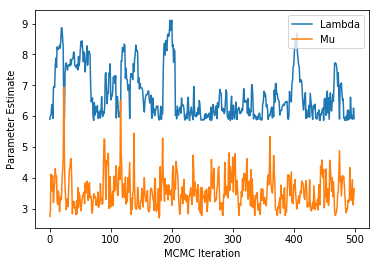

In [44]:
plt.plot(parameters)
plt.xlabel("MCMC Iteration")
plt.ylabel("Parameter Estimate")
plt.legend(["Lambda", "Mu"])
plt.show()